In [1]:
# Run only once to install new version of solo_epd_loader
#%pip install --upgrade solo_epd_loader
#%pip install solo_epd_loader==0.2.8

In [2]:
from epd_plot_shift import *
from run_the_fit import *
from solo_epd_loader import calc_electrons

/home/annafed/anaconda3/envs/annamaria/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Notebook to plot and fit SolO EPD SEE data
#### General information about the notebook:
This Notebook allows the user to load, plot and fit SolO EPD SEE energy data.
The data loading process is done by using solo-epd-loader. 
<br>This package can be installed simply by running   %pip install git+https://github.com/jgieseler/solo-epd-loader    in any cell of the notebook. Note that this should only be done once. The package can be updated by running: %pip install git+https://github.com/jgieseler/solo-epd-loader --upgrade
<br>The data will be saved as cdf files to a local folder provided by the user. The data is then used to create dataframes of the electron data for each instrument and energy channel. 
<br>The flux data will be plotted as a timeseries. The timeseries include all the energy channels for each instrument. (add  expl pa) A flux peak will be searchered for each energy channel using the provided injection time and following the velocity dispersion. These values will then be plotted against the energy corresponding to the channels to form a spectrum. 
<br>The spectrum can then be fit with various functions to analyse its shape.


### NECESSARY INPUTS
Choose a folder where you wish to save the data from the loading, plotting and fitting process. 
If create_sub_folders = True, a new folder will be created for each event and the data etc will be saved there. 
<br> date : (datetime) format: datetime(yyyy, mm, dd, HH, MM) The date and approximate injection time of the event.

In [3]:
path =  r'/home/annafed/Documents/STIX_EPD_event_analysis/'
create_sub_folders = True
threshold_folders = False # if true saving to separate folders does not work. 
plot_n_data_folders = True
save_fit_run_variables_to_separate_folders = True

date = datetime(2021, 9, 24, 16, 23) #onset time or event ID inj time specified later
saving = True

position: this variable contains information about the location of SolO on the day of the event as well as the travel time of light and electrons with energy corresponding to the lowest STEP energy channel (4 keV) and the highest HET energy channel (10 MeV).

In [4]:
position = position_and_traveltime(date)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
-------------------------------------------  -----  ---------
Distance of SolO from the Sun                [AU]    0.61
Length of the Parker Spiral for 400 km/s sw  [AU]    0.645462
Travel time of 4 KeV electrons               [min]  43.1538
Travel time of 10 MeV electrons              [min]   5.3745
Travel time of light                         [min]   5.07322
-------------------------------------------  -----  ---------


### INPUTS FOR PLOTTING AND FITTING

Choose a viewing direction and time averaging for the data.
<br> __direction__ (string): 'sun', 'asun', 'north', 'south'    NOTE: STEP has 'sun' direction only. 
<br> __averaging__(str):  data averaging

<br> Possible values:
<br>‘W’
<br>‘D’ / ‘days’ / ‘day’
<br>‘hours’ / ‘hour’ / ‘hr’ / ‘h’
<br>‘m’ / ‘minute’ / ‘min’ / ‘minutes’ / ‘T’
<br>‘S’ / ‘seconds’ / ‘sec’ / ‘second’
<br>‘ms’ / ‘milliseconds’ / ‘millisecond’ / ‘milli’ / ‘millis’ / ‘L’
<br>‘us’ / ‘microseconds’ / ‘microsecond’ / ‘micro’ / ‘micros’ / ‘U’
<br>‘ns’ / ‘nanoseconds’ / ‘nano’ / ‘nanos’ / ‘nanosecond’ / ‘N’

<br> __ion_correction__ (bool): if True will use ion corrected EPT data (use only if inclusing EPT data)
<br> __bg_subtraction__ (bool): if True will use background subtracted data (else choose False)
<br> __step__ (bool): if True step data will be dowloaded and plotted
<br> __ept__ (bool): if True ept data will be dowloaded and plotted
<br> __het__ (bool): if True het data will be dowloaded and plotted
<br> __fit_type__ (string): the combination of instriment data that will be fit. Options: 'step', 'ept', 'het', 'step_ept', 'ept_het', 'step_ept_het'
<br> __which_fit__ (string): the type of pl function that will be fit to the data. Note that if the data cannot be fit with a specific function the software will choose the next best option. Options: 
<br> __'single'__ will force a single pl fit to the data.
<br> __'broken'__ will force a broken pl fit to the data but ONLY if the break point is within the energy range otherwise a sigle pl fit will be produced instead.
<br> __'best_sb'__ will choose automatically the best fit type between single and broken by comparing the redchis of the fits.
<br> __'cut'__ will produce a single pl fit with an exponential cutoff point. If the cutoff point is outside of the energy range a broken or single pl will be fit instead.
<br> __'broken_cut'__ will produce a broken pl fit with an exponential cutoff point. If the cutoff point is outside of the energy range a broken, cut or single pl will be fit instead.
<br> __'best_cb'__ will choose automatically the best fit type between broken and cut by comparing the redchis of the fits. A single pl will be fit to the data if the other fits are not physical. 
<br> __'triple'__ will try to fit a triple pl to the data. If this is not possible, the next best option will be fit to the data. 
<br> __'best'__ will automatically choose the best out of all the fitting options.

In [5]:
direction = 'south'
averaging = '5min'
contamination_threshold = 0  # either None or an integer >0 (STEP)

ion_correction = True 
bg_subtraction = True

step = False
ept = True
het = True

fit_type= 'ept'
which_fit = 'broken'


### NON-NECESSARY INPUTS

#### PLOTTING TIMESERIES AND SPECTRUM (NO FIT)
The following inputs can be changed, but the notebook will run without any furher changes.
<br> __start_date__ and __end_date__ (int or datetime): The start and end date to download data. These should be different only in case the event occurs close to midnight. Automatically done if the event is less that 4h from midnight. Format: datetime(yyyy, mm, dd) or yyyymmdd.
<br> __plot_start__ and __plot_end__ (string): The start and end time for the timeseries plot. Automatically taken as $\pm$4h. Format: 'yyyy-mm-dd-HHMM'
<br> __t_inj__ (string): taken automatically from previously defined value (date). Also this value is changed by using the light travel time (position) to fit the peak into the search window. This value is fixed to the highest HET channel (close traveltime to light tt for electrons), the rest of the window times are calculated using velocity dispersion.
<br> For the background there are two options: either a fixed bg window that starts and ends at the same time for each energy channel or a bg window that follows the peak search window (beacuse of velocity dispersion at different times for different energy channels). 
For a fixed bg window: __bg_start__ and __bg_end__ (string, defaults to None) 'yyyy-mm-dd-HHMM'
For a bg window that follows the peaxk search window: __bg_distance from window__ (int, defauts to 120): the distance of the start time of the bg window from the start of the search window in minutes. __bg_period__ (int, defaults to 60) the length of the bg window in minutes.
<br> __travel_distance__ (float): Length of the Parker Spiral in AU. This is taken automatically from the position variable.
<br> __travel_distance_second_slope__ (float, defaults to None): __travel_distance_second_slope__ > __travel_distance__ If specified this will create a peak search window that broadens at lower energies. If specified set fixed_window = None.
<br> __fixed_window__ (int, defauts to 60): the length of the search window in minutes. 
<br> __autodownload__ (bool, defaults to True): If True will automatically download the data to analyse the event.
<br> __data_type__ (string, defaults to 'l2'): 'll' = low latency, 'l1' = level 1 data, 'l2' = level 2 data for scientific research.
<br> __plot_pa__ (bool, defauts to True): plots the pitch angle coverage for the event.

In [6]:
startdate = date-timedelta(hours = 6)
start_date = startdate.date()
enddate = date+timedelta(hours = 6)
end_date = enddate.date()

plot_start = str(date-timedelta(hours = 6))[:-3].replace(' ', '-').replace(':', '')
plot_end = str(date+timedelta(hours = 3))[:-3].replace(' ', '-').replace(':', '')


t_inj = str(date)[:-3].replace(' ', '-').replace(':', '')
date_folder = t_inj
#plot_path = path_to_folder
#if create_sub_folders:
#  create_new_path(path, t_inj)#, threshold_folders = threshold_folders, contamination_threshold = contamination_threshold, plots_n_data = plot_n_data_folders)
#  path_to_folder = path+t_inj+'/'
# plot_path = path_to_folder

if contamination_threshold == None:
    threshold_folders = False
if create_sub_folders:
    create_new_path(path, t_inj, threshold_folders = threshold_folders, contamination_threshold = contamination_threshold, plots_n_data = plot_n_data_folders)
    path_to_folder = path+t_inj+'/'
    plot_path = path_to_folder
if threshold_folders:
    path_to_folder = path_to_folder+'contamination_threshold_'+str(contamination_threshold)+'/'
if plot_n_data_folders:
    plot_path = path_to_folder+'plots'
 
    
# Need to subtract the light travel time at SolO distance because the Raul inj. times
# in the STIX/EPD table are shifted from sun to SolO and I need inj. time at the Sun
#t_inj = str(date-timedelta(minutes = position[4][2]))[:-3].replace(' ', '-').replace(':', '')
#t_inj = str(date-timedelta(minutes = 20))[:-3].replace(' ', '-').replace(':', '')

#print(date_folder)

#bg_start = None 
#bg_end = None 
#bg_distance_from_window = '10min'
#bg_period = '3h'

#travel_distance = position[0][2]
#travel_distance_second_slope = None
#fixed_window = '60min' #either input time period in minutes or None

autodownload_data = True
data_type = 'l2'
plot_pa = True


Creating new directory /home/annafed/Documents/STIX_EPD_event_analysis/2021-09-24-1623


#### INPUTS FOR THE FIT
<br> __c1_guess__ (int or float, defaults to 1000): the flux value corresponding to 0.1 MeV
<br> __g1_guess__ (int or float, defaults to -1.9): the slope of a single pl or the first part of a broken or triple pl. __g1_guess__ > __g2_guess__, __g3_guess__ and __g1_guess__< 0.
<br> __g2_guess__ (int or float, defaults to -2.5): the slope of the broken pl after the break or the slope between the two breaks for a triple pl. __g1_guess__> __g2_guess__ >  __g3_guess__ and __g2_guess__< 0.
<br> __g3_guess__ (int or float, defaults to -4): the slope of a triple pl after the second break. __g1_guess__, __g2_guess__ >  __g3_guess__ and __g3_guess__< 0.
<br> __alpha_guess__ and __beta_guess__ (int or float, defaults to 10): the smoothness of the first and second break respectively.
<br> __break_guess_low__ (int or float, defaults to 0.6 MeV): the energy corresponding to the first break in the spectrum (in MeV).
<br>__break_guess_high__ (int or float, defaults to 1.2 MeV): the energy corresponding to the second break in the spectrum (in MeV).
<br> __cut_guess__ (int or float, defaults to 1.2 MeV): the energy corresponding to the exponential cutoff in the spectrum (in MeV).
<br> __fit_to__ (string, defaults to 'peak'): 'peak' or 'average'
<br> __e_min__ and __e_max__ (int or float, defaults to None): minimum and maximum energy to fit. If None will automatically be taken as min and max fittable values. step energy range: 0.004323343613-0.07803193193 MeV, ept energy range: 0.03295087252-0.452730295 MeV, het energy range: 0.6859485403-10.62300288 MeV, second het channel: 1.590048112 MeV
<br> __use_random__ (bool, defaults to True): if True the software will choose random values close to the guess values that will be fit to the data to find the fit with the lowest redchisq.
<br> __random_iterations__ (int, defaults to 20): number of times the random values will be chosen.
<br> __sigma__ (int, defaults to 3.): standard deviation from the background.
<br> __rel_err__ (float, defaults to 0.5): The absolute value of the uncertainty of the bg subtracted flux peak divided by the bg subtracted peak.
<br> __frac_nan_threshold__ (float, defaults to 0.9): exclude all spectrum values with fraction of non-nan data points in search window lower than the corresponding value.
<br> __leave_out_1st_het_chan__ (bool, defaults to True): If True, the first HET channel will be left out from the fit.
<br> __shift_step_data__ (bool, defaults to False): If True, STEP data will be shifted (up or down, intensity wise) by a factor equal to shift_factor.
<br> __shift_factor__ (float, defaults to None): Factor to shift STEP data (e.g. 0.8). 
<br> __legend_details__ (bool, optional): If True, the final fit type and the reduced chi square will be dislayed in the legend.
	


In [7]:
c1_guess = 1000
g1_guess = -1.9
g2_guess = -2.5
g3_guess = -4
alpha_guess = 10
beta_guess = 10
break_guess_low = 0.6
break_guess_high = 1.2
cut_guess = 1.2

fit_to = 'peak'

e_min = None
e_max = None

use_random = True
random_iterations = 20

if saving:
    save_fig = True
    save_fit_variables = True
    save_fitrun = True

sigma = 3
rel_err = 0.5
frac_nan_threshold = 0.9
leave_out_1st_het_chan = False
shift_step_data = False
shift_factor = None #0.8

detailed_legend = True

## LOAD DATA

In [8]:
if plot_pa:
    msdate = dt.datetime.combine(pd.to_datetime(plot_start).date(), dt.time.min)
    medate = dt.datetime.combine(pd.to_datetime(plot_end).date()+ dt.timedelta(days=1), dt.time.min) #+ dt.timedelta(days=1)

    mag_srf = solo_mag_loader(msdate, medate, level='l2', frame='srf', av=None, path=path_to_folder)
    

Loading MAG...


In [9]:
if step:   
    # read in STEP original data to df_particles_step_org. electron fluxes calculated later with calc_electrons
    df_particles_step_org, energies_step = epd_load(sensor='step', level='l2', startdate=start_date, 
                                                    enddate=end_date, path=path_to_folder, autodownload=True, 
                                                    only_averages=True)

In [10]:
#df_particles_step

In [11]:
if ept:
    df_protons_ept, df_electrons_ept, energies_ept = epd_load(sensor = 'ept', viewing = direction, level = 'l2',
                                                                  startdate = start_date, enddate = end_date, 
                                                                  path=path_to_folder, autodownload=True)
    

In [12]:
if het:  
    df_protons_het, df_electrons_het, energies_het = epd_load(sensor = 'het', viewing = direction, level = 'l2',
                                                            startdate = start_date, enddate = end_date, 
                                                            path=path_to_folder, autodownload=True)
   

In [13]:
# change depending on onset time difference 
t_inj = str(date-timedelta(minutes = 20))[:-3].replace(' ', '-').replace(':', '')

print(date_folder)

bg_start = None 
bg_end = None 
bg_distance_from_window = '10min'
bg_period = '3h'

travel_distance = position[0][2]
travel_distance_second_slope = None
fixed_window = '40min' #either input time period in minutes or None


2021-09-24-1623


In [14]:
date_string = str(date.date())

## STEP

In [15]:
if step:
    # calculate resampled STEP electron fluxes (+ ions)
    df_particles_step = calc_electrons(df=df_particles_step_org, meta=energies_step, 
                                       contamination_threshold=contamination_threshold, only_averages=True,
                                       resample=averaging)
    data_step = extract_electron_data(df_particles_step, energies_step, plot_start, plot_end, t_inj, 
                                      bgstart = bg_start , bgend = bg_end, bg_distance_from_window = bg_distance_from_window, 
                                      bg_period = bg_period, travel_distance = travel_distance, 
                                      travel_distance_second_slope = travel_distance_second_slope, fixed_window = fixed_window, 
                                      instrument = 'step', data_type = 'l2', averaging=averaging, 
                                      masking=False)
    if plot_pa:
        if averaging is not None:
            mag_srf = mag_srf.resample(averaging).mean()
        coverage = calc_pa_coverage('step', mag_srf)

    if saving: write_to_csv(data_step, date = date_string, path=path_to_folder, direction = direction)
    plot_channels(data_step, bg_subtraction=False, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'step', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err)
    bg_b = bg_subtraction
    plot_channels(data_step, bg_subtraction=bg_b, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'step', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err)
    bg_b = bg_subtraction
    plot_spectrum_peak(data_step, bg_subtraction=bg_b, path=plot_path, savefig=saving, sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold= rel_err, direction = direction)
    #plot_spectrum_average(data_step, bg_subtraction=bg_b, savefig=saving, path=path_to_folder, sigma=sigma, frac_nan_threshold=frac_nan_threshold, rel_err_threshold=rel_err, direction=direction)
    


## EPT

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:815: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_electron_uncertainties['Electron_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


Calculating PA coverage for ept...


100%|██████████| 576/576 [00:00<00:00, 11339.52it/s]


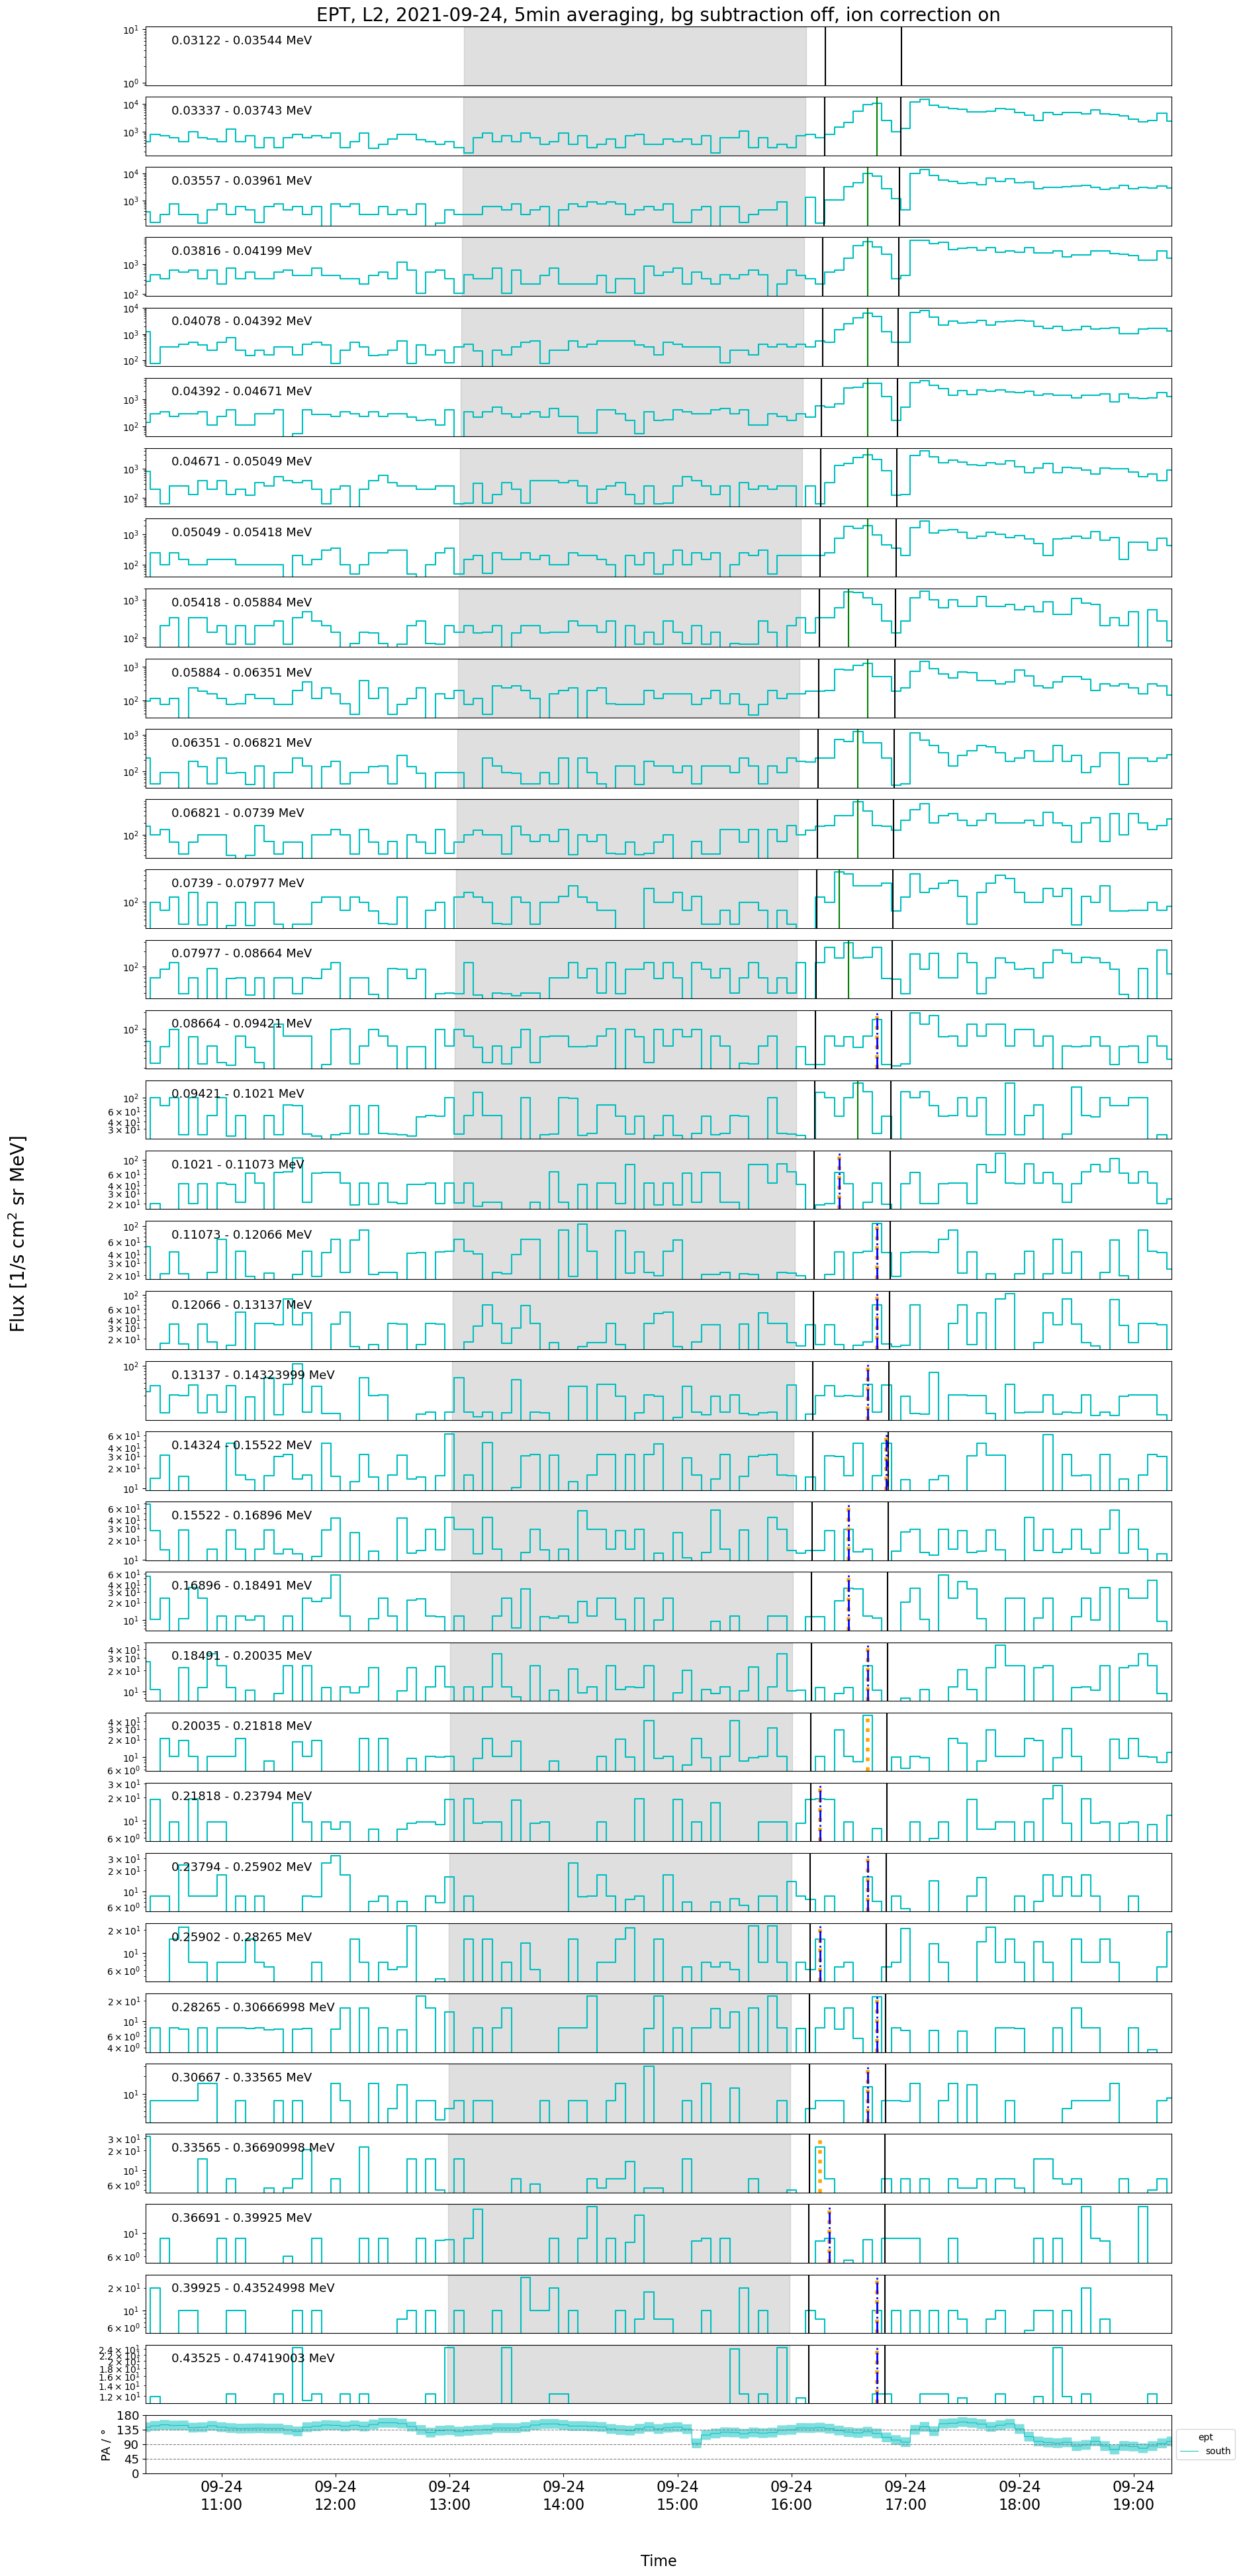

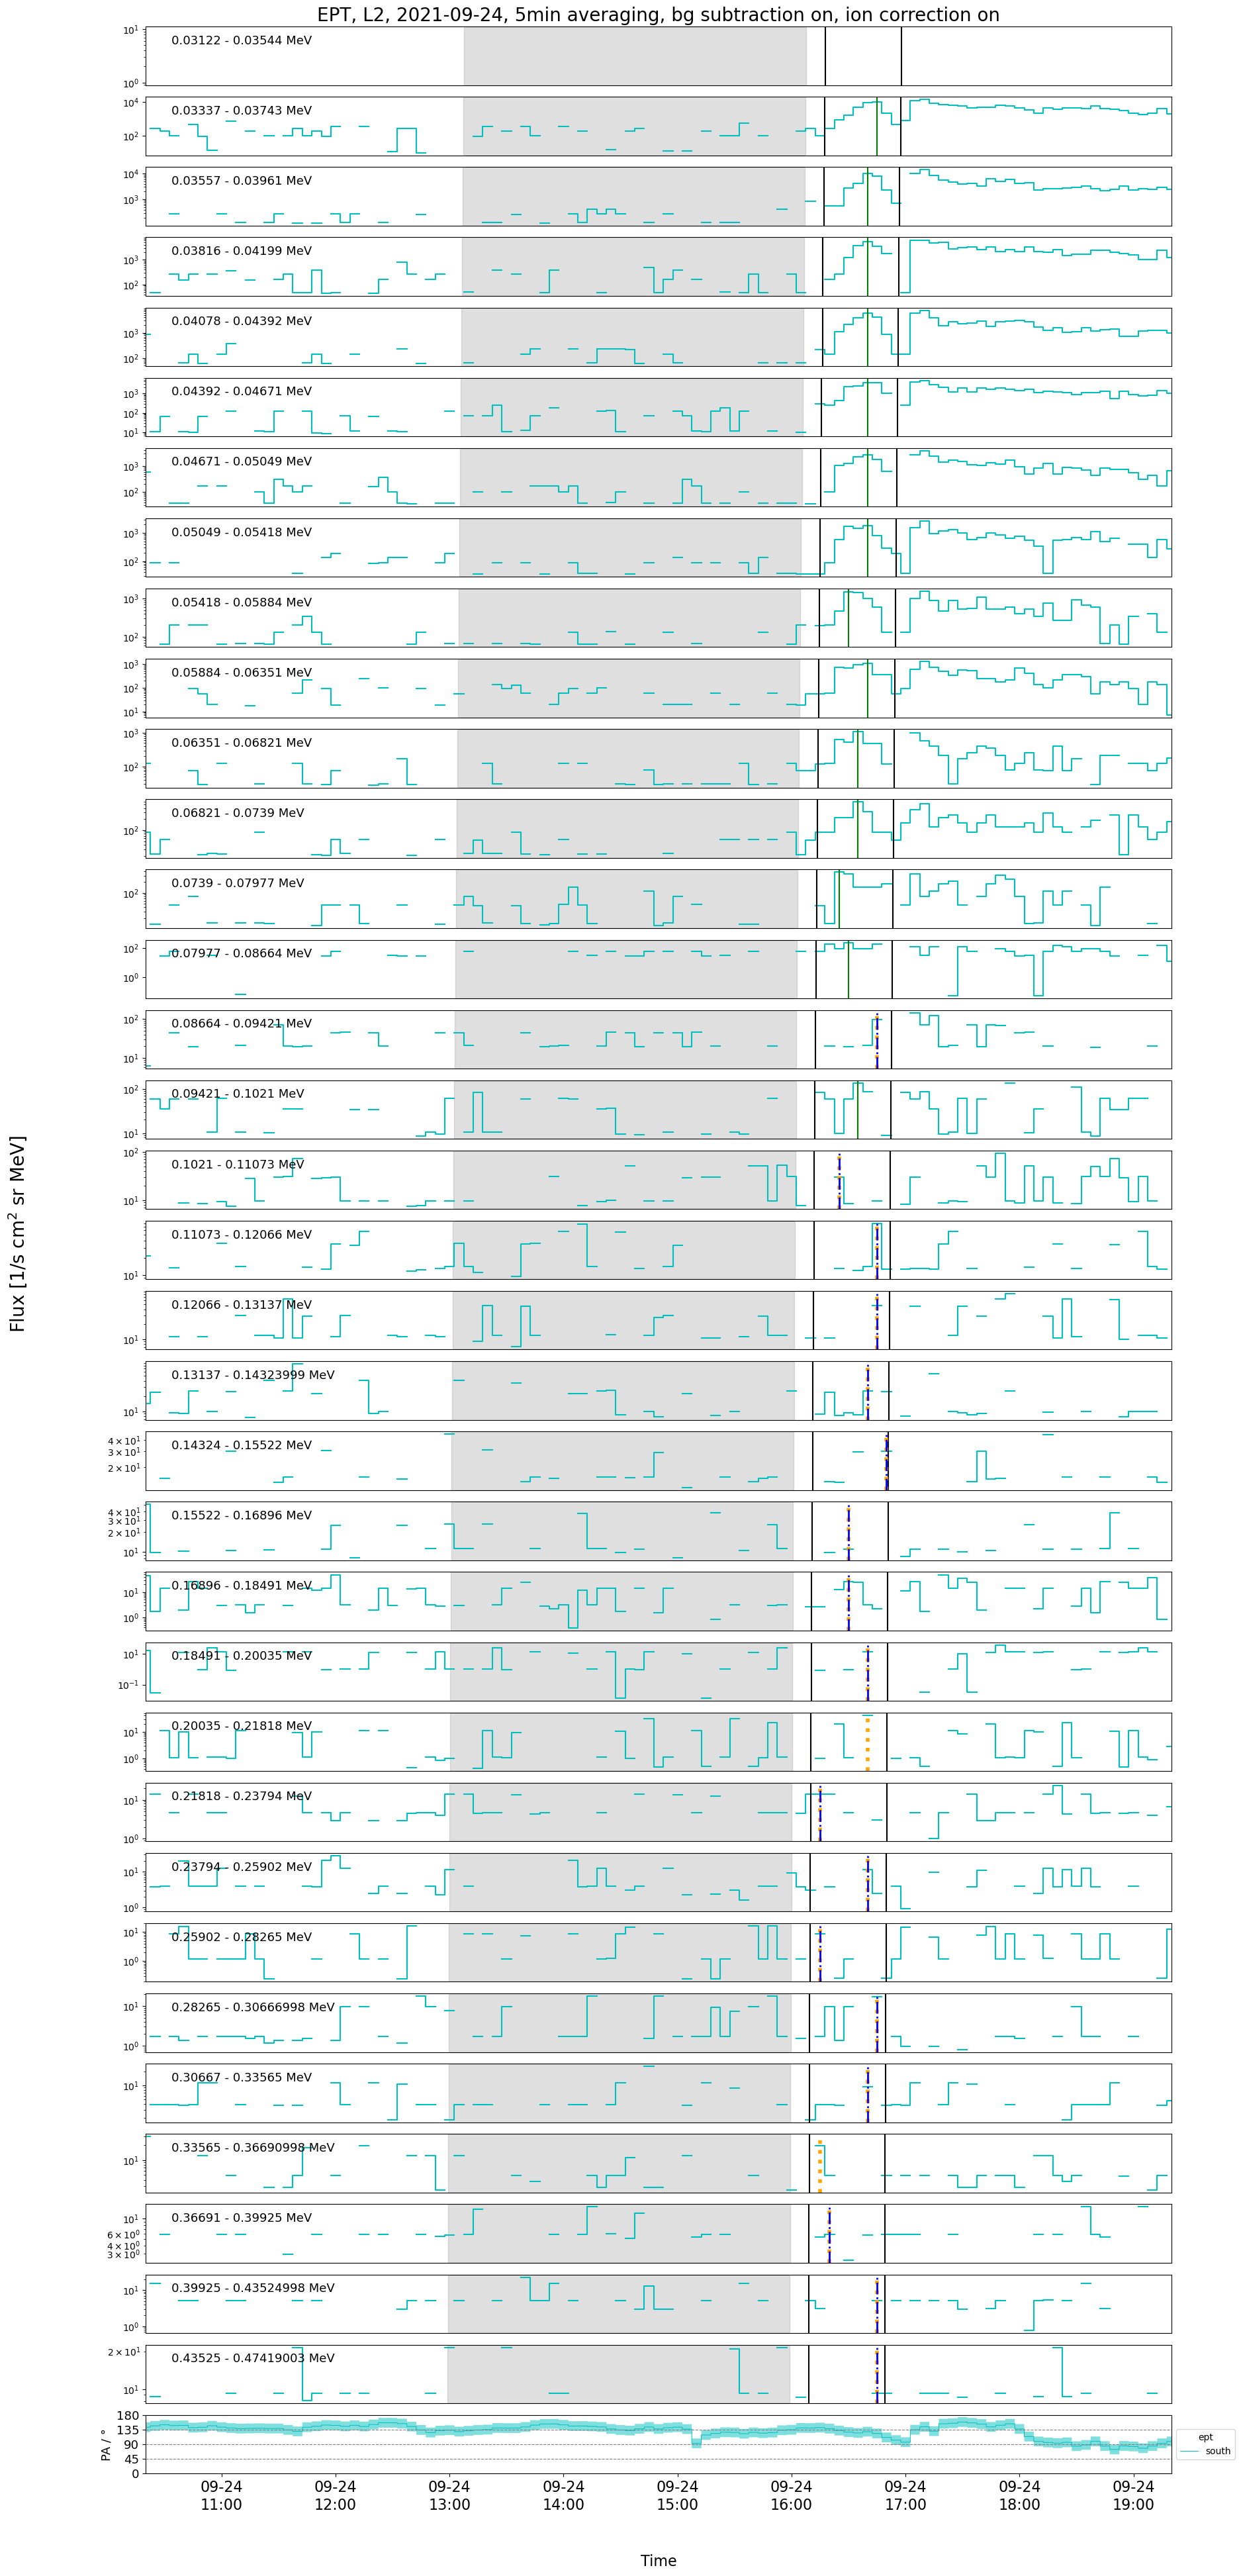

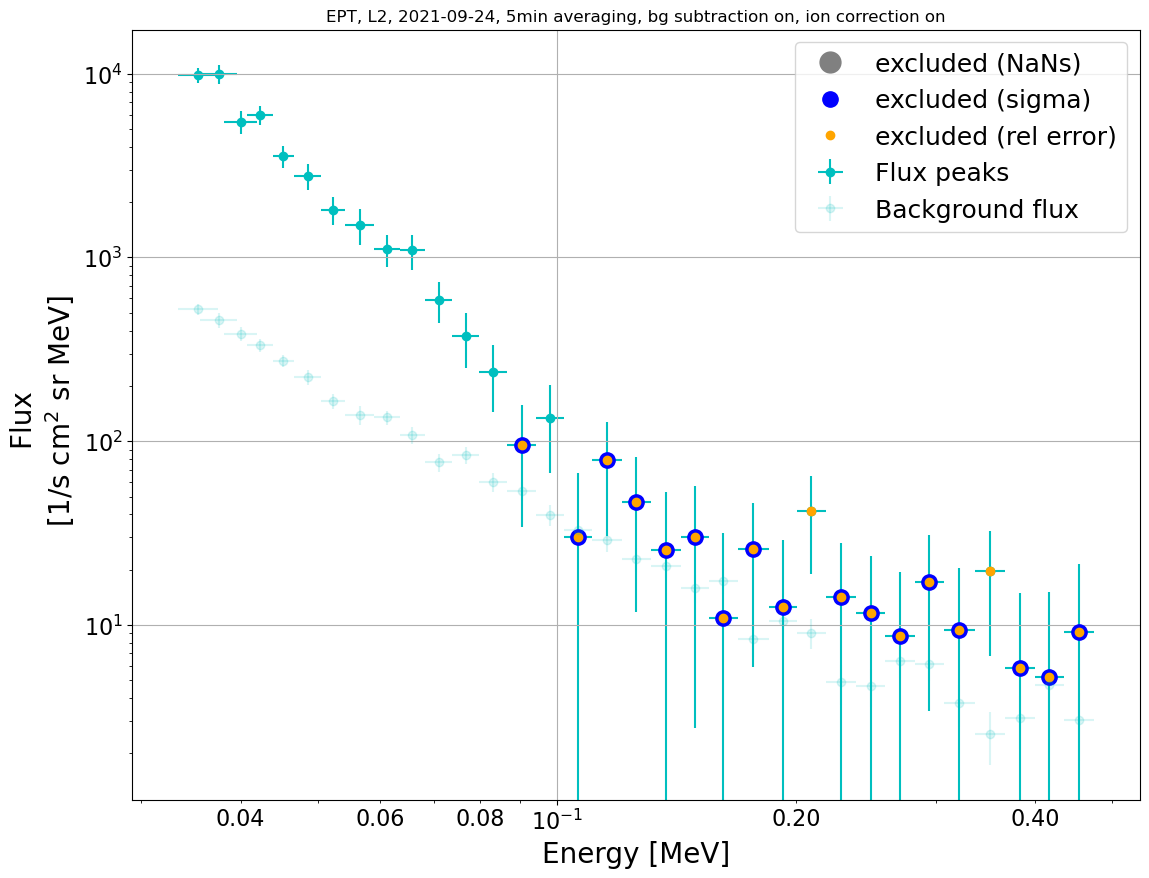

In [16]:
if ept:
    ion_b = ion_correction    
    data_ept = extract_electron_data(df_electrons_ept, energies_ept, plot_start, plot_end, t_inj, bgstart = bg_start, 
                                     bgend = bg_end, bg_distance_from_window = bg_distance_from_window, bg_period = bg_period, 
                                     travel_distance = travel_distance, travel_distance_second_slope=travel_distance_second_slope, 
                                     fixed_window=fixed_window, instrument = 'ept', data_type = 'l2', averaging=averaging, masking=True, 
                                     ion_conta_corr=ion_b, df_protons = df_protons_ept)

    
    if plot_pa:
        mag_srf = mag_srf.resample(averaging).mean()
        coverage = calc_pa_coverage('ept', mag_srf)
    else:
        coverage = None

    if saving: write_to_csv(data_ept, date = date_string, path=path_to_folder, direction = direction)
    plot_channels(data_ept, bg_subtraction=False, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'ept', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, viewing = direction)
    bg_b = bg_subtraction
    plot_channels(data_ept, bg_subtraction=bg_b, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'ept', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, viewing = direction)
    bg_b = bg_subtraction
    plot_spectrum_peak(data_ept, bg_subtraction=bg_b, path=plot_path, savefig=saving, sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, direction = direction) 
    #plot_spectrum_average(data_ept, bg_subtraction=bg_b, path=path_to_folder, savefig=saving, frac_nan_threshold=frac_nan_threshold)      


## HET

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:815: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_electron_uncertainties['Electron_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


Calculating PA coverage for het...


100%|██████████| 576/576 [00:00<00:00, 11238.35it/s]


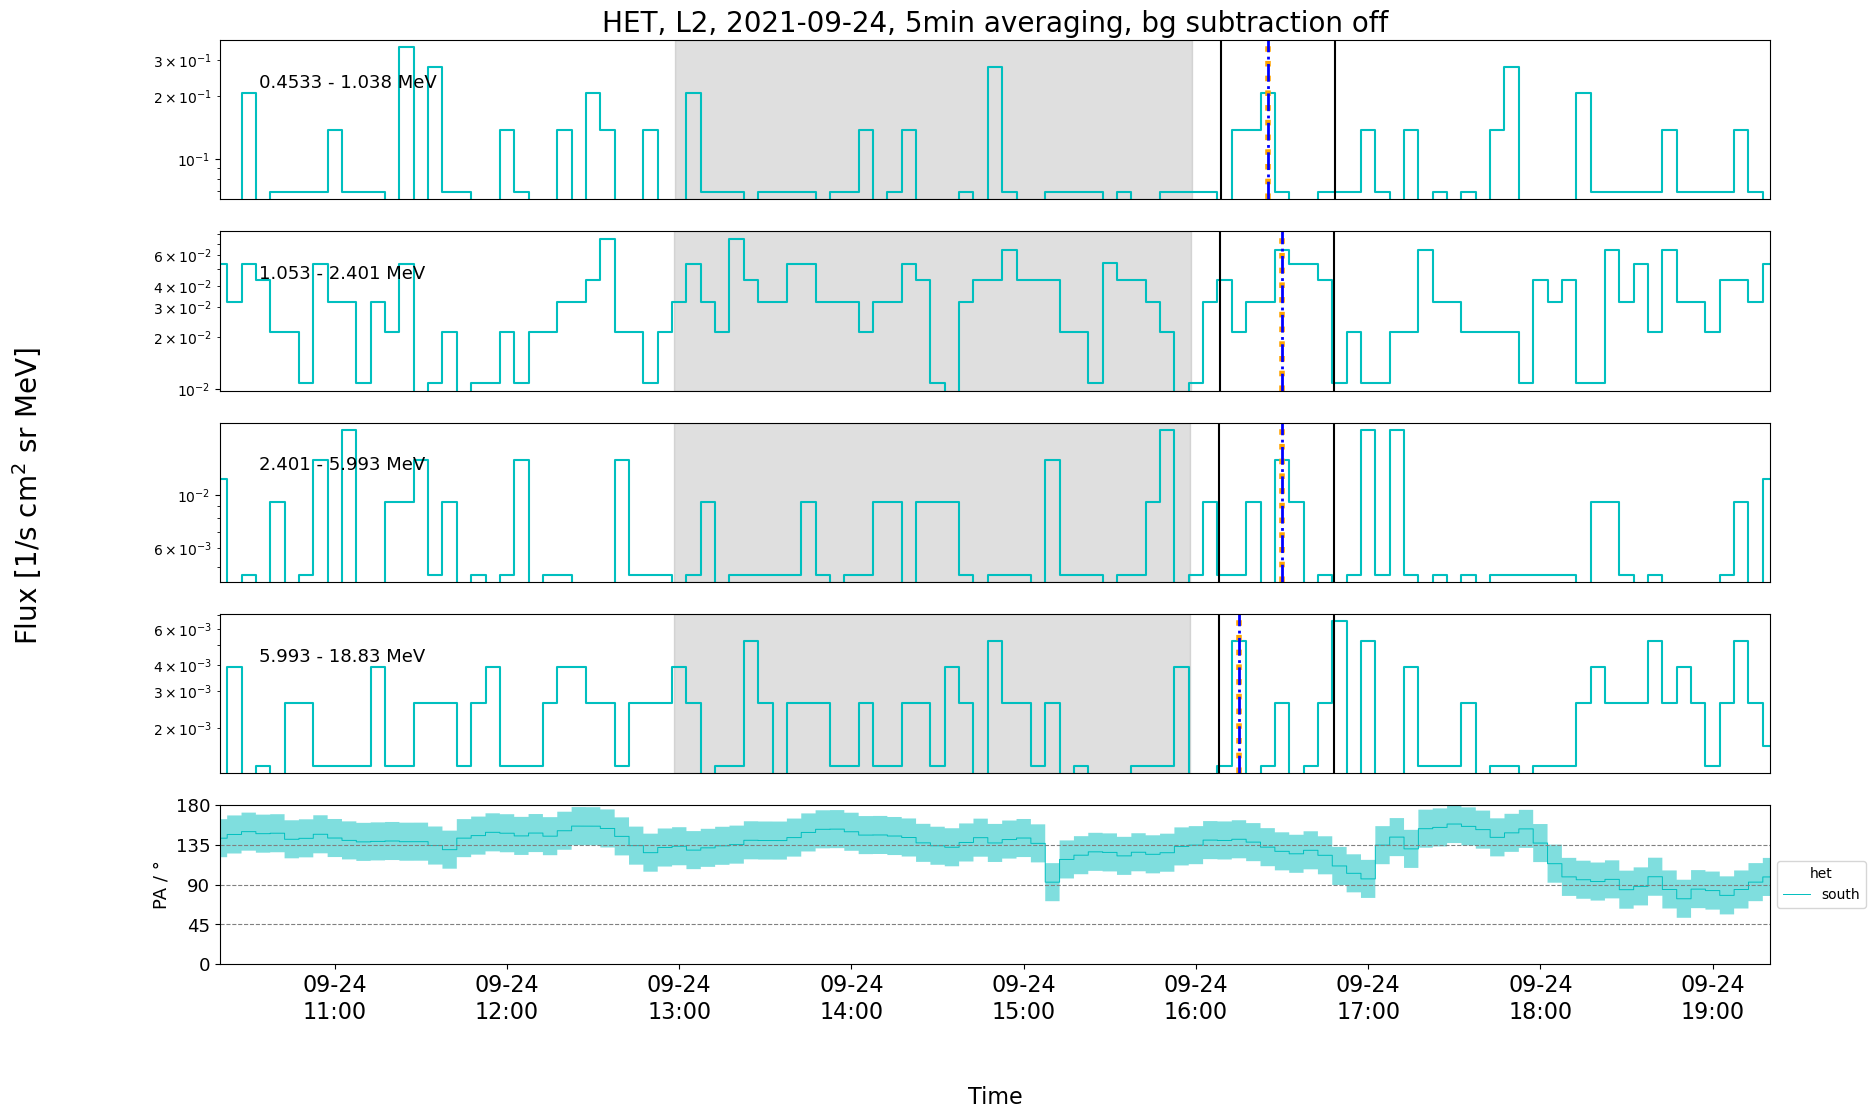

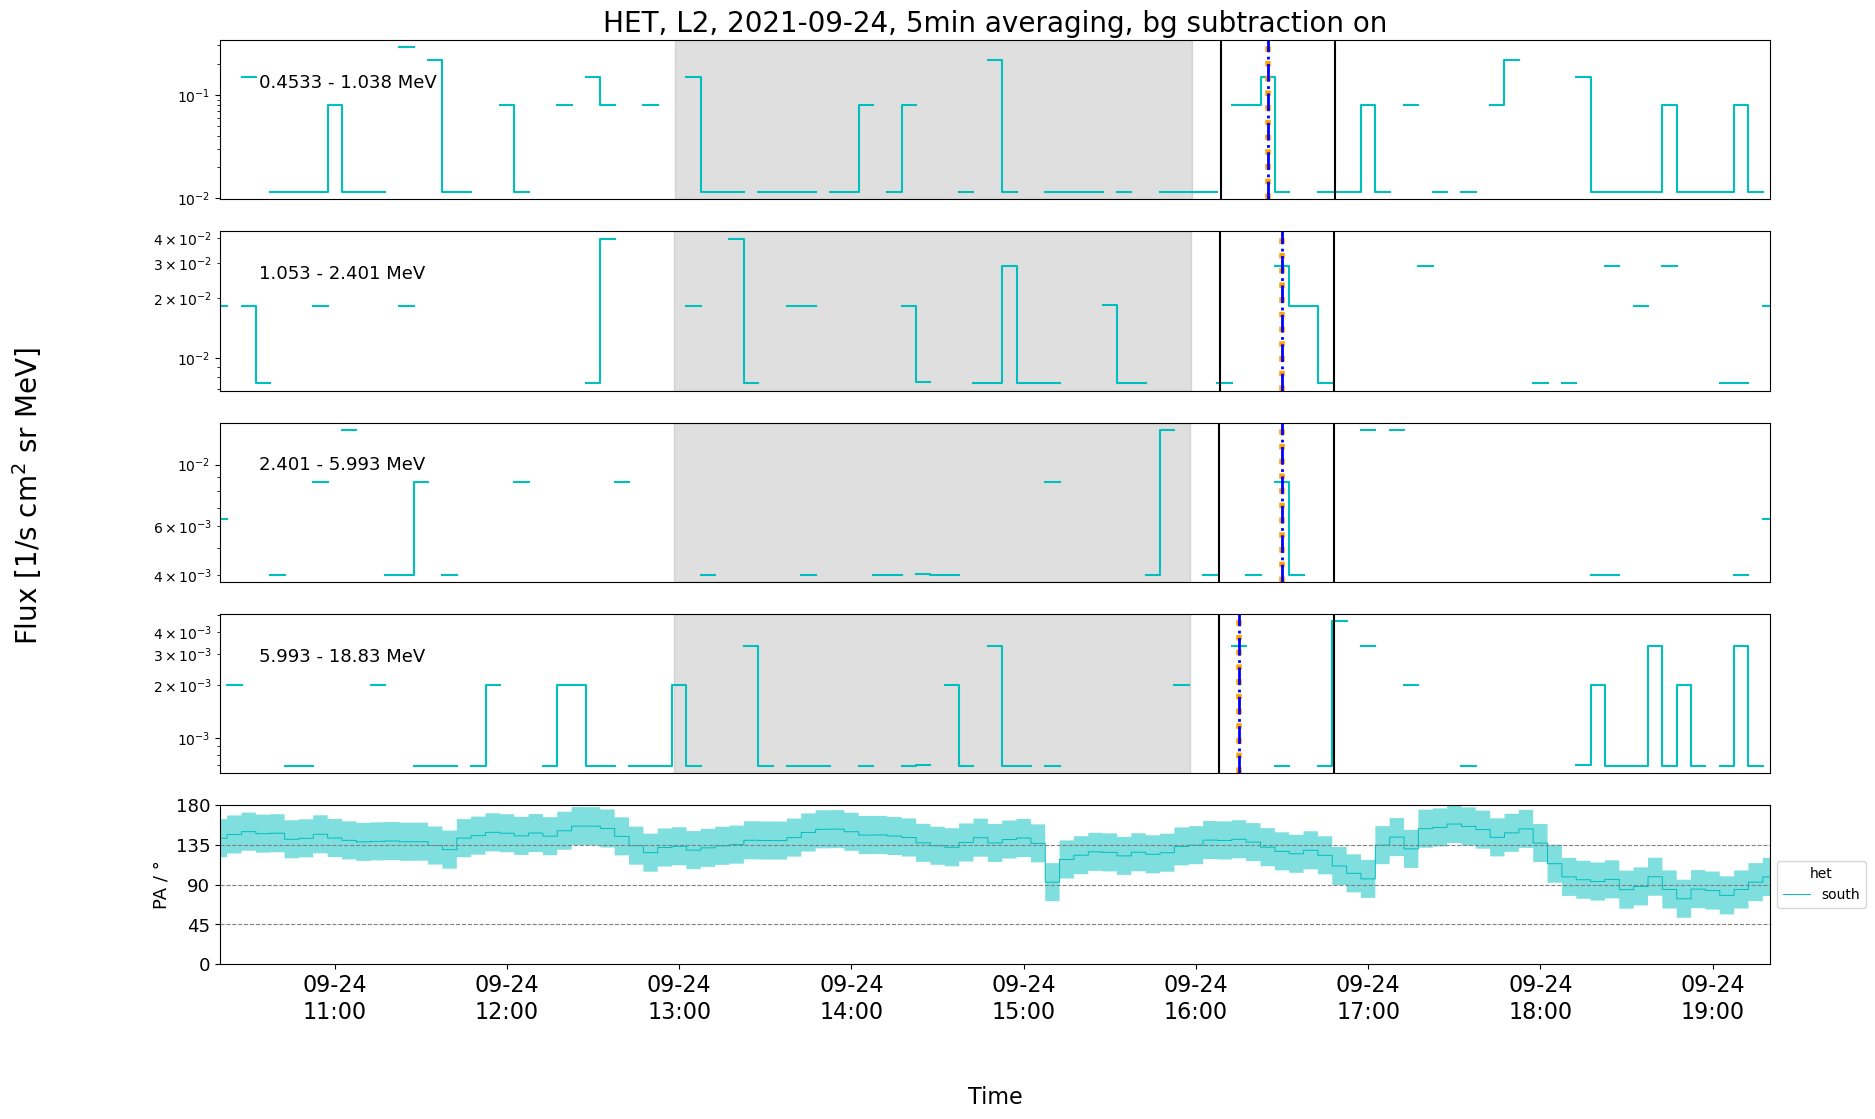

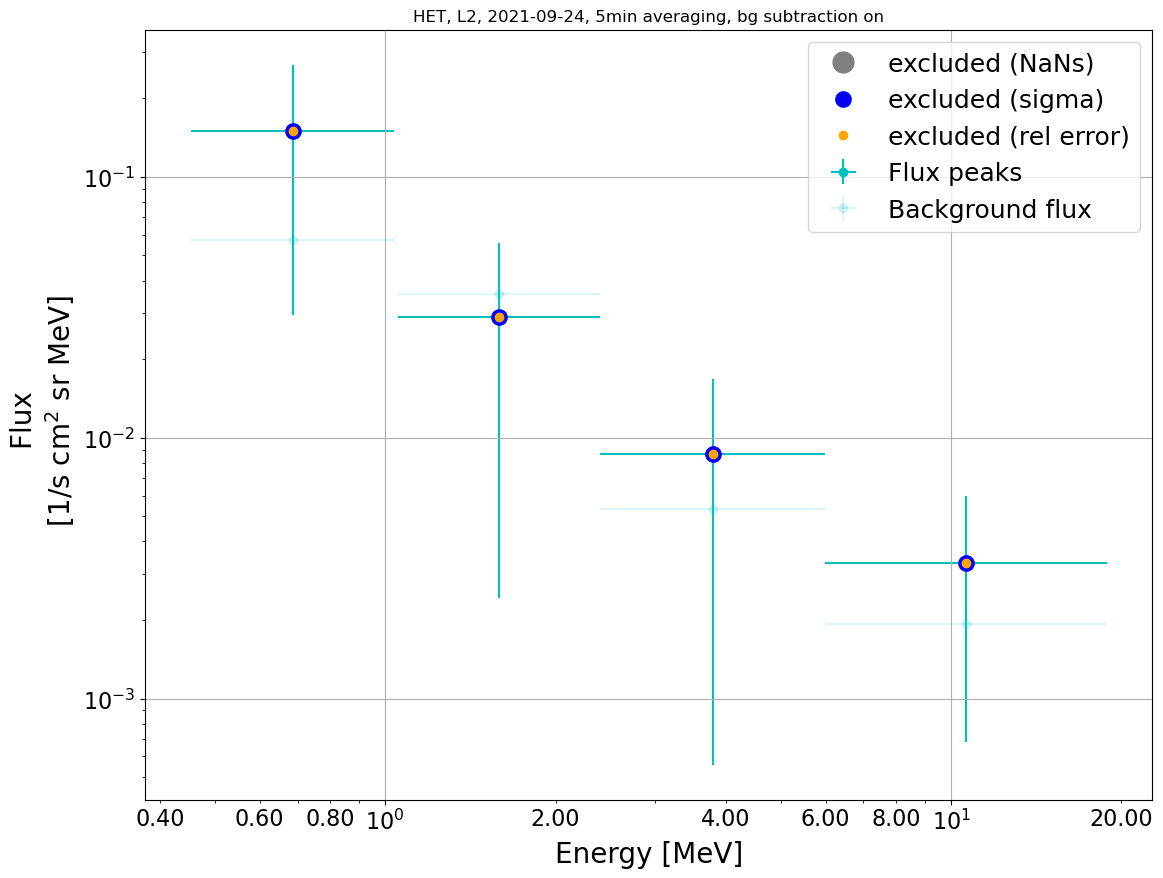

In [17]:
if het:
    data_het = extract_electron_data(df_electrons_het, energies_het, plot_start, plot_end, t_inj, 
                                     bgstart = bg_start, bgend = bg_end,  bg_distance_from_window = bg_distance_from_window,
                                     bg_period = bg_period, travel_distance = travel_distance, 
                                     travel_distance_second_slope = travel_distance_second_slope, 
                                     fixed_window = fixed_window, instrument='het', data_type='l2', 
                                     averaging=averaging, df_protons = df_protons_het)

    if plot_pa:
        mag_srf = mag_srf.resample(averaging).mean()
        coverage = calc_pa_coverage('het', mag_srf)

    if saving: write_to_csv(data_het, date = date_string, path=path_to_folder, direction = direction)
    plot_channels(data_het, bg_subtraction=False, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'het', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, viewing = direction)
    bg_b = bg_subtraction
    plot_channels(data_het, bg_subtraction=bg_b, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'het', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, viewing = direction)
    bg_b = bg_subtraction
    plot_spectrum_peak(data_het, bg_subtraction=bg_b, path=plot_path, savefig=saving, sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, direction = direction)


## FIT

In [18]:
c1_guess = 1000
g1_guess = -1.9
g2_guess = -2.5
g3_guess = -4.
alpha_guess = 10.
beta_guess = 10.
break_guess_low = 0.6
break_guess_high = 1.2
cut_guess = 1.2

fit_to = 'peak'

e_min = None
e_max = None
#random_iterations= 100
#fit_type= 'step'
which_fit = 'broken'
detailed_legend = True

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: invalid value encountered in double_scalars
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
single


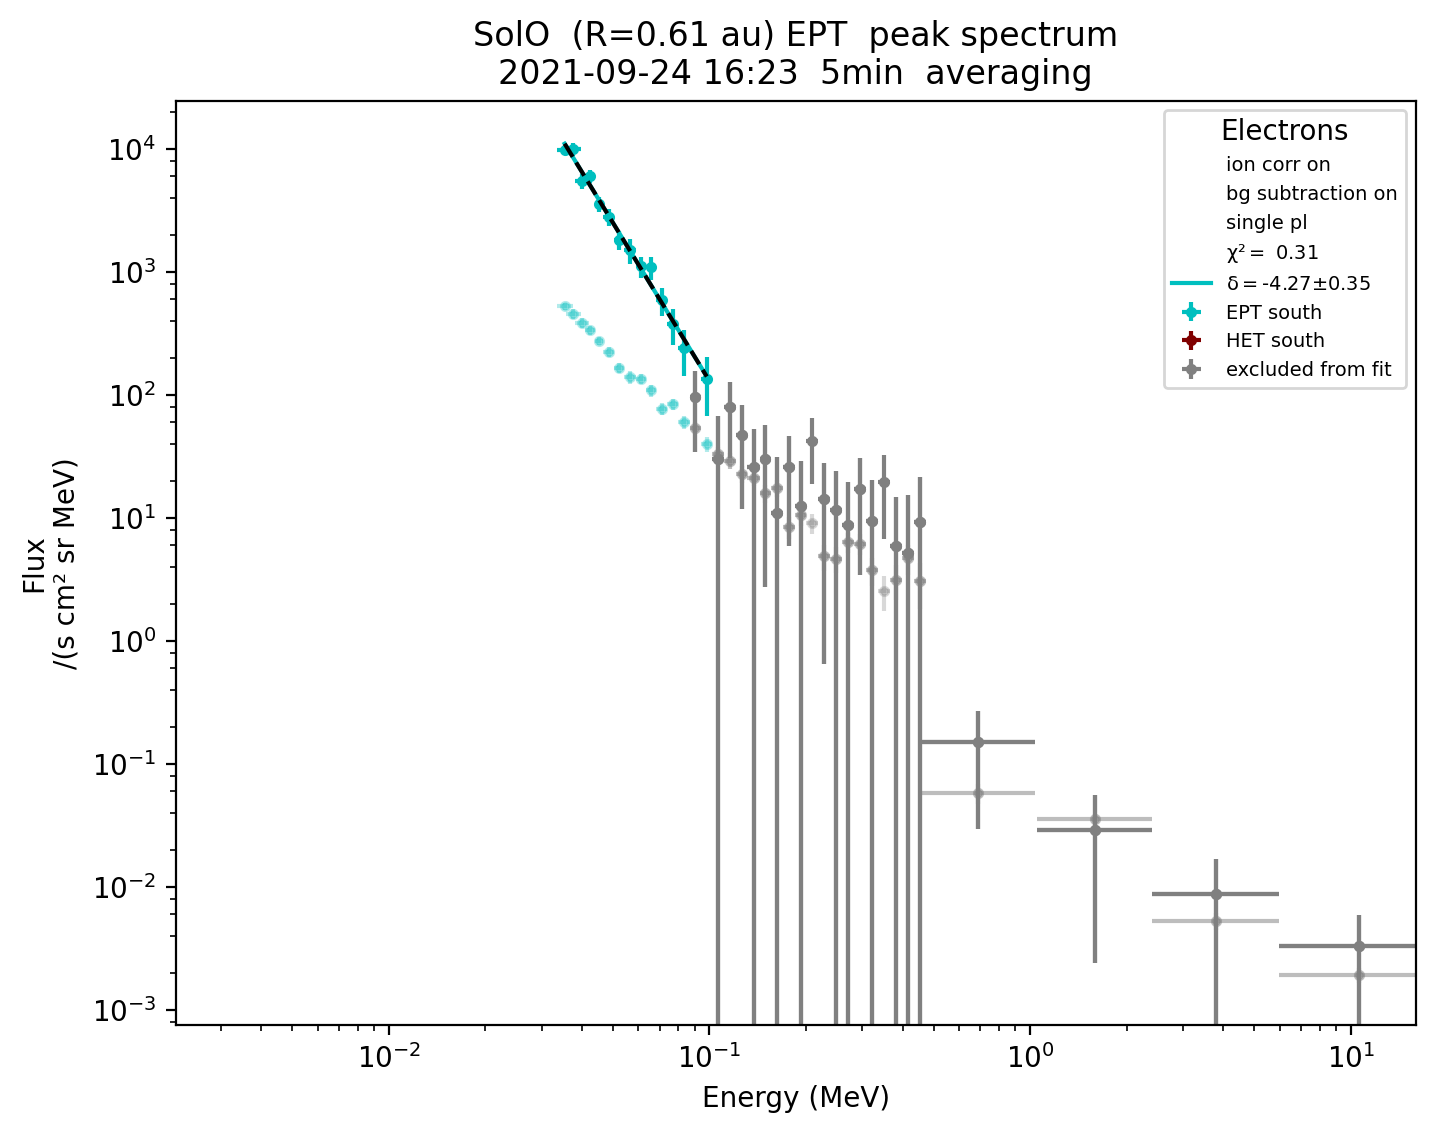

In [19]:
FIT_DATA(path_to_folder, date, averaging = averaging, fit_type= fit_type, step = step, ept = ept, het = het, direction = direction,
         which_fit = which_fit, sigma = sigma, rel_err = rel_err, frac_nan_threshold = frac_nan_threshold, fit_to = fit_to, 
         e_min = e_min, e_max = e_max, g1_guess = g1_guess, g2_guess = g2_guess, g3_guess = g3_guess, c1_guess = c1_guess, 
         alpha_guess = alpha_guess, beta_guess = beta_guess, break_guess_low = break_guess_low, break_guess_high = break_guess_high, cut_guess = cut_guess, 
         use_random = use_random, iterations = random_iterations, leave_out_1st_het_chan = leave_out_1st_het_chan, shift_step_data = shift_step_data, 
         shift_factor = shift_factor, save_fig = saving, save_pickle = False, save_fit_variables = saving, save_fitrun = saving, legend_details = detailed_legend, 
         ion_correction = ion_correction, bg_subtraction = bg_subtraction, fit_to_separate_folder = plot_n_data_folders)


In [20]:
path

'/home/annafed/Documents/STIX_EPD_event_analysis/'

In [21]:
#if averaging<1.:
 #   averaging = str(int(averaging*60))+'s'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABZsAAARtCAYAAAAzspvZAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/MnkTPAAAACXBIWXMAAB7CAAAewgFu0HU+AAEAAElEQVR4nOzdd1gUV9sG8HvpTYoIiIIUC/beG2DX2EsMVuwak6h57cYWoya2aIyxxpbEFnsvKCiCvRfsgiAooIDS23x/8DHZZSvsApb7d117uTN75pwzZdfl2TPPkQiCIICIiIiIiIiIiIiISAt6xd0BIiIiIiIiIiIiIvr4MdhMRERERERERERERFpjsJmIiIiIiIiIiIiItMZgMxERERERERERERFpjcFmIiIiIiIiIiIiItIag81EREREREREREREpDUGm4mIiIiIiIiIiIhIaww2ExEREREREREREZHWGGwmIiIiIiIiIiIiIq0x2ExEREREREREREREWmOwmYiIiIiIiIiIiIi0xmAzEREREREREREREWmNwWYiIiIiIiIiIiIi0hqDzURERERERERERESkNQabiYiIiIiIiIiIiEhrDDYTERERERERERERkdYYbCYiIiIiIiIiIiIirTHYTERERERERERERERaY7CZiIiIiIiIiIiIiLTGYDMREX20QkNDIZFIIJFI4OrqWtzdKRIvXryAubk5JBIJvv/+++LuDlGhSEtLg6urKyQSCdq1a1fc3SFSKiAgQPx/yMvLq7i7QwQvLy/xmgwICCju7hAR0WeIwWYiIlLr3Llz+Prrr1G/fn3Y2dnByMgIpqamsLe3R7169eDj44MlS5bg0qVLyM7OLu7uaiQsLAy//fYbOnbsiEqVKsHKygqmpqZwdXVFs2bNMGvWLFy5cqW4uynnf//7H5KTk2FpaYkZM2YoLCMd/FD0MDQ0RKlSpVCrVi0MHToUR48e/WjO24sXLzBnzhzUq1cPdnZ2MDU1Rfny5dG7d2/s27cPgiAUWtsJCQlYunQp2rZtizJlysDY2Bh2dnaoW7cuZsyYgUePHmlcl6+vr8pzpOhx/vz5Qtu3D42xsTHmzZsHADh16hT27dtXaG2lp6djx44dGDBgAKpUqQIbGxsYGBjA3NwcTk5OaNasGUaMGIF169bh8ePHMttK/+Clq8fmzZvF+ufMmVPgepT9ALd582aV2xkbG6N06dJo1qwZJk6ciLt37xbasSd56s6Puoci6v5PMDIygp2dHerXr49vvvkGwcHBcnVocy3mp69ERET0CRCIiIiUePDggdC0aVMBgMYPFxeXIuvf8+fP891uTEyMMHbsWMHAwECj/WnXrp1w586dwt0RDV24cEHs1/Tp05WW8/f3z9c5AyDUqlVLuHv3bhHuTf79+eefgrm5ucr9aNOmjRAVFaXztnfu3ClYW1urbNvIyEiYP3++kJ2drba+wYMH5/scBQYG6ny/PmSZmZlChQoVBABCpUqVhMzMTJ23cfToUcHJySlf52Hw4MHi9tKfQbp6bNq0Sax/9uzZBa5H2Wfipk2b8l3XwIEDhXfv3un8+H8KpD9vPT09ta6vIOdH+qGuj5o+OnToILx69UqsQ5trMT99Je15enqKx9jf37+4u0Mq6Przg4joQ2EAIiIiBW7fvg1vb2+8fftWXGdnZ4cGDRqgdOnS0NPTw9u3b3H//n08evRIHBkbHx9fTD1W7/79++jQoQPCw8PFdQYGBmjcuDFcXFxgbGyMyMhIBAcH4927dwCAkydPon79+vj777/Ru3fv4uo6AOCHH34AAJiYmGDcuHEabzd27FiZ5fT0dLx8+RJBQUFISEgAANy6dQve3t64cOECypcvr7tO68jGjRsxbNgwcdnGxgatWrWCpaUl7t69K45C9/PzQ/v27REUFAQLCwudtL1mzRqMGTNGXDY2NkbLli3h4uKCxMREBAcH48WLF0hPT8eMGTOQkJCAX375ReP6W7dujcqVK6stV6ZMmQL1/2Olr6+PiRMnYvTo0Xj06BG2bt2KIUOG6Kz+3PqkR/WXL18etWvXhq2tLdLT0xEdHY1bt27h5cuXYhnpzzhLS0u591dely9fFq/PMmXKoEePHirLV6lSReF6TbaVZmtrq7ZMiRIlMGjQIJl1KSkpePLkCS5cuICMjAwAwF9//YUXL17g5MmTMDIy0rgPpB1F50cXFP2fEBoaivPnzyMlJQUAcPz4cXh7eyM4OBjW1tZo2LCh2mt969ateP/+PQDNP9eIiIjoE1Tc0W4iIvrwpKenC1WqVBFHWzg4OAj//vuv0pGFb968ETZt2iS0bt1asLa2LrJ+5mdk87179wQbGxuxvKGhoTBt2jQhJiZGrmxqaqqwZcsWwc7OTiyvp6cn/P3334W0J+pduXJF7MuAAQNUls07ik2ZxMREYdy4cTJlO3furOuua+3BgweCoaGh2Mf+/fsLiYmJMmX8/Pxkzu+QIUN00vaNGzdk2m7fvr3w8uVLmTJZWVnCH3/8IVNu//79KuuVHtksPZKVZCUlJQmWlpYCAKFKlSoajRrXxJMnTwRjY2PxHDRo0EC4fPmyyvKLFy8WqlSpInTr1i1fbUmPCM3vyDVttlVGeuSsqs/NsLAwoWXLljKfD4sWLdJJHz4lhTmyWVd3Cmn6f0JMTIzQu3dvmbJff/21xu24uLjwc+0DwJHNHw+ObCaiTxVzNhMRkZwDBw4gJCQEQM4oWn9/f/Tu3Rv6+voKy5csWRK+vr7w8/PD1atXi7KrGklNTUXfvn0RFxcHADAzM8OpU6ewYMEClCpVSq68sbExBg0ahFu3bqFixYoAgOzsbIwaNQoPHz4s0r7nWr58ufh8+PDhOqnT3Nwcy5cvR/fu3cV1hw8fRmRkpE7q15WZM2eKIyybNWuGrVu3wtzcXKZM69atsW3bNnF569atuH//vtZtz549W2y7Vq1aOHjwoNwIYz09PYwZM0bmHE2dOhWZmZlat/+5MzMzg4+PDwAgJCQEJ0+e1Em9v/76K9LS0gAAlStXRkBAABo0aKC0fPny5TFx4kTcv38fS5cu1UkfPnTlypXDkSNH4ObmJq779ddfi7FHVNhKlSqFHTt2oHHjxuK6DRs2iKOViYiIiDTBYDMREcmRDuh07dpV6W3dinyIKRgWLFggM8nVX3/9BU9PT7XbOTo64tSpU2I6hqSkJIwcObLQ+qlMQkIC9uzZI/apRYsWOq1//PjxMsvnzp3Taf3aeP36tbjvALBo0SLo6Sn++tKhQwe0adMGAJCVlYW1a9dq1XZiYiKOHTsmLs+ZM0dlCoHRo0eLk7I9ePBAZ4HRz92XX34pPt+4caNO6pQ+N9999x3MzMw03vZD/IwrLBYWFjIpe6KionTyIw59uPT19TF16lRxOT09HYGBgcXYIyIiIvrYMNhMRERyIiIixOfSo9p06cWLF5g1axYaN24MBwcHGBkZwcHBAY0bN8bs2bNl8iprIzk5GX/88Ye43LVrV/Ts2VPj7V1cXDB37lxx+dy5c7h8+bJO+qapvXv3IjU1FUBO/5UFWwuqTp06Mssf0sjmgwcPijl1K1WqhKZNm6osL53Td//+/Vq1fe3aNXFUs76+Ptq1a6eyvJ6eHtq3by8uSwfJPzTZ2dkIDAzErFmz0K5dO5QrVw5mZmYwMTFBmTJl0KpVKyxYsACxsbFq6woNDYVEIoFEIhGD7eq4urqK24SGhqos6+npiZIlSwLIuR50McqyKD7jPhVNmjSRWX727JlW9UVHR2PTpk0YPHgw6tSpg5IlS8LQ0BDW1taoXLkyhgwZghMnTmhU15w5c8TraM6cOQCAzMxMbN26FW3atEHZsmVhbGwMR0dHdO/eHYcPH85XXyMiIjBlyhRUq1YNFhYWsLGxQc2aNTFjxgy8ePEiv7v+0dD1OS8uij5nHj58iO+//x7VqlWDlZUVLC0tUaNGDUyfPj3f//cJgoB9+/Zh8ODBqFSpEqysrGBiYgJnZ2d0794dW7Zs0fgOl5CQEPz666/o2bMnPDw8UKJECRgaGsLOzg7169fHhAkTCuWHns2bN8PQ0FA8TgsXLtSqvtjYWCxZsgRt2rRBmTJlYGJiAjMzM7i4uKBevXrw8fHBpk2bZPLgS1P0ns79HteiRQs4OjrCxMQE5cqVg4+PD86cOZPvPoaEhGD69Olo2LCh+P3Tzs4OjRo1wqxZs/J9HWRlZWHXrl0YNGgQPDw8YGNjA0NDQ9ja2qJx48YYN24cTp8+DUEQ5PbT29tbXHf27Flx36Ufef9f3bx5s/iar6+v2IcdO3agW7ducHd3h6mpKSQSicz3IC8vL3G7gIAAtful6FxoUkb6fJUuXRpGRkZwdXXFyJEjERYWJldHbGws5s+fj/r168PW1hbm5uaoUaMG5s6di6SkJLX9JKIPVHHn8SAiog9Pp06dxBxyX375pc7rnz9/vmBiYqJylnoTExNh4cKFKuvRJGfz5s2bZeo9e/Zsvvv7/v17wcLCQqzD19c333Voo0ePHmLbO3fuVFte0/ycudLT02XKz58/Xxfd1gkfHx+xXyNHjlRbPjIyUmZfHj9+XOC2d+7cKZO3XBMLFizQKN9qceZsTk9PF8qWLavy/Zf7MDc3F/766y+V9eUnd3ou6dyuz58/V1u+W7duYvm9e/dq1IYqZmZmYn1//PGH1vWp8rHmbM716NEjmWvin3/+KXDbK1asEPT19TW69lq1aiXExsaqrE/6+MyePVuIiIgQmjZtqrLeIUOGCFlZWWr7unPnTjFfuKKHpaWlsG/fvk8qZ3Ougv6f8KHlbM77ObN+/XqZXO15H1ZWVsK///6rUd23bt0SateurfY69vDwEO7du6eyrj59+mj0npBIJML48eOVzp+RS9OczYsXLxYkEokA5MxLsW7dOo32XZn9+/fLzJ2g6lG2bFmFdeR9Tz948ECoWrWqyrp8fX2F9PR0tf1LTU0VRo8erfYzyNTUVFi5cqVG+3zu3DmhUqVKGu3zlClTFO6nukfezwHpz4jBgwcLL1++FFq0aKFw23379onb5TeXd95zoUmZx48fC9WrV1f5Hrt27Zq4/cGDBwUrKyuV759Xr15pdC6I6MNiACIiojwqVKggPj98+DBCQkLylUpDlW+++QarVq0Sl83NzdGqVSuULl0ar169gr+/PxITE5Gamopp06bh9evXWuUJ9ff3F587OTmhZcuW+a7DwsIC3bp1wz///AMAGo0I0ZXs7GycPn1aXG7evLnO28g7isfe3l7nbRRUbu5wAKhbt67a8o6OjnBwcMDr16/F7aWv5/wQpEYhSSSSfG//4sULJCYmimlYlAkLC8OGDRvw/PlzpKamomTJkihfvjxatmwplx9aF7KyssRRZRYWFqhWrRrc3d1haWmJjIwMRERE4OLFi3j37h2SkpIwcOBAGBoaom/fvjrvi6ZatGiBAwcOAMhJgdGjRw+t6qtQoQJu374NAPj999/h6+sLU1NTrfv5KcrNdZ/LysqqwHVFRkYiKysLAODu7o4qVarAzs4OJiYmiI+Px507d3Dv3j0AwJkzZ9CmTRtcvHgRxsbGautOTExEhw4dcPfuXZiZmaFFixZwdnbG+/fv4e/vj+joaADApk2b4OHhgSlTpiit6+DBg+jXr5/YV319fbRo0QLly5dHQkICAgICEBsbiy+//BILFiwo8PH4UOnynH8oDh48KKaEcXR0RMuWLWFhYYHHjx8jKCgIWVlZSEhIgI+PD4yMjNC1a1eldZ07dw5dunTBu3fvAAAGBgaoX78+PDw8YGhoiNDQUJw/fx6pqal4+PAhmjZtigsXLij9HpU7St7AwABVq1ZFxYoVYW1tDX19fURHR+PKlSt4+fIlBEHA8uXLkZaWJnPHVkFMmTIFixYtApAzT8U///yDXr16Fbi+q1evonfv3uJIblNTUzRu3Biurq4wNjbGu3fv8PTpU9y5cwfJycka1ZmQkIBOnTrh2bNnMDIygpeXF8qVK4e3b9/C399fvE43b96M5ORk7Ny5U2ldSUlJaN++PYKCgsR1bm5uqF+/PmxsbBAXF4fg4GC8fPkSKSkp+Pbbb/Hu3TtMnz5daZ07duzAoEGDxDuggJw7sOrWrQsrKyskJCTg3r17uHfvHrKzs8U71ACgYcOGGDt2LF6+fCmOPi5TpozC/9tsbW2V9iEtLQ1du3bFtWvXYGBggKZNm6JChQpITU3F9evXlW5XGN69e4dOnTrh8ePHsLa2hpeXF+zs7BAeHo4zZ84gPT0dCQkJaN++PZ48eYLr16+jV69eyMjIgIuLC5o0aQILCwvcu3cPFy5cAJBzJ8KAAQNw6tSpIt0XItKB4o52ExHRhyfvKCg7Ozth2bJlQmRkpFb1So8UBSAMGjRISEhIkCmTkJAgDBgwQKbc7t27FdanyYjK8uXLi2V69epV4L7/9ttvMn0KDw8vcF35ce/ePbFNW1tbjbbJ7yi2NWvWyJS/c+eOyvLLly8Xxo4dq9PHmzdvFLZlamoq9uvYsWMa7X+DBg3EbRYtWqTRNoqcPn1arEdfX19ISkpSu82oUaNkjuWVK1cUlpMe2azq0bFjR+Hq1asF3gdF0tLShCFDhgj+/v5KR4OlpqYKixYtEgwMDAQAgrW1tfD+/XuFZYtiZPPJkyfF8nXq1NGoDVXyjiqrWbOmsH37dqX7qKu2PsaRzcuWLZM5VupGaary559/CitXrhQiIiKUlrl165ZQv359sb158+YpLSt9fHJHrA4ePFju8yQpKUnmLgkLCwshMTFRYZ0xMTFCqVKlZK63R48eyZRJS0sTJk+eLAAQjIyMdHqOPoSRzXv37pUpf+TIEY3a+ZBHNhsZGQl6enrC4sWL5Ua2P3jwQKhVq5ZYtlSpUkJ0dLTCOqOiogQHBwexrI+Pj8Lr+dWrVzJ3JdWoUUPpiOSpU6cKu3btkvs+lCs7O1s4ePCgYGdnJ9YXGBiodL9VjWDNzMwUhgwZIr5eokQJ4fTp00rr0pT03Se9evUS3r59q7BcamqqcOTIEWHUqFEKX5d+T+e+t9q0aSP3/TMlJUUYP368zHW6ceNGpf0bNGiQWK58+fLCqVOn5MpkZmYKf/zxh/hZoq+vLwQHByus7/r16zJ36NWpU0e4ePGiwrJRUVHC4sWLhV9++UXutYLcGSH9GZH7f7Snp6fC/0tTU1PF54U9sjn3fI0dO1bu+1JISIhQpkwZseykSZMEJycnwcjISNiwYYOQnZ0tU37Pnj3ivgEQAgIC1PaXiD4sDDYTEZFC3bt3lwt8SSQSwcPDQxg4cKCwYsUK4dKlS0JGRoZG9WVlZQlubm4yf4zk/XKZKzs7W+YPl/Llyyu87VmTIJf0l1VlX5Y1cebMGZljcf78+QLXlR/bt28X22zWrJlG2+QnsBAZGSnzB0CTJk3U1i/9B4uuHor+SEpOTpYpc/36dY32v0uXLuI2U6dO1WgbReLi4gQ9PT2xLunbURXJysoSXF1dZfp84sQJhWU1DTYDEAwNDQs91YMyP//8s9gPZX0oimBzeHi4zPFQdxu5OnFxcXLnKrfuBg0aCF9//bWwceNG4cGDB1q1Iwi6CzaXKVMmXz/gKAt85CeY+f79e5nPbUdHx3z1v6Di4+OF0qVLi20qO995fzTw8fFRWmdKSorg7Owslt2xY4fCctOmTRPLlC5dWoiJiVFa5+jRo2Xa13WwuUSJEvk658qCwvn5PyEzM1No3LixTADp3bt3GvX9Qw42AxB+/vlnpWWjo6MFR0dHmWCYIkOHDhXLDB8+XGX7mZmZgre3t9prTlMXL14U61KV4kxZUDElJUXmu5WdnZ3SH0Tzy9bWVgByfvTR5ke7vO/pOnXqCCkpKUrLDx8+XOYzUtF30nPnzollnJychKioKJV92Lhxo1i+Q4cOCss0a9ZMLFO/fv0C77O2wWYg54eM5ORktdsVdrAZUJ1mTvr7bO5DVZqukSNHiuVGjx6ttr9E9GFhsJmIiBRKTEzUKI+ghYWF4OPjo3bUwbFjx2T+eFU3SjoiIkIwNDQUtzl+/LhcGXVBroSEBJm+rlixIl/HQNqNGzdk6jp48GCB68oP6RzAffv21WgbdYGF9PR04fnz58Iff/whE2guXbq0RsG1ogo2R0dHy5QJCQnRaP+//PJLcZtvvvlGo2002ddatWoJaWlpSsuuWrVKbr+Ujcr39fUVGjVqJCxevFi4cOGC8ObNGyEjI0OIi4sTgoODhUmTJsnkCZdIJML27du12peCeP36tdiHnj17KixTFMHmjIwMmcB/aGhoPvZCscePHws1atRQe206OjoK48ePL3D+b10Fm/P7UBbs0zTYHBYWJrRs2VKmTkUj8wrLmDFjxHZv376tsEzeUXXqgki5o5EBCP/73//kXs/KyhKD3ACENWvWqKwvPj5e5n2q62Bzfh/KAkKaBptjYmKE3r17y5QdM2aMxn3/kIPN7u7uan8cX79+vVi+VKlScuWjo6PFUa9WVlYaBRgvXLgg1tmlSxet9kcQBKFKlSoCoPpOJ0VBxfj4eJn3c7ly5XTyY1qu3O9rNjY2WtWT9zPvzJkzKsvHxcUJ5ubmYvn9+/fLlZEePKFuDgJByBnwULlyZfH/3rw/OEkH/SUSiVZ3e+gi2Hz06FGNtiuKkc2vX79WWl9KSopMzvS6deuqbF96kEe9evXU9peIPizM2UxERAqZm5tj165dOHXqFJYtWwY/Pz+Fs6onJiZi+/bt2L59O7p27YrNmzfDxsZGrpz0jOEdO3aEo6OjyvbLli2LDh064NChQwByci+3b98+X/vw/v17uX0qqLx5d3NzNRa23NzDgOq8fapokm+4devWWLVqFTw8PNSWLaqc1dL5DQHAyMhIo+2k87umpKRo1YcffvgBZ8+eBQDcunULXbt2xaZNm2Su3+zsbKxbtw7jx4+X215Z+0uXLkXJkiXl1ltbW6NJkyZo0qQJRo4ciY4dO+LJkycQBAFjx45Fx44ddZo/NTs7G9euXcPNmzcRERGBd+/eyeSflHbz5k2dtZtfBgYGsLa2xtu3bwEAr169gouLi1Z1VqhQAdeuXcPmzZuxevVq3LhxQ2G5qKgoLF++HKtWrcKkSZMwb9486OnpadX2h+Lt27f45ptvZNalpqbi6dOnCAoKkrkWmjdvLua81YXo6GhcvHgRISEhiIuLQ1JSkkye9KtXr4rPb968iRo1aqisr3nz5ihdurTKMnXq1BGfh4aGyr0eEhKCV69eAci55r766iuV9VlZWcnk8/9Y5D3n6enpePHiBQIDA2Xy6Xp4eOCnn34q6u4Vin79+sHAQPWfvl999RW++eYbpKWlITY2Fnfv3kXt2rXF1/38/JCWlgYA6Ny5s9p8/ADQqFEjmJmZITk5GefPn1db/tGjR7h69SqePn2KhIQEpKWlybwvEhISAABv3rxBeHg4nJ2d1db56tUrdOjQAbdu3QIAVK1aFSdOnICTk5PabTVVrlw5PH36FHFxcdi2bRv69eundZ3Ozs7w8vJSWcba2hrdunXDtm3bAOR8V+zWrZv4emZmppjv18DAQKO81BKJBN7e3njw4AEEQUBwcLBMDu/jx4+Lz1u3bo2qVavmZ7d0ysbGJt/fjQtLy5YtVc75YWJigvLly+P+/fsAoPZcVK9eXXz+/Plz3XSSiIoMg81ERKRS27Zt0bZtW7x58wZnz55FcHAwrl+/juvXr4t/9OQ6ePAgWrRogQsXLqBEiRIyr0kHcpo1a6ZR282aNRODzQWZ6CRvH5KSkvJdR67ExESZZUtLywLXlR/SfS6sCcyaNm2KrVu3FspkdNowMTGRWU5PT9dou9xgAKD9MWvTpg0mTpyIJUuWAABOnDgBd3d3tGzZEi4uLkhMTERQUJA4wVPTpk3x4MEDMSia9xrMpSjQnFeFChVw6NAh1KxZExkZGXj79i3Wr1+PiRMnarVPQM4f4CtXrsSyZcsQERGh0TaxsbFat6sN6XOpzXtZmqGhIUaMGIERI0bg+fPnCAgIwMWLF3H9+nXcvn1b5prLyMjAggULEBERgS1btuik/fzw9PTU+Q8979+/l5mwVZl+/frhjz/+0GiiPnXu37+PKVOm4NixY+IEfOpocu2pC0YDsj/Y5f3/C5D9QaVy5coa/bDTuHHjQgs2u7i4KAyKa0uTc962bVts3rxZo8+qj0Hjxo3VlrGwsED16tVx7do1ADnfW6SDzbmTlgE5QeG8QXtlcn/wzf1RRdEP30eOHMHMmTOV/uilSGxsrNpg87NnzzB8+HA8ffoUQE7w++jRozo/r3379hUnyxwwYAB27NiBvn37olWrVmoHFyjTqFEjjX4sb9KkiRhsznv8bt++Lf5/YWJigkmTJmnU9pUrV8Tn4eHhMq9dvHhRfO7t7a1RfYWldu3aH8yPn9WqVVNbRnowirogvXTZohrgQUS6w2AzERFpxNbWFj179kTPnj0B/Dci8u+//8b69evFEZz37t3DjBkz8Ntvv8lsHxMTIz7XdESiq6ur+LwggS5LS0sYGBiII7JzA4AFkTvrea7i+ANckz+6FBk7dqz4PDs7G1FRUbh79y6ePHkCAAgODkbjxo0REBAAd3d3nfRVF/KOGtN0lLJ0OU1GnqmzePFi2NjYYM6cOcjIyEBqaipOnjwpV65Nmzb4559/ZIL21tbWWrVduXJlfPXVV/jrr78AAMeOHdM62Jw7e72ifVAl750CRU16dF9hcHNzg5ubG4YMGQIg5zoKCAjA+vXrsW/fPrHc1q1b0a1bN/Gz8FNjZGQEa2trlC9fHk2bNsWgQYNQs2ZNndR94sQJdOvWTeYHIU1ocu1pEhg2NDQUnysawS/9/1S5cuU06psmI0s/dAYGBrCysoKrqysaNWqEfv36afyj8MciP+czN9gsfT0AQGRkpPj8ypUrMgFJTcXFxckFm+fMmYO5c+fmuy5N3hejRo0SvwO1bt0aBw4c0OouL2VmzJiBs2fPIigoCIIg4NChQ+JgATc3N7Ro0QJt2rRBt27dNP6xviDvQVXnLDExUaMfWvLK+/1P+o6z4v7OZGdnV6ztS9PkM1j67gJ15aXLKrqzkog+bB/Gz2BERPTR0dPTQ4MGDbBixQpcu3ZN5vZl6eBzLumRwZr+oSNdrqCBLunA9t27dwtUh6Jttb2FX1PSx0D69ub8+P3338XHH3/8gX379uHRo0fYv3+/OHIkPDwcPXv21Hj0cFEwNTWVGc0q/QeeKrm3wQO6+1Fg+vTpePLkCaZNm4aGDRvC1tYWhoaGKFOmDL744gvs2rULJ0+eRHJyssxoTV3cpty6dWvxeUhIiNb1zZ07Vww06+npoV+/fvj3338REhKChIQEpKenQ8iZ10MmwFvYwV51pNOqFEawJC9TU1N07NgRe/fuxb///gt9fX3xtRUrVhR6+0XBxcVF5lwLgoC0tDS8fv0awcHBWLJkic4CzTExMejbt68YaHZzc8Mvv/yCoKAgREZGIjk5GdnZ2WI/Zs+eLW6bnZ2ttv6C/hgnTfr/KTMzM422KYprUdfynvOMjAzExsbi6tWrWLVq1ScXaAYKdj7zfu9QNBo+v/IGzU6dOiUTaG7evDnWr1+PGzduIDY2FqmpqTLnytPTUyyryftC+geW8PDwQhshamZmBn9/f/z6668oX768zGvPnz/H1q1bMWjQIDg6OmLSpEka/Xj8oZ4z6TZ08YO2NgrrjreCyO9nsC4+s4now8WRzUREpLUqVapg6dKl6N+/P4CcoNCVK1fQsmVLsYz0F3JNb4GXLqcsHYE6zZo1E28fvXTpUoHqyLuti4uLTnMdqiIdxNdlGgOJRIJu3bph//798Pb2RnZ2Nm7duoWFCxfKBHkUWbFiBR4/fqyzvgDAjz/+qDAw7OHhId7aHhYWplFduSktgJyRwbpSrlw58TZhZaRHupUsWVLuj+6CkL4F+c2bN1rVlZaWhpUrV4rLW7duFd+3ihTWaGZNgiTSMjMzER8fLy4X9LbsgurduzeGDh2K9evXA8i5nT4zM1NtDlj6z/r168XAT506dXDu3DmVgZriGEkv3R9Nf9zTVUoXKlwFOZ95v3dIBzWXL1+ukxzmixcvFp+PHDkSa9euVVk+v++LdevWYc6cOXj69CkePXoEb29v+Pv7F8pnqKGhIcaPH4/x48fj7t27OHfuHAIDAxEYGIiXL18CyDkPS5YsQWBgIPz9/VUGS3V9zmrXrp2vNCXKSLeRN8XapyS//08TEUnjN2QiItKJjh07yixHRUXJLEvf6icdDFRFOrhYqlSpAvXL29sbW7duBQBERETg3LlzMkFwTSQlJeHAgQMydRYV6VQimubWzY+WLVvim2++EdOeLFmyBKNHj4aDg4PSbfbt2ydOmqcrEydOVBhsrlKlihhs1uSPxKioKJkR0FWqVNFZHzXh7+8vPm/SpIlO6pT+Q1rbUZSXL18W/ziuUaOGykAzoFmAX3rknKa3uuZ3tFlUVJT4h6+hoSHKli2br+11oWPHjmKwOSMjA2/evFH5PiFZp0+fFp//8MMPakcEavrjki4V5P+pvPlc6cP04sULjfJ6S5/3vN87pN/vuvjBNSsrS/y/VE9PT6PJGDW9LnM5OTkhICAAXl5eePr0KR4+fAhvb28EBASonVBTG9WrV0f16tXx9ddfA8jJh/7777/jzz//BJDzA/6qVatUpoXSdF81PWfPnj1Ddna21jmOpev8mCauy+//1boYFU5Eny+m0SAiIp3IO5lb3omk6tSpIz4PDg7WqM6goCDxed26dQvUrz59+shMMrJs2bJ817Fu3TqZ0SujRo0qUF8KolatWuLzhw8fFkobs2bNEnMoJiYmYuHChYXSTkFIB/Y1mRxNuoyzszMqVKhQCL1SLC0tDTt37hSXBw4cqJN6pYPs2o5Gk85fqclkPufOnVNbRnqUV1xcnNp0Gy9evMj3rdwPHjwQn1evXl0mpUVRUfcZR6rl59rLysqS+fwvKtKTwT148ECjYIv0ZGH04ZKe3E+ZxMREmZRZeb93NGrUSHx+4sQJrfsUGxsrpq6yt7dXm3/3/v37BbrDKTfgnHunzcOHD+Hl5SWTcqqw1a5dGxs2bMDIkSPFdQcPHlS5zcWLFzVK3yT9Hsx7zmrXri1+Vr97906j60Ad6ckmz5w5o1VdRZlKQvr/ak3ukrpz505hdoeIPnEMNhMRkU7kjj7NlXdil1atWonPjx49iujoaJX1vXr1CsePH1e4fX6Ym5uLI2sA4MCBA9i7d6/G24eFhWHWrFnicvPmzTWa1V5XPDw8xElU3rx5I96Kqku2trb49ttvxeV169apzI8cEBAgl/NT24f0CG5pXbt2FUchPXz4UG1gZ/PmzeLz7t27a3wMdGHZsmXiJJT29vbo0aOH1nVmZGTgn3/+EZel83UWhPSILnW3KGdnZ2PdunVq67S0tBRHpScnJ+PRo0cqy+/atUuDnsq6ffu2+Fw64FOUpD/jSpQoofXkj5+b/Fx7+/fvL9JAWK4qVaqIoxYzMzOxY8cOleUTEhJk7nqhD9f27dvVjubcvn27GPwtVaoUqlevLvN6+/btxdQ5T548weHDh7Xqk/R7IiUlRW1gdfXq1QVuy8nJCf7+/jIBZ29v7yJ/n3Xu3Fl8rm4ehoiICLU/MsfHx6u888zU1FTm++Ovv/6aj94qJn0n3+nTp7WaS0H6R0xFk5bqkpubm/g873f2vCIjI3H+/PlC7Q8RfdoYbCYiIjnLli2Dn5+fxuUzMzNlArIODg4yI8QAoF27duIX3bS0NIwfP15pfYIg4LvvvhP/6CtfvjzatGmj+Q7kMWPGDFStWlVcHjhwoEYjNl+9eoV27dqJo5rNzMzE2+iLip6enswfSoX15f/7778XR72kpKRg6dKlhdJOfjk4OKBnz57i8uTJk5X+QX7y5Elx4jt9fX2MHj26SPoI5JyXefPmictLly6FkZGRwrL5yfE4efJkPHv2TFxWl/ZCHXd3d/H52bNnVY7cXLx4MW7duqVRvQ0bNhSfSwf884qIiCjQyPnAwEDxebt27fK9fV4TJkzI150Cr1+/FlPNAECHDh207sPnRvraUxWgjYmJwYQJE4qiS3L09PQwZMgQcXnu3LkqR5JOnTr1k87Z+il59uyZyv/XYmNjZeYr8PX1lcvJXrZsWQwYMEBcHj16tMY/AGdnZyMmJkZmna2trXhXUUJCgsr0VEFBQVoFm4Gcu338/f3F9+KDBw/QqlUrrQPOaWlpGr8PpFNeqBvJDeR8N5GeHDavSZMmiammHB0d8cUXX8iVmTJlivh8z549Kv+PykvRsWnYsKE4iaYgCBg0aFCBPwdsbW3F54UxmECa9P/T27dvFydrVWTChAmFHvwmok8bg81ERCTn8uXLaNu2LerVq4eVK1fK5V+WdvfuXXTs2FEmOD1lyhS5nHh6enr4+eefxeXt27djxIgRcl/Q379/j2HDhuHff/8V1/3yyy9a5dgzNTXFzp07xRHCycnJaNOmDWbMmKHwVsL09HRs3boVtWrVEkdpSiQSrF69WqcTzmmqS5cu4nNtb9lUpmTJkhg7dqy4vHr1aq0no9OVefPmibkGAwMD4evrKzcpl7+/P3x8fMTlQYMGyfzAkNecOXMgkUggkUiUjqrO9c033+Dw4cPijx/Scifc69ixI1JSUgDkjKiWDkjkNW7cOPTp0wcnTpxQOtIuLCwMPj4+WL58ubiuZ8+e4h+4BVWnTh0x33FCQgL69Okjk94gd59mzZqFqVOnapwjul+/fuLzZcuWYc+ePXJlLl68CE9PT8TFxcnkjlQnKytLDDabmJho9cNTru3bt6Nq1aro3Lkz/v33X6WBAkEQcOzYMTRr1kwMOujp6ckEL0gz0iMaf/75Z/z9999yZa5fvw5PT0+Eh4drnZ+8oL7//nsxABQVFYV27drhyZMnMmXS09MxdepUrFmzRumPSvRhMTIywvTp07F06VK5ic8ePXqEtm3bit91bG1tMWnSJIX1LFiwQExn9PLlSzRo0AC7d+9WOpnay5cvsWLFClSuXFkmzRKQ81nSqVMncXnIkCG4fPmyXB27du1Cp06dkJWVpfX7wtnZGQEBAWLAOSQkBK1atVI7yliVqKgoODs743//+5/C/gM5n6XHjx+XGZggve+KGBkZ4ebNm+jatavc99C0tDR8//332LBhg7hu3rx5Cidt9fT0xODBg8XloUOHYtKkSUq/46SlpeHAgQPo0aMHunbtqrDMb7/9JqbnuHr1Klq2bKl031+9eoUlS5bITAaZy93dXTynYWFhSuvQhS5duoiDCsLCwjB8+HDxe0uut2/fYtCgQdi1axdTRRGRVjhBIBERKXX9+nVcv34d3333HVxdXVGjRg2UKlUKhoaGiIuLw+3bt+VGB/bo0UMmJYO0L7/8EufOncOqVasAABs2bMDOnTvh7e0NBwcHREdH48yZMzKzrY8fPx69evXSel+qV6+O8+fPo2PHjoiIiEBGRgYWLFiARYsWoUmTJnBxcYGRkRGioqIQHBwsM+LTyMgIW7duRd++fbXuR0H07NkTX3/9NVJTU3Hw4EGsXr1a6wluFPnf//6HlStXIikpCYmJiVi+fLnMaN3iUrlyZaxevRrDhw8HAGzduhWHDx9Gq1atUKJECdy7d0/mD7SaNWtixYoVOmvfz88Pq1atgqWlJerVqwcXFxfo6+sjKioK58+fl8k/3L59e2zfvl1lfVlZWdi9ezd2794NCwsL1KxZE66urihRogSSk5Px4MEDXL9+HVlZWeI2derUyddoLGX09PQwb948DB06FABw6tQpVKpUCU2bNoWLiwvevHmDgIAAxMXFAchJqaLJaGofHx8sXboUt27dQnp6Onr37o26deuidu3ayMrKwu3bt8Xc03PmzMGmTZs0ngDu7NmzYnoS6T+WtZWdnY0jR47gyJEj0NfXR7Vq1VChQgXY2tpCEAS8evUKV69elRvZtmjRItSrV08nfciPx48f45tvvsnXNtOmTSuWyRQV8fX1xbJly/Do0SOkpaVh4MCBWLBgAWrVqgUTExPcvXsXV69eBZCTq759+/ZYtGhRkffTzs4O69evR58+fZCVlYUbN26gcuXK8PT0hLu7O969ewd/f3/ExMTA0NAQP/30EyZPnlwofXn79m2+z/nIkSNRs2bNQunPx2zRokUYP348Jk6ciGXLlqFly5awsLDA48ePcf78efHzVl9fH+vXr4e9vb3CehwdHXHgwAF06tQJsbGxiIqKQp8+fWBvb49GjRrBwcEB2dnZePPmDe7evYtnz56pTI8xc+ZMHDhwACkpKQgNDUXjxo3RpEkTVKpUCenp6bhw4YI4Cd2IESPw6NEjrSfozQ04e3l54dmzZwgJCYG3tzf8/f0LPOlpfHw8li1bhmXLlqFkyZLiD5vGxsaIjo7G7du3ZSbTq1SpEsaNG6eyzq+//hoHDhzAqVOn4ObmBi8vL5QrVw5v376Fv7+/+P8CAPTq1QvDhg1TWtfatWsRFRWFkydPQhAELFmyBL/99hsaNGiA8uXLw9TUFAkJCXj69Cnu3LkjjqZW9llft25d/Pnnn/D19UVmZiZu3LiBRo0awcPDA3Xq1IGVlRUSEhJw//593L17F9nZ2Qr3V09PD927dxfTZXl7e6NDhw4oV66cODdByZIlMX36dJXHShNmZmaYOXOm+Hn1999/4+TJk/D29oalpSXCw8Nx7tw5JCcno3r16mjfvv0Hc5cbEX2EBCIiojzWrVsnuLm5CQA0fpiamgo//vijkJGRobb+efPmCcbGxirrMzExERYsWKCynufPn4vlXVxcNNq3169fC6NHjxYMDAw02q82bdoIN2/e1KjuwjRgwACxT/7+/irL+vv7y+xDfkyaNEnczsrKSoiPj9ei17q1fv16wdzcXOX5at26tRAZGam2rtmzZ2t87Xh4eKi9ToyNjYVZs2YJqampatsePHiwxu8rfX19YcyYMUJSUpKmh0kj06dPV/v+W716tSAIgsbX0rNnzwR3d3eldUokEmHGjBlCdna24OLiIq5//vy5ynpHjx4tlj127JhO9v/rr78WbGxs8vUZ5+TkJOzevTvfbUlfa56engXetiCPGzduyNW5adOmfH9u6srDhw9VXiMAhGbNmgkREREy+z579myF9WlSRpr0Z6O6c7Ft2zbBwsJCaT9LlCgh7NmzJ191akL6/BTksW/fPpX7nd//E/JD+n29adOmQmunIP15/vy5sHbtWsHIyEjpsbO0tBR27typUd2hoaFC69atNT4vDg4OwvHjxxXWtX//fsHMzEzl9iNHjhRSU1MFT09PcZ2y7wKalBEEQQgLC5N5P1atWlV4/fq1RvsvLSIiQu13OumHl5eXEBUVpbCuvO/pkJAQoXLlyirrGzhwoJCenq62n5mZmcLMmTPVHuvch6GhoTB27FiVdZ4+fVrj78szZsxQWMeLFy+EMmXKKN0u7+e09GfE4MGD1e63tKysLGH48OEq+9m4cWMhPDy8UD6DNb02cxXF5xYRFQ6ObCYiIjkjRozAiBEjcPfuXZw9exYXL17EgwcPEBYWhoSEBAiCgBIlSqB06dKoWbMmWrVqhd69e8PGxkaj+n/44QcMHDgQGzZswIkTJ/D8+XPEx8fD2toa7u7uaN++PYYPHy43yaAu2NvbY/Xq1ZgyZQr279+P48eP48mTJ4iOjkZGRgbs7Ozg5OSEVq1aoWvXrjI57orT+PHjxdvON2zYAC8vr0JpZ+LEiVi1ahWSk5ORkJCA3377DTNnziyUtvJr+PDhaNeuHf78808cOnQIL168QGJiIhwdHVG3bl0MGDAA3bt31/ns7rt378bJkyfh7++Px48fIzo6GklJSbC3t4ebmxs6d+6Mr776SuPrdfny5ejbty+Cg4Nx+fJlRERE4M2bN3j79i2MjIxQsmRJVKtWDc2bN8egQYPg7Oys0/0BgPnz56Njx474/fffcf78ecTExKBEiRJwcnJChw4dMGzYMFSsWDFfdbq5ueH27dtYuXIl9u7dK45gLVOmDFq0aIExY8bke3K/5ORkcaR45cqV0b59+3xtr8yqVauwYsUKXLhwAYGBgbh69SoePnyIqKgovH//HgYGBrC0tISLiwtq166NL774Ah07dmTKBC1VqlQJN27cwKpVq7B37148fPgQ6enpKF26NGrUqIF+/fqhT58+Cm+FL2o+Pj5o3rw5fvvtNxw5cgQvXryAgYEBnJ2d0alTJ4wePRpubm5qJzCjD8fIkSPRvHlzrFmzBn5+foiIiIAgCHBxcUHnzp3x7bffanwngIuLC/z8/HDhwgX8+++/OHfuHMLDwxEXFwcDAwPY2tqiYsWKqF+/Ptq1awcvLy+l13W3bt1w9+5dLFu2DCdPnhSvtTJlyqBZs2bw9fVFy5YtdXkoAORM5Ozv7w9vb288e/YM9+/fF0c4KxvZrUjZsmXx5s0bnDlzBoGBgbh27RqePHmCmJgYpKeno0SJEnBxcUGDBg3Qt2/ffKVCqly5Mq5cuYKNGzdi165dePLkCeLi4mBvb4+mTZti5MiRaN26tUZ16evr48cff8S3336LrVu3ws/PD/fv30dsbCwyMjLEz/waNWrA29sbnTp1UptXulWrVnj48CF27NiBw4cP4+rVq4iOjkZaWhqsrKxQoUIFNGnSBD169ECLFi0U1uHs7Ixbt25h5cqVOHnyJB4+fIj379+rndCyIPT09LB+/Xr06NED69atw6VLl/DmzRvY2tqiSpUqGDBgAAYOHJivVFdERIpIBEHNtLdERET0QWjbti38/PxgbGyMsLCwAt/uSvSxWLduHUaNGgUA+PPPP8X0H0RE6ri6uorpep4/f642Pz8Vvzlz5mDu3LkAgNmzZ2POnDnF2yEiIioQThBIRET0kcjNn5yWlqbTnMREH6Ls7GwsWbIEAFCxYkWZCZ6IiIiIiOjDxGAzERHRR6Jx48bo3bs3gJw0AMpmUif6FGzbtg2PHz8GAPzyyy/iZElERERERPThYrCZiIjoI7J06VKYmZnh3bt3+Omnn4q7O0SFIj09XcwV3qZNG/To0aOYe0RERERERJoo/tk3iIiISGPlypVDUlJScXeDqFAZGRnh+fPnxd0NIiIiIiLKJ45sJiIiIiIiIiIiIiKtMdhMRERERERERERERFqTCIIgFHcniIiIiIiIiIiIiOjjxpHNRERERERERERERKQ1BpuJiIiIiIiIiIiISGsMNhMRERERERERERGR1hhsJiIiIiIiIiIiIiKtMdhMRERERET0gQoICIBEIoFEIoGXl1dxd4dIhpeXl3h9BgQEFHd3iIjoA8BgMxER0SckNDQU69evx4ABA1CrVi3Y2NjA0NAQJUuWRM2aNTFq1CicPXu2wPWfPn0agwYNQqVKlWBubi7WO2nSJDx48EDjetLT0+Hn54dp06ahbdu2cHZ2hqmpKUxNTeHk5ISOHTti6dKlePv2bb76l5ycjKCgICxfvhz9+/eHh4cH9PT0xD+E58yZk889Lrj09HT89ddf6NSpE1xcXGBiYgJHR0c0bdoUS5YsQWxsrEb1hIaGiv3X9NGmTZtC2R9dn7OwsDDs3r0bU6dORbt27VCjRg2ULl0aRkZGsLS0RPny5dG7d29s3LgRiYmJOt8naS9evMCcOXNQr1492NnZwdTUVGx/3759EAQh33UePnwYgwYNQoUKFVCiRAlYWFigYsWK6NevHw4fPlwIe6HewYMH5a6X0NDQfNUREhKCSZMmoWbNmihZsiTMzc1RqVIlDB48GKdPny6cjudDVlYWbt++jT///BNjxoxB/fr1YWRkxIAtERERUVEQiIiI6KN3/fp1oWHDhgIAjR5eXl5CWFiYxvUnJCQIffv2VVmnoaGhsGDBArV1TZo0SbC2ttaon+bm5sLq1as16uPkyZMFfX19lfXNnj1b433WRkhIiFCnTh2VfbG3txeOHDmitq7nz59rfF5zH61bt9bp/hTWOTM3N9d4nxwcHITdu3frdL9y/fnnn2r70qZNGyEqKkqj+sLCwoTGjRur3ae2bdsKL1++LJR9UiQhIUEoW7asXD+eP3+ucR3z588XDA0NVe6Xj4+P8O7du8LbERX27dsnmJmZqeyfp6dnsfStoPz9/T/avtOnz9PTU7w+/f39i7s7RET0ATBQHIImIiKij8nDhw9x+fJlmXWVKlVC9erVUapUKcTHxyM4OBgREREAcm7LbtKkCQIDA+Hu7q6y7oyMDPTs2VNmxGL16tVRr149pKSk4Ny5c3j16hUyMjIwffp0ZGRkYNasWUrrO3jwIOLj48VlCwsLNGzYEGXLloWRkREeP36MCxcuICMjA0lJSRgzZgzCwsKwcOFClf18/fo1srKyVJYpChEREWjdujUiIyMBABKJBC1btkSFChUQHR0NPz8/pKSkIDo6Gt27d8exY8fQunVrjeouUaIEBg0apLZc5cqVtdqHvArrnEkrX748KlWqBAcHB5iYmCA+Ph63b9/G/fv3AeSc3z59+mDDhg0YOnSozvZt48aNGDZsmLhsY2ODVq1awdLSEnfv3sWVK1cAAH5+fmjfvj2CgoJgYWGhtL6wsDA0atQIr1+/FtdVr14ddevWhYGBAUJCQnDp0iVkZ2fj1KlTaN26NYKDg2FjY6OzfVJm8uTJePnyZYG3nzVrFubNmyculylTBs2bN4eJiQmuXbuGe/fuAQC2b9+ON2/e4MiRIzAwKNo/N+Lj45GcnFykbRIRERGRlOKOdhMREZH2tm/fLgAQKlSoIPz8889CRESEXJmsrCxhw4YNMqP+GjduLGRnZ6use+bMmWJ5ExMTYfv27TKvp6WlCZMmTZIZORgQEKC0Pg8PD8HAwEDo27evcPLkSSEjI0OuTFhYmNC6dWuZOo8ePaqyn4MHDxaPgY+Pj7Bs2TIhMDBQaNKkSZGObG7ZsqXYnouLi3Dr1i2Z12NiYmT2rWTJkkJcXJzS+qRHNru4uBRu55UorHM2duxYYc+ePUJsbKzSMtevXxdq1aol1mlmZia8ePFC630SBEF48OCBzCjd/v37C4mJiTJl/Pz8BBsbG7HMkCFDlNaXnZ0tNGjQQCxbqlQp4cSJE3Llbt++LXh4eIjlunfvrpP9UeXcuXOCRCIRAAj9+vXL98hmPz8/mW0mT54spKWlyZTZtm2bYGJiIpaZO3duIe2Ncps2bRJHwnfu3FmYO3eucPToUWHcuHEcHUxERERUBBhsJiIi+gQEBAQImzZtEjIzM9WW3bt3r0zQ6Pjx40rLvn79Wia9wJo1a5SWlU6z0aRJE6XlZs+eLTx58kRtP1NTU2UCd40bN1ZZ/tGjR8Lbt2/l1kvf4lvYweYjR46IbRkZGQm3b99WWC4xMVFwd3cXy06bNk1pnR9CsLmwzpmmYmJiBFtbW7He+fPn66TePn36iHU2a9ZMyMrKUlju2LFjYjl9fX3h3r17CstJv7f09PSE4OBgpW2Hh4fLBLEDAwN1sk+KpKSkiMHt8uXLCyEhIfkONkun6fnqq6+Ullu9erVYrkSJEkJMTIwO90S9qKgohSmCZs+ezWAzERERURHgBIFERESfAE9PT/j6+kJfX19t2R49eqBhw4bi8pEjR5SW3bJlC5KSkgDkpOUYOXKk0rKLFi2Cnl7OV4sLFy7gxo0bCsvNmTMH5cuXV9tPY2NjzJ07V1y+dOkS3rx5o7R8xYoViyQVgSqrVq0Snw8ePBg1atRQWM7c3Bw//vijuLx27VpkZmYWev8KqrDOmaZKlSqFbt26icvXr1/Xus7Xr19jz5494rL09ZtXhw4dxEkXs7KysHbtWoXldu3aJT7v0qULmjRporR9JycnfPPNN+Lyb7/9lq/+58ePP/6Ihw8fAgDWrFkDExOTfG1/5coVMU2Pvr4+Fi1apLTsqFGjULFiRQDA+/fv8ddffxWw1wVTunRplCtXrkjbJCIiIqL/MNhMRET0GWrWrJn4PDQ0VGm5/fv3i899fX0hkUiUli1XrpxM7uF9+/Zp1UdAtp+CICAsLEzrOgtLYmKiTF7rIUOGqCzfu3dvlChRAgDw9u1bnDt3rlD7V1QK65zZ29uLz9+/f691fQcPHkR2djaAnB9SmjZtqrK89PmUfl9Iu3jxovi8Y8eOavvQqVMn8fnRo0eRkpKidpv8unXrFhYvXgwAGDBggBg0zw/p/W3dujWcnZ2VlpVIJPD19RWXdfE5UNy8vLwgkUggkUgQEBAAAHj58iVmzpyJWrVqwcbGBiYmJqhevTp+/PFH8Qc6aSEhIRgzZgyqVasGCwsL2NjYoGXLlti8eTMEQVDZfkBAgNi+l5eXwjKhoaFiGVdXV3H91atXMXz4cFSqVAlmZmawsbFBw4YNsWDBAoX9LCoJCQnYvn07Ro0ahUaNGqFUqVIwMjKCpaUlKlSogH79+uHff/8V36OKXLt2Tdxna2trpKamatR2cnIySpQoIW57584dpWUFQcC+ffswePBgVKpUCVZWVjAxMYGzszO6d++OLVu2qP2hUNm5OX/+PIYPH47KlSvDysoKEokE48ePl9k2OzsbgYGBmDVrFtq1a4dy5crBzMwMJiYmKFOmDFq1aoUFCxYgNjZWo33PlZGRgTVr1sDLywv29vYwNTWFu7s7+vbti1OnTonlXF1dxb4r+66g6P2RV+73B4lEgs2bNwMAkpKS8Mcff6B58+ZwcHCAsbExnJ2d4ePjg6CgoHztz927dzFmzBhUrFgRZmZmKFWqFOrXr4+FCxeKx2bz5s1iH6Q/o4iIqBAU78BqIiIiKg7ff/+9eEt5p06dFJZJSUkR9PT0xHKqUgLkmj9/vkxaAm29e/dO5nb/y5cv57uOokqjceLECbEdc3NzhXmN82rbtq24zYwZMxSW+RDSaOSHLs6ZIt26dRPrHDFihNb1+fj4iPWNHDlSbfnIyEiZ/Xr8+LFcGVNTU/H1Y8eO5btOf3//guyKUpmZmUL9+vXF3ODR0dGCIMheU9AgjYZ03vMFCxaobTcoKEgm7Uhqaqoudkcr2qTRkP4M8ff3F44ePSqTAiXvo1atWjIpfebMmSPzWZr30atXL5UpkPz9/dX2Pe/nRHZ2tjBr1iyV7bq5uQlPnz7N17HQhT179gjGxsZK+yX9qF27tsrrs0qVKmLZf//9V6P2//nnH3GbmjVrKi1369YtoXbt2mr76OHhoTS1jiDIn5u0tDRh9OjRCusaN26cuF16erpQtmxZjY6Tubm58Ndff2m0/6GhoULNmjVV1jdixAghPT1dcHFxUfs5kff9oUjunAoAhE2bNgn379+XOXeKHrNmzdJof3755ReZ3Pt5H46OjkJQUJCYzx2AMHjwYI3qJiKigina6aGJiIjogyA9kkvZKMWHDx+Ko8okEgnq1Kmjtt66deuKz0NCQrTsJeRGnKkaUVncpPe3Ro0aMDBQ/zWrbt264igyTY5XZmYmTp48iWvXriE2Nhampqaws7NDw4YNUb9+fRgaGhZ8B3SkMM7ZmTNncOjQIXG5V69eWtcpfbylr1tlHB0d4eDggNevX4vbV6hQQWl5VXcBKHPv3j2lI1el69u0aZNGI/N+/fVXXL16FQCwePFi2NnZ5btPQP6PlXSZrKwsPHr0SGlKmY/NjRs3MH36dKSmpsLV1RVNmjSBmZkZ7t27J45sv3XrFvr27YuTJ09i/vz5mDNnDoCc41KjRg1IJBKcP38eT548AQDs2bMHP//8M2bMmKGzfs6dO1dM1VO7dm3UqFEDhoaGuHnzppiG5vnz5+jevTuuXbtWpJ8d0dHRSEtLA5CTTqZq1aooXbo0zMzMkJiYiJCQEFy/fh2CIODmzZto0aIFbt68CVtbW7m6+vfvjx9++AEA8M8//6B3795q2//nn3/E5wMGDFBY5ty5c+jSpQvevXsHADAwMED9+vXh4eEBQ0NDhIaG4vz580hNTcXDhw/RtGlTXLhwAVWqVFHb/oQJE7BmzRoAOf9X1KpVC4aGhnj06JFMKp+srCy8fPkSAGBhYYFq1arB3d0dlpaWyMjIQEREBC5evIh3794hKSkJAwcOhKGhIfr27au07ZiYGLRq1QrPnj0T13l4eKBBgwYwMDDAnTt3cO3aNaxfv16880bXIiMj0aZNG0RGRsLa2hotWrRA6dKlERsbizNnziAhIQFATvqfqlWrqtyfZcuWYcqUKeKyiYkJvL294eTkhNjYWPj7+yMqKgqdO3eWGzVORESFqLij3URERFS0Xrx4Iejr66sdDbZz506xjIODg0Z137t3T2ZEUe5IyoIaMWKEWFe1atUKVEdRjWweM2aM2E7fvn012mbVqlXiNlWrVlVYJu8oVGUPe3t7YcGCBUJaWpoudyvfdHHOsrOzhfj4eOHChQvC+PHjBSMjo3wfW3XyOwpZEASZyQ8XLVok97qzs7P4uqrJNHNduHBB5hyOHTtWaVnpcps2bVJb99OnTwUzMzMBgNCyZUshOztbfC0/I5tfv34tUzYkJERt24IgCHZ2duI2u3bt0mibwqSrkc1GRkaCkZGRsH79epljKgg5I3YNDAzEssuWLRP09PQEZ2dnISgoSKZsVlaWMGnSJLGshYWFkJiYqLD9/I5sNjIyEiQSiVC+fHnh0qVLcmV37dolMxJ0y5Yt+Toe2jp48KCwcOFChXcH5Hr27JnQvn17sY/Dhg1TWC40NFSQSCTifiuaJFZadHS0eI709PSEiIgIuTJRUVGCg4OD2LaPj4/Ccq9evRJ69OghlqtRo4bCEerS5yb3/15nZ2fh3LlzcmWl7wJIS0sThgwZIvj7+wvp6ekK9yc1NVVYtGiRuE/W1tbC+/fvle6/9B0dZmZmCv//DwwMFMqUKSNIJBKZz15djWzOHdU+efJkISkpSabcmzdvhFatWoll3d3d5d5nue7evSvTvy+++ELuO0dSUpI4ilx6ND1HNhMRFS7mbCYiIvrMTJgwAVlZWQBy8ix36dJFYTnpid0cHBw0qrt06dIyy2/fvi1gL3NGB27cuFFcHjt2bIHrKgraHi9tjhWQM1pw+vTpaN68OaKiorSqq6C0OWc//fSTmE9TT08P1tbWaNKkCZYvX4709HQYGBhg4sSJ2LZtm9b9TElJkcmPrKvzVb9+ffH5sWPH1NZ39OhRmWVtrwFpI0eORHJyMoyMjLB27doCjbQGIDfBY3Fc2x+S9PR0rFu3DsOHD5c7pj179sSwYcPE5e+//x4mJiY4deqUXE5wPT09/Pzzz+JI2MTERBw+fFhnfSxZsiTOnTsnMxlsrj59+mDcuHHi8vbt23XSrqa6dOmCqVOnqrwzwM3NDYcOHULNmjUB5IxGjouLkyvn4uIi5olPT0/Hv//+q7LtnTt3ijmWvby8ULZsWbkyM2bMEO9gGD58OLZt26awnIODA/799194e3sDyLmrY/fu3Srbz8rKgpmZGfz8/NCiRQu5142NjcXnRkZG2LhxI7y8vJSOPDc2NsakSZPw008/AQDi4+OVTsp57949mXP9119/KRwJ3rx5cxw9ehT6+vpIT09XuT8FkZaWhmnTpuGXX36BmZmZzGslS5bEtm3bYG5uDgB49uyZODlpXnPmzBH7V79+fezdu1fu7g0zMzOsXr0affr0EUfTExFR4WOwmYiI6DOyZcsW7NmzR1xeuHChzB+30hITE8XnpqamGtWft5x0HfmRlJSEAQMGiEHxqlWrYvjw4QWqq6hoe7xUHSsrKyuMGDECe/bswdOnT5GUlIS0tDSEhYXhn3/+QePGjcWyV65cQefOnZGcnFyAvSi4wjxnVapUwaVLl7B48WKZ28wLKu+x1tX56tq1q/j80KFDuHDhgtK6Xr58id9//11mnS4mPgSAjRs3ipNVTp06FZUrVy5wXYV1rD5WderUweDBg5W+nveW/9GjR8PDw0NhWT09PfTp00dcvnLlim46CWD69OkoU6aM0teHDh1aKO3qkqGhIfr37w8ASE1Nxfnz5xWWk06FIZ0iQ5G///5b4Xa5YmJixDqsrKzw66+/qqxPX18fCxYs0Lh9APjmm29QqVIlteXyQ3oCUz8/P4VlNm3aJD5v2bIlevbsqbS+WrVqqZ3ktqDs7Owwa9Yspa87ODjgiy++EJcVXZ9v377FgQMHxOVFixbByMhIaZ1Lly7Vyf8dRESkGeZsJiIi+kxcvXoVo0ePFpf79u2Lfv36KS2fmpoqPlf1R5y0vIFr6dGjmhIEAUOGDMHdu3fFtrdt2/ZB5CNWRdvjpexYOTo64uXLl+JIL2nlypVDv3794OPjgx9//FHMDXv9+nUsXboUM2fOzMceFJwuzlmDBg3EkdBZWVmIi4vDrVu38ODBA4SEhKBRo0bw9fXF0qVLYWlpqVV/pc9Vbn81oe589e/fHz/++COeP3+O7OxsdO3aFf/88w/atWsnU+7OnTv48ssv5UZqqnq/CIKgUR9fv36NiRMnAgAqVaqE6dOna7SdMoV1rD5W6vKFV69evcDlnz9/XvCO5SEdxFakcuXKMDU1RUpKCt68eYPExERYWFjorH1NxcfH4+LFi7h3757Yj9y5AgDgwYMH4vObN28qvBPnyy+/xHfffYf09HQEBgbixYsXKFeunFy5p0+f4tKlSwBycvsqOjd+fn7iCNjOnTtrdEwaNWoEMzMzJCcnKw2IS/vqq6/UlskrOzsb165dw82bNxEREYF3794hIyNDYdmbN28qXB8QECA+V/V/f67+/ftj/fr1+e6rOl26dIGJiYnKMnXq1MGuXbsAAKGhoXKvBwcHi/vv6OioNNd9LmdnZ7Rs2VLmGBARUeFhsJmIiOgz8Pz5c3Tp0kUMHNWoUQNr165VuY30H4Oa3kqb9zZVTUdBSps6darMrdCrV69GrVq18l1PUdP2eCk7VsbGxkpHn+eSSCSYPXs2njx5Io7cW7ZsGaZNm6bRRIXa0sU5a9++Pdq3by+3/vr16xg7diwuXryIDRs24Nq1awgICNAq4Jw30KGr82VoaIhdu3ahRYsWSE1NRWxsLNq3b48aNWqgbt26MDAwQEhICC5evIjs7GyYmpqiadOm4ihkXUzI9c0334hB7LVr16q9dtRRdKzUBYoAza7tj1G1atVUvm5jYyOzXLVqVY3L505Gpy0rKyu1E3NKJBLY2NiIPwQkJCQUabA5IiICU6dOxe7duzVObxAbG6twvY2NDTp16oT9+/dDEARs27YNU6dOlSsnPaq5a9euCj9DpO9GePToEb755huN+pabUiUuLg5JSUkKfxwEcj4j8jNZZmZmJlauXIlly5YhIiJCo20UHafs7Gzcvn1bXFaUXiWvevXqQSKRaPxDl6Y02X/pySBzJwyUJh1Qb9CggUZpgho0aMBgMxFREWGwmYiI6BMXFRWFtm3b4tWrVwAAd3d3nDhxAlZWViq3kw48aDoyMW+5/AYvFi1ahEWLFonLP//8s8zt3kXl0qVLSvNe5ho4cCAaNWokLmt7vHQR6Jk7d64YUImPj8eFCxfk8oLOnj1bLg+vNFtbW8ydO1fjNgv7nNWtWxdnzpyBt7c3Ll26hBs3bmDSpElqfyxRJe+x1uX5ql+/Ps6dO4c+ffogLCwMQM5I5jt37siUs7e3x99//y1z2721tbVG/VDmwIEDYs5YX19ftaP9NKHoWGkSbNb1tf2hUPe5mffHnfyUVzZSNb/UtZlL+s4DXbWtiRs3bqB169YKczCroirNzIABA7B//34AOaksFAWbpfO9K0qhAQCRkZHi8ytXrhQoxUhcXJzSYLONjY3GPwCmpaWha9euOHnyZL7aV3Sc8o6EdnJyUluPhYUFrKysEB8fn6/21dHk+lR3bUoH1DXZFwAK824TEVHhYLCZiIjoE/bmzRu0bdsWT58+BZBzu6mfnx8cHR3Vbis9sih3siR1cgPauUqWLKlxX9euXYspU6aIy1OnTpVZLkohISFYtWqVyjL169eXCTZre7zyc6yUcXd3h6urq3jbcUhIiFywecuWLWIQVBEXFxeNg81Fdc5MTU2xZMkScV82bdqEn3/+WW4UaX7qy00hAOj+fDVo0ACPHj3CX3/9hQMHDuD69euIjY2Fqakp3N3d0bNnT4waNQqlSpXC/Pnzxe00DZookpycjK+//hoAUKpUKSxZsqTAdUmTvq6BnGOlyXHX9bX9ocjvRIsFnZhRG8XRpqbS0tLQq1cvMdDs4OCA0aNHw9vbG+XLl0fJkiVhamoq7sPmzZvF3MHS6TXy6ty5M6ytrREfH4+7d+/i9u3b4uSCAHD58mU8evQIQM413aFDB4X1KBpFm1+5ExAqkp9R/nPnzhUDzXp6evjqq6/Qo0cPVK9eHWXKlIGpqalMUDb3mCkaiZw3b3reifmUMTc313mwWRfXp/T+5GdfiIioaDDYTERE9Il69+4dOnTogHv37gHI+QP71KlTcHNz02h76UmtoqOjkZqaqnZE44sXL8TnJUuWlJsZXpm///5bDJQBwJgxY7Bw4UKNtv1QSB8vVcFcadLHS5tJ3KQ5OjqKwWZVI5i1VdTnrGnTpmJe1IyMDFy+fFlh2g1NeXh4iLdiF8b5MjIywrBhwzBs2DClZbKzs3H9+nVxuUGDBhr1Q5Ho6GhxVKZEIpGZYCuvvGkLevToIabb+OKLL2Ryfdvb24tBPCDnWKnb99TUVMTExIjLurq26eO3Z88eMTe1k5MTrl69CgcHB6XlNZ0009jYGL1798aGDRsA5Ixulg42S99B0LdvX6X55KUDksuXL8e4ceM0al/X0tLSsHLlSnF569at4mSJiqg7TnkDrcnJyRoFX5OSktSWKQ7Sfdd0MtwPdV+IiD5FDDYTERF9gpKSktCpUydcvXoVAGBpaYkTJ06ozTcqzcPDA3p6esjOzoYgCLh58yYaN26schvpwFmVKlU0amfPnj3w9fUVR60NHDhQ7ajiwubr6wtfX998bSO9v3fu3EFmZqba26ULcrzUkf6DWlEwQdFkS/lVHOdMT08PVlZWYmBB20B6lSpVxGDzjRs31JaPioqSGQGti/N19epVMUikp6en9v2lqZiYGJlgrzrS+U8VBYarVKki5rK9ceOG2iC/9HWtr6+PSpUqadwX+rTl5icHgAkTJqgMNAOa/xAE5KTGyA02b9u2DT///DMkEgmysrKwc+dOmXLKSPfn8ePHGreta5cvXxZH79aoUUNloBlQf5ysrKxgaGgopqSIiIhQ+2NwYmKiTkZ6F4ZSpUqJzzXNZf3y5cvC6g4REeWhV9wdICIiIt1KTU1F165dERQUBCDnFtOjR4+iXr16+arHxMREJvilycQ6Z8+eFZ+3atVKbfkjR47Ax8cHWVlZAICePXti06ZNH/Rt4Mo0bdpUHB2alJQkBvqVSUtLw8WLF8VlTY6XOikpKeKt4gA0SpeSX8V1zjIyMmQCzNqmZvD29hafa3JtS5dxdnZGhQoVtGofyBmtmKtdu3awt7fXus7CkN9jJf05IP2+IJLOiazJj5/nzp3TuO6WLVuiXLlyAHICkLnX4alTp8QfisqXL48mTZoorUM6NdKJEyc0blvXdH2c9PT0ZCbmu3z5sto6r127pvPJAXWldu3a4vOrV69q1M+C5N8mIqKCYbCZiIjoE5KRkYFevXrhzJkzAHJuLT5w4ACaNWtWoPq6d+8uPt+8ebPKshERETKj1qS3VeTMmTPo3bu3ONKqY8eO2L59O/T19QvU1+JmYWGB1q1bi8vqjtfevXvFUa02NjZo2bKl1n3Ytm0bUlNTAeSkUtBFndKK85ydPHkS6enp4rK2qRm6du0KPb2cr8IPHz6UCfwrIn0+1V3bmnj+/Dn+/PNPcXn06NFa1efq6gpBEDR65KYxkO5L7muKrlvp/fXz81M7knDLli0KtyXKfc8B6tMfXLt2LV8BQolEgn79+onLuakzcidNBaB2hHD79u3FO1KePHmCw4cPa9y+LuXnOGVnZ2PdunVq65SeMFR6skRlpFOPfGiaNm0qpkKJjIxU+yNYeHg4AgMDi6BnREQEMNhMRET0ycjKykK/fv1w9OhRAICBgQF27dqFNm3aFLjOwYMHi6kYHj58KN6irMjkyZPF0a5NmjRB3bp1lZYNDg5G165dxcCop6cn9uzZAyMjowL39UMgncN406ZNYr7svJKTkzFr1ixxedSoUQpTbqSnp8sEWFV5+vQppk6dKi63adNG7S3q+aHrc5afNBhxcXGYOHGiuFyvXj24uroWqN1cDg4O6Nmzp7g8efJkpaPjTp48KU7Upa+vr3VgOCkpCf369ROPZZs2bdCtWzet6ixMDRo0EPNJZ2VlyVxnea1btw4PHz4EAJQoUQKDBg0qkj7Sx8Hd3V18fuDAAaXlkpOTMXLkyHzXP3DgQPH57t278fbtW+zfv19cpyqFBgCULVtWpszo0aM1Tr+QnZ2dr/Q1qkgfp7Nnz6pMZ7F48WLcunVLbZ25Ey0COSOh9+3bp7TsrVu3sGnTJg17W/RsbW3RtWtXcXny5Mkq/6+cOHGi+P2EiIgKH4PNREREnwBBEDB8+HDs3r0bQM6oqL/++kvmj7GCsLe3x/fffy8uf/fdd9i1a5dMmfT0dEydOhXbt28X16maKO7GjRvo1KmTmFu4UaNGOHz4MExNTbXq64fgiy++QIsWLQDkHJfOnTvjzp07MmXevHmD7t2748mTJwBy0kFMmTJFYX2RkZEoX748lixZgvDwcIVlsrOzsWPHDjRp0gSxsbEAAENDQ51O1lcY52zEiBHo3bs3jh8/jszMTIVlsrOzcfToUTRu3BgPHjwQ1//yyy8FblfavHnzxNFxgYGB8PX1lZtEyt/fHz4+PuLyoEGDULVqVaV1/v3331i2bJlMfmdpFy9eRPPmzcWR1DY2NhqNSpRIJOJD3aj5wiB9Pf3zzz+YNm2aOMI9186dOzF+/HhxeeLEiTK5VYk6d+4sPt+6dSuWLl0qFwR88uQJ2rVrh+vXr2s0iZ20qlWriikW4uPjMWLECPE93bBhQ1SsWFFtHQsWLBBTEL18+RINGjTA7t27xRz1eb18+RIrVqxA5cqVZXJDa6NOnTooW7YsACAhIQF9+vSRSa0B5KRimjVrFqZOnarRcapevTq+/PJLcXngwIHidwZpQUFB6NSpE7Kysj7oH4Bnz54tfn5fvXoVPXv2lAv2JycnY8yYMdi1axfT+RARFSFOEEhERPQJWL16tUwAqnz58jh//jzOnz+vdltbW1vMnTtX6eszZ85EUFAQzpw5g5SUFPTt2xc//fQT6tati9TUVJw7dw5RUVFi+blz58LT01Npfe3bt5cZpVW+fHmVIyWlDRw4UCanprTIyEh06tRJbn1uUBcA1qxZIzPKDQDKlCkjjgbXhW3btqFhw4aIiopCaGgoateuDU9PT7i7uyMmJgZ+fn7ibdG5o8+tra2V1hcREYFJkyZh8uTJcHNzQ/Xq1WFrawtDQ0O8evUKFy9eRHR0tFheT08PGzZsyHeOblUK45xlZ2dj37592LNnD8zNzVGjRg24urrCysoK6enpePXqFa5duyazbwCwbNkymXQl2qhcuTJWr16N4cOHA8gJfh0+fBitWrVCiRIlcO/ePZncpjVr1sSKFStU1hkREYFp06Zh0qRJqF69OqpWrQorKyu8ffsWN2/elJl0zMbGBn5+fnBzc9PJ/hSm1q1b44cffsBPP/0EAPj555+xdetWtGzZEsbGxrh27Rru3r0rlm/bti2mT59eLH3t1KmTXGDu1atX4vOrV6/K5HzNdfToUZQpU6awu/dZa9++PTw9PXH27FkIgoCJEydi1apVqFu3LqysrPD48WMEBwcjKysLZcuWxbhx4zB58uR8tTFgwABx0su9e/fKrNeEo6MjDhw4gE6dOiE2NhZRUVHo06cP7O3t0ahRIzg4OCA7Oxtv3rzB3bt38ezZM53nNtbT08O8efMwdOhQADl5pytVqoSmTZvCxcUFb968QUBAAOLi4gDk3FGgLkUIAKxcuRKXL19GaGgokpKS0KdPH3h4eKBhw4YwMDDAnTt3xPkGvv/+e+zZs0ecfFA6tceHoEaNGpg/f754fRw5cgQuLi7w9vZG2bJl8ebNG5w5cwbx8fGwtrbGhAkTMHv2bAAf3r4QEX1yBCIiIvrozZ49WwBQoIeLi4va+uPj44Uvv/xSZT2GhobC/Pnz1dZV0H4CEDZt2qS03ufPnxfa/udXSEiIULt2bZXt2tnZCYcPH1ZZT373yd3dXQgICND5/hTGOVN3PSnatyNHjuh83wRBENavXy+Ym5urbL9169ZCZGSk2roWLlyo0f60adNGePz4scZ91PR9oIm819Xz58812i47O1uYN2+eYGhoqHLfvvrqKyEhIUGrPmrDxcWlQNeqsuPg6ekplvH391fbvnSd6vj7+4tlPT09C1xG+pxq+pkmfZw0vQZ04dWrV0LdunVVnouqVasK9+7dEzZt2iSuGzx4sEb1R0ZGCnp6ejL1GRgYCK9fv85XP0NDQ4XWrVtrfP04ODgIx48fl6unIOcm1/Tp01W2aWJiIqxevVoQBM2vu2fPngnVq1dXWe/w4cOF9PR0oUyZMuK6t2/fKqxPk/fH4MGD8/X5lZ/zvmDBAsHAwEDpvjg6OgpBQUHCunXrxHXfffed2j4QEVHBcWQzERERqWVlZYWdO3dixIgR2LJlCy5cuICoqCgYGhrC2dkZ7du3x7Bhw1ClSpXi7uoHoXLlyrh06RJ27NiB7du34969e3j9+jWsra3h7u6OHj16YOjQoWpTDLi4uODOnTsIDg7GhQsXcO/ePcTExODNmzdITU2FpaUlypQpg0aNGqFLly7o3LnzRzNia/v27ZgwYQICAgJw5coVPHz4EBEREUhMTIShoSGsrKzg6uqKevXqoUuXLmjbtm2hTUQ4fPhwtGvXDn/++ScOHTqEFy9eIDExEY6Ojqhbty4GDBiA7t27QyKRqK1r5MiRcHFxwZkzZ3Dt2jW8evUKb968QYkSJVCmTBk0b94cffr0gbe3d6HsS2GSSCT44Ycf0KtXL2zYsAEnT55EeHg4MjIy4OjoiCZNmmDw4MFa5YmnT5+DgwOCg4OxYcMG7NixA3fv3kVycjLs7e3h4eGBvn37on///jAzM5O5s0BTjo6OaN26NU6dOiWua9euHezt7fNVj4uLC/z8/HDhwgX8+++/OHfuHMLDwxEXFwcDAwPY2tqiYsWKqF+/Ptq1awcvLy+Fufe1MX/+fHTs2BG///47zp8/j5iYGJQoUQJOTk7o0KEDhg0bplFqEGlubm64fv06NmzYgO3bt+P+/fvi512DBg0wYsQItG3bFgDEkdMSiQSWlpY63TddmTZtGjp37ozff/8dfn5+iIyMhJmZGVxdXdGrVy+MHDkSpUqVkpkgUNXdREREpD2JIOj4nh8iIiIiIiIi+mg9fvwYlSpVAgB4eHjI5M3/GPXv3x/btm0DkPNj51dffVXMPSIi+nR9HENfiIiIiIiIiKhISE8G3KBBg2LsifaSkpJk5mb42PeHiOhDx2AzEREREREREQEAwsLCsGTJEnHZx8enGHujvR9++AHx8fEAcgLN5cuXL94OERF94hhsJiIiIiIiIvoM9O3bF3v27EFaWprC10+cOIHmzZuLwdkaNWqgQ4cORdhDze3evRuTJk3CkydPFL4eGxuLr7/+GsuXLxfXTZo0qYh6R0T0+WLOZiIiIiIiIqLPgKurK8LCwlCiRAnUrVsXrq6uMDExwZs3b3D58mW8ePFCLGtubo7z58+jdu3axddhFTZv3owhQ4YAACpVqoQaNWrA1tYWaWlpeP78OS5duiQTVO/fvz/+/vvv4uouEdFnQ7fT5RIRERERERHRB+39+/c4e/Yszp49q/B1d3d37Nq164MNNOf16NEjPHr0SOFr+vr6GDt2LJYtW1bEvSIi+jxxZDMRERERERHRZ+D58+fYu3cvAgMD8ezZM8TGxuLNmzcwMjKCnZ0d6tWrh86dO6Nfv34wNDQs7u6qlJ6ejlOnTuH48eO4fv06Xr9+jdjYWCQnJ8PGxgaurq7w8vLC0KFD4eHhUdzdJSL6bDDYTERERERERERERERa4wSBRERERERERERERKQ1BpuJiIiIiIiIiIiISGsMNhMRERERERERERGR1hhsJiIiIiIiIiIiIiKtMdhMRERERERERERERFpjsJmIiIiIiIiIiIiItMZgMxERERERERERERFpzaC4O0CUX6mpqbhz5w4AwM7ODgYGvIyJiIiIiIiIiIg0lZmZiZiYGABAjRo1YGJiopN6GaWjj86dO3fQsGHD4u4GERERERERERHRR+/y5cto0KCBTupiGg0iIiIiIiIiIiIi0hpHNtNHx87OTnx++fJlODo6FmNviIiIiIiIiIiIPi5RUVFi5gDpWJu2GGymj450jmZHR0c4OTkVY2+IiIiIiIiIiIg+XrqcD43BZiIiIqJi9PYt0KKF7LrAQKBkyeLpDxERERERUUEx2ExERERUjLKygPv35dcRERERERF9bDhBIBERERERERERERFpjcFmIiIiIiIiIiIiItIag81EREREREREREREpDXmbCYiIiIiIiIiIjkpKSl49+4dkpKSkMVJJYg+Cvr6+jA3N4elpSVMTU2LvH0Gm4mIiIiIiIiISEZCQgIiIyOLuxtElE+ZmZlIS0vD27dvUaZMGVhZWRVp+ww2ExERERERERGRKCUlRS7QbGDAEBLRxyAzM1N8HhkZCWNjY5iYmBRZ+/ykICIiIiIiIiIi0bt378TnlpaWKF26NPT19YuxR0SkqaysLLx69Up8HyckJBRpsJkTBBIRERERERERkSgpKUl8zkAz0cdFX18fpUuXFpel389FgcFmIiIiIiIiIiIS5U4GaGBgwEAz0UdIX19fTH1T1JN7MthMRERERERERERERFpjsJmIiIiIiIiIiIiItMZgMxERERERERERERFpjcFmIiIiIiIiIiIiLXh5eUEikcDLy6u4u0JUrAyKuwNEREREnzMTE+Drr+XXEREREVHRCAgIgLe3d762GTduHJYvX144HSL6iDHYTERERFSMSpQAVq0q7l4QERER0afM19cXW7ZsgYuLC0JDQ4u7O/QJY7CZiIiIiIiIiIgIwJgxY/B13tvOFChVqlQR9Ibo48NgMxEREREREREREQB7e3tUr169uLtB9NHiBIFEREREREREREREpDUGm4mIiIiIiIiIiIpAXFwcfvrpJzRp0gSlSpWCsbExypQpg27dumHv3r0a1fH+/XssXboUrVq1QunSpcU6GjVqhClTpuD69eti2Tlz5kAikWDLli0AgLCwMEgkErmHNFdXV0gkEvj6+gIArl27Bl9fX7i5ucHY2FiuPADcuXMHI0eORMWKFWFmZoYSJUqgWrVqmDBhgsoc0aGhoWIfNm/eDAA4deoUunTpIu6bm5sbxowZg4iICJXHJTIyElOnTkXdunVhZWUFIyMjlC5dGjVq1ICPjw82b96Md+/eaXCESRtMo0FERERERERERFTIjh49iv79+yM+Pl5mfVRUFA4ePIiDBw/iiy++wI4dO2BhYaGwDj8/P/j4+CA2NlaujqioKFy+fBmLFi2CIAg66fOaNWvw7bffIjMzU2mZhQsX4ocffkB2drbM+vv37+P+/ftYvXo11q1bh0GDBqltb+rUqfjll19k1oWGhmLNmjXYs2cPzp49iypVqshtFxgYiM6dO8sFk1+/fo3Xr1/j7t272LFjB0qVKoXOnTur7QcVHIPNRERERMUoPh7o3l123f79gLV10feFiIiIiArHqVOn0LVrV2RlZcHV1RVjxoxBo0aNYGlpiZcvX2Lnzp34+++/ceTIEQwePBh79uyRq8Pf3x8dO3ZEZmYm9PX1MXDgQHTr1g3lypVDamoq7t+/j2PHjuHQoUPiNl9//TV69+6NH374AQcOHECZMmVw4sQJjfp85coV/P3333B2dsbEiRNRr149ZGVlITAwUCzzxx9/YPr06QAAOzs7TJkyBc2aNUNWVhb8/PywePFiJCUlwdfXF6VKlUKnTp2Utrd+/XoEBwfD09MTo0aNQqVKlRAfH4+tW7di69atiImJwdChQ3HhwgWZ7dLS0vDVV1/h3bt3KFGiBMaMGQNvb2/Y29sjIyMDYWFhuHDhgsJjSrrHYDMRERFRMcrIAM6elV9HREREREUvOjoad+/eVVvOw8MDhoaGGtWZlJSEgQMHIisrC+3atcO+fftgZmYmvl6nTh107twZLVu2xMiRI7F3716cPn0arVu3FsukpKSgf//+yMzMhJmZGY4cOQIvLy+Zdpo2bYrhw4cjPDxcXGdvbw97e3tY//9IBkNDQ40nQLx//z5q1KiBc+fOidsDQLNmzQAAMTExmDRpEgCgTJkyuHjxIpydnWXKde3aFS1atEBSUhJGjhyJ58+fKz1uwcHBGDFiBNauXSuTqqN169YwMjLChg0bcPHiRdy4cQN16tQRXw8KCkJkZCQAYNu2bXIjlxs1aoQvv/wSixcvRnJyskb7TgXHnM1EREREREREREQAVq9ejRo1aqh9vHz5UuM6N23ahNevX8PExAR//fWXTKBZ2ogRI9CwYUNxG2lbt25FVFQUAGD+/PlygWZp0gFfba1atUom0Cxt06ZNYvB26dKlCtutU6cOpk2bBgB4+fIl9u/fr7QtR0dHrFy5UmFO6IkTJ4rPpUdWA8CrV6/E5y1btlRav4GBASwtLZW+TrrBYDMREREREREREVEhOXDgAADA09MT9vb2KsvmBkvzpoo4cuQIAMDMzAwjR44shF7Kc3Z2RosWLZS+7ufnBwCwtrZGr169lJYbPny43DaK9O7dG8bGxgpf8/DwEPNYP3v2TOY1R0dH8XneID0VPQabiYiIiIiIiIiIAMyePRuCIKh9uLq6alzn1atXAQAnTpyARCJR+ViyZAkA2dG6AHDjxg0AQP369ZWOjNa1mjVrqnw9N91InTp1VKYUcXBwEI+XqhQllStXVtmejY0NAOD9+/cy65s3bw53d3cAwPjx49GwYUMsXLgQwcHBSE9PV1kn6R6DzURERERERERERIUgIyMD8fHx+d4ub27h2NhYALKjeAtbbnBXmbdv3wLICSarU7p0aZltFFEXRNfTywljZmVlyaw3NDTEoUOHUKVKFQA5ExtOnz4dzZo1g7W1NTp27Iht27bJbUeFgxMEEhERERERERERFQLpAOeXX36JmTNnalWfonzGhUVfX1+jcpr0SRAEbbujUtWqVXHnzh0cOnQIhw4dwtmzZ/H06VOkpKTg+PHjOH78OJYtW4ajR4+qTWVC2mGwmYiIiIiIiIiIqBCYmJjAzMwMycnJiI+PR/Xq1QtUT6lSpRAREYHIyEgd97DgSpYsiaioKLmUH4q8fv1a3Kaw6Ovro3v37ujevTsAICoqCseOHcMff/yBa9eu4dq1axg1ahT27dtXaH0gptEgIiIiIiIiIiIqNHXq1AEABAUFyaXH0FTdunUB5OR/LkgdhTEiOjdwfuPGDWRkZCgtFx0djbCwMJltioKjoyOGDh2KCxcuiMfv8OHDSElJKbI+fI4YbCYiIiIiIiIiIiokXbt2BQAkJSVh1apVBaqjS5cuAHJyOa9bty7f25uYmAAA0tLSCtS+Im3atAEAxMfHY8+ePUrL/fnnn2IajdxtipKhoSE8PT0BAJmZmQXKoU2aY7CZiIiIiIiIiIiokIwePRqlSpUCAMycORPHjh1TWT4oKAjnzp2TWTdgwACULVsWADBjxgycPXtW6fYRERFy63InFoyOjsb79+/z1X9lhgwZIk7q97///Q/h4eFyZW7duoUFCxYAAMqWLSumuNClwMBAPHnyROnr6enp4vGysLCAnZ2dzvtA/2HOZiIiIiIiIiIiIuQEY+/evau2nKmpKcqXL69RnZaWlti+fTs6duyItLQ0dO7cGb169UKvXr3EOqKionDt2jXs27cPt2/fxsqVK9GyZUuxDhMTE/z1119o164dkpOT0bp1awwcOBA9evSAk5MT0tLS8PDhQxw9ehQHDhyQG8HctGlTAEB2djZGjx6Nb7/9Fra2tmJ6jQoVKmi0L9Ls7OywePFijB07FpGRkahfvz6mTp2Kpk2bIisrC35+fli8eDESExMhkUiwbt06GBoa5rsddU6fPo158+ahRYsW+OKLL1CzZk3Y2dkhJSUFjx49wpo1a3D9+nUAwPDhw2FgwHBoYeLRJSIiIiIiIiIiArB69WqsXr1abblatWrh5s2bGtfbpk0bnDhxAv3798erV6/w77//4t9//1Va3tLSUm6dt7c3Dh8+DB8fH8TFxWHz5s3YvHmzRu23atUKjRs3xsWLF7Ft2zZs27ZN5vXcNBf59fXXXyM+Ph4zZ85EdHQ0vv/+e7kyxsbGWLduHTp16lSgNjSRnZ2Ns2fPqhzx3bNnTyxcuLDQ+kA5GGwmItKht2+BtDTg/+9QIiIiIiIiIgKQE/B9+vQpNm3ahMOHD+PWrVt48+YN9PT0YGdnhypVqsDT0xO9evWCh4eHwjrat2+PZ8+eYfXq1Th8+DAePnyId+/ewd7eHk5OTmjdujV8fHzkttPT08PJkyexaNEiHDp0CE+fPkVSUlKBg8zSpk+fjs6dO+P333/HmTNnEBkZCT09PZQrVw7t2rXD+PHj4erqqnU7ykyePBmNGjXCqVOncOHCBURGRiI6OhoAULp0aTRq1AiDBg0q1GA3/Uci6OKqIipCERERcHZ2BgCEh4fDycmpmHtElOPtW6BtWyApCfD3Z8CZiDQTEwPY28uui44GmEqOiIiIisvjx4+RmZkJAwMDVKxYsbi7Q0QFoO59XFjxNY5sJiLSgbdvgTZtgBs3cpa9vRlwJiLNGBkBvXvLryMiIiIiIvrYMNhMRKQDo0f/F2gGgIcPgVatgDNnGHAmItWsrAAV6fqIiIiIiIg+GnrF3QEiok/BsmVA3sl7HzzICTi/elU8fSIiIiIiIiIiKkoMNhMR6YCTU07ajPLlZdc/eJCTUoMBZyIiIiIiIiL61DHYTESkI05OQEAAA85ERERERERE9HlisJmISIdUBZxbtQJevy6WbhERERERERERFToGm4mIdExZSo2QkJwRzgw4ExEREREREdGnyKC4O0BE9Clyds4JOHt5Ac+e/bc+N+Ds7w84OBRb94joA5KQAAwfLrtuwwbAyqp4+kNERERERFRQDDYTERUSZ+eclBqKAs6tWgFnzjDgTERAejqwe7fsuj/+KJ6+EBERERERaYNpNIiIClHuCGd3d9n19+8zhzMRERERERERfVoYbCYiKmTlyuUEnN3cZNfnBpyjo4unX0REREREREREusRgMxFREShXLielhqKAs7c3A85ERERERERE9PFjsJmIqIioCjhzhDMRERERERERfewYbCYiKkLKUmrcu8eAMxERERERERF93BhsJiIqYi4uOQFnV1fZ9ffuAa1bM+BMRERERERERB8nBpuJiIqBi0tOSo28Aee7d3MCzjExxdErIiIiIiIiCg0NhUQiga+vb3F3heijw2AzEVExURVwbtWKAWciIiIiIiIi+rgYFHcHiIg+Z7kpNby9gdDQ/9bnjnA+fRqwsyu27hEREREREX12ypYti5CQEFhZWRV3V4g+OhzZTERUzFxdcwLOLi6y6+/cYUoNIiIiIiKiomZoaIjKlSvD0dGxuLtC9NFhsJmI6APg6pqTUkNZwDk2tjh6RURERERE9PlRlbP5xYsXGDZsGMqWLQsjIyM4OTlh2LBhCA8Plyvr5eUFiUSCzMxMzJs3D25ubjA2NkalSpXwxx9/5LtfBw8eRPv27WFrawsTExO4urpi4MCBuHv3rky5N2/eYMKECWJ79vb26Nu3L+7fvy9Xp6+vLyQSCZ49e4Zff/0V1apVg7Gxsbjvrq6ucHV1RXx8PL777js4OzvDwMAAmzdvVtvfgvQjNDQUf/zxB6pUqQITExO4uLhg7ty5yM7OzvfxouLBNBpERB+I3ICzlxcQFvbf+jt3cnI4nzkDlCpVTJ0jIiIiIiL6zD1+/BjNmzdHdHQ0unTpgmrVquHevXvYuHEjDh8+jKCgIFSoUEFuOx8fH1y6dAkdO3aEvr4+du3ahbFjx8LQ0BAjRozQqO3Jkydj8eLFKFmyJLp37w57e3uEh4fDz88P9erVQ/Xq1QHkBHgbN26MJ0+ewMvLC1999RVCQ0Oxe/duHDlyBKdOnUKTJk3k6v/2229x8eJFfPHFF+jcuTMcHBzE19LS0tCqVSu8f/8eXbp0gZGRkczrihS0H5MmTUJAQAA6d+6Mdu3aYf/+/ZgzZw7S09Mxf/58jY4VFS8Gm4mIPiC5AWdPT+DFi//W545wPn2aAWciIiIiIqLiMHr0aERHR2Pt2rUYOXKkuH7dunUYNWoURo8eDT8/P7ntwsPDcffuXVhaWgIAxo0bh+rVq2Pp0qUaBZuPHj2KxYsXo0aNGvD394etra34WmZmJt68eSMuT548GU+ePMG0adOwYMECcb2vry86dOiAwYMH48GDB9DTk012cPv2bdy4cQPlypWTa//Vq1eoWbMmgoKCYGpqqra/2vTj2rVruH37tpjCZObMmahYsSJWrlyJ2bNnw8jISKP2qfgwjQYR0QcmN+Cc9//427eZUoPoU2RomPMDk/TD0LC4e0VERERE0sLDw3HmzBlUrVpVLkA8YsQIVKlSBadPn1aYTmPhwoVioBkAPDw80KxZMzx8+BDv379X2/aqVasAACtWrJAJNAOAgYGBOMo4PT0d27dvh62tLX744QeZcu3bt0f79u3x+PFjBAcHy7UxadIkhYHmXIsXL9Y40KxNP2bOnCmTK7tUqVLo1q0b3r9/j4cPH2rUPhUvBpuJiD5Abm7KA85t2jDgTPQpsbbOeb9LP6yti7NHRERERJTXjRs3AACenp6QSCQyr0kkErRs2RIAcOvWLblt69atK7fOyckJABAfH6+27cuXL8PY2Bienp4qyz148AApKSlo2LAhzMzM5F738vICANy8eVPutYYNGyqt18TEBDVq1FDbT130Q9tjRcWPwWYiog+Umxvg7y8fcL51KyfgLHWnFBERERERERWid+/eAYDSXMWlS5cGACQkJMi9ZmVlJbfOwCAns21WVpbatuPj41G6dGm5lBO67KOqHMz29vZyAfbC6oe2x4qKH4PNREQfMHf3nICzs7Ps+lu3clJqMOBMRERERERU+HLTYLx+/Vrh67nrpdNl6Iq1tTVevXqF7OxsleW06aOqYHJ+As3a9oM+fgw2ExF94Nzdc26rZ8CZiIiIiIioeNSuXRsAcO7cOQiCIPOaIAgIDAyUKadLDRs2RFpaGs6ePauyXOXKlWFiYoIrV64gOTlZ7vXc7Qujjx9iP6h4MNhMRPQRUBVwZkoNIiIiIiKiwlWuXDl4e3vj3r172Lhxo8xrGzduxL1799CqVSs45/2jTQfGjh0LABg3bhzevn0r81pmZqY4UtjIyAg+Pj6IjY3FwoULZcr5+fnh2LFjqFChApo1a6bzPkr7UPpBxcOguDtAHz9BELBv3z6sXLkSDx48QEJCApydneHl5YUpU6bA3d29uLtI9EnITanh7Q1IT3B88ybQti3g5weULFls3SMiIiIiIvqkrV69Gs2bN8eIESNw6NAhVK1aFffv38fBgwdhZ2eH1atXF0q7nTp1wsSJE7FkyRJUrFgRPXr0gL29PV6+fInTp09j4sSJGD9+PADgl19+wdmzZ/HTTz8hODgYjRo1QmhoKHbv3g0zMzNs2rRJbe5nXfhQ+kFFj8Fm0trEiROxbNkyODo6onv37rC0tMStW7ewfv16bN++HcHBwahevXpxd5Pok1C+fE7A2csLiIj4b/2NGzkjnBlwJvr4vH8PTJ0qu+7nn4ESJYqnP0RERESkmIeHB65evYq5c+fi+PHjOHLkCOzs7ODr64vZs2fDxcWl0NpevHgxmjRpgt9//x27d+9GamoqHB0d0apVK7Rt21YsZ2dnh0uXLmHevHk4cOAAAgMDYWVlhW7dumH27NlFFp/5UPpBRU8i5E00Q5QPr169QtmyZVGuXDncunVLJrn78uXLMWHCBAwZMkTuFhNtREREiLelhIeHw8nJSWd1E30snj6VDzgDQJ06DDgTfWxiYgB7e9l10dGAnV3x9IeIiIjo8ePHyMzMhIGBASpWrFjc3SGiAlD3Pi6s+BrHq5NWQkNDkZ2djWbNmsnNIvrFF18AAKKjo4uja0SftPLlc3I45/2/IHeEc540XkREREREREREhY7B5o9YdHQ0Dh8+jFmzZqFjx44oVaoUJBIJJBIJfH1981XXixcvMHHiRFSpUgXm5uYoWbIkGjZsiCVLliicOTRXxYoVYWRkhKCgILx//17mtaNHjwIAWrVqle99IyL1clNqKAo4t23LgDMRERERERERFS3mbP6IOTg46KSeI0eOoH///khISBDXJScn48qVK7hy5Qo2bNiAo0ePKpzoz9bWFvPnz8ekSZNQpUoVdO3aFSVKlMCdO3fg5+eHkSNH4ttvv9VJP4lIXoUK/+Vwfvnyv/XXr+cEnE+dYkoNIiIiIiIiIioaHNn8iXB2dka7du3yvd2tW7fw5ZdfIiEhARYWFpg/fz6Cg4Nx+vRpjBgxAgDw8OFDfPHFF0hMTFRYx8SJE/HPP/8gISEBq1evxqJFi3Ds2DE0aNAAAwYMgKGhoVb7RvRREbKBjKScf4tIhQo5KTXKlpVdnxtwjosrsq4QERERERER0WeMweaP2KxZs3Do0CG8evUKL168wNq1a/Ndx/jx45GcnAwDAwOcPHkS06dPR5MmTdCqVSusW7cOixYtAgA8ePAAy5YtU1jHTz/9BF9fX0ybNg3h4eFITEzE+fPnkZmZCW9vb+zdu1er/ST6KETfAo4NBn4rAfxmkfPvscHA6xtFEnzOHeGsKODcpg0DzkRERERERERU+CSCIAjF3QnSjdDQULi5uQEABg8ejM2bN6ssf+XKFTRs2BAAMGrUKKxZs0auTHZ2NqpXr46QkBDY2Njg9evXMiOVz5w5g9atW2PChAlyweiYmBi4u7ujZMmSCAsL03Lv/lNYs2USFVjIduD4ICA7U3kZAzOgUm+g3veAfa1C68rjxzkpNSIjZdfXq5eTUsPGptCaJqICiokB7O1l10VHA3Z2xdMfIiIiosePHyMzMxMGBgaoWLFicXeHiApA3fu4sOJrzNn8Gdu/f7/4fMiQIQrL6OnpYdCgQZg2bRri4uIQEBCAtm3biq8fOXIEAODt7S23rZ2dHWrUqIELFy4gNjYWpUqV0u0OEKmSHFM07cTeVR9oBoDMZOD+VuDBNqDV70DFnoXSnYoV7RAQIB9wvnYNaNcOOHmSAWciIiIiIiIiKhwMNn/GAgMDAQDm5uaoV6+e0nKenp7i8/Pnz8sEm9PT0wHkjGJWJHe9sbGx1v0lypfV9urLFIfsTMBvdM6jMIyJRsWyQECAnVzA+erVnIDzqVOAtXXhNE9EREREREREny/mbP6MhYSEAAAqVKgAAwPlvztUrlxZbptczZo1AwAsW7YMCQkJMq9t2bIFT548Qb169VCiRAlddZuIVFltD6y2R8WKOTmcy5SRffnq1ZxJA+Pji6V3RERERERERPQJ48jmz1RqaipiY2MBQG1OFhsbG5ibmyMpKQnh4eEyr/Xp0wdr165FQEAAKlasiK5du8LGxga3bt3CqVOnYGxsjOXLl+erbxERESpfj4qKyld9RJ+rSpVyAs5eXoD02yY34MwRzkRERERERESkSww2f6bev38vPrewsFBbPjfYnJiYKLNeX18fx48fx4oVK7Bz505s374d6enpcHBwQL9+/TBt2jRUr149X33LTU5ORFpIjgHM7FCpEsQcznkDzrk5nBlwJiIiIiIiIiJdYLD5M5Wamio+NzIyUls+N+dySkqKwtcmT56MyZMn666DRNoaE638tQ81n7MurbYH/icAgNKA85UrDDgTERERERERke4w2PyZMjExEZ/nTvKnSlpaGgDA1NS00PqUK2+qjryioqLQsGHDQu8HfeTM7JS/ljcQ/RkEn3NTanh7ywec27cHTpxgwJmIiIiIiIiItMMJAj9T0hP25U2NoUhSUhIAzVJuaMvJyUnlw9HRsdD7QJ84MzvZx2fCwyMn4Jz3LXT5ck7AOc8cn0RURPT1gapVZR/6+sXdKyIiIqLPV0BAACQSCebMmVPcXdEpiUQCLy+v4u5GoZszZw4kEgkCAgKKuyufJQabP1MmJiYoVaoUAPUT8sXFxYnBZuZTJvq45QacS5eWXX/5ck5KDQaciYpeyZLAvXuyj5Ili7tXRERERPS58/X1hUQiQWhoaHF3Rcan+mPAp4JpND5jVapUQWBgIJ48eYLMzEwYGCi+HB48eCCzDdEnR1V+55TY/NUlZAOZqcC7UMB/ApCoOi2MYhJA3wjISgMMTAGXdkC1wUDJyvmrJjlGdvn/R3F7ePyXw/nVq/9ezg04nzwJWFkVoNtERERERERExeybb77BV199hXLlyhV3Vz5LDDZ/xpo3b47AwEAkJSXh2rVraNSokcJyZ8+eFZ83a9asqLpHVHRUpdIolnzOQk6gGQAyU4CnB3Ie2vr/CQOB/0Y4e3vLB5xzczgz4ExEREREREQfm1KlSol381PRYxqNz1j37t3F55s2bVJYJjs7G1u3bgUAWFtbw9vbuyi6RkSFITnmvweAypVzAs4ODrLFLl0COnRgSg0iIiIiIqJz587B09MTFhYWKFmyJPr166c0HenZs2fRsmVLmJubw9bWFn379kV4eDi8vLwgkUg0ai87OxsbNmxAw4YNUbJkSZiZmcHV1RXdu3fHuXPnxHKbN2+GRCLB5s2b5epQl2YiPDwcffv2ha2tLczNzeHl5YXg4GCZMq6urtiyZQsAwM3NDRKJRC7nc+7yy5cv4evri9KlS0NPT0/Mlezv74+hQ4fCw8MDFhYWsLCwQP369bFu3Tql+//8+XOMHj0abm5uMDY2hr29Pby8vMT9nDNnjhibmjt3rtgv6XQfqnI2Hz58GN7e3rCysoKpqSlq166N5cuXIysrS6ZcaGgoJBIJfH198ezZM/Tu3Rs2NjYwNzdHmzZtcOvWLaX7oMiLFy8wbNgwlC1bFkZGRnBycsKwYcMQHi5/N3Tu9ZKZmYl58+aJx6JSpUr4448/8tVuceDI5s9Yw4YN0aJFCwQGBuLPP//E4MGD0aRJE5kyS5cuRUhICABg3LhxMDQ0LI6uEpEuSI/S/v9RzpUr/5dS4/Xr/16+eDEn4HziBGBpWaS9JCIiIiIi+iBcvHgRCxcuxBdffIHvvvsO169fx/bt23H+/HlcuXIFDlIjd06ePIkvvvgCBgYG6Nu3LxwdHREQEIDmzZvDxsZG4zanTZuGRYsWoXz58ujXrx9KlCiBly9fIjAwEGfOnEHLli212qe4uDg0a9YMjo6OGDlyJF6+fImdO3fC29sbJ06cEIPJ48ePx+bNm3Hr1i2MGzcO1tbWAHKC0NLevHmDJk2aoGTJkujbty/S09Nh+f9/RP7yyy948uQJGjdujB49eiA+Ph7Hjx/HqFGj8PDhQyxdulSmrgsXLqBjx4549+4d2rdvj6+++gpxcXG4ceMGVqxYAV9fX3h5eSE0NBRbtmyBp6enTPA7t4/KrFixAuPHjxd/NDA3N8ehQ4cwYcIEBAYGYvfu3XI/CoSGhqJRo0aoWrUqhg4diqdPn+LAgQPw9vZGSEiIzDWgzOPHj9G8eXNER0ejS5cuqFatGu7du4eNGzfi8OHDCAoKQoUKFeS28/HxwaVLl9CxY0fo6+tj165dGDt2LAwNDTFixAi17RYXBps/YufPn8eTJ0/E5djY/3LLPnnyRO7XLV9fX7k6VqxYgWbNmiElJQXt2rXD9OnT4e3tjZSUFOzYsUP8talSpUr43//+Vyj7QUTFK3eEs7e3fMA5N6UGA85ERERERPS5OXHiBDZs2IBhw4aJ63788UfMnj0b06dPx59//gkAyMrKwsiRI5GdnY2AgACZNKVDhgxROPpYmQ0bNqBs2bK4ffs2zMzMxPWCICAuLk7rfbp9+zYGDhyILVu2iIHVYcOGwdvbGyNGjMDDhw+hp6eH8ePH4+bNm7h16xbGjx8vF2TOdffuXQwZMgTr16+Hvr6+zGurV6+Gm5ubzLrMzEx06tQJK1aswLhx48S8ymlpaejbty/ev3+Po0ePokOHDjLb5Y4mzw0ub9myBV5eXhpPEvjs2TNMnDgR9vb2uHr1KpydnQEACxYsQLt27bB37178888/GDBggMx2Z8+exc8//4wpU6aI62bOnImffvoJmzZtwtSpU9W2PXr0aERHR2Pt2rUYOXKkuH7dunUYNWoURo8eDT8/P7ntwsPDcffuXTF4P27cOFSvXh1Lly5lsJkKx4YNG8RbGvIKCgpCUFCQzDpFweY6depg586dGDBgAN69e4fp06fLlalUqRKOHDmCEiVK6KTfRB8VVZMHFks+58JRpQoDzkTFJSkJWLxYdt2kSYC5efH0h4iIiIhyeHh4YOjQoTLrJk2ahN9//x3bt2/H6tWrYWRkhPPnzyMsLAw9evSQmw9r3rx5+Ouvv+TSNKhiZGQEAwPZkJ1EIkHJkiULvjP/T19fH/Pnz5cZwevp6YlOnTrhyJEjCA4ORvPmzfPV10WLFskFmgHIBZoBwMDAAKNHj8apU6fg7++PwYMHAwAOHjyI8PBwDBo0SC7QDABOTk4a90mRf/75B5mZmfjf//4nBppz+//zzz+jSZMm2Lx5s1yw2c3NDZMmTZJZN2zYMPz000+4cuWK2nbDw8Nx5swZVK1aVS5APGLECCxfvhynT59GeHi4TL8AYOHChWKgGci5Hps1a4azZ8/i/fv3H2ycjjmbCV26dMHt27cxYcIEVKpUCWZmZrC2tkb9+vXxyy+/4MaNGwqH8xN9FszslD8+ZnnyNwM5AeczZ+RzOOem1Hj3roj7SPSZSE4G5s6VfSQnF3eviIiIiKhZs2ZyaRVMTU1Rr149pKSk4NGjRwAg5u9t2rSpXB1OTk7i6F1NfPnll3j+/DmqV6+OmTNnws/PD0lJSVrshSwXFxe5oCYAtGjRAgBw8+bNfNXn5uamdDK+9+/fY/bs2ahVqxYsLCzE3Mq9evUCAERGRoplL1++DABo165dvtrX1I0bNwBAJu1GrsaNG8PU1FThvteqVQt6erLh09zAd3x8vMbtenp6yl1LEolETIuiKAd03bp15dblp+3iwpHNH7HNmzfn61YMVVxcXLBs2TIsW7ZMJ/URfRYUjXr+WEY7K8jfDABVq+YEnL29gWip3btwISfgfPw4RzgTEREREdHnwd5e8d93uXl6E/5/VvV3/z8yx85O8aAkBwcHPH/+XKM2f/vtN7i7u2Pz5s346aef8NNPP8HExARffvklli5dqjSwqylN90lTynIWp6enw8vLC9evX0edOnUwcOBA2NrawsDAQMy5nJaWJpbPDZ6WLVs2X+1rKvccKeuvvb09Xr58KbfeyspKbl3uqHNNRqura7d06dIAFB93bdsuLgw2ExEV1Mc+ulmJqlX/S6mRN+DcsSNw7BgDzkRERERE9OmLjlacVvH1/+cezA0G5qY6iImJUVleE4aGhpg0aRImTZqEyMhInD17Fps2bcLWrVvx6tUrnDhxAgDE0baZmZlydagKGGu6T5rKO1o314EDB3D9+nUMHz4c69evl3ltx44dcmlhcyf3UxTw1YXcc/T69Wu4uLjIvR4dHS2TsqIw2lUkd31htF1cmEaDiIjk5Aac8/7oHRycE3B+/754+kVERERERFRUgoKCIAiCzLqUlBRcu3YNpqamqFSpEoCcVAsAEBwcLFdHREQEwsPDC9R+mTJl4OPjg+PHj6NixYrw8/NDSkoKAMDGxgaA4uBsbuoGRcLCwhT2JzAwEABQu3ZtcV1uHuaCjKJ9+vQpAKBr165K25LWsGFDAMDJkyfV1l2QftWpUwcAEBAQIPfa5cuXkZKSIrPvupJb57lz5+SuJUEQFB73jx2DzUREpFBuSg1FAecOHRhwJiIiIiKiT9vDhw+xceNGmXWLFy9GTEwMfHx8YGRkBABo3rw5ypUrhwMHDoi5h3PNnDlT4ehjRdLS0nDmzBm5oGRSUhLev38PQ0NDMdBat25dSCQS7NixA6mpqWLZx48fY8WKFUrbyMrKwowZM2TaOHv2LI4ePYoKFSrI5J3OnZAwIiJCo/5Lyx09fP78eZn1Z8+elRvpDOQEpZ2cnPD333+Lo7elSQfVC9Kvfv36wcDAAMuWLZPJFZ2RkYGpU6cCAHx9fTWuT1PlypWDt7c37t27J3ctbdy4Effu3UOrVq0U5tH+WDGNBhGRLinK4wwAKbH5qydwKvD0YP62kRgAXXYBJSvnb7vkPLd6SaUHqVbtvxzO0neE5Qacjx8HPtAJcImIiIiIiLTSrl07fP311zhy5AgqV66M69ev48SJE3B2dsaCBQvEcvr6+lizZg26du0KT09PfPXVVyhdujTOnj2Lly9folatWrh9+7ba9lJSUtC6dWu4u7ujUaNGKFeuHBITE3H48GG8evUKU6ZMEQPcZcuWRd++fbFjxw7Uq1cPHTp0QHR0NPbt24cOHf6PvXuPz7n+/zj+uK6dbLMxbA6hMYeESH2F8nX6hhT5ipDTnCrlq0T9IseSom+++lZfx1hyKISKSJJT51IrOTQyOcQI22yz7dp1/f5427h2XTuanTzvt9tu1/b+fD7vz/uzJfPca693Z95//32397jlllvYtm0bLVq0oH379pw4cYJ3330XLy8vFixY4LQZXvv27fn3v//NI488Qq9evfD396dmzZo89NBDOT5L165dCQ0NZebMmezZs4dGjRpx4MAB1q9fT/fu3V3W5+Pjw8qVK+ncuTP33HMPnTt3pkmTJsTFxfHTTz+RmJiYUbF90003Ua1aNd599138/PyoXr06FouFESNGZNkGJCwsjBkzZjBmzBhuueUWHnzwQfz9/Vm/fj379+/n/vvvp3///jk+V37MmTOHu+66i+HDh/PRRx9x8803s3fvXj788EOCg4OZM2fONblvUVHYLCJSkLLq41wYGwc6bPBhj6ufZ4zzT9EbNrzcwzlz4Jzew1mBs4iIiIiIlDYtW7bkueeeY8KECbz22mt4e3vTp08fZs6c6bLh2z333MPmzZuZNGkS7733Hr6+vnTo0IH33nuPLl265Konr7+/PzNmzOCzzz5j586dxMTEEBQUxE033cSMGTPo3bu30/lvvfUWwcHBrFy5kjfffJP69eszf/58qlWrlmXYHBQUxEcffcTYsWOZN28eFy9epEWLFkyfPp0777zT5ZlmzpzJggULmDFjBqmpqbRp0yZXYXPZsmXZunUrTz/9NDt27GDbtm00bNiQZcuWUblyZbfra9myJbt37+all17ik08+YcuWLQQFBXHzzTfz6KOPZpzn4eHBmjVr+L//+z/eeecd4i/92m2fPn2y7Tn91FNPUadOHWbNmsXSpUtJSUmhXr16vPrqq4waNSrL/tNXq379+nz//fdMnTqVTZs2sWHDBoKDgwkPD2fy5Mlue0iXZBZH5tp8kWLu2LFjGb9ecPToUapXr17EKxLJhVevzV9a18QY938t7NkD7ds7B84Ad90FH3+swFkkv06fdm1XExMDWWxmLiIiInLNRUVFYbPZ8PT0pG7dukW9nBItPj6eypUr07hxY7755puiXo5cR3L6c3yt8jX1bBYRkVxp1Mi01MgcgO3aBV26qIeziIiIiIhcv9L7Kl8pLS2Np59+mqSkJLp37140CxMpZGqjISIizjL3cIaM9iDpgXO7dnDmijbU6YHzxo1QtmwhrVNERERERKSYiIqK4q677qJTp07Url2b+Ph4du7cyd69e2nYsCGjRo0q6iWKFAqFzSIihSGrjQOhcPo554W79VzRWqNRo8s9nDMHzuk9nBU4i4iIiIjI9eSGG26gV69ebN++nU2bNmGz2ahZsyZjx47lueeew9/fv6iXKFIoFDaLiBSGrDYOLKHSK5zbt3df4fzxxwqcRURERETk+hEcHMzixYuLehkiRU49m0VEJF8aNzaBc6VKzuM7d5rA+cKFolmXiIiIiIiIiBQNhc0iIpJvjRvDZ5+5D5zvvVeBs4iIiIiIiMj1RG00RESKWnb9nLPisIMtCTx9Yeso+G1lwa3H6gnt34C6PXJ1+i23mMC5fXv466/L4zt2mMB5wwa11BDJjsXi+gMbi6Vo1iIiIiIiInI1FDaLiBS1nPo5J552HbNYTdhsS4Kb+kDUGnDYCmY9dht8NhL8QqDCTWYs6Yzreb6X07Fb6sDWDR60v7eC28D5449B+2GIuFepEpx288dcRERERESkpFHYLCJS3M0JKfx7OmzwYe4qm9PdAmzd6nBb4Zy+aaACZxEREREREZHSSz2bRUSkwNzS2M5nn0HFis7j6RXOCQlFsy4RERERERERufYUNouISMH5bwBNTgzis1UHXALn7dvhvvsUOIuIiIiIiIiUVgqbRUSk4NgSYe8SmvzUiM8WbKRCBefD27YpcBYREREREREprdSzWUSkuBsR437c3aZ9V9o5Dg59kP/7ht4DLZ5zf+xcFGwenvWmhHYbTaK78dnSL+nQ/zbOnr38s81t26BrlxQ+Wh2bdQ/nnDZNFBEREREREZFiR2GziEhxl1XwmlMg22oqHN4A9iwC4ZxEbzRv+WW30XRvcz4b1IQO8z7jbOLlvhqf7/Cma8tfWD/0Pvy8k1yvHePI/31FSpikJFi0yHlsyBDw9S2a9YiIiIhc77Zt20a7du2YPHkyU6ZMKfT7R0dHU6tWLQYNGkRERESh3/9aadu2Ldu3b8fh0L/3SjO10RARKa1CmkDnJWAt2p8rNr0hki2P/IMKfn85jX9+qD33vbWexBQlanJ9u3ABRo50frtwoahXJSIiIiIikncKm0VESrMGfaHf99BwEHj6mTFPP/Pxve8V2jJuveEntjzyD4J8zzqNK3AWERERERERKT0UNouIlHYhTaBzBIyKh1EXzGvnCLjpwUJdxq03/MRnj3ZwGzh3XfSRAmcRERERERGREk5hs4jI9cJiBS9/85puREz+3urlMqiu39vpulunbeazLRaCguxOp2092IGun5wncVBM1hsiioiIiIiIFLIdO3bQpk0bypYtS4UKFXjooYc4duyYy3mhoaGEhoZy/vx5Ro0aRY0aNfD09HTqubx+/XratWtHuXLl8PX1pWnTpsyePZu0tLRcrSU5OZkHHngAi8XCxIkTM8ZTUlKYNWsWzZo1w9/fn4CAAFq3bs2HH37oMkd4eDgWi4Xo6Gj+97//0aBBA8qUKcONN97I1KlTsdvtLte4s23bNiwWC1OmTMn150iuDwqbRUSuZ37B+Xu7Y3zOvaCtntB8nMu1t7YKYssWK0FBzqdv3e5Ntz7BJJLDxociIiIiIiKF4Ouvv+buu++mYsWKjBo1iubNm7NixQpatWrFqVOnXM5PTk6mffv2bNy4ka5duzJy5EgqV64MwGuvvUbXrl35+eefeeihh3j88cdJSkpi9OjRPPjggzlumhcXF0fnzp1Zu3Yt//3vf3nhhRcy7tmpUyfGjBkDwNChQ+nfvz9Hjhzh/vvv54033nA739NPP83kyZNp0aIFjzzyCABTpkxxCrGvxedISr+i3TVKRERKpvTNBzcNBLvN9bjV0xwPaeL28mbNYMsW+Mc/4Ny5y+OffQb3d0vjgw8s+Pnr56EiIiIiIlJ0PvnkExYuXMjQoUMzxp5//nkmT57M+PHjeeutt5zOP3nyJLfccgtffPEFvr6X2wT+/vvvjB07lpCQEL7//ntq1KgBwPTp0+nYsSNr1qxh2bJl9O/f3+06Tp06RefOndm7dy/Lly+nT58+TuvZtm0bU6ZMYdKkSVgsFgDi4+Np3749Y8aMoUePHlSrVs1pzh9++IGff/6ZqlWrAjBx4kTq1q3L66+/zuTJk/H29r4mnyMp/fQveRERyZ/sNh/s9705no30wDlzhfOWzzy4v9k2ktYNg5jIa7R4ERERERGR7NWvX58hQ4Y4jT399NMEBwezYsUKUlJSXK555ZVXnIJmgGXLlmGz2RgzZkxG0Azg7e3Nyy+/DODUbuNKhw4dolWrVhw8eJD169c7Bc12u505c+ZQp04dp6AZICAggEmTJpGSksKaNWtc5p04cWJG0AxQqVIl7r//fuLj4zlw4EA2nxVn+fkcSemmymYREcm/9M0HOy0CWxJ4+jr3hM5Bs2awZcEmOgy4g/NJl1PnLb+1p9szaXw49C58u83PMbgWEREREREpaHfeeadTgAvg6+vLbbfdxqZNm/jtt99o1KhRxrEyZcrQuHFjl3l+/PFHANq2betyrEWLFvj6+vLTTz+5HNu/fz933nknaWlpbN26lb/97W9Oxw8cOMC5c+eoVq0aU6dOdbn+9OnTGfNk1qxZM5ex6tWrA3D+/HmXY1nJ6+dISj+FzSIicvXSNx+8UuLpnK87s4dmf3RlyyO38I95W5wD56i76fbWGj6kB77+VaBSLr5B8VO/ZxERERERKRghISFux9P7MMfGxrqcnzl4BdNv+crr3N3n+PHjLuO//fYb586d46677qJhw4Yux8+ePQvAr7/+yq+//prlcyQkJLiMlStXzmXM09PEhLndsDB97e5k9TmS0k9hs4iIXBtz3H/T4c5t1Xez5ZF/uA2c71/0Ph84uuDrdTHnicZkv6mGiIiIiIhIbsXExLgdT9/4LnNg6y5oBggMDMy47sYbb3R7n/RzrtStWzdq1arFlClTuO+++1i/fj1+fn4u8z7wwAOsXr06F09U8PL6OZLSTz2bRUSkWLit+m4+ffhuyvuecxr/9LeO3L/4A5JSyxTRykRERERE5Hr0xRdf4HA4F7QkJSXxww8/4OvrS7169XI1z6233grAtm3bXI59++23JCUl0bRpU7fXTp48meeff57PP/+ce++9l8TExIxjDRo0IDAwkO+//57U1NTcPVQBK6jPkZQeCptFRKTYuL3GD3z68N2UK3PeafzT3zrSffE6Bc4iIiIiIlJoDhw4wKJFi5zGXnnlFU6fPk3fvn3x9vbO1TwPPfQQnp6ezJo1ixMnTmSMp6am8uyzzwIQHh6e5fUTJ07khRdeYNu2bXTp0iWjLYanpycjRozgyJEjjB071m3gvGfPniyrjwtCQX2OpPRQGw0RESlWbq/xQ0ZLjdiL5TPGN//Wie6L17FucPfctdQQERERERG5Ch07duSxxx5jw4YN3HTTTezevZtPPvmEGjVqMH369FzPExYWxowZMxgzZgy33HILDz74IP7+/qxfv579+/dz//33079//2znmDBhAlarleeee44uXbrw8ccf4+/vz9SpU9m9ezf//e9/2bBhA23atCE4OJjjx4/zyy+/EBkZyVdffZVlb+WrVVCfIyk9VNksIiLXxoiYnN/qPej20qwqnDf/1ol/RqzloiPIXNtrq/N8IiIiIiIiBaRly5Z8+umnnDlzhtdee41vvvmGPn368MUXX2S52V9WnnrqKT744AMaNWrE0qVLef311/Hy8uLVV19l9erVWfZ7vtL48eOZPn06O3bs4J577uHChQv4+PiwceNG5s2bR5UqVVi9ejWzZ89mx44dVK1alTlz5tC4ceP8fgpyVJCfIykdLI7MjVVEirljx45Ro0YNAI4ePUr16tWLeEUikm8xkbDsdrDb3B7+7o/buXv+p04VzgCd6m9iXXh3yvikQecl0KBvISxW5No4fRoyF5rExEBwcNGsR0RERCQqKgqbzYanpyd169Yt6uVIMbRt2zbatWvH5MmTmTJlSlEvR9zI6c/xtcrXVNksIiJFp2w1aP8GWN13dfrbjT+y+ZHOLhXOnxzoTPeIdVxM9oBNA+GPzyHxdNZvIsVYcDA4HM5vCppFRERERKQkUs9mEREpOnNy6BvmSKN5jW/Y/HBH7p7/KXEXy2Uc+uRAZ/4ZsZa14f+kzKr22c8zRr/EIyIiIiIiInKtqbJZRESKveY1v+PTh+8msEys0/imA/eYHs6pPkW0MhERERERERFJp7BZRERKhOwC5x5vr1HgLCIiIiIiUkjatm2Lw+FQv2ZxobBZRERKjOY1v2Pz8I4ugfPG/V2yD5zVw1lERERERETkmlPPZhERKTojYlzHcujjfMeN37J5eEc6Ltjs1MN54/4uPPD2+7w/6AHKeCVnP6d6OIuIiIiIiIgUOFU2i4hI0fELdn3LhTtu/JZPhndyqXD+eP+9PPD2+yTbvK/FakWuieRkWLXK+S05OefrREREREREihuFzSIiUiK1uPEbPhneiQCfOKfxj/ffS4+INQqcpcSIi4MHH3R+i4vL+ToREREREZHiRmGziIiUWC1u/IbND3dU4CwiIiIiIiJSDKhns4iIFC/u+jinc9jhs8cgak3GUHqFc6cFnxCfHJgx/vH+e3lgWxzvL4/DJ4t9A0VERERERESk4KiyWUREihd3fZzT3/wrQ4tJYHX+WWnL0K/dttTYsMmHBwZUItnuB74V89QXWkRERERERETyRmGziIiULCFNoPMSt4HzpuGdXQPnDRZ6Nt9K8qyKsHEQxEQW5mpFRERERERErhsKm0VEpORp0Bf6fQ8NB4Gnnxnz9KPVvfXY9P4pyvqlOp2+fl9Xei16m+Sf34Vlt8O+FUWwaBEREREREZHSTT2bRUSkZEk8bV7LVoO/vwKtZ4AtCTx9wWKl1Zk9fDJ0KJ3mb+BCckDGZR/t7UavJatYNbAXPpsGgn8VqNQo6/uo3YaIiIiIiIhInihsFhGRkmVOSI6ntLqRjE0D3QXOqwf2xHtV++wnGeO42pWKiIiIiEgpl5SURO/evfnll18A8PHx4cknn+TRRx8t4pWJFA210RARkVKpVehXbBrWmbI+8U7jH+3tRs8lq0mxeRXRykREREREpLSwWCwMHDiQqKgoDh8+zJw5c3jsscfYvHlzUS+N48ePM3v2bDp27EjNmjXx9vamSpUqPPDAA3zzzTf5mnPt2rXcfffdVKxYEV9fX2rVqkXfvn05evRojtfOnDkTi8WCxWLh66+/ztf9pfhT2CwiIqXWnbW+zDJw7vXOKgXOIiIiIiJyVcqUKUPPnj3x9DTNA1q3bk3ZsmU5cOBAEa8MXn/9dUaPHs3vv//O3XffzZgxY7jrrrv44IMPaNWqFStXrsz1XA6Hg0ceeYQePXpw+PBh+vTpwxNPPEHr1q358ssvOXLkSLbX79u3j0mTJuHv73+1jyXFnNpoiIhIqXZnrS/ZOOwe7lm40amlxoe/3k+vd1axakAvvD1Ts5lBREREREQkd1588UWsVis9e/Ys6qXQvHlzduzYQevWrZ3Gd+7cSYcOHRgxYgT3338/Pj4+Oc71+uuvM3/+fB5//HFee+01PDw8nI7bbLYsr01LS2PQoEE0adKEevXqsXTp0vw9kJQIqmwWEZGSZURM9m/1HnS55K5aX7Bx2D34e19wGv/w1/t5cFc8KUPdzCMiIiIiItelKVOm4OvrS7NmzVi7dq3L8S5dumCxWFi+fLnT+LJly5g2bRpLliyhatWqhbXcLPXo0cMlaAZTfd2uXTvOnj2b0Ws6O0lJSUydOpXatWsze/Zsl6AZyKjsdmfGjBlERkayaNEit9dK6aKwWURESha/4Ozf7hgPVtdvdO6q9QWbhnd2CZw/WO/DgwODSPGo6DyPiIiIiIhcl9q2bcuQIUM4fPgwDz74oFNLjO3bt7Nx40aaNm1K3759M8aXLVvGsGHDiIiIoFu3bkWx7Dzx8jItBbMLidN9+umnnD17lu7du5OWlsaaNWt4+eWXmTt3LgcPHsz22j179jB16lQmTJhAw4YNC2TtUrypjYaIiJQuIU2g8xLYNBDszr/KdVetL9j48H3c89anJCRd7tf8wUee9P7bh7w3bR3eLZ4wc4iIiIiIyHWpbdu2tG3blgcffJC2bdsyf/58Xn31VQD+7//+D4CXX34Zi8UCwLx58xg7diwrV66ka9euOc4/ZcqUPK3nySefpHz58nm6Jjt//PEHW7ZsoUqVKjRu3DjH87///nvABNNNmjRxCt+tViujR4/m3//+t8t1NpuN8PBwGjRowLPPPltg65fiTWGziIiUPg36QsWbYfd/4MAqsCWCpx/U70XrAaPZ2Hw79wxrQUJK2YxL1v3Sjd7PpfHewJZ43/eWmUNERERERK5bbdq04ZZbbmHZsmXMmDGDtWvX8s0339C+fXs6deoEwLFjx3j00UcJCAhg9OjRjB49GoBRo0YxatQot/NOnTo1T+sIDw8vsLA5NTWVAQMGkJyczMyZM3PV1iImxrQZfPXVV2nWrBnffvstDRo04Mcff+Thhx/m1VdfJSwsjBEjRjhdN336dCIjI/nmm28yKqml9FPYLCIipU/iaShbDf7+CrSeAbYk8PQFixXO7KH1mXv4eGhLurz1sXPgvOef9FmylPcs/fDyrwKVGrmfX202pABVrAgxMa5jIiIiIlL0Bg8ezOjRo/noo4947rnnsFgszJgxI+N49erVcTgceZozr+cXFLvdzpAhQ9ixYwfDhw9nwIABub4OwNvbm3Xr1lGtWjXA9H5evXo1t9xyC6+++qpT2BwZGcm0adMYO3YszZo1K/iHkWJLYbOIiJQ+c0JyPOXvYTv5eGgXl8B57Z4e9H57Ge/ZO+LlkcWOymOK5ptDKZ2sVgjWzy9EREREiqV+/frxzDPPMHz4cP766y8efPBBbr/99qJeVp45HA6GDx/O0qVL6d+/P3Pnzs31teXKlQPg9ttvzwia0zVs2JDatWtz8OBBzp8/n1GBPWjQIMLCwvLcMkRKPoXNIiJy3UoPnO9ZuJHEVP+M8bV7etD7nfd4b0DvrANnEREREREp9YKDg7n33ntZt24dXl5evPjii1c9Z2H3bLbb7QwbNozFixfTt29fIiIisFqtub6+fv36AFmuIX08KSkp4/3IyEgAypQp4/aali1bArB27Vq6d++e67VI8aewWURErmt/D9vJxmH3uA2c+yx9l3f791HgLCIiIiJyHbv55ptZt24dvXv3pk6dOlc9X2H2bL4yaO7duzfvvPNOrvo0X6ldu3YA7Nu3z+VYamoqBw8exN/fn+Arfl1v6NChbufasWMHUVFRdOvWjeDgYEJDQ/O0Fin+FDaLiMh17+9hO/l4WBe6LPzYKXBe88sDCpxFRERERK5jZ8+e5c033wTg559/LpA5C6tns91uZ+jQoURERNCrVy+WLl2aY9B86NAhUlNTCQsLy9jULywsjI4dO7J582YWLlzIsGHDMs5/+eWXOX/+PP3798fT83LMuHDhQrfzh4eHExUVxbhx42jRokUBPKUUNwqbRUSk9BkRk/Wxz0bCbytdhtuE7cgycO771QVWRMShDZRFRERERK4vL774IrGxsYSEhPDzzz/z448/cuuttxb1snLl+eefJyIigrJly1KvXj2mTZvmck737t1p2rRpxscdOnTgyJEjHD582Knq+H//+x+tWrVi+PDhrFu3jptuuokff/yRrVu3cuONN/LKK68UwhNJSaCwWURESh+/bHZbu2M8HFwDdtdK5TZhO9gw9F7ufWuDU+D8/jof+g4NZsUKFDhLgUtJgS+/dB5r1Qq8vYtmPSIiIiJiHD16lDfffJOKFSvywQcf0LJlSxYvXlxiwubo6GgALly4kGWv6dDQUKewOSthYWF8//33TJo0iU2bNrF582aqVKnC448/zqRJkwgJyXmTdrk+WByFVbsvUkCOHTtGjRo1APM//urVqxfxikSkxNm3AjYNdBs4A2w72MYlcAbo2ROWL1fgLAXr9GnI/L15TAwEZ/MzExEREZFrKSoqCpvNhqenJ3Xr1i3q5RSZwYMHExERwaxZsxg9ejTNmzfn999/58SJE3irMkCKuZz+HF+rfC33W0+KiEjOHA6wp5lXKV4ST19+u/Ef8MBmqN8bPP1cTm1bZzsbht6Lr1ei0/jq1fBQ72RSY087z5d4urCeQkRERERECsGvv/7KkiVLuPHGG3nssccA02/4r7/+4p133ini1YkUX2qjISJSEJLj4PwhSPgTHGlg8QD/qlA+DHwCi3p1AjAnb7/W1bbOdj4e2oUub31MUurlQHr1Wh8shz5nWb9+zpsGjtEPGERERERESotx48Zht9t5/vnn8fHxAeChhx5iwoQJPPbYY3z++efcf//99OrVq4hXKlK8qLJZRORqxR+HYztM2Bx3xPn12A5zXEqkrCqcV/38IP2WLSM1TT+zFREREREpbb744gs++ugjGjduTP/+/TPGy5cvz/r167n99ttZu3YtGzZsKMJVihRP+leyiJROaSmFc5/kODj5LSSdhthosHqApy9c/Avij0K5UDiZCh6tC6fC2UN9wwpauzrbWD/kPu5btN6pwnnVzw8CsLzfQ3h6pBXV8kREREREpIDdeeedZLXFWatWrfjiiy8KeUUiJYfCZhEpnaI/KZz7nD8ECSchLhq8AsAvBFKTwGE3fXzPH4LAGyH2CASFXfv1hHW99ve4DrWv+3mWgbPF4mDZQ/30F6qIiIiIiIhc9/RvYxGR/HI44OI5SI4FrCZotlzqTpSWagLnhFOQEgfxx8x42arg5bohnRSCETFZH/tsJPy2MtvL29f9nI8mz6Lri8+RlGTJGF8Z2Rvq3M8yG3jqb1URERERERG5jqlns4hIvtlNoGxPNe0r0oPmlDiI/8OE0GkXLwXS5yDhBPz1KyT9VbTLvl75BWf9dsd4sOaQFFs96TC8Kx99ZKFMGedfqVv5fhn69webLYtrRURERERERK4DCptF5PpjTy2gtzTAbkJmWxLYU8CWABdOQEq8CZdTLpgK6NQEiP3d9HI+95sJogtsHVe8paUUXr/q0iSkCXReknXgbPU0x4EOKYNYP+Q+yngmOZ3y3nsocBYREREREZHrmn7hV0RKp9BOWR/7fX3B3MNigTJBYEs21cuJpy9VOttMJbMjDbwDwb8y+JQzoXRCDHj4QuIpKFerYNZxpfRe1erdnHcN+kLFm2H3f+DAKrAlgqcf1O8FzUbDX3th2e1gt9GhNqwfeh/3vbWeizbfjCnee8/8Z/HOO2qpISIiIiIiItcf/VNYREonD++sj1m9Cu4+ZWtAchz4VzUBcsIp0zojNcEEzGWCwNPnUj9nT0hNNNXOyXHmY4sl53tI4SlbDf7+CrSeYarVPX3NDwnO7IFNA80PEi7pUHcrHw3pStdFHzkFzu++C9gu8s5b8ZcDZ7/gwn0OERERERERkSKgsFlE5Gp4+UG52sDv4FnG9GtOu2gqYh12uHjetLdIOgtlypt+zelVzxXqg3dAET+AOJkTkqfT/1HvM/eB8+oyWA6tYUmfgXh6pMEYRzaziIiIiIiIiJQO6tksInK1fCtCxYbgXw18gkw1s1cZqNAAKjUC7/KmnUZynGm3kZoIyefhr33aLLAU+Ee9z/hwSDeXHs4rfnyIge8uwZbmUUQrExERERERESlcqmwWketP5n7OBbmhXpXb4fwh09/Xyx9SL5jxxFOmmtknEHwqgFdZ07LByx8q32bC6IKUlpJ9KxEpUHfX28KHQ7rRbdGHThXOK358CAsO3u4fiWe1JkW4QhEREREREZFrT2GziFx/Moew6ZvqFYTURIg9ZPr9nv4JUhIgNd70Z/byNVXPHp6AHY5th8BQuHACytcuuDWk0yaBheruelv4YPD93L/4A6fAefmP/aDrCpZE/IrHTfdf7gMtIiIiIiIiUsoobBYRKUjpPZwdh0y1cmoiWDzMBnHeZcHqCX5VTEVz7GFIjgUPH3DU0maBxcGIGPfjn42E31bmeHnH+p/yweD76bb4Q5JtZTLGl+/uC4OWsaRvIB7eZaD2fdDkUdNmRZsHXveCgmDPHtcxERERERGRkkZhs4hIQfOtaALkhJNmw0APb7M5oFfApcpmH3Oeh7dpd2G3mRYbFv0vuchlFfzeMR4OrjFfqxx0rP8pHw7u5ho4/9gPi8XB230G4fHbysvhtTYPvO55ekLDhkW9ChERERERkaun3+MVEbkWvPxNT+ZytU2AWa42+Fe5HDTbkkwYnfCnabsR86Pp9ZyaWLTrFvdCmkDnJaYyPRfSK5x9PC86jS/b3Z9B775Nmv2Kv37/+BwST19+ExERERGRYiEpKYkJEybQqFEj/P398fHxoXr16tx7773s2LGjqJd31WbOnInFYsFisfD1119f83m+++47unTpQlBQEP7+/jRv3pzly5fn+745KYj7nT9/nlGjRtGyZUuqVKmCj48PN9xwA+3bt+f999/H4XAuHjp+/DizZ8+mY8eO1KxZE29vb6pUqcIDDzzAN998U5CPV2ypjE5EJPOGgQXFv4oJkM/8YqqdA2ualhqJp+Hkt+DpZyqefcqDbyXwDTbVzpUaQdkbrs2aJP8a9IWKN8M7TXN1eqf6mzN6OF9Z4bxsd38sOIjoE46H1Q6r2jtfqEpnEREREZFi4bHHHiMiIoKbb76Z4cOHExAQwIULF9i/fz8ffPABf//734t6ifm2b98+Jk2ahL+/PwkJCdd8nm3bttGpUye8vb3p06cP5cqVY82aNfTr14/o6GjGjx+f7zVcy/udOXOGRYsW0aJFC7p3706FChWIiYnho48+omfPngwfPpz58+dnnP/6668zY8YMwsLCuPvuuwkJCSEqKop169axbt06VqxYwYMPPligz1rcWByZI3iRYu7YsWPUqFEDgKNHj1K9evUiXpGUamkp+b82OQ6O74Sk0xAbDVYPwALnfoPkeNOj2csfKtwE2MGeBuVCTeh8Q2vwCSyYZ0iXeWNEyZ9X89Zbe9P+TnSPWOcUOAP0b/bO5cD5SgqbRURERKSIRUVFYbPZ8PT0pG7dukW9nCLToEED9u/fz9mzZwnKtKlG+uenJEpLS6Nly5ZYLBbq1avH0qVL+eqrr2jRosU1mcdms3HTTTdx7NgxvvrqK2699VYA4uPjadmyJQcOHGDv3r05/rfWtm1boqOjiY6Ozva8grpf+jM6HA6Xr3V8fDwtWrRg79697Nmzh4aX+uKtWbOG4OBgWrdu7XT+zp076dChAwEBAZw4cQIfH58c7321cvpzfK3ytZL5p0JEpLBEf3J11yfHQvwxcNgh8Zxpm5GaCKkXwDsA/CqbYw67qXiO/R0CQyH2CJQPBawFt3FgWNeCmed6524TwTkhWZ7e+aZPWBfe3SVwXrp7ABaLg8W9B7sGziIiIiIiUuTuv/9+9u/fT4cOHRg6dCh33XUXt9xyCxaLpcQGzQAzZswgMjKS3bt388orr1zzebZu3cqhQ4cYPHhwRvALEBAQwMSJE+nTpw+LFy9m+vTp+V7Ltbqfh4eH2/GAgAA6derE3r17OXjwYEbY3KNHD7fnt27dmnbt2rF582Z++eUXbr/99nw8WclQcv9kiIiUBL4VwdPX9Ge2ekPyeUhLBe9A0y7D09ecZ7GCXwicPW9ab8T9ARfPmLYbZYLAvyp4+RXlk0i6rDYRzEZWgfM7PwwEUOB8nbPZ4MAB57H69c3GgSIiIiJSdF566SV+/vlnypcvT2pqKtOnT2f37t307duX8ePHU6ZMmZwnKWb27NnD1KlTmTBhQkZAeq3n2bZtGwAdO3Z0OZY+tn379nyvpSjud/HiRbZu3YrFYuHmm2/O1TVeXl4AJfoHFblRup9ORKQ48PKD8rVNz2bS4MIpcNguB83pUi9A8lnzvoc3XDhhNhRMS4aLZ80mg74VC335kgsjYiBqDWwdCXab21PSA+f7F39AStrlX5l654eBWKweLOo1EA/vMrBxENz2lNmUUK4L585Bo0bOYzExEJz3n2uIiIiISAEaOXIkdrudZcuWYbFYePLJJ9m/fz8dO3bk448/ZufOnfj6+uY8UTamTJmSp/OffPJJypcvn6972Ww2wsPDadCgAc8++2y+5sjPPFFRUQBuWzkEBQVRqVKljHPSufu8REdHc/78ebfHrvy85Od+OTl//jyzZ8/GbrcTExPDxx9/zNGjR5k8eXKu2nH88ccfbNmyhSpVqtC4ceM83bukUdgsIpJf9tS8nZ/eIt9qheQksKeYimYwgfKFY5ASb+b1DjAV0KkJkHQG/ENMiGm9Of8Vzlf2n1b/5oLlFwxNHoGqLWD3f+DAKrAlupx2ZYXzlYHzku/6gd3Got5D8Ni7BPYvh85LzKaEIiIiIiJS6NavX8///ve/jOrVdDfddBMvvfQS/fv3Z+7cuYwePfqq7jN16tQ8nR8eHp7vsHn69OlERkbyzTffZFTZFsY8sbGxAJQrV87t8cDAQI4dO+Y0lt3nxd2xKz8v+blfTs6fP+90Xy8vL1555RXGjBmT47WpqakMGDCA5ORkZs6cmWVrjtJCYbOISHZCO2V97Pf1eZvLYjEtMWzJcPGc6dHsF2wC56Sz5i0lHvyrQOCNULbq5V7OF05BoI9px1G+dv6e5cr+0+rffG2ENIHOEdBpEdiS4OA62BTuVO18T4NN7gPnHwZhsTh468GheGCDTQPNfwuVMpW85qONh4iIiIiI5M38+fMBaNq0qcuxDh06ALBhw4aMsHnNmjXMmTOHH374gXPnznH48GFCQ0NzvI/DUXAbhGdX8RsZGcm0adMYO3YszZo1y/c9CmqenLj7vOR2g8BrITQ0FIfDQVpaGkePHuXdd9/lueee48svv2TlypVZtsaw2+0MGTKEHTt2MHz4cAYMGFDIKy98CptFRLKTXQWwNR8/CS5bA5LjTA/mpBiIO2rmiTsCqfHgE2jCRL8QsHiaimcsprrZlmDCZounCaLVw7n4sljByx8a9IOKjeCdpk6H72mwibXh/+SfEWudAue3vw/HgoOFDw4zgfOq9q5zjym4b0ZFRERERMS9AwcOYLVa3VbHhoSEYLFYOHr0aMZYQkICrVu3pkePHjz22GOFudQM2VX8Dho0iLCwsDy37cgsP/Okfw7TK44zi4uLy7IKOT+u5f08PDwIDQ3l2WefxcPDg2eeeYYFCxYwYsQIl3MdDgfDhw9n6dKlGZXw1wOFzSIihcnLz/Re5nfzfnKsCZS9fMHqYaqf/auZXs0pcZBwylTFpl00bwAJJ0xvZ/VwLhmy6L3cpcFGt4FzxPeDAUzgrE0DRURERESKhI+PD3a7nZMnT1KtWjWnY6dOncLhcODtfbk4Kb1idf/+/Xm6T0H2bM6uSjoyMhIgy00NW7ZsCcDatWvp3r17gc6T3tM4KiqK2267zen8c+fOcebMGVq1apXlPfOqsO7XsWNHnnnmGbZt2+YSNtvtdoYNG8bixYvp27cvERERWK3Wq75nSaCwWUSkIOWmj7NPIATVg8RTJmC2p5mqZbsN7A7w9DEfXzgBqYmQfA5SLphK2dQEiP0d/CtfXQ9n9W8uFro02MiaQT3o8fYal8DZYnGwsNcwrFZVMouIiIiIFLZGjRrxyy+/sHXrVvr37+907LPPPgOgYcOGV32fwurZPHToULfjO3bsICoqim7duhEcHJxj64/8zNOmTRteeuklNm/eTJ8+fZyu27x5c8Y5BaWw7nfixAkAlxYaVwbNvXv35p133in1fZqvZHEUZHMYkUJw7NgxatSoAcDRo0epXr16Ea9IrltXBrbp8trH2eEA7BAbbaqY446YzQEddlP1nHgKHGmAhwmYfcqZFg0p8Zf7Operlfe1X9kCRP2br71XLdke3rC3i0vgDDD4b4tcA2e10Sh1Tp+GkBDnsZgYCFZ7bhERESkiUVFR2Gw2PD09M6pErzcbN26kS5cu1K9fn2+++Saj7cK5c+e44447iIqKYsOGDXTp0sXpuv3799OgQYNc92wuauHh4bz99tt89dVXtGjRwunYoUOHSE1NJSwsLMeNALObx2azUb9+fY4fP87XX3+d0Qc7Pj6eli1bcuDAAX799Vfq1atXIM+U3/u5e96ffvqJWrVqubTdOHv2LB06dOCnn37inXfeyfiBhN1uZ+jQoURERNCrVy+WL1+eZT/nay2nP8fXKl9TZbOISH65qwjOTx9ngICalzYHrGoC5oRTpm1GaoIJmMsEmYpnvxBzj9Qkc/5FPyjvadpvSPE1Isb5489Gwm8rMz689+aPeX/QA/R4ew2paZf/u1r83RAIrMXCe7titSeApx9sHAS3PZVlew4REREREbl699xzD8OHD2fBggU0atSInj174nA4WL16NcePH2f48OEuQXNp06FDB44cOXLVwbmnpycLFy6kU6dOtG7dmr59+xIYGMiaNWs4fPgw06ZNcwl+r6a9SH7uB+6fNyIigoULF9KuXTtuvPFG/P39OXLkCBs2bODChQs88MADPPTQQxlzPP/880RERFC2bFnq1avHtGnTXO7TvXt3txtPlhYKm0VEioMrezl7ljH9mtMumtYZ/lXA6gl+VcABJMZA0mm4+Jc5r0x5KHuDNgwszvwylajeMR4OrjGtUC657+YNGS01nALnz9pB3H9NhbMtEfYugf3LofMSaNC3sJ5AREREROS6M2/ePJo3b868efOYN28eYFpnTJ48mWHDhhXx6kqWdu3asWvXLiZPnszKlStJSUmhYcOGvPDCC/Tr18/l/KttL5LX+2WlZ8+exMbG8vXXX7Njxw4SExOpUKECd911FwMHDqRPnz5Yrij+io6OBuDChQu8+OKLbucMDQ0t1WGz2mhIiaM2GlKsHfro6q5PTYQLf8LJb02vZlsilKtjNgJMS75U8ZwC8UfBwwt8gqBSI1P1nN8NA9VGo2jsWwGbBjoFzgDr997rEjgDDGn+Fgt6Dr/cUsPqCQ9sNl//dJlDbSkR1EZDREREihu10ci/ktZGQ0ovtdEQESkNQju5H3fX3zk7VW6H84fgr70mQPatBOcOmCrmcwfB0xvK1jCVzxZM+w0vf6h8G3gH5u1emdemDQMLR4O+UPFm2P0fOLDK/GABU+H8/sAHeGDJ+06B86JvzUYcGYGz3Qar2jvPqX7OIiIiIiJF4uzZs/zxxx8Zla179+7l/Pnz1KxZkwoVKhTt4kQKkcJmEZGClFVQG/1J3uZJTYTYQ2BLgpjdcPE82C5C0hlT0Vz2BhMylwmCpLNmY8HAULhwAsrXvrpnUKVz4QlpAp0joNMimHV5d+KuDddnGThbcDC/58POmwaKiIiIiEiR+vDDDxk8eHDGx/feey8AixcvJjw8vIhWJVL4rEW9ABERcSO9h3OZ8hBwI1isYE8x/ZzL1QbvsqaHs6ev2TQQKyTHwsWzYLeDIw3UJanksLj+ddy14XpWD+yJl4dz5flb3w7j4dXzsdu1KaSIiIiISHERHh6Ow+FweVPQLNcbhc0iIsWVb0Wo2NBsEOgTCF5lzWtKPNhSIOFPOPcbYDcV1akJprI55ns4+QOc+sG04khNLOonkXzq1vCjLAPnR96fp8BZREREREREihW10RARKc68/KB8mNks0OcUJMeZyuYrK2EddtNmw55i+jZbPcGeClYvs6ngxbP53zxQCs+ImMvvfzYSflsJmMB51YBe9HpnlVNLjYXfDMdSvjZzV9+C1WI3LVccdrdV0iIiIiIiIiKFQWGziEhhyGrjQMjd5oG+FeH87/DXHvApB4E1TajosMPZ38DDA3yrmfYZZYJMew1bkvk4r5sHuluPNg289vyCL79/x3g4uMZsAgjc3+hDt4Hzgk86QK9tzO14H1Z7Anj6Qb2ecNtTph+0lAjlysHnn7uOiYiIiIiIlDQKm0VECkN2YW1uNg9MTYTzUZCaBHG7IeYnM2daClz8CywekBhjKpixXAqMLQW3eaA2DSxcIU2g8xLYNNAlcO65ZDU2u1fGqQs2tcVy/lXm9BiB1ZYIe5fA/uXm+gZ9zUmOS5XPnr6qfC6GvL2hbduiXoWIiIiIiMjV0784RURKgis3DAwMNdXNVk9TqZxerVymIpStfjlMtFhdNw/UpoElR4O+0O97aDjIVCwD9zfdwupxs/H0tDudOv/rRxixZs7lHs52mwmqf14IH/WG/wbAf8ua142DICaysJ9GRERERERErgMKm0VESoqMDQOrmhDZv6ppveBTHnwvvWauWrVYTQW0PdVUt2J3M7EUWyFNoHME2C5t8mhL5P6gZ1jVvwee1lSnU+d//QiPrfmfc+D86XDT+/mK69m7BJbdDnuXmU0lHfpvQkRERERERAqGwmYRkZLEy8+0wqh8G1S5DSrfDmWrmfG0FNfg0GE341avS0G0/rdfGnRv9AGrBvZyCZznff2oc+CcFbsNNvZXtbOIiIiIiIgUKKUOIiJFLbRT3t9qdYZaXaD2PVD7Xqj+dygXCr4VIOQWqHyrefWtYMar/x1q3Qs33g03dsz7/aTY6d7oA1YOeNBt4Pz42jdzDpzTXVntvG/FNVipiIiIiEjJlJSUxIQJE2jUqBH+/v74+PhQvXp17r33Xnbs2FHUy8uT8+fPM2rUKFq2bEmVKlXw8fHhhhtuoH379rz//vs4ctFyMSIiAovFku1bhw4dnK5xOBysWbOGdu3aUbVqVfz8/Khfvz6PPPIIv//++7V6XL777ju6dOlCUFAQ/v7+NG/enOXLl1/VnDNnzsx4zq+//vqaXVPSaYNAEZGilt3mgblR4SazOWD5OhAbDSm/mh6/tkSw2yGgujlu9YKkU2YzQf+qUD4MfAIL5BGkaPyz8TreG9Cb3u+857Rp4NyvRgDw5j8fx2rNZZ/u9D7P/lWgUiPTokUKhd0Of/3lPFaxIlhVEiAiIiJSpB577DEiIiK4+eabGT58OAEBAVy4cIH9+/fzwQcf8Pe//72ol5hrZ86cYdGiRbRo0YLu3btToUIFYmJi+Oijj+jZsyfDhw9n/vz52c7RtGlTJk+e7PbY6tWr+fXXX+nUyblYaezYscyaNYuqVavSvXt3AgMDiYyMZMGCBaxYsYIvv/ySRo0aFdhzAmzbto1OnTrh7e1Nnz59KFeuHGvWrKFfv35ER0czfvz4PM+5b98+Jk2ahL+/PwkJCdfsmtLA4sjNjy5EipFjx45Ro0YNAI4ePUr16tWLeEUixUD8cYj5EWwXIek0pCWDhw9ghYTjUPaGSy01Lo37BoNnGQi5FQJuKOrVS04STzt//NlI04v5kjW//NMlcAYY0fJ/vPHPkbkPnK80Rt8eFJbTpyEkxHksJgaClfeLiIhIEYmKisJms+Hp6UndunWLejlFpkGDBuzfv5+zZ88SFBTkdCz981NSpKWl4XA4XNYcHx9PixYt2Lt3L3v27KFhw4Z5njslJYVq1aoRGxvLsWPHqFy5MgAnT57khhtuoGbNmkRGRhIYeLnYafbs2YwePZrBgwezaNGibOdv27Yt0dHRREdH57gWm83GTTfdxLFjx/jqq6+49dZbM56zZcuWHDhwgL179+bpv+u0tDRatmyJxWKhXr16LF26lK+++ooWLVoU6DUFLac/x9cqX1PNjIhIcZeWkvObXzBUbQGBN5oezoE1zYaBtgQoUwnijkDCCVPtnHACYnab15PfQsJpSE0CW3Lu7pX+JoXHL9j57Y7xYL38TWKPxmt5t38fl5Yac756jJFr30A/VhYRERERybv7778fgA4dOvDmm28SGRmZ0W6iJAXNAB4eHm7XHBAQkFGNfPDgwXzNvXbtWv766y/uu+++jKAZIDo6Grvdzp133ukUNAPce++9AMTExOTrnlnZunUrhw4d4qGHHsoImsE858SJE7HZbCxevDhPc86YMYPIyEgWLVqEh4fHNbumtChZfzJERK5H0Z/k8QKL2Qww4ZRpnxEXDV4B4BdiQmWH3VTKnj0A3oFweJM5ZrFCmSDTYsPLL+fbhHXNz9NIQQhpAp2XmLYXdhsAD9yyhnf796H30vdIs1/+633OV48B8GaPx7Hkso0zYP47sSWBp++lzSVFRERERK4vL730Ej///DPly5cnNTWV6dOns3v3bvr27cv48eMpU6ZMUS/xql28eJGtW7disVi4+eab8zXHW2+9BcCwYcOcxuvWrYu3tzdffPEF8fHxBAQEZBz7+OOPAWjfvn0+V+7etm3bAOjYsaPLsfSx7du353q+PXv2MHXqVCZMmJDrqu/8XFOaKGwWESltLBZwWCH5HCTHgsMByechJe7yOb4VIekMpMSbXs72NPDwMm02Lp6FcrXNOVJ8NegLFW+G3f+BA6vAlsgDzTbxXo259H75MdLSLgfEc756DIvFwRv/HJn7wPm/AaYS3tMP6vWE254yIbeIiIiIXLfc7TVRXBXEHhgjR47EbrezbNkyLBYLTz75JPv376djx458/PHH7Ny5E19f36u6x5QpU/J0/pNPPkn58uXzfb/z588ze/Zs7HY7MTExfPzxxxw9epTJkyfnq2XKkSNH+Oyzz7jhhhvo3Lmz07GKFSvy4osv8vTTT9OgQQO6detGQEAAv/zyC1u2bOHhhx/mX//6l9M17j4f0dHRnD9/3u2xzJ+PqKgoALfPEhQURKVKlTLOyYnNZiM8PJwGDRrw7LPPXrNrShuFzSIiJZU9NetjjjSwp1zq0extNglMl5YMcUfN8eRY8C5rKppT400A7R9iqmWtN2df4eyulcbVbnYoeRPSBDpHQKdFGVXID1isvHcr9O5tdwqc//fl4wC5CJwtgMMEzWBe9y6B/ctNNXWDvtfqaURERESkmPvrL9e9Joqrq90DY/369fzvf//LqPpNd9NNN/HSSy/Rv39/5s6dy+jRo69qnVOnTs3T+eHh4VcdNl95Ty8vL1555RXGjBmTr/kWL16M3W5n8ODBbttFjB07lmrVqvHII48wZ86cjPFWrVrRv39/vLyc953J7vPh7ljmz0dsbCwA5cqVcztHYGAgx44dy/aZ0k2fPp3IyEi++eYbl3UW5DWljcJmEZGS6tSPWR9zOCA22lQ0pyaYjQPTWyFcPGeqnC+cAC9/IOBScOww4XPCSfCrbFpt+FfJ+h5WN39xqrVG0bBYL30tjQcegHfftdKnj4O0tMvfGP/vy8ex4OD1f/4rm8A5iwbPdptp2+FfBSpd2i3aTzvYiYiIiEjpNH/+fACaNm3qcqxDhw4AbNiwISNsfumll3j//fc5cOAAfn5+tGnThpkzZxIaGprtfRwFuMFKbip/Q0NDcTgcpKWlcfToUd59912ee+45vvzyS1auXJmnXtR2u53FixdjsVgYMmSI23OmTZvG888/z5QpUxg4cCBBQUH89NNPPPXUU7Rr146VK1fSo0ePjPPdfT7yskFgQYmMjGTatGmMHTuWZs2aXbNrSiOFzSIixV1oJ/fj2VU2A/iWhwsnzeaA3gGXgkGLqXpOjQevshBUD3wrgP+lTRwcdhNS+5Qz54c0JW+NfqW46NkT3n3XQp8+kJZ2efzNL0cC5BA4Z8Fug1VX9FQbdUE9nUVERESkVDpw4ABWq9VthWxISAgWi4WjR49mjG3fvp1//etf/O1vfyM5OZn/+7//45577uGXX34ptM0Ec1P5m87Dw4PQ0FCeffZZPDw8eOaZZ1iwYAEjRozI9f0+/fRT/vjjDzp06ECtWrVcjm/dupWJEycyevRoxo8fnzF+5513sn79emrXrs3o0aOdwuarlf71Sq9wziwuLi7LqucrDRo0iLCwsDy1OcnPNaWRwmYRkeIuq9YU7iqLr1S2BiTHmQ3/kmJM6wyrp6lYtl0E3yDwKgO+lcBy6a8DCyY8dNgBK1g9wHJ97ZxbmvTsCStWQN++roGzxcOD/3Z77Op+lvDfsurpLCIiIiKlko+PD3a7nZMnT1KtWjWnY6dOncLhcODtffnfaps2bXI656233qJmzZrs3buXW265Jcv7FGTP5vxWSXfs2JFnnnmGbdu25SlszmpjwHQbNmwAoF27di7HgoODady4MV999RVnzpyhUqVK+Vi5q/RezVFRUdx2221Ox86dO8eZM2do1apVjvNERkYCZLkJZMuWLQFYu3Yt3bt3z/c1pZHCZhGR0srLz2z0x+/m/eRY0y7Dyx88fMCeDL4h5v10Drs5J6NaVRWrJV2vXuY1c+D8xs4RYLfx3+6jri5wVk9nERERketGxYqmF3JJUPEq9ztv1KgRv/zyC1u3bqV///5Oxz777DMAGjZsmOX16ZW1FSpUyPY+hd2z2Z0TJ04A5KkC+6+//uKDDz6gQoUK/POf/3R7TkqK2efn9OnTbo+nj/v4+Lg9nh9t2rThpZdeYvPmzfTp08fp2ObNmzPOycnQoUPdju/YsYOoqCi6detGcHCwU5uU/FxTGilsFhEpqbJqr5FZchzEHoaEE6aFRuwRs0lg4hkIqAqBNU31siMN4v4AHFCpMZSvo0rVUqJXL9PG+6GHMgXOX/wLi8XBa/c/cfXdUuw22DjAtGCpfNvl1iwiIiIiUmpYrVe36V5JMmDAAFasWMG0adPo2rVrRuuFc+fO8fzzzwMwcOBAt9empaUxevRo7rnnHqpXr+72nHQF2bM5Oz/99BO1atVyaSFx9uzZjBYX99xzj9OxQ4cOkZqaSlhYmMtmd++88w4pKSn0798/y7D4zjvv5I033mDWrFk88MADTvd+++23OXjwILfddhsBAQHZrn3btm25fUw6dOhA7dq1Wb58OaNGjcrouR0fH88LL7yAp6cn4eHhOT7nwoUL3c4fHh5OVFQU48aNo0WLFk7H8nNNaaSwWUSkpMqqvUZmfpXMm8NhKpdTLsDxnZAYY/ozp/xqWiHYEsFuh6C6psdzhfq5v4cUew8+aP4T6NfPOXB+fdcoaDyM1zoPxhK18upu4kiDtfea928eqNYaIiIiIlJi3XPPPQwfPpwFCxbQqFEjevbsicPhYPXq1Rw/fpzhw4fTpUsXl+scDgePPvoohw8f5ssvvyyClbsXERHBwoULadeuHTfeeCP+/v4cOXKEDRs2cOHCBR544AEeeughp2s6dOjAkSNHOHz4sEs1bk4tNAB69erFvHnz2LZtG3Xr1qVbt24EBQURGRnJp59+io+PD7Nnz3a65mrbinh6erJw4UI6depE69at6du3L4GBgaxZs4bDhw8zbdo06tWrl+vnlLxT2Cwicr2wWEwFc5lyEHIrxPwI3oGQdNpUOnsHgG8weJYxx30Ci3rFUsB69zavLoHzHD8sqW8wu8EaLA5bwdxMrTVEREREpISbN28ezZs3Z968ecybNw8wrTMmT57sNmR1OBw89thjfPrpp2zfvp2QkJDCXnKWevbsSWxsLF9//TU7duwgMTGRChUqcNdddzFw4ED69OmDJZe/7vjtt9+yZ88emjdvTuPGjbM8z8PDg02bNvHaa6/x3nvvsWLFClJSUqhcuTIPPfQQ48aNo1GjRk7XFERbkXbt2rFr1y4mT57MypUrSUlJoWHDhrzwwgv069cvT/NL3lkchVWvL1JAjh07Ro0aNQA4evRojr+SIiJZSI6D2N/hwqX2GhYPKFvN9HlW0FyqvfeeaalhtzuPj+p/gNm3Niq4wBnMppQPbIZKjcDvOvmdyzw6fRoy/zskJub6+RVVERERKX6ioqKw2Wx4enpmbLgm2XM4HDz++ON89NFH7Nixg1q1ahX1kuQ6l9Of42uVr2nnJykwa9eu5e6776ZixYr4+vpSq1Yt+vbty9GjR4t6aSLijk8ghDSFWvdArS7mNaSpgubrQO/esHy56bl3pf8urc/o/Sdw3DzItFYpCHYbrGoPc4pPVYeIiIiISEF77LHHWLFiBStWrMDX15eTJ09y8uTJjE3yRK4XaqMhVy29H9H8+fMJCwujT58+BAQEcOLECbZv386RI0cyflIiIsVQensNua707n25h/OVFc6vLQjG4h/BrFcXYUlLMj2+LVb4bCT8dpU9nUVERERESqm5c+cC0Lp1a6fxzz//nLZt2xbBikSKhsJmuWqvv/468+fP5/HHH+e1117Dw8M5tLLZCvDXsUWkeErffNBiNeG1lAh9+pjXzIGz2aPDyqxZ/li8/M3gHePh4BpTqSwFKjAQVq50HRMRERGRkkNdakUMhc1yVZKSkpg6dSq1a9dm9uzZLkEzmJ1ARaSUSo6D84cg4c/LfZ/9q0L5MLXjKCH69DE/K+jf3zVwtljg1Vcv/fwgpInZ7G/TQAXOBczHB3r1KupViIiIiIiIXD31bC7BYmJiWL9+PZMmTeKee+6hUqVKWCwWLBYL4eHheZrrjz/+YOzYsTRo0AB/f38qVKhA8+bN+fe//01iYmKW13366aecPXuW7t27k5aWxpo1a3j55ZeZO3cuBw8evMonFJFiLf44HNthwua4I86vx3aY41Ii9O0LS5e69nD+z39gzBgTRgPQoC/0+x4a5rGnc/3eMCKmwNYrIiIiIiIixZNKTkuwypUrF8g8GzZsoF+/fsTGxmaMJSYm8t133/Hdd9+xcOFCPv74Y2rXru1y7ffffw+Y6uUmTZpw4MCBjGNWq5XRo0fz73//u0DWKSLXQFo+N6tIjoOT30LSaYiNBqsHePrCxb8g/iiUC4WTqeDROn8Vzh7e+VuX5FvfviZUHjDAucL5P/8xlc3//veVFc4R0GkR/PktvNc6+0pnqyc0Hwd+wabVii3J/Ldi0c+7RUREREREShuFzaVEjRo1aNCgAZs3b87TdZGRkTz44IMkJiZStmxZxo0bR7t27UhKSuLdd99lwYIFHDhwgHvvvZfvvvuOsmXLOl0fE2Mq1V599VWaNWvGt99+S4MGDfjxxx95+OGHefXVVwkLC2PEiBEF9qwiUoCiP8nfdecPQcJJiIsGrwDwC4HUJBMmJp6G2N8hMBTi/oDyrj+oylFY1/ytS67KQw+Z18yB86xZ5jUjcAYTFldrkX1rDaunOQ6wcRD8thpsiaYqul5PuO0pE16LiIiIiIhIqaCyohJs0qRJfPTRR5w8eZI//viDefPm5XmOJ598ksTERDw9Pdm8eTPjx4+nZcuWtG/fnvnz5zNz5kwA9u/fz6z0tOEK9ktphLe3N+vWreNvf/sbZcuWpXXr1qxevRqr1cqrr756dQ8qIsWLwwEXz0FyLGA1QXN6larl0sdYzfGLZ6/owSAlwUMPwZIlri01Zs2Cp5928+V011rD08983M/89gvLboe9S0zQDOZ17xIzvm/FNX0eERERERERKTwKm0uwqVOnct999+W7ncZ3333Htm3bABg6dCgtW7Z0OWfMmDE0aNAAgNmzZ5Oamup0vFy5cgDcfvvtVKtWzelYw4YNqV27NocOHeL8+fP5WqOIFEd2U8FsTzXtLjK3Q7BYzbg91ZyH3e0sUnz16+c+cH711SwC5/TWGqPiYdQFGPY7/P0V88OG7DYUtNvM8T8+NxXxIiIiIiIiUqIpbL6OrVu3LuP9wYMHuz3HarUycOBAAM6dO5cRTqerX78+AOXLl3d7ffp4UlLSVa1VRIoTqwmUrV6m57MjU5jssJtxq9elIFp/1ZRE/frB22+7D5yfeSaLgnWLFbz8YW4VmBMCq9pn388ZzPFV7c3516nTp017kivfTit7FxEREZErHD9+nNmzZ9OxY0dq1qyJt7c3VapU4YEHHuCbb77J8rqlS5fyyCOPcPvtt+Pj44PFYiEiIiLbe3333Xd06dKFoKAg/P39ad68OcuXL8/Teh0OB2vWrKFdu3ZUrVoVPz8/6tevzyOPPMLvv//ucn5oaCgWi8Xt26OPPpqne0vRUs/m69jOnTsB8Pf357bbbsvyvDZt2mS8v2vXLu6+++6Mj9u1awfAvn37XK5LTU3l4MGD+Pv7ExwcXFDLFpGCFNopf9f5VzF9m8/8Ar4VILAmWDzAkWb6NOOASo2hfB315C3B+vc3rwMHOofL6b2bZ8y4ooeziIiIiIhcM6+//jozZswgLCyMu+++m5CQEKKioli3bh3r1q1jxYoVPPjggy7XTZgwgSNHjlCpUiWqVq3KkSNHsr3Ptm3b6NSpE97e3vTp04dy5cqxZs0a+vXrR3R0NOPHj8/VeseOHcusWbOoWrUq3bt3JzAwkMjISBYsWMCKFSv48ssvadSokdM15cqV48knn3SZ6/bbb8/VPaV4UNh8HUsPiOvUqYOnZ9b/Kdx0000u16QLCwujY8eObN68mYULFzJs2LCMYy+//DLnz5+nf//+2c6f2bFjx7I9/ueff+Z6LhHJgYd3/q6rcBMkxpgwOTYaUn41fXptiWZnuaC64B0AFern/x5SLGQVOL/yinlV4CwiIiIicu01b96cHTt20Lp1a6fxnTt30qFDB0aMGMH999+Pj4+P0/GFCxdSt25dbrzxRl5++WXGjRuX5T1sNhvDhg3DYrGwY8cObr31VgAmT55My5YtmTx5Mr169aJu3brZrvXkyZPMnj2b0NBQIiMjCQwMzDg2e/ZsRo8ezaxZs1i0aJHTdeXLl2fKlCm5+XRIMabfbb5OXbx4kTNnzgBQvXr1bM9N/7UJgKNHj7oc/9///kdISAjDhw/nvvvuY+zYsXTo0IFJkyZx44038kp6IpFLNWrUyPatefPmeZpPRK4Bn0AIudVsBhh8C/hVNqGyX2XzsW+wOe4TmPNcUuz1729aamQOlV95BZ59VntAioiIiEjplJaWxiuvvEL9+vUpU6YMtWvXZurUqaSlpbF3714sFgvz588vlLX06NHDJWgGaN26Ne3atePs2bP88ssvLsf/8Y9/cOONN+bqHlu3buXQoUM89NBDGUEzQEBAABMnTsRms7F48eIc54mOjsZut3PnnXc6Bc0A9957LwAxMTG5WpOUPKpsvk7Fx8dnvF+2bNkcz/f39ychIYELFy64HAsLC+P7779n0qRJbNq0ic2bN1OlShUef/xxJk2aREjI9duHU6RUC7jBVC/H/g5efqaFhsUDylaDcrUVNJcyAwaY10GDnMPlmTPN68svXxFGj7j0jeNnI+G3lTlPXr83tH/d9Pu2JYGnr+vGkyIiIiIihax37968//77tGrViu7du7N9+3amTJlCamoqnp6eWK1WunfvXtTLxMvLCyBPv1XuTvo+XR07dnQ5lj62ffv2HOepW7cu3t7efPHFF8THxxMQEJBx7OOPPwagffv2LtclJyfz9ttvc/z4cYKCgmjVqhVNmqgtY0mjsPk6dfHixYz3vb1z/hX39F/DyGqjvxo1auTqp1u54a56+kp//vmnqptFigufQAhpCsFNTFBosaqnQik2YIAJmsPDXQNniwVeeunSl9/vUp/+O8bDwTXZbxJo9YQ6PWD7WPhttWnF4ukH9XrCbU+p57eIiIiIFIk1a9bw/vvv8/e//53PP/8cq9WK3W6nZcuWzJkzh+DgYO68885sC+zy2hLiySefpHz58nm65o8//mDLli1UqVKFxo0b5+nazKKiogDctskICgqiUqVKGedkp2LFirz44os8/fTTNGjQgG7duhEQEMAvv/zCli1bePjhh/nXv/7lct3JkycJDw93GuvcuTPvvPMOlSpVyt9DSaFT2HydKlOmTMb7KSkpOZ6fnJwMgK+v7zVbU7qc2nqISDFksZiqZin1Bg40r5kD5xkzzGtG4AwmKO68BDYNdB84Wz3hlkdhYz/n47ZE2LsE9i831zfoey0eRUREREQkS6tWrQJg9OjRWK3mt+6sVivDhg3j4Ycf5uzZs4wYMSLbOaZOnZqne4aHh+cpbE5NTWXAgAEkJyczc+ZMPDyu7t9ksbGxgNmoz53AwMAc99lKN3bsWKpVq8YjjzzCnDlzMsZbtWpF//79M6qx0w0ZMoQ2bdrQsGFDfHx82Lt3L1OnTmXjxo1069aNL774AosKm0oE/Y7qderKX2Fw1xojs4SEBCB3LTdERKR0GzgQFi92LWKfMQPGj8/Uw7lBX+j3PTQcZCqWwbzW7w0d5sDPc7OufLbbTFD9x+fX5DlERERERLKyb98+AO68806n8ZYtW2a8/89//jPbORwOR57eQkNDc70+u93OkCFD2LFjB8OHD2dAet+7YmLatGmEh4czbtw4jh49yoULF9i1axc2m4127dqxZs0ap/MnTZpEmzZtqFSpEgEBAdxxxx2sX7+eu+66i6+++iqj/YYUfwqbr1NlypTJ+BWEnH4qde7cuYywuUaNGtd8bSIiUvwNGuQ+cH75ZTeBc0gT6BwBo+Jh1AXzeuA9+HR49i02wBxf1d60aRERERERKSQXLlzAw8OD4OBgp/EGDRpQpkwZbr/9dmrWrFkka3M4HAwfPpylS5fSv39/5s6dWyDzplc0p1c4ZxYXF5dl1fOVtm7dysSJExk5ciTjx4+nevXq+Pv7c+edd7J+/Xp8fX0ZPXp0jvNYrVYGDx4MwBdffJGHJ5GipDYa17EGDRqwc+dODh48iM1my7KR/P79+52uERERgcubBQ4Z4hwup28W+OKLmcJoixW8/PN3s/8GqI+ziIiIiBQaf39/0tLSuHjxolMr0sOHD3Px4kVuuOGGHOe4Fj2b7XY7w4YNY/HixfTt25eIiIiMNh9XK71Xc1RUFLfddpvTsXPnznHmzBlatWqV4zwbNmwAoF27di7HgoODady4MV999RVnzpzJsRdz+vHExMRcPYMUPYXN17G77rqLnTt3kpCQwA8//MAdd9zh9rwrdxrN/OsjIiIFyuHQRoMlTPr+HZkD55deMq8ugXN+qY+ziIiIiBSiBg0a8PPPP7N7926ngPWdd94BIDIyMsc5Crpn85VBc+/evXnnnXeuuk/zldq0acNLL73E5s2b6dOnj9OxzZs3Z5yTk/S9wU6fPu32ePq4j49PjnN98803AHlqMSJFS200rmPdu3fPeH/x4sVuz7Hb7SxZsgSA8uXLu/2plIjIVUuOg1M/wuGNcPhj83rqRzMuxV54OLz1lmuo/NJLMGFCppYaV0t9nEVERESkEKRnJlOmTMkIT8+ePcu8efMAiI6O5sCBA9nOUZA9m+12O0OHDmXx4sX06tWLpUuXFmjQDNChQwdq167N8uXL+emnnzLG4+PjeeGFF/D09CQ8vdrkkkOHDrF//35SU1MzxtILFWfNmuXSkuPtt9/m4MGD3HbbbRn7ie3du5fz58+7rGfXrl3MmjULHx8fevToUTAPKdecKpuvY82bN6d169bs3LmTt956i0GDBjk1ugd49dVXM5riP/HEEy67hYqIXLX44xDzI9guQtJpSEsGDx9ITYQLxyHkVgjI+VfUpGhdaqXG0KHO4fL06SaEfuGFTGH0iBj4bCT8tjLvN0vv4zymIFNsEREREZHLHnzwQd544w0+/fRTmjdvTvv27dm4cSOnTp1i+vTpPPfcc/Tq1YuHHnqIZ5999pqv5/nnnyciIoKyZctSr149pk2b5nJO9+7dadq0qdPYwoUL2bVrFwC//PJLxti2bdsyrkkP1j09PVm4cCGdOnWidevW9O3bl8DAQNasWcPhw4eZNm0a9erVc5q/Q4cOHDlyhMOHD2eE5b169WLevHls27aNunXr0q1bN4KCgoiMjOTTTz/Fx8eH2bNnZ8yxcuVKZs6cSYcOHQgNDcXHx4c9e/awefNmrFYrc+fOLbL+2JJ3CptLsF27dnHw4MGMj8+cOZPx/sGDB4mIiHA6P/NPnwBee+017rzzTpKSkujYsSPjx4+nXbt2JCUl8e677zJ//nwA6tWrx5gxY67Jc4hIKZWWkvM5yXFw8lsTMsdGg9UDPH3h4l8QfxTKhcLJVPBoDT6BOc/n4X21q5arMHiwCZqHDXMOnF980bw6Bc5+wXDHeDi4JudNArOS3nJFRERERKSAWa1WNmzYwOTJk3n//fd54403qFChAq+99hqjRo2iUqVKTJw4kZdffrlQwubo6GjAbFz4Yvo32JmEhoa6hM27du3i7bffdhr74osvMjbcCw0NdfrN93bt2rFr1y4mT57MypUrSUlJoWHDhrzwwgv069cvV2v18PBg06ZNvPbaa7z33nusWLGClJQUKleuzEMPPcS4ceNo1KiR0z337dvH7t272b59OxcvXqRy5cr07t2b0aNH07x581zdV4oHi8NRoL/cKoUoPDzc5X8Y2cnqS/3RRx/Rv39/4uLc/7p6vXr12LBhA3Xq1MnXOgvasWPHqFGjBgBHjx6levXqRbwiEXHr0Ec5n3P+ECSchLho8AoAvxATHjrskBgDqfEQGAr+VaF87ZznC+t6tauWArBokWvgDKalxvPPZ6pw3rfCtMXIT+A86kL+NxwsRk6fhpAQ57GYGMi08bmIiIhIoYmKisJms+Hp6ZmxaZyIlCw5/Tm+VvmaKpuFrl278vPPP/Paa6+xYcMGjh07hre3N3Xq1KFXr16MHDkSPz+/ol6miJQ2DgdcPAfJsYD1ctAM5tUvBGITzHEPH3DU0qaBJcSQIeZ16FDn8fTf9HMKnBv0hYo3w+7/wP6VkJaU+xt5+l71WouDsmXhjTdcx0REREREREoaVTZLiaPKZpESIqfKZkcanPwBEv40Va0BNVzPiT8KVk9T2VzlNsy+tnbz6i54VmVzsfLWW6bCObOJE2HqVDdfQocdPuoFUWtynrx+b7jv3QJZp4iIiIg4U2WzSMmnymYREbnOWE0Fs9XLbAaYuf+uw276Pnv6QloqnI+G5HOXzysTZEJoL/3mRXGVXtmcOXB+4QXz6hI4W6zQYhIc+jD7thpWT2g+rkDXKiIiIiIiIldPYbOIiFwboZ1yPse/iunbfOYX8K0AgTXB4mGqnuP+ABxQ9gZISwb/ymC1mgDawxt8g81rpUbmHCmWhg41HVOGD3ceT98scMqUTIFzSBPovCTrPs5WT3M8pMm1XLaIiIiIiIjkg8JmERG5Njy8cz6nXG24cBzKhUJsNCSfN5XMtiSwp5kw+sIJ8KtsAmmrhzmeEms2FiwXCjE/mc0FfQJNEJ3ftcg1k17ZnDlwfv558zp1aqYLruzjfGAV2BLB0w/q94JmoxU0i4iIiIiIFFMKm0VEpOj8+ZXZADD+mGmPkXgO7KmmtYZPuUsBszfEHjKBsl8IpCZdOvc0xP4OATeaoLp8WNYbCKqXc5EbNsxUOD/8sPN4+maBU6ZkuiCkCXSOgE6LzA8fPH2d26yIiIiIiIhIsaOwWUREipZvRRMkJpwED5/LPZl9gszx5FjAaoLm9LDRYjVhdPxRSI6D+COmn3OZCurjXIylVzZnDpzTK5tdAmcwX2sv/6wnddgVRouIiIiIiBQTCptFRKToeflB+drgqAXYAat5vfiXqXT28HYOElPiIOEU2C6CPcX09vU5ZdpoXDxr2nP4Viyih5HsDB9uKpwfecR5PH2zwMmTczlRTCT8MAt+W325zUa9nnDbUyWuzcaZM9CggfPYvn1QqVLRrEdERERERCS/FDaLiEjxYbGA3Q7YTSLJpSpnW5IJlS1Ws1nghROQegGSYkxFq2cZuHgeks6Cf4gJn603X65wztzLWT2ci1R6ZXPmwDm9sjnHwHnfCtcNBG2JsHcJ7F9uNhBs0LeglnvNORwmcM48JiIiIiIiUtIobBYRkaIT2sl17Pf15tVigTJBYEuGi+dMj2a/YPN+Wgpc+NP0cy5bA3wrmGOJpyEhBjx8IfEUlKtl5or+xPke6uFc5B5+2ASqjz7qPD5livnST5rk5qLE03Bmj2vQfCW7zRz3rwI12xX0skVERERERCQbCptFRKTouKswtnpdfr9sDdOT2b+qqWKO/QOSTps+zg4bBIaCVxnwrWSCZ/+qprVGaoK5zuKZ9aaBUuTSK5szB87plc0ugfOckNxNbLfBqvYwRuXBIiIiIiIihUlhs4iIFF9efqb/Mr+b9y+eM32cPbzAy9eEzhYLxB0x55evbQJse6rZOA474FGEDyA5eeQRU+E8YoTz+OTJ5ks7ceJVTJ6+2aSIiIiIiIgUCoXNIiJSvPlWNH2ZE06a6uWUOFP97EiDSo3MsXQOu2mx4el7KWRU0FgSPPqoCZwfe8x5PL2yOd+Bsy0JvPyvam0iIiIiIiKSewqbRUSkeHHXxzmdwwGndkNcNJz5xQTRgTXB4mHC57g/AAdUagzl60BIE3NNeoWrWmoUW+mVze4CZ4sFJkzIx6RX/iBCRERERERErjmVfImISPHi4Z31m6cPVGoI3gEmTL4YC2d+hXMHzevFWAiqa46XrWrG/vgM/thiXs/8ano6S7E0YgS8+abr+MSJMG0aMCIG6j2Yu8nq91YLDRERERHJt+joaCwWS7ZvTZs2Lepl5lpoaGiWz/Fo5k1UrvDdd9/RpUsXgoKC8Pf3p3nz5ixfvvyq1jJz5syMe3/99ddXNZcUP6psFhGRksUnEEJuhZgfwTvQbBiYlmwCZt9g8CwD/lUg5icTLKcf9/CB1ES4cNxcH3BDUT+JuJFe2fz4487jEyeCxRLMc8PHw8E1ZhPArFg9ofm4a7dIEREREbluhIWF0b9/f7fHqlSpUsiruTrlypXjySefdBm//fbb3Z6/bds2OnXqhLe3N3369KFcuXKsWbOGfv36ER0dzfjx4/O8hn379jFp0iT8/f1JSEjI8/VS/ClsFhGRkiUtBfyCoWoLiD1sNgt0pJlWGv7VwLcSnP7JhMyx0WD1MO0ULv4F8UehXCicTAWP1ia4zoqHdyE9kGT22GOm+8nIkc7jppVGE57rsQQ2DXQfOFs9ofMS00IFTAsVW9IVfbxFRERERHKvTp06TJkypaiXUSDKly+f62ex2WwMGzYMi8XCjh07uPXWWwGYPHkyLVu2ZPLkyfTq1Yu6devm+v5paWkMGjSIJk2aUK9ePZYuXZqfx5BiTmGziIiULNGfZBqwXAoRLZB4Ek58YTYTjIsGrwDwC4HUJBM6Jp6G2N8hMNT0dy5fO+v7hHW9ds8gOUqvbHYXOFssfRk/7GbY/R84sApsieDpB/V7QbPRJmiOiYQfZsFvqy8fr9cTbnvqchAtIiIiIiJubd26lUOHDjF48OCMoBkgICCAiRMn0qdPHxYvXsz06dNzPeeMGTOIjIxk9+7dvPLKK9di2VIMKGwWEZGSzWIBPMz7DgdcPAfJsYDVBM3p1ayWSx/HJpjjHj7gqKVNA4uxrALn554Di6UJ48ZFQKdFrpXL+1a4Vj7bEmHvEti/3FQ+N+hbKM8gIiIiIlJcJCcn8/bbb3P8+HGCgoJo1aoVTZq4L8TYtm0bAB07dnQ5lj62ffv2XN97z549TJ06lQkTJtCwYcO8L15KDIXNIiJSithNBbM91bTByNw2wWI14/ZUcx52MoJqKZayCpzT28ONG2cFL//LB/74POsWG2DGNw2EijerwllEREREcnTw4MEsW0+0aNGCzp07X9X8eW3R8eSTT1K+fPl83evkyZOEh4c7jXXu3Jl33nmHSpUqOY1HRUUBuG2TERQURKVKlTLOyYnNZiM8PJwGDRrw7LPP5mvtUnIobBYRkVLEagJlq5fZDNBhdw6cHXbT8zmjCtZqqqGxX7pWVc7F0eOPmy/Tv/7lPD5+vPmSOX2/uqp9zhPabaYFR+eIglymiIiIiJRChw4dYurUqW6PPfHEExlhc9u2bWnRogUvv/xynubPau6shIeH5ytsHjJkCG3atKFhw4b4+Piwd+9epk6dysaNG+nWrRtffPEFliv+PRQbGwuYTQXdCQwM5NixY7m69/Tp04mMjOSbb77By8srz2uXkkVhs4iIlCyhnbI/7l8Fzh+CM7+AbwUIrGk2D3SkmT7NOKBSY3Oelz8k/HkplLaAXxUoVzv7jQOlSKRXNmcOnMeNM6/PPsulavVcOrDKtODQpoEiIiIiko1OnTqxadOmaza/w+G4ZnNfadKkSU4f33HHHaxfv542bdqwa9cuPv74Y+69994Cv29kZCTTpk1j7NixNGvWrMDnl+JHYbOIiJQsHt7ZH69wEyTGQPk6EBsNKb+azeFsiWC3Q1BdU92ceBosf0HSaUhLNj2c01LNtSG3QsANhfI4knsjR5oK51GjnMfHjTM/K/i/p5JyP5kt0fR6vrIFRxHx84PJk13HRERERESuJavVyuDBg9m1axdffPGFU9icXtGcXuGcWVxcXJZVz1caNGgQYWFheW4XIiWXwmYRESldfAKhUkOISTXtMpJOm3C5TAXwDb7USiMJUpJNGG31MOdd/Avij0K5UPgzBSx3Qpny7ltr5BR4yzWTXtmcOXA2lc2+/F9ufyvP08983YsBf3/Q994iIiIiJV9KSgoPP/wwK1asoGzZsjz33HOMzLz5SCaF2bPZnfRezYmJiU7j6b2ao6KiuO2225yOnTt3jjNnztCqVasc54+MjASgTJkybo+3bNkSgLVr19K9e/c8rV2KJ4XNIiJS+pzZc6l6OQYunr3cu9nhMNWsyechLhq8AsAvBFKTzDnxx+HUD+AdCIc3QtlqUCYI/KuC1xWlpmFdi+rJBBM4OxzwxBPO48+Os2IZtJRnGvfPeZL6vdRCQ0REREQK1IIFCxg1ahTff/89n332GU888QQNGzakXbt2WV5TWD2bs/LNN98AEBoa6jTepk0bXnrpJTZv3kyfPn2cjm3evDnjnJwMHTrU7fiOHTuIioqiW7duBAcHu9xfSi6FzSIiUjp5+UH52uCoRcYGgGDC5ORYk1Ymn4eUODOemgie3pCSYN5PiQOrp2mxcfGs6eXsW7GIHkYyGzXKfAmffNJ5/P/e7gf3/cIzbWdkfbHVE5qNvqbrExEREZHrT7169XjxxRcBqF+/Prt27eL111/PNmwujJ7Ne/fupVq1ai4h9a5du5g1axY+Pj706NHD6ViHDh2oXbs2y5cvZ9SoUTRt2hSA+Ph4XnjhBTw9PQkPD3e65tChQ6SmphIWFpaxEeDChQvdrik8PJyoqCjGjRtHixYtCuQ5pXhQ2CwiIqWbxQJ4gD3VbBJoT7nUo9kbAqqbc9KSIe7opZA51oSRVk+4eAaSzoB/CNhtYL3ZhNhpKa73UWuNQpde2ewSOK9/GQsOnm470/Uiqyd0XgIhTa75+kRERESk5Dt48GC2rS6uPHbHHXc4HWvRogVz5sy5RivLvZUrVzJz5kw6dOhAaGgoPj4+7Nmzh82bN2O1Wpk7dy41a9Z0usbT05OFCxfSqVMnWrduTd++fQkMDGTNmjUcPnyYadOmUa9ePadrOnTowJEjRzh8+LAqla9jCptFROT6cOpHUwobG20qmlMTwHbRtFK4eA5SL5jXtBTwKXcpmMaEzwknwa+y2VTQvwpY3TQGVmuNIvHEE+bLOjpTofIz62dA5WY83XiI2QzQ08+0zmg22jlodthNaxVPX7XVEBEREREXhw4dyrbVxZVhsyXTfi8Oh8NlrCi0a9eOffv2sXv3brZv387FixepXLkyvXv3ZvTo0TRv3jzL63bt2sXkyZNZuXIlKSkpNGzYkBdeeIF+/foV8lNISaGwWURESp/QTq5j9lTz6lseLpyEuCPgHQC+lYBLv7pmSwKfIPCvfKlXc2UTRsZGmwDaLxhCmhbOM0iupVc2uwTOb/XGMrMXY590EybHRMIPs+C31ZfD6Ho94banVPUsIiIiIoSGhua5xcXXX3/t9PG3335L/fr1C3JZ+dKmTZtc9Vd2p3nz5mzcuDFX50ZHR+d63oiICCIiIvK1JineFDaLiEjp466lRXo1ctkakBxnNv1LioG4PyDpL1PVbLeB1WZaZ2Ax1c/la5ug0nGp77PVozCfRHLpySdNhfNTTzmPP/2MFYvVnzFjrhjctwI2DTRf73S2RNi7BPYvN202GvQtjGUDcPYstG7tPLZzJ1SoUGhLEBEREZEC8NtvvzFx4kQGDBjA1q1bWblyJZ988klRL0ukUClsFhGR64uXn9nsj9/N+xfPQ/I58PIHHFC2GvhXM1XPYELmtJQrKmPVaqG4Sq9szhw4jx1rXseMOA1n9rgGzVey28xx/ypQqZGpZr/G0tJg717XMREREREpWYYNG8bx48dp1qwZZcuW5dVXX6V9+/ZFvSyRQqWwWURErg+ZW2skx0HsYUg4AeejIOG0qWguHwYV6oLFw/RtjvsDcEClxlC+jmmx4HCYENpivbQBoRQXo0ebL49TJTMmcLZsf4mn2vwn50nsNlh16R8FY6797uAiIiIiUvJt27Yt4/1FixYV3UJEipjCZhERuT5kbq3hV8m8ORymuvnELrMBYGw0nPnV9PC1JYLdDkF1TaVz2armWMKfJoi2eJh2HOXD3LfukCKRXtmcOXAe89Esczw3gbOIiIiIZOv06fxfW7Ys+Pq6P3bmjPkWPT/8/MDfP//rEpGrp7BZRESubxYL+AZBSDOI+RG8AyHpNKQlX9pAMBg8y5i2CjE/ge3i5eMePpCaCBeOQ8itEHBDUT+NXPLUU+YfKektNNKN+WgWFouD0X+fXSTrEhERESktQkLyf+0bb8Djj7s/1qCBCZzzY/JkmDIl38sSkQKgsFlERARMUOzhY1preHhdUblcDXwrwemfTMgcG202CfT0hYt/QfxRKBcKJ1PBozX4BLrOrarnIpFe2Zw5cH7qQ1PZrMBZRERERESkYClsFhERSffnV5fesVzaDNACiSfhxBeQcBLiosErAPxCIDXJ9G1OPA2xv0NgqOnvXL6267xhXQvvGcTJmDGmwvnpp53Hcwyc6/eG9q9f28WJiIiIiIiUMtaiXoCIiEixY7GYqmaL5VJP53OQHAtYTdBsufTXp+XSx1jN8Ytn899gTq6ZsWNh5kzX8ac+/A+zdzzhesDqCc3HgV+w+YFCaoJ5FRERERERkWypsllERCRbdhM02lNNOwxLpp/TWqxm3J56KZC0Ax5FsVDJRnpl8zPPOI+P/nA2AE/+/TUzYPWEzkvM+xsHwW+rzUaRnn5Qryfc9hSENCmcRYuIiIgUYzEx+b+2bNmsj+3bd3UbBErB2bZtG+3atWPy5MlMUTNsySVVNouIiGTLagJlqxekpbhWuDrsZtzqdSmItprvjh1pqnIuZp5+GmbMcB0f/eFsXvtiLDQcBP2+N4PLboe9S0zQDOZ17xIzvm9F4S1aREREpJgKDs7/m69v1vNWqpT/ef39C+/5c3L8+HFmz55Nx44dqVmzJt7e3lSpUoUHHniAb775JldzzJw5E4vFgsVi4euvv87zGr777ju6dOlCUFAQ/v7+NG/enOXLl+d5noLWt29fLBYL7777brbn/fXXX/j4+FCpUiVSUlIKaXVytVTZLCIiki60k/tx/ypw/hCc+QV8K0BgTdNmw5Fm+jTjgEqNzXle/pDwpwmhLRbwqwLJce43DpRCl17Z/H//5zz+5NpXsLSFUc0iYdNAsNvcT2C3meMVb1aFs4iIiIhk6fXXX2fGjBmEhYVx9913ExISQlRUFOvWrWPdunWsWLGCBx98MMvr9+3bx6RJk/D39ychISHP99+2bRudOnXC29ubPn36UK5cOdasWUO/fv2Ijo5m/PjxV/N4V2Xo0KG8++67LF68mD59+mR53tKlS0lJSWHAgAF4e2vT9ZJCYbOIiEg6jyy+galwEyTGQPk6EBsNKb+atgq2RLDbIaiuqW5OPA2WvyDpNKQlg4cPpKWaa0NuhYAbCvVxrhcOux1HUjIWXx8s1px/aeuZZ0zR+bPPOo8/8QSw9xdG1c0iaE5nt8Hu/0DniHyvWURERERKprZt2xIdHU10dHS25zVv3pwdO3bQunVrp/GdO3fSoUMHRowYwf3334+Pj4/LtWlpaQwaNIgmTZpQr149li5dmqc12mw2hg0bhsViYceOHdx6660ATJ48mZYtWzJ58mR69epF3bp18zRvQenQoQOhoaFs2bKFo0ePUqNGDbfnLV68GDDhtJQcaqMhIiKSE59AExb7hUDFBlCmgmmZUaaC+djqDY5USDkPMbsh4YQJohNOXP745LeQeMaE0le+Sb4l7znIqcdf5HCtThwO7cjhWp049fiLJO85mOO1//d/8PLLruNPzOvP67tG5nzzA6u0aaCIiIiIZKlHjx4uQTNA69atadeuHWfPnuWXX35xe+2MGTOIjIxk0aJFeHjkfT+YrVu3cujQIR566KGMoBkgICCAiRMnYrPZMoLc/Dh//jytW7fGw8OD+fPnuxzfsWMHXbt2pVKlSvj4+FC3bl0mTJhAYqJpUWexWBg8eDB2u523337b7T1++OEHIiMjad68OY0aNcr3WqXwKWwWERHJjYAboPrfTZVy0l+QHGteE2Mg/iicOwh/bDXVzXY7pCaZ18TTZvzE17D3HTi8CaI/ufwm+RK/ZgvH7h7GhZWbcCReBMCReJELKzdx7O5hxK/ZkuMc//d/8NJLruOj1r2ec+BsSwRbUn6WLiIiIiLXOS8vLwA8PV0bDuzZs4epU6cyYcIEGjZsmK/5t23bBkDHjh1djqWPbd++PV9znzhxgtatW/Pdd9+xatUqHn74Yafjc+fOpW3btnz55Zfcd999jBo1ihtuuIEXX3yRu+++O6P38uDBg7FarUREROBws9eNqppLLrXREBERyS2fQChfGxy1ADsZP7M99YMJnx0OSD4PKXGXrylb1YTRyXEQfwSSz5mKaP+q4KXtsnMr7cy5jPdT9h8m5vFpYEtzf7ItjZjHp+EZUgHvm2oB4FEpyO2p6a00xo1zHh+17nUsOBh515vu7+HpB57Z7GwjIiIiIiXelClTXMaio6M5f/6822NPPvkk5cuXz3bOP/74gy1btlClShUaN27sdMxmsxEeHk6DBg14NnPPtzyIiooCcNsmIygoiEqVKmWckxe//fYbHTt25Ny5c2zatIm2bds6Hd+7dy//+te/aNq0KVu2bKFChQoZx15++WXGjRvH66+/zpgxY6hRowZ33303n3zyCTt27KBNmzYZ5yYnJ7N8+XL8/Pyy7eksxZPCZhERkbyyWIBLv87mSDPtFOypJnwMuKLfWEocXDgJtotgTzG9fn1OmfYZF89CudpFsvySKLpBt7xdYEvjxD+fyPgw7PTOLE999lnzc4LMe6T8a90bAO4D5/q9TCuVAlCmDDz2mOuYiIiIiBStqVOn5ulYeHh4tmFzamoqAwYMIDk5mZkzZ7q0yJg+fTqRkZF88803GdXP+REbGwtAuXLl3B4PDAzk2LFjeZrzu+++o0uXLnh4eLB9+3aaNm3qcs68efOw2Wz897//dQqaAZ555hlmzZrFihUrGDNmDABDhgzhk08+YdGiRU5h89q1azl37hyDBg0iMFAbrZc0CptFRESuihWwm+DRlmRCZYvVbBB44QSkXoCkGBNEe5aBi+ch6Sz4h5jwOfGMqZhOl9UmhXJNpVc2uwucLRYHj9/5v8uDVk+49QlITTBf16sMnQMC4M0sCqhFREREpOi4a++Q2w0CM7Pb7QwZMoQdO3YwfPhwBgwY4HQ8MjKSadOmMXbsWJo1a3Y1yy5wO3fu5NVXX6Vy5cp88sknhIWFuT3v66+/BmDTpk1s2eLa1s7Ly4v9+/dnfNy9e3cqVqzI6tWreeONNwgICABg0aJFgAmjpeRR2CwiIpIXoZ1cx87/BrZkuHjO9Gj2Czbvp6XAhT/NVYMTFwABAABJREFUBoJla4BvBXMs8TQkxICHL+xbZlpzpAvrWnjPch1x2O04kpKx+PpgsboPh8eNMxXOzz3nPD5yrUmCH7/zf2DxgKot4d27TN9mTz+o1xNuewpCmlzrxxARERGREsjhcDB8+HCWLl1K//79mTt3rss5gwYNIiwszG17jrxKr2hOr3DOLC4uLsuqZ3d+/PFHLly4wD333ENoaGiW5509exaAF198MVfzent7079/f1577TVWrlzJ0KFDOXr0KJ999hl169bl73//e67XKMWHNggUERHJCw9v17eyNUz/Zf+qJoCM/QPijprKZocNAqqDVxnwrWSCZ/+qYPUylbEXz5qEU66pw7U6cTi0I4drdeLU4y+SvOeg2/PGjwd33xuPXPsmb/46C7DA8Z3m6wzmde8SWHY77Ftx7R5AREREREoku93O0KFDWbRoEX379iUiIgKrm+KHyMhI9u/fT5kyZbBYLBlvb7/9NgAtW7bEYrGwbt26HO+Z3qvZXV/mc+fOcebMGbf9nLMycuRIhgwZwqpVqxgwYABpae73TklveREXF4fD4cjy7UrpGwCmVzNHRERkVIFLyaTKZhERkavl5Xep//Lv5v2L5+DiX+DhBd5lzZtfFfDwMedbrCaktqeafs/YyegBLW6F7vsw4/3Tz/6HhA8+z/Ean9tvJvmnA2BLw5F4EQBH4kUurNzEhTWfEvLmBAJ6/MPluvHjTf4/YYLz+MjFo7H8M4rH7pzjejO7DTYNhIo3q8JZRERERAATNA8bNozFixfTu3dv3nnnHZc+zenSQ9fMduzYQVRUFN26dSM4ODjbyuJ0bdq04aWXXmLz5s0uG+xt3rw545zcslqtLFy4MOMVcPssd9xxB7t37+brr7/m7rvvztXcjRs35m9/+xtffvkl+/fvJyIiAg8PDwYNGpTr9UnxorBZRESkIPhWNP17E06a6uWUOFO97EiDstXNsXQOu2mxkd7v12EB0tAvHGXNo1JQxvtBTw4kYcMOsLmvqDAXWEn+cT+k2d0ft6UR8/g0PEMq4H1TLaf5wbTScDhg4kTnyx5f+z8sFgcjWrn+6iN2G+z+D3SOyOVTiYiIiEhJs23btlydl17RHBERQa9evVi6dGmWQTOQEeJmFh4eTlRUFOPGjaNFixYuxw8dOkRqaiphYWEZmwp26NCB2rVrs3z5ckaNGpWxmV98fDwvvPACnp6ehIeH5+o50lksFubPn4/FYmHBggXY7XaWLVvm9EyPPfYYCxYs4F//+heffvopNWrUcJrj/PnzHD58mFtvvdVpfOjQoXz33XcMGzaM33//na5du1K1atU8rU+KD4XNIiIiVytzH2eHA07thrhoOPOLCaIDa5p+v440iPsDcEC5MFPtbMEE0BYLnPoRyoc5bxooTnwa1SHkzQnEPD4t68A5q5D5SrY0TvzzCQDCTu90OZxe2Zw5cH5sjalsdhs4H1gFnRZd9aaBIiIiIlL08to/+cknn6R8+fIAPP/880RERFC2bFnq1avHtGnTXM7v3r17RhCcXx06dODIkSMcPnw4o+rZ09OThQsX0qlTJ1q3bk3fvn0JDAxkzZo1HD58mGnTplGvXr0838tisTBv3ryM4NnhcLBs2TI8PU282KhRI/73v/8xYsQI6tevT5cuXQgLCyMuLo7ff/+d7du3Ex4e7tKzum/fvjz11FN88cUXQNZV3lIyKGwWERG5Wh7ermOVGppWGuXrQGw0pPxqNpOzJYLdbvo3xx+BcnVMb+e0ZBM8p6XCheMQcisE3FDoj1JSBPT4B971Qomd+x4XPtqW0SajoE2YAA5bCpOmOn+NH1szBwsOHm01z/kCWyLYksDLP9f3OH8eund3Hlu3Di79O0VEREREisjUqVPzdH54eHhG2BwdHQ3AhQsXstwwLzQ09KrD5qy0a9eOXbt2MXnyZFauXElKSgoNGzbkhRdeoF+/fvme12KxMHfuXKxWK3PnzsXhcLB8+fKMwHn48OE0bdqUWbNmsWPHDj788EPKlStHzZo1GT16tNv2GIGBgfTs2ZMlS5ZQuXJl7r333nyvT4qexZG5M7dIMXfs2LGMX8U4evQo1atXL+IViYhkIf44xPwIKfGQdNq0zvDwBk9/iP3dVC8nx4LVw7TUsCWBPQ3KhYJvMNzQ2rXC2V2wfZ1z2O04kpI5HNox33O4q2y+4ga8cM9kJn3ygsuhOT0edQ6cPf1gVHyeKptPn4aQEOexmBgIDs71FCIiIiIFKioqCpvNhqenZ542khOR4iOnP8fXKl9TZbOIiMi1EnADeAfAnsVw8eylVhlWSD0KDhvEHgKvAPALgdQkczzxtAmiA0NNu43ytZ3nDOtaJI9SnFmsViz+vjmfmP8bMPHx33A4JjF58/NOh0asmYvF4uCRlvPNQP1eaqEhIiIiIiLXLYXNIiIi15JPoAmMHbUAu9kMMGY3JMYAVhM0p4eTlksfxyaYimcPH3OdxVKUT1BihO77MOP908/+h4QPPs/xGv/u7Ql+6cmcJ79jPJMO3g7gEjg/+r6pbH7kzkXQbLQZdNhNpXr6JpAiIiIiIiLXAYXNIiIihcFiATyANBNE2lNNS4zMQaTFasbtqeY87Jeuk5x4VArKeD/oyYEkbNiR9QaCAJ4eBD0xIOO69HYcFl8fLNZMX5eQJtB5CZMYiAMLUzY79+979P15WBoP5WGAjYPgt9Wmf7OnH9TrCbc9ZeYQEREREREpxVRqIyIiUqisJlC2epkezg6782GH3YxbvS4F0VZwOMCRZl4lV3wa1SHkzQngmUVQ7+lByJsT8GlUh+Q9Bzn1+IscrtWJw6EdOVyrE6cef5HkPQedr2nQF/p9z+TRR5jS2XU38UemNGf+yLmwd4kJmsG87l0Cy26HfSsK+ClFRERERESKF1U2i4iIXGuhnZw/9q8C5w/BmV/AtwIE1gSLhwmU4/4AHFCpsTnPyx8S/rzU79kCp36E8mGuGweKi4Ae/8C7Xiixc9/jwkfbcCRexOJXhrJd21Lu0d74NKpD/JotxDw+zakC2pF4kQsrN3FhzaeEvDmBgB7/uDxpSBPoHMHkTnYck1KYOs15w8ZHVs0BRxoPt1jgvBi7DTYNhIo3q8JZRERERERKLYXNIiIi15qHcyBJhZtMz+bydSA2GlJ+Ne0WbIlgt0NQXVPdnHgaLH9B0mlISzY9nNNS4cJxCLnVbEAo2fJpVIeQN54j+L/jMlpk2M/GApC0a7dL0OzElkbM49PwDKmA713NnI9ZrEx5wRs8YKpzRw0eWT0fCw6Gt1jofMBug93/gc4RBfNwIiIiIiIixYzCZhERkcLmE2jC4pgfwTvQhMmpCVCmAvgGX2qlkQQpySaMtnqYjeYu/gXxR6FcKJxMBY/WzhXOmUNtyWCxWrH4+wIQ3aBb7i+0pXHin08Qdnqn28NTpgBfTmHqp1Ocxh9ebSqbXQLnA6ug0yJtGigiIiIiIqWSwmYREZGiEHADeAdA7O/g5QcnvjIBpMMBtiRIPg9x0eAVAH4hkJpkQujE0+aawFDTcqN87ctzhnUtoocp/Rx2u+umgZdM6TQVBxae/3Sy0/jDqxdgsTgYdsdblwdtiebr6+V/LZcrIiIiIiJSJBQ2i4iIFBWfQAhpCsFNwJ5Cxr69p36A5FgTPCefh5S4y9eUCzVV0Mmxpq2Go5bp5SzXlCMpOaMy2p0pHafgcFh4Ycskp/HhqxZiwcHQOxaZAU8/U6UuIiIiIiJSCilsFhERKWoWi9kgEMwmgQ472FNNW4y0lEznWs24PdWchx3wKOwVX3csvj5ZHxwRg+WzkUzFVDZnDpyHrTKVzUPvWAT1e6mFhoiIiIiIlFoKm0VERIoVqwkjrV6Qmmg2EbwynHTYTQDt6Xtp/FLrDezmVVXOOQrd9yEAp5/9DwkffJ7j+f7d22fZQgMAv2C4YzyWg2uY2mkyDixM2zLR6ZThqxdgsVoZMmDkVa1dRERERESkOFPYLCIiUhyEdrr8vn8VOH8IzvwCvhUgsKapfHakmT7NOKBSY3Oelz8k/GlC6MMbwb8qlA9z3jhQnHhUCgIg6MmBJGzYAba0rE/29CDoiQE5TxrSBDovwbJpIM93MpXNVwbODoeVYSvnQ0cLQ4Zgvl62pEstNdwE2Q67+3ERERGR0iLxNMwJcR4bEWN+kC8iJZbCZhERkeLAw/vy+xVugsQYU9UcGw0pv5pev7ZEsNshqK6pbk48DZa/IOk0pCWbHs6piXDhOITcajYhlCz5NKpDyJsTiHl8mvvA2dODkDcn4NOoTu4mbNAXKt6MZfd/eN7zZRwOCy9+NiHjsMNhYdgwB/zyFkNCnzBfT08/qDwYeMN5rgW1oFlbuO0pE2SLiIiIiIiUAAqbRUREihufQBMWx/wI3oGQcMKEy2UqgG/wpVYaSZCSbMJoq4epkL34F8QfNZsInkwFj9bOFc5XBtoCQECPf+BdL5TYue9x4aNtOBIvYvErQ9mubSn3aO+MoNlht5tNAn19sm+pEdIEOkdg6bSIFx5LgqkOXpx+ubWJw2Fh2GtDsPT6gsHNI8CWiPfBd+h5Sxunabwd52HvEti/HDovMUG2iIiIiIhIMaewWUREpDgKuAG8AyD2d9NOw2E3PZodDtN+Ifk8xEWDVwD4hUBqkjkn8bS5JjDUtNwoX/vynGFdi+hhijefRnUIeeM5gv87ziVQTt5zkPNz3iNh/eUg2v++tpQf0Tv7imeLFYu3Py9MAwcwffrlQw6HlaGXNg0c3DyCcr5xrBr4oPt57DbYNBAq3qwKZxEREZFClJiYyOzZs1m9ejW//fYbNpuNSpUqUatWLe666y6GDRvGCy+8wNtvv53rORcvXkx4eDht27Zl+/bt2Z77448/0rRpUwCmTJnC1KlTnY77+fkRFhZGjx49ePrpp/H398/zM4pcCwqbRUREiiufQAhpeqlP8xU9fE/9AMmxJnhOPg8pcZevKRcKqQnmuIcPOGpp08BcslitWPx9Mz6OX7PFpcWGI/EiF1Zu4sKaTwl5cwIBPf6R/ZwWmDYNOPQh09/rdnmeS4GzxeIg/G85/APFboPd/4HOEfl5LBEREZHi6cwe17HPRsId44v8h+zx8fHcdddd/Pzzz9SpU4f+/ftTvnx5jh49yq+//srLL79MWFgY3bt3JzQ01OnadevWERkZyaBBg1yOpYfH6caMGUPZsmXdrqFKlSouYw888ACNGjUC4M8//+TDDz9k6tSprF+/ni+//BJvb/0moxQ9hc0iIiLFncUCeJj3HWmmgtmealpnBNRwPd/D2xx32AE7OKyXXh0KnnMpadfurHs5A9jSiHl8Gp4hFfC9q1m2c1mwM61FXxynn+OlreMzxh0OK0NWLgLIOXA+sAo6LTLV7SIiIiIl3b4V5re3MvttJRxcU+RtxGbPns3PP//M0KFDWbBgAZZM30MfPnyY5ORkbrrpJrp37+50LDo6msjIyIwK5uyMHTvWbaiclZ49e9KnT5+Mj//973/TvHlzfvjhB1asWMGgQYNyPZfItaJ/sYiIiJQoVhM4Wr1MH2eH3fmww27GrV6Qlgrno00l9Mkf4PBGOPUjJMe5nVkuO/HPJ7IOmtPZ0sx5ObElYUlL5MV7nmNc++lOh9ID57e/c/OPLac5Ek37FBEREZGSJPG069sfn5ug2W5zf016G7E/Pne9tpB89dVXAIwcOdIlaAaoVasWN910U6GtJysBAQGEh4cD8N133xXtYkQuUWWziIhIcRfayflj/ypw/pDp5exbAQJrgsXDVD3H/QE4oOwNkJYM/pXBajUBdNwRSE2EC8fNBoQBNxTJ4xR3Drs955MynZ/tpoGevuDph8VmAmcHFl7eOu7y9Q4rg1cuBmDQ35ZkMYefmcdhN6Gzp6/7KuecjouIiIgUpjkh+bvOboNV7V3Hxziubj25VKFCBQAOHjzo0vpCRLKnsFlERKS488jUe63CTZAYA+XrQGw0pPxqzrElgT3NhNEXToBfZRNIWz1M+JgQC/FHTV/nk6ng0dr0hc48/3XOkZSc5/Ov7PXswmKFej1h7xIsFph+j2ml4S5wtlgcDLz9Hdc5buwAmwbDb6tNlbOnn5nztqdMT8OYSPhhVtbHRURERCTXevXqxbJlyxg6dCjff/89HTt25NZbbyUoKKhA7/Pvf//bbc/mMmXK8Oyzz+Z4fXx8PBEREQD87W9/K9C1ieSXwmYREZGSxifQVCbH/AjegZB02rTKsHqBT7lLAbM3xB4CrwDwC4HUJFP1mngaYn+HgBtNUF0+DOp0y/GW1xOLr0/Bn3/bU7B/OdhtGYGzw2FhxueX/xHhcFgZ9O7bvL7rX2x55B+U873U7sRihd8/NpXr6WyJsHeJmfOWR+Hnuc6/inrl8SLueSgiIiJS0tx///3MnDmT559/nv9n776jo6q2B45/752WSU9IAiEBEgggCIJgAQUFRMSHBRvok/bU956KCioWFNvvYcECoqLYngj6FBRFBFRERbAXFJDeQgshhdRJZjIz9/7+OCRhSEICpECyP2vNmuScc+89NxHXZM+evadMmcKUKVMAaNeuHYMHD2bcuHG0b9/+uK/z3HPPVToeERFRabD5ww8/ZOPGjQCkp6fzySefkJ6ezhlnnMF118nrPXFikM9XCiGEECejsARIPA+iUiC8DYTEq6BycAsIanawlrOuxkrLKWi6Cka7c1VAOv1n2P+b1HE+jKbrhFzev0ZrQ4YOOHIJjVJx3VTQV1fv82saPPm3idzbb8rhV+e3PWcy5Zt7MU1UeRQIDDQfyvDBny9VX/MwY3WN7kcIIYQQQij33HMPaWlpzJs3j/Hjx9OnTx927drFjBkzOO2001i4cOFxX2Pfvn2YplnhkZubW+n6+fPn89hjj/HYY48xZ84c4uLiePTRR1m+fDl2u3xaUZwYJLNZCCGEOFk5wiGuO8R2A6ME9R6yAe5sMLyqfEbu1vL13iKwBoHPrdYbPnDsV/WfpY5zgKjxo3AtXnHkJoFWC1HjRtb8pJ2ug2adYdU02PQBmq+Ipy7/P4rCevDSpxcGLH3y6wfZX9iCmVfdjM1STaPC6hg+dc3Bs47vPEIIIYQQR+uWjIpjX90Gm+dVf2zH4TDgxdrf01EICwvjmmuu4ZprrgEgLy+PBx54gJdffpkbb7yRvXv31muQ97333uPaa6+tt+sJcSwks1kIIYQ42WmayoDVNEBXGcy6TTUFjEiCyLYqiGwNAm8hFGeo5oGmT2U5Z6wCVxqk/wJFWeq4Js7RJYW4GZPAaql8gdVC3IxJOLqkBAybhoHhKq66yWBcNxX0vaMA7ihEG1fAQ29cWOnS//5yI0PeXExecfhx3MlBmz44mO0uhBBCCFGPgmMrPs5+oOzTXlXSrXDWxIrHNrCIiAheeukl2rRpQ1ZWFmvXrm3oLQlxwpHMZiGEEKIxSLqo/OuQFipbectHqkZzcCy4c1QQuXCfqucc2gqc0WqutI5zeBLk71LB6XaXNtitnCjCrhyIvUMSeTPnUvjpcswiN1pwEKGX9iPi5uEBgWbPX1vJfWUurkXl60Iu6UfkLcMrBKQBTBPMEr38PYIqfLl5EH1fXsniG4fQKnLPsd+MrwiKs8AZU15WRQghhBCiIZSWF/t8VOWlwHSrmj9BmxxrmkZwcHBDb0OIE5YEm4UQQojGwHLIx/eiT4GiDFXHuTgD8napJoKePBVwtoWoUhuaDl6Xyn72utS8xQFmcoPdxonG0SWFuJceJPaFiZjFHjSno0KN5oKPlpExdnJAyQ2zyE3hvM8p/OhL4mZMIuzKgUDlQeniC/4G3FnlHtbuO42zX/iZxTcO4fSEP4/9Zl5pDtZg6HC1alh4gv4BJ4QQQogmoNN1KkHigwGB4x2Hq4zmBn6d8uqrr9KjRw/OPPPMCnMfffQRGzduJDIyki5dujTA7oQ4sUmwWQghhGhsHOGq/nL6L2ALVlnN7myw2MAWo9JqgyLV96CCzha7qvNsGoCUWzicputoIc4K456/tlYINAfw+ckYOxl7hyRKNqdWGpR2ffI1hwebY2IgK6v8+335Lek7YyVzRwxnSOclx34jviJYPxs2/k9lDHWSruVCCCGEaCAxlQRqB7x4QpTL+Oyzz7j55ptJSUnh3HPPpWXLlhQWFvLnn3+ycuVKdF3n5ZdfxuFwHNd1nn32WUJDQyudGzp0KN27dz+u8wvRECTYLIQQQjRGYQnQ7FRwpauyGSX5qo6z6Vcv7K2HBE5NQ2U8W50HSyxImYWayn1l7pGbCAL4/GT938u4V66qfu1Bn30GI0fCxo3lY66SUC57ayEvDL2Dsee+fBy7Rn1k9fNRqmGhZDgLIYQQQgSYMmUK5557Ll9++SUrVqxg3759ACQkJDB69Ghuv/12evbsedzXee6556qcS0pKkmCzOClppmmaDb0JIY7Gnj17aNWqFQC7d+8mMTGxgXckhBAnqNJGf6YJ+1dBfipkrQVnMwhvrZoKmn5Vp7k4G2K6QmSKCj7qNhWE1vQjFxVuwkzDYEfyRZhF7uM6T7YRydkHPg0Y2/3tdlxvf8zodwfys6diMHh832k8e+kELFYdTrsZ1sysvOZhdU4drRoWCiGEEEIcYsuWLfh8PqxWK+3bt6+bixRlwitxgWO3ZJwQmc1CNAbV/Tuuq/iaZDYLIYQQjdWhdZxjTlWlNCJTIC8VStap+r2+IjAMiGoP9jAIjYesdeDapwLRmkXVfo5sp8pziDJmsee4A81VSbvmTpoZB/hv6GIe5F4WeAYHzD+/8k52+M7n3XdthCR3ha43Yf42FXPdR2haYc3fH9j0AVz0X2kaKIQQQgghhKgVEmwWQgghmoLSOs4Zf4A9XDUM9HtUgNkZC9Yg1aQl40/wucvnLQ7wFkHhXnV8WEJD38kJQ3M60IKD6ibg7DNAB4fm5ZnQx2lt2csLRTcGLPnkxx70GwYfPrODoA8W4VqUhlnUHc3pIKTdLiLPTMPR3FXNdYrAV6yaRgohhBBC1KfgWLhbPmwvRGMjwWYhhBCiqQhLUMHlvO2qcaDffTBzuSU4YyDzTxVkzksF3aJqOLuzoWA3RCRBuhcsfcsznA/NnG6CNF0n5JJ+FM77vG6vo8EdwbNope/jgcL78GIrm/vtNzjnAidvhG+ig1UFvc1iD4V/NadwfSxxl2wmrHNWVadW2e1WpyqZ4is+pG63EEIIIYQQQhw9+WtCCCGEaEoc4RDXHZIvPhhU1KAoHbZ9Avt+hl1fq/p5hgHeYvVclKnG9/0MG96F1C/UQxB5y3CwWo68yGrB2e/M477WFUFfMCviLiK0/IDxNKMFw/JeZmXJYdcwdDIWdcCz/whZy20ugM//AS+EwQuh6vmz0ZCx+rj3K4QQQgghhGh6JNgshBBCNEWaprKaNU01EHTngCdPfe3JhdytkLNZPTujAV3Nuw+oNQIAR5cU4mZMqjrgbLUQN2MSzR65tfqgdA2cbfuTDyJuppW+N2C80Azlpvynmeu+JPAAQyfv15aVn0zTYftnsH62KqcB6nn9bHj3DNjw3nHvVwghhBBCCNG0SLBZCCGEaPIMVUbB8KoyCtGnQFSH8oduVyUzDK9ah9HQGz6hhF05kMQv3yBs+GC04CAAtOAgwoYPVuNXDqw+KH0U2lp382HkzZxuXRsw7sfKg4X38Yzr3xhmeYfAwk0xFd8f0A7uw/RVfhHDB5+PkgxnIYQQQgghxFGRms1CCCFEk6erLFfdppoBmkZg3V7TAH/JIfV85b3qwzm6pBD30oPEvjARs9ijmgfqgT+nsCsHYu+QRN7MuRR+uhyzyI0WHETUoPPp+2cxeoiTkk078GflYqOKIPBBzfRc5kSM596CB1hSckHA3KvFI9jlb8kzYY8TpJVgei2YXh3NfsibBKa/+psyfLBqGgyeVcOfghBCCCGEEKKpk2CzEEII0VQlXVT+dUgLyN0GWWtV2Yzw1ir71fRD/i7AhJiuEJkCcd1UKQ3Dr4LPmlblJZoaTdfRQpxVzlcVlF5xcN7zl589F94JviMEg60W8PkJ0kp4PuwxWhelMbN4ZMCSz0oGkJ4Xy8zwB4gJdaPd6wHDo94wmHoU2dWbPoCL/itNA4UQQgghhBA1In85CCGEEE2VxV7+iD4F7GEqmOzOg6x1kLNVPbvzIKq9mg+NV2O7voIdS2DHZ7D/D/DkV389UUbTdfQQZ4Xs55rWgE7asJCQy/ujayYTQl7j8dApWA7Lhv7D15Wrc2eyr89VaBYr2EKOPmjsKwJf8dEdI4QQQgghhGiyJNgshBBCCHCEQ9zpEBwHsadBcHMVhA5urr53xqrs54w/VQZ0/s7A5z0rIH+PynaWBoLHpSY1oC0xUUSNH1UWlB4etIg3w+8hVCsMONduI4FLF/2Tb789xs1Yg1U2tBBCCCGEEELUgGaa8hehOLns2bOHVq1aAbB7924SExMbeEdCCNGIePIhbzsUpqkSGqYBIS3BGQOZf0JxJuSlgm5RQUhfsarzXBqQjO4E9lAIaw2R7VQQWxwz0zCqrAENUPDRMjLGTi4ru7HZl8xN+U+TZrQIWGezwZtvwsiRQFEmfHUbbJ5X/QZOHa1qNpuG+l2X1e0WQgghRGO2ZcsWfD4fVquV9u3b18k1/Fk5pHa6LGAsacNCLDFRdXI9IZqa6v4d11V8TWo2CyGEEKKcIxziukNsNxVg3L4YitIh7XtwpUN+KtjCVAa0txg8eXBgE3gLwBaqSmyEtIDWF0DhXpUtHZbQ0Hd10qquBvThTQc7FO3go/g7uNn7PH9mtCxb5/XCqFGwbRs88kgs2tkPwNaPVBPAquhWaNkHnjusJneHYXD2A6p2txBCCCGEEEIcQlJThBBCCFGRpqnsZU1TZTHcOSqwbJrgyYWcTZC5Bvb/rl5NeHLBnQ0leeA+ABmrwJUG6b9AURb4Sxr4hhqv0qaDyTu+IDl1KWftep/vtrfk8ssrrn3sMRV09kR0g8GzVUC5MroVTrsZvrql4tzmefDuGbDhvdq9ESGEEEIIIcRJT4LNQgghhKiGobKcDa+q46zp4NoPBbugOBvydqkMWb8f/F4wDFWqYdfXsO9n2PAupH7R0DdxwioogLFjAx8FBUd/nkObDoaEwPz5cOedFde98w4MGgQHml8H1/+mSmVYg9WkNVh9f/G7sGZm1ZnPhg8+HwUZq49+o0IIIYQQJ7jU1FQ0TTvio3v37gHHJCUlBcxbLBZiYmIYNGgQn3zySY3Pe+gjKSmp/m9eiOMkZTSEEEIIUQ1dBZh1m6rPHJmiMpxd6WrcWwyaFSwHM6E1TZXZyHOpbGiLA8zkhr6JE5bbDS+/HDj26KMQFnZ857VYYOpUaNcO7rhDvQdQasUK6N0blizpRrvBs+Ci/wbWZP5s9JFLbICaXzVN1XQWQgghhGiE2rVrx4gRIyqda9GiRYUxi8XCpEmTACgpKWHjxo0sXLiQL7/8kmeffZYbb7yRRx55JOCY3Nxcpk+fTps2bRgzZkzAXGRkZK3chxD1SYLNQgghhKha0kXqOaQF5G6DrLXgjAajDWCokhkaUFKkgtEWuxrHUF8bXpUVjaEC1KahgpmaVuUlRe0aOxaSkmD4cHC5ysc3b4ZevUw++UTjnHN0sIWoCdOAzR/W7OSbPlCBamkaKIQQQoijVLJxR4WxzPunETV+FI4uKQ2wo4pSUlJ49NFHa7zearVWWL906VIGDx7Mww8/zC233FJhPjU1lenTp5OUlHRU1xLiRCV/GQghhBCiaha7ekSfAvYwldXszoP8PeDOBU8B+DwQ2Q4ikiCuB0R3AnRVp1m3qdIauamw4zPYsUQ97/8DPPkNe29NyJAh8N130DIuMFs5K0tjwHk+3nk2vXzQVwy+opqd2Fek1psGeF0H31gQQgghhDiygo+WkXbNXRXGXZ98w54Lb6Lgo2UNsKu6MWjQIDp27EhRURHr16+v9fPPnz+f888/n7i4OIKCgmjVqhWDBw9mwYIFZWuWL1+OpmmVBrNLS3scnlWdlJREUlISLpeLu+66i4SEBBwOB6eddhoffljDxATRJElmsxBCCCGq5wiHuNMh4w+wh0NwDOTtUGUy3LkQFAXxZ6tx0w/5uwATQhPA74GQ5pC/U31tcahyHIV71TnDEhr67pqEdtuXMdd8lX9ZnmCDv33ZuMdvZeQ9Ldj651YemZOCZnWq2s01CThbgmDZLbB5vlpvDYYOV0PPuyCuW/XHm0Zg+Q4hhBBCNCr+rJwKYyUbd5AxdjL4/JUf5POTMXYy1rho7KcElmKzxETVxTZPWq+88gq33nor8fHxXHHFFTRr1ox9+/bxyy+/sGDBAoYOHXpc5/d6vQwaNIgDBw5w5ZVXUlRUxPvvv8+wYcP4/PPPGTRoUO3ciGhUJNgshBBCiJoJS1DZzXnbwRYMwc0hewOEt1Z1m11p4MkFbwEYflV6ozBNrctaC7pFBRXd2VCwW2VCp3vB0lcFsy32hr7DRsmflVP2R1286ee9iLGML3iM5d7eAeseezeFncV5vPZ+BLYOV8P62TU4uQfWzyn/3lekjtv4Pxg8GzpdV/lxu76BDwYEjnUYBmc/ULMgtRBCCCFOCqmdLju2A31+0q4YV2G4XebK49zR0dm6dWuVpS169erF4MGDqz3H0qVL2bRpE8HBwXTu3LlW9/fGG29gt9tZvXo1sbGxAXPZ2dnHff60tDTOPPNMvvnmG+x29Vr973//OwMHDmTq1KkSbBaVkmCzEEIIIWrOEQ5x3SG2m8pKLdwHmX+Czw3FmSr4mJcFjoiDAWY75G0DW5hqGug9WHKhKFMFrcOTVBZ0ZFtod2kD31zjdPgfeaF6MTPDJ/If1x28674yYG7WRxHsvhg+fGUCkRv/V32TQMzKhw0ffD5KveHQun/g3Ib31NzhNs+DrR8dOUgthBBCCFGPtm3bxmOPPVbp3Lhx4yoEm30+X1lw2uv1smHDBhYuXIhpmkyePJng4OBa36PNZsNms1UYb9asWa2cf9q0aWWBZoALLriANm3a8Ouvv9bK+UXjI8FmIYQQQhw9TQPNAuGJKgBdmu1s+sGdA46DH3H05AG6CjSXlknQDn6f51LzFgeYyVVeStQ+q+bn0ZBptLak8ZTrVsxD2nh89RWcO7QrS6Z/SJu1V9cg4FwFw6eyl2/JgFfian7M56OgWWfJcBZCCCFEg7vooov4/PPPa7ze7/eXBad1XScqKooLLriAsWPHctllx5jlfQTDhg3j/vvvp0uXLlx77bX069ePPn36EBkZWSvnj4yMJDm54uv0xMREfvzxx1q5hmh8JNgshBBCiONzeLazaQKGKpdheFX5jNytgcdEtlVlMwzvwaZy0liuvmka3OicSys9jbsKHsZNUNnc+vVw9ojL+fT1Hzlz85nHd6HMtUe33vDBqmkweNbxXVcIIYQQop45HA7cbne9Xe/ee++lWbNmzJw5k6lTp/Lcc89htVr529/+xvPPP19poPhoREREVDputVoxDHn9LionwWYhhBBC1I7SbGdNA1NXGcy6TTUDjEwJbABnGuAvOaQxnDSHayiDHCv5n347/8p/iiyz/OOW+/fD+cN78u6woVzRdcGxX2D+RUd/zKYP4KL/StNAIYQQ4iSXtGFhhbHM+6fh+uSbao8NGTqA2CfH18GuGg9N07jpppu46aabyM7OZuXKlbz33nvMmzePLVu2sHbtWiwWC7quXlP5fBU/sZaXl1ff2xaNnLyCF0IIIUTtSroIkgdD2yGQeJ5qBOiMhrjToPnp6tkZrcYTz4O2l6j1pqkaC5pV1AEWxyRpw0JCLu9/xDWn2TbyYeTNdIzKDBgvLta4avbHTNVMzLtMuPsYfjfmMZTh8BWBr/jojxNCCCHECcUSE1XhETV+FFgtRz7QaiFq3MgKx4qqNWvWjKFDhzJ37lwGDBjAhg0b2LpVfbowKkr97Pbu3VvhuD/++KNe9ykaPwk2CyGEEKJ2WezqEX0K2MNUVrM7D7LWQc5W9ezOg6j2aj40Xo3t+Ax2LFHP+/8AT35D30mjUNM/6hIdmXy7qICBAwPHTRPuvhtuuw18PlQN5g7D6m7DANZglfUuhBBCiEbH0SWFuBmTqn5tYrUQN2MSji4p9buxk9AXX3xRIVvZ6/Vy4MABAJxO9XqqY8eOhIaGsnDhwrI5gP379zN58uT627BoEqSMhhBCCCHqhiMc4k6HjD/AHg7FmeD3qACzMxasQRDSAjL+BJ+7fN7iUKU3Cveq48MSGvpOTnqlf9RljJ0MPn/FBQf/qAs7py1LlsDNN8N//xu45OWXITUV3n8/lrCzH4CtHx1788DqdLxGSmgIIYQQjVjYlQOxxkWTdsW4gPGQoQOIGjfyhAk0b926lUcffbTK+SPN1Yfhw4cTHBxMnz59aNOmDV6vly+//JL169czfPhwWrduDYDdbue2227jqaeeokePHlx++eUUFBTw6aefcv7557Nt27YGvQ/RuEiwWQghhBB1JyxBBZfztoMtGEy/quvsjAVnDGT+qYLMeamqkaDVqRoLFuxWZTbSvWDpC8ExDXwjJ7+wKwdi75BE3sy5FH66HLPIjRYcROil/Yi4eXjZH3U2G8wYv5UW63bzxM+B5TeWLIG+fWHRom4kDp4Nn4+qPOCsWdTv+ljoVuhx57EdK4QQQoiThv2Uis3rYp8cf0KVy9i2bRuPPfZYlfMNHWx+8skn+fzzz/nll1/49NNPCQkJISUlhVdffZUbbrghYO3kyZOx2+289dZbzJw5k6SkJB566CEuvfRS5s+f30B3IBojzTSlMKI4uezZs4dWrVoBsHv3bhITExt4R0IIIWrENFVjQE2H7Ysgdxu40iE/FWxhEByn5kwDijLAWwDhSRASDz3HVXf2k1ZmJsTFBY5lZEBsbN1d0zQMzGIPmtOBpgdmEBd8tKwsA3qxZwD3FDxACY6ANS1bwuLF0L3lalg1TTX08xWp8hcdr4HTx8H7fdTY0dCtMHg2dLrueG9RCCGEEMdhy5Yt+Hw+rFYr7du3r5Nr+LNySO10WcBY0oaFJ1SwWYiTWXX/jusqviaZzUIIIYSoH5qmMl5BBZ7dOeDJU197cqHkkBrNEUngdYE7F3QbGAbojbOsgsUCnTtXHKtLmq6jhVSsiVz83aqAUhtDHF/TQs/k5vwnyDEjy9alpUGfPjBvXjf+9rdZcNF/VUM/q7O8/EWHq2H97JpvquNwOGsixHU7jjsTQgghhBBCNKTG+VebEEIIIU5whspgNryqmeDh9XkNL5QUQP4OyNkMOxY32qaB0dGwbl3gIzq6YfaSdsW4CjWde9rW8kHkzSRbdgWMu1xw6aWqljOaDraQwN9jz7tUpnJNDXhRAs1CCCGEEEKc5CSzWQghhBANQFeBSd2mmgFGppQHKkvyIX+PynzWNDVWsBt8HmkaWIdMw6hyLsmyl3kRt3Br/uP86uteNm4YMHYsbN0KzzxzWEZ2XDdVEqOqus41KZlhGhUzpoUQQgjRKFhiomiXubKhtyGEqGXyql0IIYQQ9S95MLQdAonnqZIZzmiIOw0i24HFAZiAoRoJRrYD1z7IWAWuNEj/BYqyGvgGGh+z2HPE+Sg9n1kRd3G544sKc9OmwVVD/RQWHBaw7nQdXLW04sk6Dofrf6s60LzrG3hOg6kWeCFUPX86HDJW1/R2hBBCCCGEEA1Ags1CCCGEqH8WO0SfAvYwldXszoOsdbB5Puz9AbL+UiUzijKgMB2yN6pmgru+hn0/w4Z3G/oOGh3N6ah2jUPz8mzoZO4Ir1iL+ZNFFs6J2cLafzyP56+t5RMxXSqe6EglMza8B/MHVRzfPA/ePUPNCyGEEEIIIU5IEmwWQgghRMNwhKuSGMFxEHsaOOPAKFGlM4KiwBEJziiw2FQJheBYQFdNBd0HVGNB0wTDr57FcdF0nZDL+1e/ToMHR+5m5u3rsOENmFtb0pHBs6/l636PU/DRMjUYHAt3m4GP4NjKT77rm6rLboAa/3yUWieEEEIIIYQ44UiwWQghhBANJyxBldKISoHwVirAbAtWwebgOLAGl6/VdJURbXjBWwz7f4cdn8GOJeq5kTYQrE9R40eB1XLkRVYLQWefxsAPxvJW+F2EawUB02lGC4YdeJGPbvqM4u9WHd0GPhhQdaC5lOFT64QQQgghhBAnHGkQKIQQQoiG5QiHuO4Qc1p5PWZPHkQkBzaFMw3wl4Dph8LdkLcDirPA71F1nr1FJ2UDQZdLNdc71D33QEhI/e/F0SWFuBmTyBg7GXz+igusFjX/78cA6GX/kw8ibuam/KfZbZT/zAvNUG7KmULaxc8ysaBHwClMw8As9qA5HWj6Yb/fo2Ea0jRQCCGEEEKIE4wEm4UQQghxYtB1aHsp5G6DrLWqaWB4a9AsKsCcuwNC4gAdLEGQ8QfoFrA6wZ0NBbtVs8F0L1j6QnBMQ99RjRQVwWOPBY6NHdswwWaAsCsHYu+QRN7MuRR+uhyzyI0WHETopf2IuHk49s5ty4LNAO2su/gw8mb+nf8kf/rK6zP7sPJA4f3kTzR5/HEN7/qt5L4yF9ei8nOGXNKPyFuG4+iSAr7io9uorxhsDfRDEkIIIYQQQlRKgs1CCCGEOHFEn6KaAkamQF4qlKxTpTR8RXBgI6CpMhqmAUHNVKkNb7H6vigT8rZDeBLk74Ke4xr4Zk5eji4pxL30ILEvTKyQhWy4KgaFm+m5vBMxjnsKHuSzksASF089pbF5RTr/t+1Wgvzlx5pFbgrnfU7hR18SN2MSYVccZWkMq/Pob0wIIYQQQghRp5pksDkrK4u9e/eSmZlJdnY2TqeT2NhYYmNjadu2LbouH8kUQgghGkRp08CMP8AeDsWZqkyGPUwFlQt2qeCz3wOeXCg5pEZzRBJ4XaoEh8WhmgZqWkPdSaOg6TpaSGBQV3M6Kl0bpJUwPexRWhel8WrxiIC5j35owQ7rc8wMf4Bmem7ggT4/GWMnY42LxtlhGGyeV/3GOg6XEhpCCCGEEEKcgJpEsLmgoIBPPvmE5cuXs3LlSrZu3Vrl2pCQEHr16kXfvn0ZMmQIPXr0qHKtEEIIIepAWIIKLudtV80CTb8qpeFzAya4D6hnf0ngcYc2EDSNgzV9q2l2J46apuuEXN4f1yffVJjTNZN7Ql6llSWNRwrvwn/IS80/fF25Oncmb4bfQ1vr7sADfX7SrhhHu3UvwdaPjtwkULfCWRNr63aEEEII0UBcmZk8GxcXMDYhI4OQ2NgG2pEQojY06pSQ33//nVGjRtGiRQtGjx7NW2+9xZYtWzBNs8pHYWEhX331FY8++ihnnnkmnTt3ZsaMGbhcroa+nZPG008/jaZpaJrGTz/91NDbEUIIcTIqbRqYfDEk/009R7ZTpRN0Gxh+VWojqkP5A10FoHWbCjxL5mudiRo/CqxVB/KvDfqUN6PuIzw0sMngbiOBa/Jm8rO3e6XHmTFdYfBsFVCujG5V83HdjnXrQgghhBBCiDrUKDObf//9dyZNmsTSpUsBME0TgPj4eM4880x69uxJXFwc0dHRREVFUVxczIEDB8jJyWHz5s38+uuvrFmzBq/Xy8aNG7njjjt49NFHueeeexg3bhwOR+UfHxWwYcMGHn74YUJCQiRAL4QQ4vhpWnl2cvJgCGlRdQPB/F2ACTFdVSBa01QpDdM4GHyWkhq1xdElhbgZk8gYOxl8/ooLrBaufPViTk/0Mrh3FvuM5mVTeWY4Y/Km8kToFK4I+iLgMLPYg9bpOmjWGVZNg00fqHrd1mDoeA30uFMCzUIIIYQQQpzAGl2w+R//+Adz5szBMAwAevTowfXXX89VV11F69ata3yekpISVqxYwf/+9z8+/vhjsrOzmThxIq+88gpz5syhT58+dXULJy2/38/o0aPp1q0bHTp04J133mnoLQkhhGhMLPYjNxA0DIhqr0pwhMbD/j/Ata+8DEdIvMqOdoQ39J00CmFXDsTeIYm8mXMp/HQ5ZpEbLTiI0Ev7EXHzcBxdUuhqGMyP/Df/yn+Kv3ynlB3rxcY9hZPY5W/JHcFvlb0PUFYPOq4bDJ4FF/0XfMUqo10y1YUQQghRT1JTU0lOTuaiiy7i888/r3TNTz/9RO/evRk9ejSzZs0qGx8zZgxvv/32Ec//8ccfExkZSf/+/Wu8p/PPP5/ly5fXeL0QDaXRBZvffvtt7HY7o0eP5u6776ZDhw7HdB673c7AgQMZOHAgr7zyCh988AFPPPEEGzdu5Ouvv5ZgcyWmTJnC6tWrWbVqFc8880xDb0cIIURjdKQGgs5YsAap7OeMP1WN59J5iwO8RVC4Vx0fltDQd9IoOLqkEPfSg8S+MFFlJTsdaIc0WtZ0neQrTuN/C27nroKHWVbSN+D4F4tvYLfRksdDnyb6ir4Bxx48AdhC6uNWhBBCCCFq1Y033khiYmKlc6eccgpBQUE88sgjAeOpqam8/fbbdOvWjaFDhwbMJSUl1dFOhahdjS7YfMsttzBx4sQq/0EfC4fDwYgRI7j++uv54IMP8Psr+bhoA8jIyOCXX37hl19+4ddff+XXX38lOzsboMI7a9XZtWsXL7zwAosXL2bXrl04HA5SUlIYNmwYt956K8HBwUc8/q+//uKxxx5j0qRJnHrqqcdzW0IIIcSRVdVAMLQl2CMg808VZM5LBd2ismLd2VCwGyKSIN0L9gskw7kWabqOFuKsdC5q/Chci1cwI2wST7rGMss9LGB+gWcwaUYLFoyR34cQQgjRlGT89VeFsSW33UbfBx6gRbeTv2zWTTfdRK9evY645tFHHw34fvny5bz99tt07969wpwQJ4tG93nEGTNm1Gqg+VCapjFs2DCuu+66Ojn/0WrevDmXXnop//nPf/j888/LAs1Ha/HixZx22mk899xzbNy4kaKiInJycvj111+555576NGjB9u3b6/yeJ/Px5gxY+jUqRP333//sd6OEEIIUXOVNRCM6w7bPoF9P8Our6EoU5XW8Bar56JMNb7vZxWoBlXT2fCrZ1EnSus7W2wak0Jf5OGQaegEvnH/i7c7/W9sy7ZtgceahoHhKsY8WB5NCCGEEI3D2vfe451BgyqMr583j9fPOIO1773XALs6uRmGwRtvvMFZZ51FdHQ0wcHBJCUlMXToUFasWFG2btasWWiaVmmC4vLly9E0rUKgW9M0+vXrR2ZmJjfccANxcXE4nU569eolpT1EBY0us7mpatWqFZ06dSprilhTq1evZtiwYRQVFREaGsrEiRPp378/xcXFvP/++7z++uts2rSJIUOG8OuvvxIaGlrhHE888QSrV6/m559/xmaz1dYtCSGEENU7tIGgaYI7Bzx56mtPLpTkl6+NSAKvS83nbFWNA13pUtO5Hhxa33n0p0tItKQzvuBRiszybOhNm6BXL/jkE+gZvpXcV+biWlReCzrkkn5E3qJqQQshhBDi5ODKzKwwlvHXXywYNQrD56v0GMPnY8GoUYS2aEFcly4BcyGxsXWyz8Zg4sSJPP3007Rr146///3vhIWFsXfvXlauXMnXX3/Neeedd1znz83N5dxzzyU8PJzrr7+ejIwM5s6dy0UXXcTvv/9Ol8N+V6LpapTB5jvuuINRo0ZxxhlnNPRW6tTDDz/MmWeeyZlnnknz5s3LCtgfjfHjx1NUVITVamXp0qX07t27bG7AgAG0b9+ee++9l40bNzJ16lQefvjhgONXr17N5MmTmTBhAj169KiV+xJCCCGOiWmoh+FVzQT9JYHzmq7GPbmQtUatdWdLTed6cmh95xuLPfTc6ODSyyAtrXxNVhYM6Ofn6eB3GGL7qmzcLHJTOO9zCj/6krgZkwi7cmAD3IEQQgghjtazcXHHdJzh8zF7wIAK44/U86fRtm7dWmU5iz179hzx2DfeeKPK5oL3338/QUFBx7u9CtdLSEhgzZo1AaVQTdMkJyfnuM+/evVqbr31Vl588UX0g302BgwYwE033cRLL73EzJkzj/saonFolMHml156iRkzZtCxY0dGjRrF9ddfT6tWrRp6W7XuscceO67jf/3117KPO9x4440BgeZSd999N2+99RYbNmzg+eefZ+LEiQHZy6NHj6Zdu3ZSS0gIIUTD03T10G1QUqCCydohFcMML3jywedSGdAZf4KliprOlr4qw9lib6i7abRK6zv36Ak//wxDhsCaNeXzHq+FcXmPsju4Bf92voumHXKwz0/G2MlY46Jx9pE3uYUQQghRt7Zt23bMsZc333yzyrnx48fXerAZwG63Y7UGhvo0TSM6Ovq4zx0SEsKUKVPKAs2gYkI333wzv/7663GfXzQeja5mcynTNNm0aRMPPvggycnJXHDBBcyePRuXy9XQWzthLFiwoOzrf/zjH5Wu0XWdUaNGAZCTk1OhFs/q1avZuHEjQUFBaJpW9nj77bcB6N27N5qmBVxLCCGEqBOaBm2HQOJ5qhxGy17Q8Wo4Zbh6Lj6gympY7HBgs2oiWFVN5w3vQuoXDX1HjV5iInz3HQweXHHu2aKbebDwXrymJXDC5yftinH1s0EhhBBCNGkXXXQRpmlW+vjxxx+PeOyPP/5Y5bGRkZG1vtdhw4axY8cOunTpwkMPPcSyZctqNQbWvn37CqVVrVYrzZs3Jzc3t9auI05+jTKzedmyZbzzzjvMnz+fgoICTNNk+fLlLF++nLFjx3LFFVcwcuRIBg4ciBaQLtO0rFy5ElDvTvXs2bPKdeeff37Z19999x0XXnhh2fc33nhjpcesWLGCLVu2cNlllxEbG0tSUlLtbFoIIYQ4kuhToCgDIlMgLxVK1oE1GHxFql6zLURlONtCjlzT2eIA8+hKUx0rTYOYmIpjTUVYGHz6Kdx2m8mrrwbe+DzPpew1WvBS2EOE6YF/LJmGgaY32rwJIYQQQoij8sILL9C2bVtmzZrF5MmTmTx5MkFBQQwbNoznnnuOmMNfcB6liIiISsetVit+v7/SOdE0Ncpg84ABAxgwYAAvv/wyCxYsYM6cOXz55Zf4fD5cLhfvvvsu7777LvHx8Vx//fWMHDmySRYy37BhAwApKSkVPmZxqFNOOaXCMaXeeOONSo8ZM2YMW7ZsYeLEifTq1euo9lVd3aN9+/Yd1fmEEEI0IY5wVXM54w+wh6vsZb8H7GGqJnPBLiAYdGvVNZ0NryrBgVEvW46JgUp65zQpVivMeNZN9Dtv8pTrVsxDPnz3vfdMhuW9zBvh95Jg2V82bhZ70EKclZ1OCCGEECeICRkZFcaW3HYb6+fNq/bYU4cP5+IXX6yLbTVKNpuNe+65h3vuuYe0tDS+/fZb3nrrLWbPnk16ejpffKE+tVdaBsNXSYPGvLy8et2zaJwaZbC5VFBQENdeey3XXnstGRkZ/O9//+Odd95h1apVAKSlpfHss8/y7LPP0q1bN0aPHs11111H3DEWsD+ZuN1usrKyAEhMTDzi2qioKEJCQnC5XOzevbvO99YY62sLIYSoR2EJKrictx1swWD6QbOAz6MCyp489YhMCazpbBoqAG11HhzXwTTLaz83pXTjBqAHO7jROZdEfR93FzyEm/I6hlv8bbkq91VeC7+f02wbAdCcjobaqhBCCCFqKCQ2tsJY3wceYONHH2FUEuwspVut9Jk4sdLjRfVatmzJddddx/DhwznllFNYtmwZxcXFOJ1OoqKiANi7d2+F4/7444/63qpohJrMZw/j4uIYP348v/32G+vWreO+++6jVatWZfVyVq9ezV133UViYiKXXHIJ8+bNw+PxNPS260xBQUHZ14fX3KlMSEgIAIWFhXW2JyGEEKLWOMIhrjskXwzJf1PPp98K7a9UNZ0jksAZDXGnQfPT1bMzWo0nnget+kFIC9jxGexYop73/6EaDIo6oek6IZf35yLHCt6NuINm2oGA+SyzGX/Pe5EvPX0JGTqg0hIapmFguIoxjfrJShdCCCHE0WvRrRtDZ89Gr+IT1rrVytDZs2nRrVs97+zk5fF4+PrrrzFNM2Dc5XJRUFCAzWbDYlF9MHr06IGmabz//vu43e6ytVu2bGH69On1um/RODXqzOaqdOrUiSeffJInn3yS5cuXM2fOHObPn09+fj4+n4/PPvuMzz77jPDwcIYNG8bIkSPp06dPQ2+7Vh36PxS73V7teodDZQ8VFxfX6PyzZs1i1qxZx7S36rKn9+3bx1lnnXVM5xZCCNHEaJrKagZVIuNINZ0NA6Laq+zmokzQssvLcFgcqgxH4V5VpiMsoUFvq7GKGj8K1+IVdGMD8yP/zU35T7PVX147200QtxZMpiAqmwlmebK556+t5L4yF9ei5ZhFbrTgIEIu6UfkLcNxdElpoLsRQgghRFW6XncdoS1aMHvAgIDxU4cPp8/EiY0i0PzGG2/w+eefVzrXr18/+vXrV2vXKi4u5oILLqBt27acffbZtG7dmsLCQhYtWkR6ejr33XdfWewnISGB4cOH8/7779OzZ08GDx5MRkYGH3/8MYMHD2b+/Pm1ti/RNDXJYPOhSv+Bz5gxo0J957y8PF5//XXefPPNSmvZnMyCgso/mlpSUnKElUpplrfTWfe1Easr6yGEEEIcsyPVdHbGqpIZ3nwo8ahgtG5RZTXc2VCwW2U+p3vBfoE6l6hVji4pxM2YRMbYySSSzryIW7mt4D/84D2jbI2Jzr3PxLKzCJ5/HooXLiNj7GTwlTemMYvcFM77nMKPviRuxiTCrhzYAHcjhBBCiCOJq6R31sUvvthoSme8+eabR5yvzWBzSEgIU6ZM4auvvmLlypVkZGQQFRXFKaecwpQpUxg+fHiFvcXGxjJv3jxmzJhBx44dee2112jZsqUEm8Vx08zDc+wF69at49prr2X9+vWYpommaSdFZ83U1FSSk1X2z+jRo4+YWex2u8sCx0OGDGHRokVHPHdoaCgul4tevXrx448/1tqej8WePXvK6jrv3r1bgtNCCCGOnidf1XQuTCuv6RzaEkoKYPtiyN2m6jo7IlS9ZtNQAWlfEYQnQcfhEHua1HKuI56/tpI3cy6Fny7H4/LxsPs+PnQNrrDuol55TNl+LaHGEcp8WS20/GAqzj496m7DQgghRCOzZcsWfD4fVquV9u3b18k1XJmZPHtYz6wJGRmNJtgsREOr7t9xXcXXmnxmcymPx8PChQuZM2cOX3zxRaPLZD5cUFAQMTExZGVlsWfPniOuzcnJweVyAdK8TwghRCNRWtM5tlt5A0BQtZk9eer70kAzqOfgWMjZrgLR2xaqTGfdCiHxENnumDOdi4vhv/8NHLvhBqiHDxOdsBxdUoh76UFiX5iIWexhbpCDp6bAgw8Grvvipwh2Wabzevh9tLBkVX4yn5+0K8bRLnNlwLBpGJjFHjSno9L6z0IIIYQQQoij1+SDzStWrGDOnDl8+OGH5Oerpj+lyd6RkZFcc801jB49uiG3WGc6derEypUr2bp1a9k7HZXZuHFjwDFCCCFEo3FoTWfDr7KcDa+q7+w/rMyU1wWeg03rXOmQsxVszuOu5VxYCLfdFjg2bFjTDjaX0nQdLUT9IB54ANq2hTFj4NAezhv8Hbgq71XeCL+XTtZtVZ7LNAw0XZf6zkIIIYQQQtShJhls3rRpE3PmzOHdd99l165dQHmA2Wq1MmjQIEaPHs1ll11W1hivMerTpw8rV67E5XLx+++/c/bZZ1e67ttvvy37+txzz62v7QkhhBA1Ypqmau6n62jHU9JC01XgWbepAHJkSnlms88F+TtVmQ3DC54c8LuhJKe8lnMGqtSG1HKuM9deC61aweWXQ3Z2+fh+I45r815metgj9LP/VOmxZrGHwi++l/rOQgghxAkiJDaWR6SyqxCNTpP5zGBWVhYvvvgiZ511Fp07d+bJJ59k586dmKaJaZp069aNqVOnsmfPHhYtWsQ111zTqAPNAEOHDi37+q233qp0jWEYzJ49G1CZ3v3796+PrQkhhBDVMgpceNZspmjZT2UPz5rNGAWuYzuhpqmSGInnqeCxMxriToPmp0PxAfUoKQBHJFhDwFesgtxFmbDra/C5VR1oUafOPRd++gmS9N0B4y4zmH/lP8W7xUMrPc79+7oKgeYAPj8ZYydT/N2qWt6xEEIIIYQQTUejzmz2eDx88sknzJkzh6VLl5bVYS7NYo6Pj+fvf/87o0ePpkslXVAbu7POOou+ffuycuVK3nzzTUaPHk3v3r0D1jz33HNs2LABgHHjxmGz2Rpiq0IIIUQA375MPGs3Y7pL8GfnYnpK0Bx2zGI3vvRMHF07YI0/huYyke1USYzIFMhLhZJ1YHGqr70FKnPZ7wV3DngPNqWLSFIlNoozwRas6kBDeS1oaSBY61JS4OcNYVx2Xio/708qGzew8Ijrbnb6E7gv5BUsmgFAyNAB7LvqzupPXEV9ZyGEEEIIIUTNNMpg87fffltWh7mgoAAoDzA7nU4uv/xyRo0axaBBg9BP4oYw3333HVu3bi37PiurvDHO1q1bmTVrVsD6MWPGVDjH9OnTOffccykuLmbQoEE88MAD9O/fn+LiYt5//31ee+01ADp06MDdd99dJ/chhBBCVMcs8ZZ9bRS4cK/agD87F9+ufWDR0YKCMHPy8e3NwNo6HtO7AWcvG3pYCACavYZvljrCVe3ljD/AHq4CyL5iVZtZt6gAsj0ULIecT9MP1nj2qMzn/b9DUYaq/6xZjruBoKhcXIdIli7JYuS5X7LQfWHA3H/d17LHiOe5sP/gtPmIvP16XAu+rvG5S+s7CyGEEEIIIY5Ooww29+/fH03TygLMmqbRt29fRo0axbBhwwgLC2vgHdaON954g7fffrvSue+//57vv/8+YKyyYPPpp5/O3LlzGTFiBPn5+TzwwAMV1nTo0IHFixc3mp+bEEKIk0/RN7+Ufe1N3Yt/fzbe3eloocFYYiLB7cY0DPzZuXh3pmFr1QLf3v3Y2rQEIOSio+g5EJagMpjztqtMZcMH6b+pWs2GXwWdD2UaqpmgtxiyN6jgc3GWCj5bHMfdQFBULbxHCnPeSeXB0bN4yTUmYG5pyflcnx/H/FcysbdrdVTnNYs9ZY0JhRBCCCGEEDXXKIPNoDKZ27Vrx6hRoxg5ciRJSUkNvaUT1qWXXsqaNWuYPn06ixcvZs+ePdjtdlJSUrjmmmu47bbbCA4ObuhtCiGEEJimiZFbgL/ABSYY+YWYh9RotraOx+cqxl/gUmU1WseXvwF9NE0EHeEQ112VxDANCG6ugs9Za8HZDMJbq6xl0w+5O1Rg2X0ArE6VFa1b1Nfu7PIGgulesF8gGc61LPyqgTzbcSsdxi/k7q8uxkt51vkabycG/qcTi84yOJrQseZs3H07hBBCCCGEqCuNMtj8r3/9i1GjRnHOOec09Fbq1KxZsyqUyjhWbdq0YerUqUydOrVWzieEEELUCdPENAzw+lVpjJKSgGlN19EcNvD6MQ0Do6gYIzOHomU/lQWbrc2bYUtOKCuxcUSapoLKzTqpkhqH1nK2BoOvCA5sBDSV+WwaENQMguNUprN5sIFg3nYIT4KIZBXEFrXK0SWF25elcOpXBlddbZKbW/6Gws6dcG4fndfPuZGev71Z7blChg6QEhpCCCGEEEIco0YZbJ45c2ZDb0EIIYQQdUHTVCDQZsEsKsaanBAQGDQNA9PjRYtwYLqK8W5KBa8PzW47viaCldVy9ntUuQ1vMRTsUsFnvwc8uVCSX35saQNBTx4UplVsIIg0EKwtAy7Q+eEHGDIEduwoH8/Ph+uXjeY/wfu5xr6o6hNYLUSNG1n3GxVCCCGEEKKRapTB5prYvn07P/74I+np6RQVFXHLLbcQExPT0NsSQgghRCWC+59V9rU1Lhpvahol67ehR0VgTWyOpuuYJV58e/ajJTTHktQSs8CFHhyEb/d+fOlZR2wiWKMGgofXci5tAOhzA6Yqo4Gp6jcfqrSBoOGttIGgtSSeMEc7CjzhgImuGWBKEPpYdeoEP/0El1+unkv5fBoT8+9jZ0gCdwW9hq6ZgQdaLcTNmISjS0r9blgIIYQQQohGpMkFm//44w/Gjx/Pd999FzB+1VVXBQSbZ8yYwWOPPUZERATr16/HZqthF3shhBBC1LpDg8H29m3wZ+Vga5uId1ca3o1FaM4gPGs3g2liiY3G9+dG9GAn/ozsGjURDLno3JrVdT68lrOmqwaCnlzQbaoZYGTKwYzlg0obCJr+ShsI6t4iLuq4hTx3BFbdj0X3Y99rATMeIttJjedjEBcHX38No0bBhx8Gzs10jWBf/Ok86bkHe3EBWnAQoZf2I+Lm4RJoFkIIIeqRy+Xi2WefDRibMGECISE1KHUmhDhhNalg8+LFi7n66qspKSlRf1AeVNkflKNHj+b+++8nOzubRYsWccUVV9TnVoUQQghRBT0sBEfXDnjWbkYPDcafnYvpKUGPCMUSFoJps6LrGqanpEZNBP2xUXjWbMa3P7vmdZ1LazkDJA+GkBaQu+1gA8HowAaC+bvA7wbTVIHnwxoI2g6s59wkneISJ/tdcYCO7nJAbhEU7lXlO8IS6v4H28g4nTB3LkycCE8/HTj3ydZTyTxnMR+96yautUNqNAshhBBCCFFLmswr6/T0dK677jo8Hg+dO3fms88+o6CgoMr1oaGhDB06FIDPPvusnnYphBBCiJqwxsfi7N0dW3Ii1sQW6jkmCkuLGOwdktBDnKqJoNOOPaU1tnatyh6azVrWRNCfV4h3ww68qXvx7UnHu2OPek7dS/GPf+Lbl1n9Zix2iD5FldiITAF3HmStg5yt6tmdp+YKdkHWGkj/DbI3QsZqyFgLuZtIjt5OSuxWOsZuxmYpQS9Kg4xV4EpTwWlPfvX7EBXoOkyZAq++ChZL4NwPP2icO9DJ5i1N5uWwEEIIIU4yY8aMQdM0UlNT6+waSUlJJCUl1dn5H330UTRNY/ny5TU+Ztq0aXTq1Amn04mmacyaNavO9lfX0tLSGDFiBAkJCeiHfILyWH4uJ4smk9k8bdo0CgsLadOmDStXriQyMrLaY/r168e7777L77//XvcbFEIIIcRRURnO7bF3SQHDwDRNNE1Tz4c0ETQNI7CJoNeHWVwCQWBkZGP6/HjWbAaLXmVdZ0uzyCNv5kgNBINiIHtdeQNB3VZeZsNXhFlSTITTw/6CODIKY9mYcQo+3+9QlK7qQ7e/Wj3Hda+zn2Vj969/QVISXH01HJprsG0b9O4NCxbAeec11O6EEEIIIUSp//3vf9x111306NGDO++8E7vdTvfu3Rt6W8dszJgxLFu2jL///e+0a9eu6nJ9QGpqKsnJyYwePfqkDrA3mWDzF198gaZp3H333TUKNAN07NgRoE7fQRJCCCHE8dE0DSwWQgacXTZWZRNBw6Doq59UuQzDALsdIysH0+s9Yl3nyH9dU/1GqmogGNwcMKBwDwENBE0TfG40w4PHF0GBOwxNAx0D8nZAQjx4XSpwbQtWdaKP8OJUHNmgQfD99zBkCOzeXT6ekwMDB8J//wsjRjTc/oQQQgghBCxZsgRQpXBbtGjRwLs5PiUlJXz11VcMGjSId955J2Dutttu49prr6V169YNtLu602SCzTt27ADgrLPOqmZlubCwMAAKCwvrZE9CCCGEqD01aSJoFrsxi9zozZthZOeiOR2YJXq1dZ1Ls6arVVkDQYCi/SqjuaTgkHETMAm2ebjojC3gPAC2rRC86WBNaF2V6PB7VODaNMrrRItj0rUr/PQTXHoprFpVPu71wsiRKtP54Yclpi+EEELUh4yMjApjS5YsoW/fvid9kFEcu7S0NIBG8d9Aeno6hmFUei8xMTHExMQ0wK7qXpMpUuf1egGw2WzVrCyXm5sLIJ1QhRBCiJNMaRNBS0wkjs4pWGKj0GwWLLFR2Fq1QA8LxhIThabp1dZ1NkuzoI+GpqkmgJqmHiHxkHgeRLaDlr2g49VwyrWQ2AfswapZoG4HS1B5pNM0VBa0xaGCzFqTedlWp1q2hBUr4LLLKs49+iiMGQMlJfW9KyGEEKJpWbt2bYVMT4D169fz+uuvs3bt2gbYVUUrVqzg0ksvJSYmBofDQfv27Zk0aRJFRUVlazZt2kRoaCitW7cmJycn4PgNGzYQHBxMUlISeXl5ZeOmafL2229z3nnnERkZSXBwMO3bt+fmm29m165dR9zTrFmzqqxjvHz5cjRN49FHH60w98knn3DmmWfidDpp3rw5//znPyvs91AlJSVMnTqVHj16EBISQlhYGH379mXhwoWVrt+9ezfXXXcd0dHRhIaGcv7557NixYoj3ktl9/XNN98A6tOLmqaV1ZM+9N5+/PFHLrroIiIjIwMSQoqKinj00Uc55ZRTCAoKIjo6miFDhvDDDz9UuN6hNZPfeustunbtitPpJDk5mRdeeAFQv6fp06eXna9Dhw7MmTOnRvfTr18/2rRpA8Dbb79ddj+lv5vDazbPmjWL5OTkCutPxrrOTSazuUWLFuzcuZMdO3Zw+umn1+iYH3/8EYDExMS63JoQQggh6oA1PhY9NBhvahqaM0gFjHUd0+tDj4nCt2UnPq+38rrOhoHp8aJFOFT5DU0Dvx8OaepxVCLbQeFe1UAwLxVKDtZwdh+A4HgIaqbKbbTqB/YQlcmcv0sFmZ2xENpS0m1rUUgIfPQR3H03TJ8eODd7Nuzapeajohpmf0IIIURj4XK5KoxlZGSwYMECjCrezDcMgwULFhAaGkpcXFzAXH0mA86cOZNbb72VqKgoLr30UmJjY/n11195/PHH+eabb/jmm2+w2+107NiR559/nn/+85/885//5MMPPwTA4/Fw3XXXUVJSwrvvvktERASgApjXXXcdc+fOJSEhgeuuu47w8HBSU1OZO3cugwcPrvXSCrNnz2b06NGEh4czcuRIIiMjWbRoEQMHDqSkpAS73R6w3uPxMHjwYJYvX87pp5/OjTfeiNfrZfHixVx++eW8+OKL3HbbbWXr9+3bR+/evdm7dy8XXXQRPXr0YMOGDVx44YX079+/Rnvs3r07jzzyCLNmzWLnzp088sgjABVK4f7www888cQT9O/fn3/9619lwXmPx8MFF1zATz/9RI8ePRg/fjwZGRnMnTuXpUuXMnfuXK688soK133++edZvnw5l19+OQMGDGD+/PmMGzeO4OBgVq9ezQcffMAll1zCgAEDeP/99xk1ahTJycn06dPniPczZswYunfvzvTp0+nWrRtDhw4FVBC6qvsfN25chfVAnTZwrAtNJth87rnnsnPnTj7++ONK/+M6XFFRETNnzkTTNM6TjjFCCCHESenwJoLoOnh9AHj+2lJlXWffnv1oJliTE9FsVoq/+rnseGvzZtiSE9DDjuKPnaoaCEZ1BEc0eItUMDlvmwpC+4rU9aLagzUIItrW0U+o6bJY4PnnoV07GD8+MHl9+XLVOHDJEmgrP3ohhBDimD377LPHdJxhGMyePbvCeGkAsq6tX7+e22+/ne7du7Ns2TKio6PL5p566ikmTpzIiy++yN133w3ATTfdxBdffMGHH37I66+/zj//+U/uv/9+Vq9ezSOPPMK5555bdvwrr7zC3LlzueCCC/j0009xOp1lc8XFxRQXF9fqveTn53P77bcTEhLCr7/+SocOHQB4/PHHGThwIPv27SvLwC31f//3fyxfvpxHH32Uhx9+uCzZoqCggAEDBnD33Xdz5ZVX0rJlSwAmTpzI3r17mTx5Mg8++GDZeV577TX+/e9/12if3bt3p3v37ixfvpydO3dWmp0N8OWXX/Lmm29yww03BIw//fTT/PTTT1x//fXMmTOnbM/jx4/nrLPO4qabbuLCCy8sK5lbauXKlaxatYq2B1/0TZgwgZSUFCZMmEDz5s1Zu3YtsbGxgAogn3322TzzzDM1CjanpqYyffp0unfvXuX9HHr/48ePr/H6E1mT+Tzm6NGjMU2T9957j6VLlx5xbWFhIcOGDSt7d+TGG2+sjy0KIYQQoo5omoZmsahnuw3NbsPevg16qBNb20SM/AK8G3fg3bEX78YdGPkF6NER+HbvA9PAtycd74496jl1L8U//olvX+bRbSIsQZXSiEqB8DYq2zn6FGjdHxLOhYQ+KrvZYlfPsaeprOa401WwWtSJ22+HBQsgODhwfNMmOPtsOPhBN0zDwHCpLHghhBBCNG6vvvoqPp+PF154ISDQDHDvvfcSGxvLe++9FzD++uuv06pVK8aPH88LL7zA9OnTOeecc3jooYcC1s2YMQOLxcIrr7wSEGgGcDqdFa53vBYsWEB+fj433HBDWaAZVJnZxx9/vMJ6wzB45ZVXSElJCQg0g+pt9vDDD1NSUsJHH30EqHIbc+fOJS4uriz4Xuqmm24KuGZtOP300ysEmkGVobDZbDz11FMBez7ttNMYM2YMOTk5fPLJJxWOu+OOO8oCzQCtWrWiT58+5OXl8eCDD5YFmkH1gWvbti2rV6+u1XtqbJpMZvPAgQMZOnQoCxYs4LLLLuP222/nmmvKO8sfOHCAn3/+maVLlzJz5kzS09PRNI1Ro0bVuOyGEEIIIU4epXWdPWs3o4cG48/OxfSUoIdGgd2OL3UvelgI3i27wKKjBQVh5uTj25uBtXU8pncDzl42LM0ia37RyhoIahp48iFvO9iCVQkNzaJKZ0S0lUBzPbj0Uli5Ei65BPbtKx/PyoL+/QyecTzC3xzLy8ZDLu9P1PhROLqk1P9mhRBCCFHnfvrpJwA+//xzli1bVmHeZrOxcePGgLHIyEjeffdd+vfvz7hx44iIiODdd9/FYilv8OxyuVi/fj0pKSm0b9++bm/ioNLAaN++fSvM9e7dG6s1MDS4adMmcnJyaNmyJY899liFYzIzVcJF6f1v2rQJt9vNgAEDCAoKClir6zrnnHMOmzdvrpV7ARXwPVx+fj7bt2+nU6dOlZbC7devH6+++ip//vknI0aMCJirLOYXHx8PqGzjyuZ+/vnnY9x909Bkgs0A77zzDpdccgnLly9n6tSpTJ06tezdjvPPP79snWmaAFxwwQXMnDmzQfYqhBBCiLpXVV3n4u9XYXr9eFP3ooUGY4mJBLcb0zDwZ+fi3ZmGrVULfHv3E/mva6q9TgWapgLKgMcDCxeGA93B7AYYXHaZjiOokhrNphkYpBa1pkcP+PlnGDIEDu1J5CnRuaPkP+z2v8K/nP9D08D1yTe4Fq8gbsYkwq4c2HCbFkIIIUSdOHDgAEClmb9HcsYZZ5CYmMjOnTsZMmRIhVq7ubm5ACQkJNTGNmuktDHh4fWvASwWC82aNQsYK733devWsW7duirPW1qP+0jnB2jevPnRb/oIKjtffn7+Ea/VokULgIAmjaXCwysmdpQG4Kua8/l8Nd9wE9Skgs3BwcEsW7aMadOmMXXqVPYdmrpyiOjoaCZMmMC9996LrjeZSiNCCCFEk3R4XWdT0/CsWo/PlQMmGPmFmAXlzW2srePxuYrxF7jQHHZM0zy2poEH5efDsGGl32mAhYwMiD00McSTD7nbwLWvPPM5JF6V4pDM51rTqhV89x0Mu8LLF1/bAuaeKbqFXf4EHg2dik3zg89PxtjJ2DskSYazEEIIUYUJEyZUGFuyZAnr16+v9thTTz2Viy++uC62Va3SIGN+fn6FGr9Hcvfdd7Nz506aNWvGe++9x+jRoxk0aFDZfGmTwL179x7z3krjVJUFPCsLppZeMyMjo8Kc3+8nOzs7IPhdeu9XXXVVWbPDIznS+QH2799f7TmORmWvu0v3XNW1SscrCx6L2tfkIqm6rpf94//uu+94/vnneeCBB7jvvvt4+umn+fLLL9m7dy/333+/BJqFEEKIJqSsrrNpqrq8Xr+q73zYC1pN19EcNvD61bq6ruFbsBf2rFDB5vydgc97Vqh5UWvCw2H66gu5LmhBhbm5nsu4Kf9pCoyDzSF9fvJmzq3fDQohhBAnkZCQkAqPvn37Vhtv0XWdPn36VDi2vpx99tlAeTmNmli4cCGvvPIK/fv355dffiE8PJzRo0eXlZ0ACA0NpXPnzuzYsYMtW7Yc096ioqKAygPWf/zxR4Wxbt26AaoR3uF+/PHHCkHrTp06ER4ezm+//YbX6612Px07diQoKIjffvsNt9sdMGcYBj/88EO15zhe4eHhtG3blq1bt1b6c/n222+BystinEhKS674/f4G3snxabLRVKvVyjnnnMMdd9zB5MmTefLJJ5kwYQIXXHABDoejobcnhBBCiIai62i6DjYLps+HNTkBW7tWZQ9TA9PjBZtFrTvkjyXTNDH9/rKSXMfFXwJFWZD+C7jSIGOVevYVBX6f/ovKfBa1xqr5+b+Q57g/eAYagW8mfO89i+F5M0jzq4+KFn66XJoGCiGEEEehRYsWDB06tMqAs67rDB06tKz0QUO49dZbsVqt3H777ezevbvCfG5ubkBgd9++fdx4441ER0czZ84c2rZtyyuvvEJ6enqFZnZjx47F7/dz6623UlxcHDDndrvLylhUpUePHmiaxvvvvx8Q3N2yZQvTp0+vsP7yyy8nPDyc//73vwG1k71eL5MmTaqw3mq1csstt7Bz504mTJhQacD5r7/+KstkttvtDBs2jIyMDJ577rmAdW+88Uat1ms+ktGjR+P1epk4cWLAa/G//vqLt956i4iICIYOHVovezlWUVFRaJrGnj17Gnorx6VJldEQQgghhKiOpmkEX9gbb2oaJeu3oUdFYE1sjqbrmIaBb89+NBPsndthS0pA0zSMAhfeHXvx7c8uq/tsbd4MW3ICetgxZuGkfnGwdEa6evbkgSNC1Ws2DbCHqaaC4UkQkawaD1ZV01lqPR81TYObgt8n0bKPuwsewkN5MsJmfzuuyn2N18Lvo2vRJsxiD1qI8whnE0IIIcShunbtSmhoKLNnzw4YP/XUU+nTp0+DBpoBunTpwssvv8wtt9xCx44d+dvf/ka7du3KGtF9++23jBkzhpkzZ2KaJqNHjyYrK4v58+eXlaS47rrr+Oyzz5gzZw4vvfQSt912GwC33HIL3377LfPmzaN9+/ZcdtllhIeHs2vXLr744gvefPPNIwZFExISGD58OO+//z49e/Zk8ODBZGRk8PHHHzN48GDmz58fsD4iIoIXXniBMWPGcOaZZ3LttdcSERHBokWLcDqdZc3wDvXYY4+xatUqXnjhBRYvXsz5559PbGwse/fuZe3ataxevZoff/yxrE7zU089xVdffcWkSZP47rvvOP3009mwYQNLlixh0KBBLF26tJZ+M1W79957Wbx4MXPmzGHDhg1ccMEFZGZmMnfuXLxeL7Nnzz6qkigNITQ0lDPPPJMVK1bwj3/8g/bt26PrOn//+99p3bp1Q2+vxiTYLIQQQghxGHv7NvizcrC1TcS7Kw3vxiI0ZxBmsRvT8GNrm4ge6sTevjW+fZl41m7GdJfgz87F9JSoWs7FbnzpmTi6dsAaHxtwftM0y4LSqk5zJUwT3DkqyKzp5YFmUM/BsZC/W83nbFXBZFd6YE3n4FgoypRaz8dhsONbWuiZ/Dv/SbLN6LLxTLMZ1+W9xPMxT/Avp3wqTgghhDhalTWUu/jii+u1XMaR/POf/6R79+5MnTqVFStWsHDhQiIiImjdujV33nkno0ePBuC5557jyy+/5KabbuLKK68MOMeMGTP4/vvvueeee+jXrx9dunQpy0oeNGgQb7zxBrNnz8Y0TRISEhg2bBg9e/asdm9vvvkmsbGxzJs3jxkzZtCxY0dee+01WrZsWSHYDCrrNyIigsmTJ/P2228TERHBZZddxtNPP83pp59eYb3D4eCzzz7jzTffZPbs2Xz44Yd4PB6aN29O586dufnmm+natWvZ+vj4eH744QfuvfdevvjiC1asWEHPnj358ssv+frrr+sl2BwUFMTXX3/NlClTmDt3LtOmTSM4OJjzzjuPBx54gD59+tT5HmrDnDlzuPPOO1mwYAF5eXmYpkmvXr1OqmCzZtbK5zxPLLt27ar1c55Mv9TGbs+ePbRq1QqA3bt3k5iY2MA7EkII0RhVFUS2NItEC7Lj6NoBPTSYohW/48/OxbdrH1h0tKAgTLcb/AbW1vFYWzTD2bs7elhIpRnQBfZmtO+fQKFZ/odVRgbE5i2A9N9VoNjvUWU1DhXZFgoPzkW1h2ZdwJ2tvrc4AB1ceyE0QQWiS8edsWANgrjTIaz+OqGfTPxZOWTePw3XJ9+Uje32x3NT/tNs8ycFrNUwmTpNY9w4SRoXQgjReGzZsgWfz4fVaqV9+/Z1cg2Xy8Wzzz4bMDZhwoQTJtgsxMmuun/HdRVfa5SZzUlJScfVFf5wmqZV2uVTCCGEEI2XNT4WPTQYb2oamjOovDxGixhsSS3Rw0LwrNmM5/d1eHeno4UGY4mJBLcb0zDwZ+fi3ZlG6KX98KamYYmJrDR4bdjcnGnNZL2/A/uNQzOgdZXBrNvAWwSRKeWZzaACyCUu8OarDOiMP8FiAasTCtMgbxtYgyF7I0QkQVCkCkYX7FbnyvhDleKQDOcKLDFRRI0fhWvxCvCpBi2tLPuYF3ELtxVM5kdvecaRicadd8K2bTBtGlgb5atrIYQQQgghaqbRvhxuhAnbQgghhKhnelgIjq7tsXdJKQs2l76hbZomvv3Z+AtcYIKRX4hZ4Co71to6Hp+rGN/+bEyfD22XHX92XmAGdE4+/oIMovVEOrMZlxlcnuGcPBhCWqh6zVlrwRkN4a1VKQzTD/m7wBEGhhsObAS08lIbxdlQlAHuA+BspoLRzujyWs+aFezhquZzXPf6/8GeBBxdUoibMYmMsZPLAs4ReiFvhk/gocJ7mO/5W8D6l16CHTvg/fchNLQhdiyEEEKcXEJCQnjkkUcaehtCiFrWaIPNmqYRFBTE5ZdfTseOHRt6O0IIIYQ4iWmaprKGD2UY6uH1o9ltUBJY5kLTdTSHjZJ12zA1E0tkuGoueFgGtPdAPol6GoVmMK30NDb4D37EzWKH6FNU0DgyBfJSoWSdylb2FYHfr4LLrnSwhYFuOdg80FQlN7SD32sWMDxqvLTWs65DcSbYgiG2m9R/qELYlQOxxkWTdsW4sjG75uPFET/TNfhsHn2xWcD6xYvhrMjNvB5+Hy0sWQAkbViIJSaqXvcthBBCCCFEQ2mUwWZN0zBNE7fbzdy5cznjjDMYOXIk1157LTExMQ29PSGEEEI0BrquHjYLZlEx1uQENL28zIVpGJgeL4TboaAIw1J5BrQZk4iBhWZ6Lm4ziA3+FMqaBjrCVW3ljD9UJnJxpqq9bA+DoGjIWqcCzrr1kJrO5sGHoUpwmKZ6lNJ0FbD2e1SGtGmogLSolLNPD9plrlS/z2IPmtOBpus8AnToDWPGBL7PsMHfgavyXuWN8HvpZN1G5v3TiBo/CkeXlIa6BSGEEEIIIeqNXv2Sk8/OnTt54okn6NSpE6Zp8uuvvzJu3DgSEhK4/PLLy7poCiGEEEIcK03TsDZXzf9sreOxREVgPzUFR9cO2E9NwRIVocZDg9GCg8BnoNltFfpKaLpOMUHYKcGiGegYgRcKS4DE8yAqBcLbQGQ79RzVAWJPA0ekCjSbpcdpBx86GF6VtXzoNU1DZUZbHOXZz6Jamq6jhzgD3lC47jr46itoFpjgzH4jjmvzXubbkrNxffINey68iYKPltXzjoUQQgghhKh/mtnIixv/8ccfzJ49m/fff5/9+/cD6o/D8PBwrrnmGkaMGMF5553XwLsUR6OuumUKIYQQR8socFH845/4s3Lx7kpD0y1oziDMYjem4cfWuiUlO9PA68MocGHkFWJtEx8QsMwr0Hj+eZ1sM4q9/hZ86+1FRoZGbOzBHhSH1oo2zYOZyLoKIO//Q9VrzlqrajOX1nTO3QoZa1RN5sgUiDkNotqW13p256lAdVSKqtl8+HlFjfmzclj/ZRqXjQwn1d8qYM6Cj4dDpnO9cwFYLbT8YCrOPj0aZqNCCCHEUdiyZQs+nw+r1Ur79u0bejtCiGNQ3b/juoqvNfpgcym/38/SpUuZPXs2CxcupLi4uCyzqHXr1owYMYIRI0ZIfeeTgASbhRBCnEh8+zLxrN2M6S7Bn52L6SlBc9ixNItEC7Jj75iMPzsXb2oaJeu3oUdHYE1sjqbrmIZB3sb9PPtoARv9KezyJ7LB3579211EFOzFtz+7LNhsbd4MW3ICelhI+cU9+bBnharrnJeqynpYg1VDwLwdqiazrwjCkyEoSn1tGBCZDM5YFWguygTXPhWI1iwQEq+ypx3hDfUjPalsi+0LQI4Rzi35T/Cbr1uFNTc63+O+4FfQNZN2mSvre4tCCCHEUZNgsxAnPwk216PCwkI+/PBDZs+ezbfffotpmmWB5549ezJmzBhuvfXWBt6lqIoEm4UQQpxojAIX3tQ0fOlZ5cHhFjHYklqih4UcMQPaVeDnzmdacsCI5Fdfd0K0Ila9v5lwR+XBa0fXDljjY8svXrBX1XT2uctrOlscgA6uvRCaoLKWS8edsWANgpAWqrng4ceVzsedrkp4iCMqDTYDeEw79xfez6eeCyusG2T/lufC/sOpGUsDMtuFEEKIE9H27dvLyo926NABy+GNkoUQJzS/38/mzZsBcDgctG3btsIaCTbXkT179vDOO+/wzjvvsH79egCCgoIoKipq4J2JqkiwWQghxImqQtmLQ1SVAe2yRTLiBjvr/R1wmcGcaf2T2dOycebsA4uOFhSE6XaD38DaOh5Ls0iCz+tZMcM5bzsUppVnKIe2BGcMFGcFjjtj1XjmnyrInJcKugWsTvAVg+GHiCS1rvUFKsNZymxU6dBgM6gf1fSiG3mpeEyFtd2s6/lsUzLxbZ31tDshhBDi2Ozfv58DBw4AEB4eTosWLSTgLMRJwu/3k56eTn5+PgDR0dE0b968wrq6iq9Za+UsJ7HExEQGDBjAnj172L59O263u6G3JIQQQoiTlKZpUMUfYtb4WPTQYLypaWjOoLKgdFTzGN7f1BItNITCtz/CzMrCsmovvvBgLDGR4HZjGoYqxbEzDVurFthax+PoeshH4RzhqiRGbLeKQeGwxMDx7Ysg7XuV1Zy7DTx54IhQc6YB9jAVuA5PUgFnW4iU2TgKmgbjQ96klSWNBwvvxXfIy+3Vvs70HmCyZAl07tyAmxRCCCGqER4eXhZszs/PJz8/H6u1yYeQhDgp+Hy+gO8jIiLq9fpN9v8UqampvPPOO8yZM4etW7cCKhvJ4XAwdOjQht2cEEIIIRolPSwER9f22LukBGRAO1GvQyz+HHz+fAwNjPxCzAJX2bHW1vH4XMX4C1z40rOwd0mpkD2NpqmA8OEOHTdNVdPZk6cCzKWBZlDPwbGQvxsK98LOZRBzqsqOLi2z4S1Sc1JmA4CkDQvJvH8ark++CRi/KugzWur7ubVgMgVmWNn4zp0a55wD8+fDBRfU926FEEKImnE6nbRs2ZK0tLSyscMDWEKIE1/Lli0JCgqq12s2qWBzbm4u8+bNY86cOfzwww/AwY+7Aueeey6jRo1i2LBh9R7xF0IIIUTTUmkGtGFgGgZ4/Wh2G5SUBB6j62gOG3j9KlBtGFVmUR+ZoTKYDS9Y7OAPvE5Z4NmVDrZQ2PSXClSXro1IgqiOqk60PazJZzhbYqKIGj8K1+IV4PMHzPW2r+KDiFu4Kf9p9hgty8bz8mDwYHj1VbjhhvresRBCCFEzEREROBwO8vLycLlc+P3+6g8SQjQ4i8VCSEgIERER9R5ohiYQbPb5fCxevJg5c+awePFiSkpKygLMKSkpjBw5khEjRpCcnNzAOxVCCCFEk6brqnGczYJZVIw1OSGgkZxpGJgeL1qEA3RdPY7tQiqgrNugpKC8vEb5hcB9AIqyVA1na7DKfvaXqLmiTNAdYA9X5Tbiuh/XbTcGji4pxM2YRMbYyRUCzinWnXzYbCy3Rc7ity3lCQ0+H9x4I2zbBv/5z3H8OoUQQog6FBQU1CDBKiHEyavRBpt/+ukn5syZw7x58zhw4EBZgDk6Oprhw4czcuRIevXq1cC7FEIIIYRQNE0j+MLeeFPTKFm/DT0qAmticzRdxzQMfHv2o5lg79wOa4uYiiU0aip5MIS0UPWas9aCsxmEt1bZy6Yf8nYebAroA6oos6HrqrmgLVjVg4Ym30Aw7MqBWOOiSbtiXMB4yNABJI4byYp2EYwcqcpnHOqJJ2DNs8uYEvYkDq2EpA0LscRE1ePOhRBCCCGEqD2NMtjcvn17tm/fDqgyGXa7nSFDhjBy5EiGDBmCzWZr4B0KIYQQQlRkb98Gf1YOtraJeHel4d1YhOYMwix2Yxp+bG0T0UOd2JJaVjjWNM2AOtBVstgh+hQoyoDIFMhLhZJ1KoPZVwR+n2oC6MkFRzRgBh6v6Wqt36Myo/f/rs5VXQNB02z0AWn7KRU/KRf75Piy4PG8eXD//fDMM4FrFpUMJC2vOTPDJxJy/zSixo/C0SWlPrYshBBCCCFErdLM0pTfRkQ/+DlEp9PJZZddxvDhw4mOjj6uc5533nm1sTVRC/bs2UOrVq0A2L17N4mJiQ28IyGEEOLYlZTAwVYSAFiyMzktaDMWfwn+7FxMTwmaw46lWSRakB1H1w5Y42PL1hsFLrw79uLbn10WbLY2b4YtOQE9LKTqCxfsVXWXfW6VpVzaADAoBrLXqRIZfk/FMhsRSWB1qlIafk/FBoLOWLAGlTcQ9OSrLGrXvuoD0k3Eq6/C2FsN/EZg7YzW+h7ejLiXZEcacTMmEXblwAbaoRBCCCGEaOzqKr7WaIPNx/zR0kpomiZdV08gEmwWQgjRmGRmQlxc4Nj+7S4iCtPwpWeVB5BbxGBLahkQQPbty8SzdjOmu2aB6Qo8+SqoXJhWHggObakylgv2VF5mI3cHFO0HdBV0Nn2gW9TXvmIw/Cog7YyFiBQo2FkxoH14QLoJ8WflULJxB+9f9h635z6Kywx8QyBSy+OV8Ac407mOlh9MxdmnRwPtVAghhBBCNGYSbD4Kei13WNE0TbqunkAk2CyEEKIxqSzYnJEBsbFVl8YwS7wYBS6Kf1qDPzsX3659YNHRgoIw3W7wG1hbx2NpFknweT2PnOEMFUtcePJhzwpVHiMvVdVoLi2zcWAjoIHhBcMH3qLyus6mAfYwtS4kHkpc0Px02PW1mrfYVaPBiCSI6gjBcZB4XpPKcN4W27fs642+dtyUP4V0o3nAGhslPBX6FJcHfUm7zJX1vUUhhBBCCNEE1FV8rVHWbH7rrbcaegtCCCGEEMdN0zSwWCqMF33zC97Uvfj3Z+PdnY4WGowlJhLcbkzDwJ+di3dnGrZWLbC1jsfRtX11F1KZy6Uc4SrrOOMPsIeXZyXbw8BbDAW7yus267aKDQTzd6vMaIBdX6ngtSNCBZpNA4oyVRkOe7jKrI7rXis/r5PNKdZtzI/4N//Mf5r1/g5l417s3F34MLuMBKb6DXRL7SZSCCGEEEIIUVcaZbB59OjRDb0FIYQQQog6Y5omRm4B/gIXmGDkF2IWuMrmra3j8bmK8Re48KVnYe+ScvQlxsISVHA5bzvYgsvLbPjcgAnuA+rZXxJ4nKarALQ7W31tDy3PfC6dD45V2dLFmercsd0abdPA6jS3ZPNe5G3cWfAwX5f0CZibXnQjOaN9vP5fHbu9gTYohBBCCCHEUZA0CSGEEEKIk41pYhoGeP1odluFQLKm62gOG3j9qgyHYRx2uInp91NtNTVHuMo6Tr4Ykv+mniPbHWwQaCvPVA44uaEynkvLauhBgQ0G1QYPluVwg1Gi6jw3YSFaMa+EPcjooA8qzM1+18pFF0FOTgNsTAghhBBCiKPUKDObhRBCCCEaNU1D03WwWTCLirEmJ6jvDzINA9PjRYtwqAzig3NGgQvvjr349meXNx5s3gxbcsKR6zofWmYjeTCEtIDcbZU3EMzfBejqazTITy2vB13KV6wyozUreHJBs6nGhJHtGn395qQNC8m8fxquT74JGLdoBg+FvkBry14ed92OQXlZk+XL4ZxzYPFiaNu2njcshBBCCCHEUZBgsxBCCCHESSZkwNlY46LxpqZRsn4belQE1sTmaLqOaRj49uxHM8HeuR3WFjFomoZvXyaetZsx3SX4s3MxPSVoDjtmsRtfeiaOrh2wxsdWf3GLHaJPUc0DI1NUA8GSdeUNBA0DojscrNMcBbolMCBdlAnpv4A7D4KiwOtSNaB9xVC4V9WKDkuo859hQ7HERBE1fhSuxSvAVzGje7RzPon6PsYXPkqx6Swb37gRevWChQvVsxBCCCGEECciKaMhhBBCCHGS0ew27O3boIc6sbVNxMgvwLtxB94de/Fu3IGRX4CtbSJ6qBNry1j82bm4V23Al56NZ81mfOlZGMUl+NKzDn6fjXvVBoxD6j4fUWkDweA4iD0NgpurIHRwc/W9MxaSLgJntApIu/Mgax1k/gV7voXCNCjYCQc2qkaCu5fD/l9VADvjDxWobsQcXVKImzEJrBWbPwJcEPIzn09ZQ4sWgeOZmdC/P3xQsdqGEEIIIYQQJwTJbBZCCCGEOAnpYSE4unbAs3YzemhwWbayHhqFpVkkWpAdR9cOuH9bhzd1L/792Xh3p6OFBmOJiQS3G9Mw8Gfn4t2Zhq1VC2yt43F0bV+zDVTVQDC0JUS0VQFpe5gKHtvDVTPA3G1gDQH3djB8EBwBmKrMRlEm6A61Nm+7qhVtmuUlOBpZA8GwKwdijYsm7YpxAeMhQwcQNW4k7bqk8PNwuOQSWLu2fN7thmHDYMoUuOeeRvdjEUIIIYQQJzkJNgshhBBCnKSs8bHoocF4U9PQnEHldZhbxGBLaokeFoJ79SaM3AL8BS4wwcgvxDwkg9naOh6fqxh/gQtfehb2LikVGg5WqbSBYGy3yoPChwakrU5wpatyGfZwFXS22tU6TYfgWFVbujhTjZmGWl8axA6Jb3Q1ne2nJFcYi31yPJaYKABat4bvvlPB5S++CFx3332wdSvMmAE2W33sVgghhBBCiOpJsFkIIYQQ4iSmMpzbY++SUhZsDggWmyamYYDXj2a3QUlJwPGarqM5bOD1q+MNAyyVl3eo0qENBA9XGpBu1gUML+TtgJJ88AfuA01XdZ+L9oNrnwo2u7PB7wGLA7xFTaKm8+HCw+HTT+G22+C11wLnXn8ddu6EefMgIqJh9ieEEEIIIcShJNgshBBCCNEIaJpWeZBY09B0HWwWzKJirMkJ6vuDTMPA9HjRIhwqs1ivo5YeukXVdbYGqUBzaSZ0+UagOAs8uSq4nPGnuh+rUwWdC3ZDRBKke8HSF4Jj6maf9cgSE0W7zJXVrrPZYOZMSEmBe+8NnFu6FPr0gcWLVSa0EEIIIYQQDUmCzUIIIYQQjVjIgLOxxkXjTU2jZP029KgIrInN0XQd0zDw7dmPZoK9czusLWJqXkLjaGmaKoXhLVJB46JMVTpD01WgOagZ7PoKLE7wuQANHBHl86XlOMKTIH8X9BxXzQUbF01TNZqTk2HkSFW7udRff8HZZ8OiRdCzZ8PtUQghhBBCiDpKXRFCCCGEECcCzW7D3r4NeqgTW9tEjPwCvBt34N2xF+/GHRj5BdjaJqr5pJYBx5qmien3Y5pm7Wwmsp3KbI7qCKGJKmvZEaWePQVgCQKjBGxh5YFmKK/pjA6ePHAfUM0Dm6Crr4ZvvoHY2MDx9HQ47zz45JOG2ZcQQgghhBDQhILNbdu2pW3btrz00ksNvRUhhBBCiHql6jp3wBITiaNzCpbYKDSbBUtslPo+JhJH1w7oYSEAGAUuPGs2U7Tsp7KHZ81mjEMaCx4TR7iquRwcB7GnQXBzVVojuDnEdgGbUwWZ7SGBJTZAfW+xq7rPpqEeTVSvXvDzz3DKKYHjRUVwxRUwfXrD7EsIIYQQQoh6L6OxbNkyBg4ceNTHeb1eHnjgAZ555pljuu6ePXvw+/107979mI4XQgghhKgLUVGqDMLhY7XNGh+LHhqMNzUNzRlU1kzQ2iIGW1LLskCzb18mnrWbMd0l+LNzMT0laA47ZrEbX3omjq4dsMbHVnO1IwhLKC+JYQsG06+aC4bEqxIZZZnLldR09peoLGhNrxiMbmKSk+GHH+Cqq1SmcynThPHjYds2mDbt6Hs9CiGEEEIIcTw0s9Y+F1kzVquVcePG8eSTT2K322t0zPr16/n73//O2rVr8fv9x3Td1q1bs3fvXn755Rd6SjG7k9qePXto1aoVALt37yYxMbGBdySEEEKcXEzTLAs2H1qj2Z+dS/FPa/Bn5+LbtQ8sOlpQEKbbDX4Da+t4LM0iCT6vZ1lw+jg3Uh5U1jTY9wvkboPMPyuv6ezJhZiuEJkC8Wce//UbgZIS+Pe/YdasinOXXALvvQehofW+LSGEEEIIcYKrq/havaeEGIbB888/z1lnncW6deuqXT99+nTOOOMM1qxZc1zXPfvsswFqdE0hhBBCiMZM0zQ0i6VCM8CCD5fi+X0dxSt/x5edi2kYmG63aiSYnUvxyt/x/L4Ob2pabW0EdIt6Bog+RWU9V1bTuaQQotqr+eiOtXP9RsBuh//+F/7zn4pzixapOs5ptfTrEkIIIYQQojr1HmweOnQopmmydu1azjzzTF544YVK1+3bt4+LLrqIu+66C7fbTWhoKG+88cYxX/eWW27BNE2mTZuG1+s95vMIIYQQQjRGpmli5BbgL3CBCUZ+Ib4de/Fu241vx14sUeGgafgLXPjSswKaBtZaI8Ej1nQ+DZyxat4Rfpx327hoGkyaBO++q4LPh/rjDzj7bFi9umH2JoQQQgghmpZ6DzZ/9NFHvP7664SEhOB2u7nzzjsZPHgw6enpZWvmz5/PaaedxrJlyzBNk169evHnn3/yj3/845ivO2DAACZOnMjq1au55JJL2L17d23cjhBCCCFE42AYmIYBXj+a3VYh61nTdTSHDbx+VYLDMOqmkWBYAiSeB1EpEN4GItup56gUNR6WcJw32nj9/e+wbBlERweO79kDffrA5583zL6EEEIIIUTTUe81m0tt27aNESNG8PPPP6NpGtHR0bzwwgssXbqU2bNnY5omVquVSZMmMWnSJHT9+OLi//d//weoYPeaNWuwWCyce+65nHbaaURFRWGppnvKww8/fFzXF7VHajYLIYQQtc80TXKe/i++rByMnAJM0wgIOFtbx+Pbsx89IpSQQediP7UdJX9tqdBI0NIsEi3IfvyNBNWmAms6ixrZvBmGDIGtWwPHLRZ46SW4+eaG2ZcQQgghhDhx1FV8rcGCzaDqN//f//0fTzzxBD6fr+wPGtM0SUlJ4Z133uGss86qlWvphzXAMU2zQsbOkRxrY0JR+yTYLIQQojHx+WDTpsCxjh3Baq3/vbhXrcebmkbJ+m3o0RFYE5uj6bqq2bxnP8aBPOyd22GJjcbIL6y2kaCz12lYmkXW/400Uv6sHFI7XRYwlrRhIZaYqAprs7Jg6FD4/vuK57n7bnj6aTjOXA4hhBBCCHESq6v4WgP8GVNO13UeeughNmzYwAcffACoIHBERARLly4lKSmpVq93eFy9AePsQgghhBAA5ORAly6BYxkZEHucScHHwt6+Df6sHGxtE/HuSsO7sQjNGYRZ7MY0/NjaJqKHOnGvWo+ZV4B3Zxr+/EL08FA0TcM0TfTQYLw707C1aoFv734i/3VN/d+IICZGldS44QZ4773Aueeegx07YM4cCA5umP0JIYQQQojGqUHzGbZv306fPn348MMPAcoyjfPz8znnnHP4vBYLyxmGcVwPIYQQQojGTg8LwdG1A5aYSBydU7DERqHZLFhio9T3MZHYu7QHt0c1EtT0skAzqNdylmaRZY0EjZx8eXO/AQUFwTvvwIMPVpz76CPo3x/276//fQkhhBBCiMarwYLNb731Ft27d+eXX37BNE0GDx7Mjh07mDBhApqmkZ6ezpAhQ7j99ttxu90NtU0hhBBCiCbFGh+Ls3d3bMmJWBNbBDw7e3fH2rxZjRsJmgcbCYqG4c/KYUfzvvzj1b48FfokVnwB87/8Ar16wfr1DbRBIYQQQgjR6NR7sDknJ4err76am266icLCQhwOB9OnT2fJkiW0atWKp59+mmXLltGqVStM0+Tll1+mZ8+e/Pnnn/W9VSGEEEKIJkllOLcneGCvsoeja3v0sBDQdTRdB5sF0+fDmpyArV2rsoepgenxgs2i1klh4FpTsnFHhbHM+6fh+WtrJasDXR20hLfC7yYiPDD4n5oK55wDX31VW7sUQgghhBBNWb2/+u/SpQsff/wxpmly2mmn8dtvv3H77bcHrOnXrx9r1qxh+PDhmKbJxo0b6dWrF1OmTKnz/Xk8Hvbv3y+lM4QQQgjR5GmahmaxBGQva5pG8IW9VfZz63gsURHYT03B0bUD9lNTsERFYGsdj7N3d4IvPOeoGjKLqhV8tIy0a+6qMO765Bv2XHgTBR8tq/Ycve2rWLmkgMPbouTlweDB8NZbtbRZIYQQQgjRZNV7sHnfvn0A3Hnnnfzyyy907ty50nURERG89957zJ49m7CwMEpKSnjggQeO+bqFhYUsWbKEJUuWUFhYWGE+KyuLq666ivDwcFq2bElUVBQTJkygpKTkmK8phBBCCNEY2du3QQ91YmubiJFfgHfjDrw79uLduAMjv6CskaC9feuG3upJz5+VQ/F3q8gYOxl8/soX+fxkjJ1M8Xerqj1f544GP/0EZ5112Cl8qpngpEkgZbaFEEIIIcSxqvdgc3x8PEuXLuW5557DbrdXu37EiBGsWbOGPn36HNd158+fzyWXXMKtt95K8GFttw3D4OKLL2bBggV4vV5M06SgoIBp06YxYsSI47quEEIIIURjU5NGgo6uHVTZjcOYponp90vjwBpK7XQZaVeMqzrQXMrnV+tqoHlz+OYbuPLKinOPPw7XXw/SMkUIIYQQQhwLa31fcO3atURHRx/VMa1bt+bbb7/lqaeeOubrfvHFFwBcddVV6IfVDpw7dy6///47mqbRo0cPzj//fL799ltWrVrF/Pnz+fzzzxk8ePAxX1sIIYQQorGxxseihwbjTU1DcwapRoC6jrVFDLaklhUCzUaBC++Ovfj2Z5evbd4MW3JCpUFpcWxMw1C1sqm6xnPU+FEEd0nhgw/gvvvg2WcD17z3HuzaBQsWQExMPWxaCCGEEEI0GvUebD7aQHMpTdOYOHHiMV/3r7/+QtM0evfuXWFuzpw5APTs2ZMffvgBq9WK1+ulb9++/Prrr8yePVuCzUIIIYQQhyltJGjvklIWQK6sRrNvXyaetZsx3SX4s3MxPSVoDjtmsRtfeiaOrh2wxsc2wB00PmaxBy3EScFHy1TpjcO4PvkG1+IVxM2YRNiVA3nmGWjXDm67DfyHJE9//z307g1LlkD79vV4A0IIIYQQ4qTWZNqDZ2ZmAtCmTZuAca/Xy7fffoumadx6661YrSr+brPZuPnmmzFNk59//rne9yuEEEIIcbKorJFgKX92Lu5VG/ClZ+NZsxlfehZGcQm+9KyD32fjXrUBf3Zu/W+8ETJcRTWu8ez5aysAN98MixZBaGjgsq1boVcvWLmyjjcthBBCCCEajSYTbD5w4ACggsiH+u233yguLgbg4osvDpjr0KEDAOnp6fWwQyGEEEKIxqfgw6V4fl9H8crf8WXnYhoGptuNaRj4snMpXvk7nt/XUTD/y4be6gkpacNCQi7vX6O1IUMHsPPUoTWu8Zw3c27Zt4MHw3ffQWJi4LIDB2DgQPjf/45250IIIYQQoimq9zIabdu2PeZjNU1j27Ztx3Ss0+mkoKCAjIyMgPFvv/0WgHbt2tG8efMKxwghhBBCiGNjmiZGbgH+AheYYOQXYha4yuatrePxuYrxF7hUWQ3TrDQ7uimzxEQRNX4UrsUrjhxAtlqIGjcS14Kva3zuwk+XE/vCxLIaz926wc8/wyWXwB9/lK8rKVFNA7dtg0mTQH5FQgghhBCiKvUebE5NTa3xWk3TAjqVH88fH+3atePPP/9k+fLlDBo0qGz8448/RtM0zj///ArHlJbeiIuLO+brCiGEEEI0WYaBaRjg9aPZbSpqeQhN19EcNvD61TrDAIulgTZ74nJ0SSFuxqSqS2NYLcTNmISjS8pRndcscpfVeC7VsiWsWAHXXadKaxzq4YdVwPm118BuP5Y7EUIIIYQQjV29B5tHjx5d7RqXy8WmTZtYu3YtmqZx+umn07Vr1+O67oUXXsgff/zByy+/TN++fenbty9vvfUWv/76K5qmcemll1Y4Zs2aNQC0bNnyuK4thBBCCNEk6brKmrVZMIuKsSYnlGXRAqqkhseLFuFQ43pghTfTNI/YeLApCbtyINa4aFUi4xAhQwcQNW7kUQeaAbTgIDSno8J4aCgsWADjx8NLLwXOvf027NoF8+dDVNRRX1IIIYQQQjRy9R5sfuutt2q89q+//uKGG25g3bp1TJw4kauuuuqYrztu3DhmzpxJQUEBl1xyScBcp06dKg02L168GE3T6N279zFfVwghhBCiqdI0jeALe+NNTaNk/Tb0qAisic3RdF3VbN6zH80Ee+d22JISygLKRoEL7469+PZnlwWbrc2bYUtOQA8LaeC7ajj2U5IrjMU+OR5LTHnUN2nDQjLvn4brk2+qPV/opf0Cgv+HsljgxRehfXsVdD7kw4Z88w2ccw4sXgzHUSFPCCGEEEI0QvUebD4aXbp04euvv6Z79+6MGjWKU089lVNOOeWYzhUfH8+nn37Ktddey759+8rG27Zty4cfflghW2bbtm2sPNh6+8ILLzz2mxBCCCGEOIKICBW8O3yssbC3b4M/Kwdb20S8u9LwbixCcwZhFrsxDT+2tonooU7s7VsD4NuXiWftZkx3Cf7sXExPiarnXOzGl56Jo2sHrPGxDXxXJ66jqfEccfPwsm/9WTmkdrosYEnShoXccUcUSUmqrEZRUfncxo3QqxcsXKiehRBCCCGEgBM82AwQGhrKXXfdxW233cYzzzzDm2++eczn6tu3Lzt27OD7778nPT2d+Ph4+vTpg9Va8cewb98+HnroIYBK6zkLIYQQQtQGux369WvoXdQdPSwER9cOeNZuRg8NLgsg66FRWJpFogXZcXTtgB4Wgj87F/eqDfizc/Ht2gcWHS0oCDMnH9/eDKyt4zG9G3D2smFpFtnQt3bCqu0az5ddpuo4X3IJpKeXj2dmQv/+MGcOXH11LW1eCCGEEEKc1E74YDPAmWeeCcBXX3113Oey2+3079+/2nV9+vShT58+x309IYQQQoimzhofix4ajDc1Dc0ZVF4ao0UMtqSWZaUxCj5cin9/Nt6dafjzC9HDQ8saRuuhwXh3pmFr1QLf3v1E/uuaBr6rE1tt13ju2RN+/hmGDIG//iofd7vhmmvg6adhwgRo4qW1hRBCCCGavJMi2GweLBK3f//+Bt6JEEIIIYQ4FirDuT32LimVNv0zTRMjtwB/gQs0vSzQDKr2s6VZJL7i/fgLXKqshmk2+aaB1alJjeej0bo1fPcdDBsGS5cGzt17L2zdqhoK2mzHdHohhBBCCNEIVN4R5ATzxRdfABDRmAoYCiGEEEI0QZqmoVksFQPFhoFpGOD1o9ltFeY1XUdz2MDrV+sMox53LUpFRMCiRfDPf1ace+01VWojP7/+9yWEEEIIIU4MJ3yw+f333+fJJ59E0zQpayGEEEII0VjpOpqug82C6fNhTU7A1q5V2cPUwPR4wWZR6/QT/mXsSaVk444KY5n3T8Pz19YK4zYbvPoqTJlS8TxLl0KfPrB7d13sUgghhBBCnOjqvYzGDTfcUO0awzDIyclh1apVpKWlYZomVquV+++/vx52KIQQQghRfwwDsrMDx5o1a3qxVE3TCL6wN97UNErWb0OPisCa2BxN1zENA9+e/Wgm2Du3w5aU0CRLaFhiomiXubLWz1vw0TLVTPAwrk++wbV4BXEzJhF25cCAOU1TpTOSk2HkSPB4yufWroWzz4ZPP1W1noUQQgghRNNR78HmWbNm1fiPg9JazeHh4bzxxhucccYZdbk1IYQQQoh6l50NcXGBYxkZEBvbMPtpSPb2bfBn5WBrm4h3VxrejUVoziDMYjem4cfWNhE91Im9fetKjzdNs9J60KJy/qwcSjbuUIFmn7/yRT4/GWMnY42LxtmnR4Xpa66BxES4/HLIzCwf37cPzjsP3nsPLrusjm5ACCGEEEKccOo92Ny6detqX/zruk5YWBjJycmcf/75jBgxgpiYmHraoRBCCCGEaAiqiWAHPGs3o4cG48/OxfSUoIdGYWkWiRZkx9G1A3pYSMBxRoEL7469+PZnlwWbrc2bYUtOqLBWlEvtVMMosM9P2hXjqsyq7t0bfvoJhgyBjRvLx4uKYOhQeP55uOOO496uEEIIIYQ4CdR7sDk1NbW+LymEEEIIIU4S1vhY9NBgvKlpaM6g8uBxixhsSS0rBI99+zLxrN2M6S4pC05rDjtmsRtfeiaOrh2wxjfBNPE6YBqGqpddibZt4Ycf4MorYfnyQ44xYdw42LoVpk0Di6V+9iqEEEIIIRpGvQebhRBCCCGEOBKV4dwee5eUKstimCVejAIX7lUb8Gfn4tu1Dyw6WlAQZk4+vr0ZWFvHY3o34Oxlw9IssmFupgHVdo1ns9iDFuKscj4qCr74Av75T5g9O3DuxRchNRX+9z8IDa21LQkhhBBCiBOMBJuFEEIIIcQJSdO0KlNhi775BW/qXvz7s/HuTMOfX4geHoqmaZimqbKjd6Zha9UC3979RP7rmnrefeOjOR3VrrHbYdYsSEmBhx8OnPv0U1XHedEiaNmybvYohBBCCCEaVhPrcy6EEEIIIRoD0zQxcgvwF7hA08sCzaCC1JZmkaBp+AtcGDn5ZY2nRbmkDQsJubx/jdaGDB1QZQmNw2kaPPQQvPOOCj4f6o8/4OyzYc2ao92tEEIIIYQ4GdRZZvOuXbvq5LytW1fefbwymZmZ7Nixg86dOxNayef1Dhw4wKJFixg1alRtblEIIYQQQtQ108Q0DPD60ew2KCkJmNZ0Hc1hA69frTMMKRh8GEtMFFHjR+FavAJ8/qoXWi1EjRt51Oe//npo1QquuAIOHCgf37MH+vSBDz6Aiy46ho0LIYQQQogTVp0Fm5OTk2v9nJqm4fP5arT23nvvZdq0aRiGQXBwMPfccw8PPPAAVmv5Le/YsYN//OMfEmwWQgghhDjZaJrKtLVZMAuLME0zoK6zaRiYHi9ahEOtq2FWblPj6JJC3IxJZIydXHnA2WohbsYkHF1Sjun8550HP/4If/sbbNtWPl5QAEOGwIwZ8O9/H+PmhRBCCCHECafOgs0N+VHFDz74gGeffZaIiAhSUlL4888/eeyxx/jiiy/4+OOPiYuLa7C9CSGEEEKI4xcy4GyscdF4U9MoWb8NPToCa2JzNF3HNAx8e/aj6Tr2zu2wJSVUaDAoyoVdORBrXDRpV4wLGA8ZOoCocSOPOdBcqkMH+OknGDoUvv++fNzvh5tvhq1bYcoUeT9ACCGEEKIxqLNg81tvvVVXp67WCy+8wOmnn86yZcuIiopi06ZNjBkzhh9//JFzzjmHr776ijZt2jTY/oQQQgghxPHR7Dbs7dvgz8rB1jYR7640vBuL0JxBmMVuTMOPrW0ieqgTe/ual2FrquynVPxUYuyT47HERNXK+WNiYNky+Mc/4P33A+eefRZ27IA5c8DprJXLCSGEEEKIBlJnwebRo0fX1amrtWnTJmbMmEFUlHpx3LFjR1auXMnYsWN5/fXXOe+881ixYkWD7U8IIYQQQhw/PSwER9cOeNZuRg8Nxp+di+kpQQ+NwtIsEi3IjqNrB/SwkArHmqap6jjrumQ915OgIHj3XWjbFp54InBu/nxVy/mTT6B584bZnxBCCCGEOH51FmxuSEVFRSQmJgaMWa1WXn31VVq1asXDDz/MBRdcwPPPP98wGxRCCCGEELXCGh+LHhqMNzUNzRlUFkC2tojBltSyQqDZKHDh3bEX3/7s8rXNm2FLTqg0KC1ql67D449Du3aqVvOh7Vh+/hl69YLFi6Fz54bboxBCCCGEOHZ1GmyePXs2AEOHDiU8PLwuLxWgZcuWbNiwgd69e1eYmzRpEmFhYdx5552MGTOm3vYkhBBCCCHqhspwbo+9S8oRs5V9+zLxrN2M6S4py4LWHHbMYje+9EwcXTtgjY9tgDs4+bhcLp599tmAsQkTJhASUrOA/Q03QJs2cNVVkJdXPp6aCuecAx99BAMG1OKGhRBCCCFEvajTYPOYMWPQNI0zzjiDzpWkJ2RmZvLKK68A8PDDD9fadXv27Mnbb7/9/+z9fXxU9Z3//z/PmclMwiRDEhISolxfVWI+i0XwCrSgYsGyTeu1oqUV2mq7q/1p3dXvFrzcri1a+7FlW4sFlW2tUkpXibt8vAYvWqpWaQQ11YCQQBJISDKZzEzmnN8faaaESULITHKSzON+u+XW8X3e55zXEHucPHnn9dbXvva1Lo/fdNNNMk1TN910E782CQAAMEwYhiG5XF0eix5qUOvbuxQ91KC2vdWSy5SRni67vlFt+2vkHjdGdmSXMs5Mk2tU9sAWngK6C6dff92nxYulPXv+Pn7kiHTRRdIvfiGxNgQAAGBocbSNRk1Nje68804ZhpHUsPnqq6/WE088ocOHDys3N7fLOf/0T/8kj8ejJ4/doQQAAADDTtPGrYoePKTInipFG5tl+jNlGIZs225vw7GnSmljC9W2/6Cyv36Z0+WmjBkz2ttnLFki7djx9/G2tvbNBP/6V+nuuyXWhwAAAAwNw7Jn85IlS7RkyZLjzvvGN76hb3zjGwNQEQAAQNf8fumpp+LHkDy2bctqaFK0KSAZZixoltpXQ7tGZasteFDRpkB7Ww3b5rffBlBBgfTyy9LSpdLvftf52L33Sh9/LD36aPsGg8kSratX5Sn/2Glswq7/lisvJ3k3GcISbZMCAABS17AMmwEAAIYKr1e6jIW0/cuyZFuWFInK8KRJ4XCnw4ZpyvCmSZFo+zzLimvHYdt2j/2gkZgRI6Snn5b+5V+kBx7ofOxXv5L27m0PovPynKkPAAAAvUPYDAAAgOHNNGWYppTmkt3cErdy2bYs2aGIjJHe9nmmGTtmNQUU+WS/2g4eioXN7oJRSpt4kswsVnkmk8slrV4tTZ4sffvb7X/cHbZvl846Syork6ZOda5GAAAA9Cwlw+Z3331X27Zt08cff6ympiZFo9Ee5xuGoUcffXSAqgMAAEAyGYahEReepUhllcLv/1Vm7ki5Ty6QYZqyLUtt+w7KME15ZkxW2oSTYkF0W3WtQjs/lN0aVvRQg+xQuL3NRrBVbQdq5S2ZJveYfIff3fBzww3ShAnS5ZdLzc1/H6+okM48U/r976W5cx0rDwAAAD1IqbB5165duv766/WHP/yh1+d0rHwhbAYAABi6PFPHK1pXr7RJJyuyt0qR3S0yMtJlB1tlW1GlTTpZZmaGPFPHyQ5HZDUF1Pr2LkUPNahtb7XkMmWkp8uub1Tb/hq5x42RHdmlEeeOGBYrnF15OZpcu83pMmIWLWpfzXzxxdL+/X8fP3xYOv98af166aqrHCsPAAAA3UiZsPnjjz/W3Llz1dDQ0N5zT1JWVpays7NlHvWrkgAAABh+zCyfvCXTFNr5oczMEbGVymZmjlyjsmWke+QtmSYzy6fA/76mSOV+RQ8eUmRPlaKNzbFNBW3blpk5QpE9VUobW6i0cWPkLaGvQ3/4h3+Q/vAH6QtfkP7857+Ph8PS1VdLf/2r9P/9fxIttAEAAAaPAQmb16xZo9GjR8eN19TUxF7ffffdvbrWypUr+1TDypUrVV9fL9M0deutt+qGG27QhAkT+nQtAAAADD3uMfntQXFllYyM9L/3YC7MU9qEotgKZdu2ZTU0KdoUkAwzFjRL7S05XKOy1RY8qGhTQG0H6uQ5dUrKbRp49Of4DmVlZZo3b54KCwuTdp+TTpK2bZOuvFLasqXzse99rz1w/vnPJY8nabcEAABAAgYkbP7P//zPbo91fDC/6667enWtvobNzz//vAzD0M0336z777+/T9cAAABIttpa6di/k6+pkfJpBdwv2lc4T5Xn1CmxsDkuKLZt2ZYlRaIyPGntS2mPYpimDG+aFIm2X8Oy2ne3SxE7d+7U5s2b48bff/997d69W6WlpSopKUna/TIzpc2bpZtvln76087H1q+X9u6VfvtbKTs7abcEAABAH/V7/wjbtpP2lYjGxkZJ0iWXXJKMtwUAAIAhzDAMGS5X1yuSDUOGaUppLtnhSNznUNuyZIciUppLMs32rxQQCAT0ySefaPPmzbIsq8s5lmVp8+bN+uSTTxQIBGLj3a2EPnDgQK/u7XZLDz8s/ehH8W0zXnxROvts6ZNPev9ewrvjJ9f+648U+ktF7y8yjCX6/QIAAKmrX1c2v/TSS/15+RMyduxYVVRUyO1OmTbVAAAA6APfgjPkHp2rSGWVwu//VWbuSLlPLpBhmrItS237DsowTXlmTJa7MC9lWmisXr26V/Msy9Ljjz8uSVq1alWfVkLX1tZqzZo1ncZuvPFG3XxzviZObO/Z3NLy92O7dklnnCE980z7//akadPzqvnWvXHjgd+/pMCWVzX6p/+mrC9f0Kv3OhwN9Mp1AAAwvPRr8nreeef15+VPyEUXXaSKigr98Y9/1OzZs50uBwAAAIOU4UmTZ+p4RevqlTbpZEX2Vimyu0VGRrrsYKtsK6q0SSfLzMxQ2oQip8sd1Hq7EjozM1MTJ07s1TW/+EXplVekJUukoxfa1tZKn/uctGGD1NUvM0br6hXe/Ul70NwW7fribVHVfOteuUfnKmPuZ3tVT6ICgUBckH/rrbfK5/MNyP2PrqOmpqZP36/u/nIgn35AAACknNT4nT9Jt9xyi7KysvTDH/5Qhw8fdrocAAAADGLtvZ2nyZWXLe+MKXLl58hIc8mVn9P+z3nZ8pZMi20qeDTbtmVHowm3gRsOHn/88W6Dyw5Hr4TurdNPl958Uyou7jze2ipddpn0wx9Kx/7xV57yj6r60k3dB80d2qLt81LM6tWr++37BQAAUkfKhM3jx4/Xpk2bVF9fr7PPPlvPP/+80yUBAABgEHOPyVfGWTOVNvFkuU8u7PS/GWfNlHtM51WbVlNAofc+VMvzb8a+Qu99KKsp0M0dcLQTDefHj5dee0268MJjryPddpt0ww1SW1sC9RwndE11/GUKAADoSko1MF6wYIHefvttnX322brooouUk5OjKVOmaMSIET2eZxiGXnjhhQGqEgAAAINF+wrnqfKcOkWyLMk0u+zR3FZdq9DOD2W3hhU91CA7FJbh9cgOtqrtQK28JdPiwumh5tZbb1VZWZnef//9484tLi7W+eefr//7f/9vr68fiUTk8XhOqKaRI6UtW6Qbb5TWru187Oc/lyorpaeekvz+E7qsJMkOhmT4Mk78xBTRl+8XAAAY/lIqbH799dd17bXXqq6uTrZt6/Dhw/rjH//Y7XzDMGTbdsps+gIAAICuGYYhuVxx43Y4IqspoNa3dyl6qEFte6sllykjPV12faPa9tfIPW6M7MguZZyZJteo7IEvPkl8Pp/mzZun3bt399hqwTRNzZ07V9nZ2Sd0/bS0tD7VlZYmPfKINGWK9K//2vnY//6vNHdueyB9oowMb5/qSRV9/X4BAIDhLWXC5vfff18LFy5UMBiUbdtKT0/X1KlTlZ2dLdNMmW4iAAAASKKWl/6oSOV+RQ8eUmRPlaKNzTL9mbFFC2bmCEX2VCltbKHa9h9U9tcvc7rkhBQWFqq0tLTbTeRM01RpaakKCwslSTNmzOj1SuhEFnjU1dWqtXWNLrtshjZt+pKi0b//mLNzp3TGGdLvn9yisb9ercDvXzru9XylC2QM4p8R+mNDvhNduc6CHAAA0JWUCZvvuusutbS0yOv16sEHH9RXv/pVpaenO10WAAAAhjDbtmU1NCnaFJAMMxY0S+2roV2jstUWPKhoU6C9rcYw+K25kpISZWZmxm0SV1xcrLlz58aCZkkntBI6GYqL35ff36hf//pKtbT8ffPG6mrpc//o1xP3f1P/sOXVnjcJdLuUc9O1SalnKDnRlesAAABdGbx/XZ9kr732mgzD0B133KEbbriBoBkAAACJs+32jeQiURmetLgg2TBNGd40KRJtnzdMNp0bPXp03NiiRYs6Bc3S31dCd/ebhMeuhE6GsWP3afnyRzVlSufdAVtapMtuKtKmi38uueNbokiS3C6N/um/yXvqlKTVMxjU1tbqrrvu6vRVW1sbN8+J7xcAABheUiZsrq+vlyR9/vOfd7gSAAAADBuG0d5uIc0lOxyRbdudDtuWJTsUkdJc7fMGcWuG/lJSUqKlS5fGjRcXF2vFihUqKSlJ+j1zc+u1ZUuDzjuv87hlSbc9Ol0Pzn1KUbvz98JXukAn/7+1yvryBUmvpyc1NTVxY2VlZTpw4MCA1tHBie8XAAAYPlKmjcbJJ5+siooKRaM9/MocAAAAcAJ8C86Qe3SuIpVVCu/8SG2HG+QalS3DNGVbllzZfhmmKc+MyUqbcNKQb6HRV92thPb5fF3MTo6cHFtbt0rLl0tPPNH52JqNo7Xbc59+lHW3fEZQkpT//Zvlysvpt3q6snPnTm3evDlu/P3339fu3btVWlrqSLjrxPcLAAAMDymztGLJkiWSpFdffdXhSgAAADBcGJ40eaaOl5mZobSp4+Qekycz3StzZJbMdK+slhalTTpZZmaGPFPHOV3ukFFRURE3tmHDBpWXl5/QdTwe6bHHpLvuij/2Yniurm54WAejo/paZp8FAgF98skn3W60KEmWZWnz5s365JNPFAgEBrhCAACAvkmZsPm73/2uRo8erR/+8IeqrKx0uhwAAAAME2aWT96SaXLlZcs7Y4pc+Tky0lxy5ee0/3Netrwl02Rmdb0q1LZt2dFoXAuOVFVWVqatW7fGjTc2Nmrjxo0qKys7oesZhrRyZfvqZo+n87Hy6HRdeuTn+qBtUiIln7DVq1fr8ccf73EjPqk9cH788ce1evXqAaoMAAAgMSnTRqOgoED/+7//qy996Us644wzdO+99+qyyy5Tdna206UBAIAUlpkp/eQn8WMYWtxj8mVmjlCkskpGRnp7c2DTlLswT2kTiroMmq2mgCKf7FfbwUN/n18wSmkTT+o2mB7OamtrVVFRoR07dvQ4b8eOHcrJydFZZ511QtdfulQaN04qLZX+tp2LJKnaKtDlR9Zo48uWPn9pHwoHAABATMqEzZMmta9WaGlpUW1trb75zW/qhhtuUF5enkaMGNHjuYZh6K9//etAlAkAAFJMRob0rW85XQWSoX2F81R5Tp0SC4+769HcVl2r0M4PZbeGFT3UIDsUluH1yA62qu1Arbwl0+Qekz/A78BZa9as6fXcrVu3nnDYLEnnniu98Ya0+PNRfVzpio232W5lZYZO+HoAAADoLGXC5mNbZ9i2Ldu2u9z9+VipupELAAAATpxhGJLL1eUxOxyR1RRQ69u7FD3UoLa91ZLLlJGeLru+UW37a+QeN0Z2ZJcyzkyTa1T2wBY/hFiWJdM88a6A06dLrz3XpItLPtXbbe2b763Ouldnnv7/S3aJAAAAKSdlwuavfOUrTpcwbO3fv19PP/20ysrKtHv3bh04cEC5ubk655xzdNttt+mMM85wukQAAIBBoeWlPypSuV/Rg4cU2VOlaGOzTH+mDMOQbdvtrTj2VCltbKHa9h9U9tcvc7rkQaulpUWZfew5k59n64mRN+u2pjt0qvsDLfK+LGngwuZbb71VZWVlev/99487t7i4WIsWLRqAqvquuw0dFy5cqOLiYgcqAgAATkmZsHndunVOlzBsPfzww7r//vs1efJkXXjhhRo9erQ++ugjbd68WZs3b9avf/1rXX755U6XCQAA4DjbtmU1NCnaFJAMMxY0S+0rol2jstUWPKhoU6C9rYZt81t23TheK7zj8Rph/SjrLhka+I0ZfT6f5s2bp927d/e4SaBpmpo7d658vsHbw7usrKzLPtsdGzru2bNHixcvdqAyAADghBP/vTPgGHPmzNGrr76qiooKPfroo/r+97+vjRs36qWXXpLL5dINN9ygUIgeeAAAALJt2ZYlRaIyPGlxQbJhmjK8aVIk2j6vhyByuLnxxhvl9/t7Ndfv9/ephcaxTMOWU1l+YWGhSktLu30fpmmqtLRUhYWFCd+ru5XH5eXlfb5mbW2t3njjjV5t6PjGG2/0+T4AAGBoSZmVzeg/X/7yl7scnzdvnubPn6+tW7dq586dOv300we4MgAAgEHGMGSYppTmkt3cErdy2bYs2aGIjJHe9nlJCFSHivz8fC1cuFAbN2487tyFCxcOQEV9U1tbG7fZ4Y033qj8/PgNH0tKSpSZmanHH3+803hxcbHmzp3bbdB8Im0r+mvl8UBs6AgAAIae1Pn0Kmnv3r3au3dvr1bZtra2xuYPZjU1NXr22We1cuVKLVq0SHl5eTIMQ4ZhaNmyZSd0rb179+rWW2/VKaecIp/Pp9zcXM2ZM0erV69WS0tLn+pLS0uTJLnd/L0GAABdqauT8vM7f9XVOV0V+otvwRkaceFZyjhrptLGFsrMHCH3uDFKm3CS3OPGyJXtV9q4Mco4a6ZGXHh2yrXQKC4u1uzZs3ucM3v27GHVB3j06NFxY4sWLeo2aC4rK9PWrVvjxjvC47KyMkmDb+VxT+1CAADA8JEyCeD27dt17rnnKisrS5WVlfJ6vT3ODwaDOvXUU9XS0qLXX39dc+bMGaBKT0xBQUFSrrNlyxZdc801OnLkSGyspaVFO3bs0I4dO7R27VqVlZVp0qRJvb7m3r179fzzz6uwsFAlJSVJqRMAgOHGtuPDZXvgW8higBieNHmmjle0rl5pU8dJe90yTJeMjHTZwVZZLS1Km3SyzMwMeaaOc7pcRyxevFg5OTlxgarf7+92w7lU2KCutrZWFRUVvQqPu/rz68lArDxOZENHAAAwdKTMyubf/OY3kqTS0lLl5OQcd35OTo4uueQSWZalJ598sr/LS4qxY8f26VcK3333XV1++eU6cuSIMjMzdd999+n111/XCy+8oBUrVkiSPvjgA1188cVqbm7u1TUjkYiuvfZahUIh/eAHP5DL5TrhugAAAIYjM8snb8k0ufKy5Z0xRa78HBlpLrnyc9r/OS9b3pJpMrMG76Zw/W3KlClxY0uXLu0yOO7tSt+hbs2aNb0OkE8kaO7Q3yuPE93QEQAADA0ps7L5jTfekGEYuvDCC3t9zsKFC/XYY49p+/bt/VhZYlauXKnZs2dr9uzZKigoUGVlpSZOnHhC17j55pvV0tIit9sdt6phwYIFmjp1qm677Tbt3r1bDz74oFauXNnj9SzL0te+9jW9+uqrWrFiha699to+vTcAAIDhyj0mX2bmCEUqq2RkpLdvBGiachfmKW1CUUoHzb11oit96RncsxNdeXzjjTdqw4YNamxsPO7cZG3oCAAABr+UCZs//fRTSdL06dN7fU7Hior9+/f3S03JcNdddyV0/o4dO/Tyyy9Lkq6//vouP4TfcsstWrdunXbt2qWHHnpIt99+e6wX87Fs29aKFSu0YcMGLV26VD/72c8Sqg8AAGC4al/hPFWeU6fEwuZU69GciEQ2qHPl5Why7bZen38im/4NVSe68ni4bOgIAACSK2X+ermjF/GJtHPomHvo0KF+qWkw2Lx5c+z1V7/61S7nmKap6667TpJUX18fC6ePZVmWrr/+ev3yl7/UVVddpfXr17OCAQAA4DgMw5DhcvU6aLZtW3Y0Kpvm3ick1Tao++Y3vym/39+ruX1deZyKGzoCAICepUwSmJeXJ0n6+OOPe31Ox9ze9HgeqrZta1/R4fP5NGvWrG7nnXfeebHXXbUVsSxLy5cv17p163TFFVfoiSeeoE8zAABAEllNAYXe+1Atz78Z+wq996GspoDTpQ0JLS0tTpeQkBtvvPGEwuOCgoJeryhOZOXx4sWLuzzf7/fr0ksv1eLFi/t8bQAAMPSkTBuNmTNnqrq6Wr/5zW906aWX9uqcjo0BTz311P4szVG7du2S1N4yxO3u/l+Hz3zmM3HndOhY0bx+/Xpddtll2rBhA0EzAABAErVV1yq080PZrWFFDzXIDoVleD2yg61qO1Arb8k0uccMXEsHn8+nVatWDdj9kmGob1DXl7YVxcXF2rNnT499rbtaeXyi398pU6bEbUq4dOnSYdVmBAAA9E7KhM1f/OIXVVZWpk2bNunpp5/WZZdd1uP8p556Sps2bZJhGCotLR2YIgdYa2ur6urqJEknn3xyj3NzcnLk8/kUCARi/a873H333Vq/fr0yMzM1bdo03XvvvXHnl5aWaubMmb2qa9++fT0er66u7tV1AAAAhjo7HJHVFFDr27sUPVin4PZ32ns7e9JkhyNKG1so98STZEd2KePMNLlGZTtd8oBJxQ3q+hIeL168WDk5OXFhsN/v18KFC2lxAQAAkiplwuZly5bp+9//viorK3X11VfrzTff1M0336yxY8d2mvfpp5/qRz/6kR5++GEZhqGxY8dq+fLlDlXdv5qammKve7PzdEfY3Nzc3Gm8srJSktTc3Kz77ruvy3MnTJjQ67D52O8JAABAqmp56Y+KVO5X9OAhRfZUKdrULNOfKYXDsm1bbYcbFNl3QGljC9W2/6Cyv97zgorhJFU3qOtLeMzKYwAAMFCG/l/v91JaWpo2bdqkzMxMRaNRPfTQQ5owYYImTpyos88+W+ecc44mTpyoCRMm6Mc//rGi0ah8Pp9+97vfyev1Ol1+v2htbY299ng8x53f8ecQDAY7ja9fv759o5oevpYtW5bU2gEAAFKBbduyGpoUbQpIhinTnxnbSNAwjPaVzIahaFNAVn1jym0amKob1E2ZMiVubOnSpcPufQIAgKEnZVY2S+19m998800tXbpUf/7znyVJe/bs0d69eyWp04fzWbNm6YknnujUq3i4SU9Pj70Oh8PHnR8KhSRJGRkZ/VaTpLg2Hceqrq7WnDlz+rUGAACAQcG2ZVuWFInK8KRJx3xmM0xThjdNikTb51mWlGJ7Z9AmAgAAYPBIqbBZkmbMmKG3335bW7du1ZYtW/TOO+/E+hbn5eXps5/9rJYsWaLzzz/f4Ur7X1ZWVuz1sa0xuhIItO903puWG4k4Xv9oAACAlGEYMkxTSnPJbm6Rbduxlc2SZFuW7FBExkhv+7xB2pe4vzcUpE0EAADA4JByYXOHhQsXDqvebX2Rnp6uvLw81dXVHXdTvvr6+ljYTE9lAACAgeFbcIbco3MVqaxSeOdHajvcINeobBmmKduy5Mr2yzBNeWZMVtqEkzoF0QAAAMBAG5xLHzBgTjnlFElSRUWF2traup23e/fuuHMAAADQvwxPmjxTx8vMzFDa1HFyj8mTme6VOTJLZrpXVkuL0iadLDMzQ56p45wuFwAAACkuZVc2o93cuXO1bds2BQIBvfXWWzrjjDO6nPfKK6/EXp9zzjkDVR4AAMPeiBHSsd0FRoxwphYMTmaWT96SaQrt/FBm5ghFDzXIDoVlZua0r3JO98hbMk1mls/pUqH2RRzH2rBhA/2jAQBASiBsTnGlpaX6/ve/L0lat25dl2GzZVl6/PHHJUnZ2dmaP3/+gNYIAMBw5vNJd97pdBUY7Nxj8mVmjlCkskpGRnr7RoCmKXdhntImFBE0DxJlZWXasWNH3HhjY6M2btyoPXv2aPHixZ2O9Xc/awAAgIFEG40UN2fOHM2bN0+S9Oijj+qNN96Im/PAAw9o165dkqSbbrpJaWlpA1ojAAAAOlY4T9WIC86MfXlLphI0DxJvvPFGl0Hz0Xbs2NHl520AAIDhgpXNQ9z27ds7/apeXV1d7HVFRYXWr1/faf6yZcvirvHjH/9Y55xzjoLBoBYuXKg77rhD8+fPVzAY1JNPPqlHHnlEkjRt2jTdcsst/fI+AAAA0DuGYUgul9Nl4Bhbt27t9byzzjqrn6sBAABwBmHzELd27Vo99thjXR577bXX9Nprr3Ua6ypsPu200/Sb3/xGS5cuVWNjo+644464OdOmTdOWLVuUlZWVlLoBAACAoeJ4fZgtyzqh61mWJdPkl0wBAMDwwyccSJKWLFmi9957T9/5znc0bdo0jRgxQtnZ2Tr99NN1//3365133tGUKVOcLhMAAAAnyLZt2dGobNt2upQhqaysrMtVyx19mMvKytTS0nJC1zzR+QAAAEMFK5uHuPXr18e1yuir8ePH68EHH9SDDz6YlOsBAADAOVZTQJFP9qvt4KG/byhYMEppE0+iz3Mv1NbWqqKiold9mEeOHHlC1x4xYkQipQEAAAxahM0AAAAOOnxY+ttevTHbtkm5uc7Ug+GhrbpWrW/vUuitckWbAlIkKqW5lHHWTLUdqJW3ZJrcY/KdLnNQW7NmTa/nPv/88/L7/WpsbDzuXL/fTwsNAAAwbBE2AwAAOCgald5/P34M6As7HJHVFFDr27sUPVinSGWVZJoyPGmym1sU3vmR3BNPkh3ZpRHnjmCFcxJdcMEF2rRp03HnLVy4cACqAQAAcAZh81FCoZC2b9+uuro6TZw4UXPmzHG6JAAAAKDXWl76oyKV+xU9eEiRPVWKNjXL9GdK4bBs21bb4QZF9h1Q2thCpY0bI2/JVKdLHjYmTpyo2bNn99h2Y/bs2SouLh7AqgAAAAZWyoTNe/bs0U9/+lNJ0h133KHs7OxOx998801deumlqq6ujo199rOf1W9/+1uNGzduIEsFAAAA+sS2bVkNTe2tMwxTpj9ThmFIkgzDkGtUttqCBxVtCqjtQJ08p06JHUdiRowYocWLFysnJyduQ0G/36+FCxcSNAMAgGEvZZqF/e53v9Pq1av14osvxgXNTU1NKi0tVXV1dftu3X/7euutt3TxxRerra3NmaIBAACAE2Hbsi1LikRleNLigmTDNGV409p7OFtW+xe6dOONN8rv9/dq7tF9mKdMmRJ3fOnSpQTNAAAgJaRM2Pz//t//k2EYKi0tjTv2yCOPqKamRpL0z//8z/r973+vG2+8UZL0/vvv67HHHhvIUgEAAIC+MQwZpimluWSHI7Jtu9Nh27JkhyJSmksyzfYvdCk/P7/X/ZXpwwwAANAuZdpofPzxx5KkWbNmxR176qmnZBiGvvSlL+mhhx6SJC1ZskS1tbV6+umntXHjRl1//fUDWS4AAABwwnwLzpB7dK4ilVUK7/xIbYcb5BqVLcM0ZVuWXNl+GaYpz4zJchfmDdoWGvn5+Vq1apXTZai4uFh79uyhDzMAAEAvpcxSho6VywUFBZ3GGxsb9fbbb0uSvvrVr3Y6duWVV0qS3n333QGoEAAAAEiM4UmTZ+p4mZkZck88SXZLq9r2HVTbwTq17Tsoq7FZaZNOlpmZobQJRU6XOyQsXry4y5XLfr9fl156qRYvXuxAVQAAAINTyoTNTU1NkqRoNNpp/LXXXlM0GpXL5dLnPve5TsfGjh0rSTp8+PCA1AgAAAAkyszyyVsyTa5R2UobWyhzZKYMl1vmyEx5ZkyWKy9b3pJpMrN8Tpc6ZNCHGQAAoHdSpo3GyJEjdfjwYVVVVXUaf/nllyVJ//AP/yCfr+sP3Onp6f1dHgAAAJA07jH5GnHuCKWNG6O2A3XtGwGaptyFeUqbUETQDAAAgH6RMiubTz31VEnS7373u9hYNBqN9WueP39+3Dn79++XFN96AwAAABjs2lc4T9WIC86MfXlLphI0AwAAoN+kzMrmL33pS3rllVf0xBNPqKCgQPPmzdMTTzyhPXv2yDAMXX755XHn/OlPf5IkjRs3bqDLBQAAAJLCMAzJ5XK6DAAAAKSAlFnZ/I1vfEOnnHKKbNvW6tWr9cUvflEbN26UJC1ZskSnn3563Dm/+93vZBhGXC9nAAAAAAAAAEBnKbOy2ev16oUXXtC3v/1tPfPMM4pEIvJ4PLriiiv0k5/8JG7+q6++qvfff1+GYejCCy90oGIAAAAASFx+fr5WrVrldBkAACAFpEzYLEmFhYXauHGjQqGQDh8+rFGjRsnj8XQ5d+zYsXrppZckSbNnzx7IMgEAAAAAAABgyEmpsLmD1+vVmDFjepwzceJETZw4cYAqAgAAqSo9XbrxxvgxAAAAABhqUjJsBgAAGCyysqSf/tTpKgAAAAAgcYTNAAAAQIqzwxG1vPRH2bYt2bZkGPItOEOGJ83p0gAAADCEDLuw+eKLL9add97ZL32WW1pa9JOf/ESZmZm68djfdwUAAACGKKspoEjlflkNTbItS4Zpyj06V56p42Vm+eLmR6NRVVRUyLZt2bYtwzA0depUuVwuB6oHAADAYGE6XUCyPffcczrzzDN18cUX68UXX0zKNaurq/Xv//7vmjBhgm6//XbV1dUl5boAAACA09qqaxV88z1FDx5SW129ogcPq62uXpHKKgXf+LPaqmvjzgmFQqqvr1d1dXXs68CBAwqFQg68AwAAAAwWwy5sXrVqldLT0/Xcc8/pwgsv1Mknn6zbbrtNb775psLhcK+vs2fPHv3yl7/UBRdcoHHjxul73/ue6urqdMYZZ+jSSy/tx3cAAAAA9D87HFH0UINa396l6ME6RSqrZNU3yQ5HZNU3KbzzI7UdONR+/FBD7LzGxkbt3btXTU1NCgQCsf+tr6/Xnj171NjY6NybAgAAgKOGXRuNVatWafny5br77ru1fv16VVVV6YEHHtADDzygtLQ0lZSU6LTTTtPo0aOVk5OjnJwcBYNBHT58WPX19frwww+1Y8eO2Opl27YlSaeccoruvPNOXXbZZU6+PQAAACApWl76oyKV+xU9eEiRPVWKNjXL9GdK4bBs21bb4QZF9h1Q2thCte0/qKzrv6xQKKSqqio1NTWpvr5epmnK5XIpEomourpaubm5sixLbrdbXq+XthoAAAApZtiFzZJ00kkn6ec//7lWrVqln/70p3rsscdUVVWlcDist956S2+//XaP53cEzC6XSxdccIG+9a1v6eKLL5ZhGANRPgAASCENDVJpaeexzZul7OyBrwWpxbZtWQ1NijYFJMOU6c+Mfd41DEOuUdlqCx5UtCkgw+tRxUcfqb6hIRY0h0Iheb3eWN/mQCCghoYGZWdnq6GhQTk5OZo+fbrD7xIAAAADaViGzR2Kiop033336d5779X27dv10ksvadu2bXrzzTcVCAS6PGfq1KmaN2+e5s2bp89//vMqKCgY4KoBAEAqiUSkV16JHwP6nW3LtiwpEpXhSZOOaTlnmKYMb5oUicq2LNlRS8FgUKFQSIZhyOv1dgqnfT6fjhw5olAoJLfbrWz+xqTf5Ofna9WqVU6XAQAAEGdYh80dDMOIBcgd6uvrVVtbq8OHDys9PV35+fnKz8+Xx+NxsFIAAABggBiGDNOU0lyym1tk23an3+SzLUt2KCJjpFeGaco22ldDR6NRuVwuRaPRYy5nyO12KxqNxlY7AwAAILWkRNjclY5+zQAAAEAq8i04Q+7RuYpUVrVvBni4Qa5R2e3BsmXJle2XYZryzJistAknyTCN9vYaLpfCf+vr3Cmctm21tbUpPT1dhmHQgg4AACAFDcuw+a233tKsWbOcLgMAAAAYtAxPmjxTxytaVy/3xJMU2XdAbcGDMrxp7SuaTVNpk06WmZkhz9RxmjoiXVlZWaqvr1d1dbVaWlrk8/lkGIZs21ZGRoZM01RBQYFycnJUWFjo9FsEAADAADOdLqA/zJ49WyeffLK+8Y1v6Nlnn1Vra6vTJQEAAACDjpnlk7dkmlyjspU2tlDmyEwZLrfMkZnyzJgsV162vCXTZGb55HK5lJeXJ4/Ho9zcXIXDYTX8bcPAhoYGtba2Kjc3Vx6PR3l5eXK5XE6/PQAAAAywYbmyWZKqqqq0du1arV27Vunp6VqwYIGWLFmiL3zhCyoqKnK6PAAAAGBQcI/JV8aZaWrbf1CG1yPbstpXNU84SZ6p42Rm+WJzvV6vCgsLZVmWsrOzFQqFFI1GlZ6eroKCAnk8HhUWFsrr9Xa6RzQaVUVFRaexKVOmEEgDAAAMM8MybN63b5+effZZPfPMM3rxxRcVDAa1ZcsWlZWV6YYbbtDMmTO1ZMkSLVmyhHYbAAAASHlmlk9p44tkjxsj2bZkGPKeOkWGJy1urt/vl9vtVkNDg9xud6x3c05OjvLy8uKC5qN1bBxIP2cAAIDhaViGzUVFRfr617+ur3/96woGg3r++ef17LPPasuWLaqqqtI777yjP//5z7rnnntUWFioiy++WEuWLNEFF1ygjIwMp8sHAAAABpThSZPvonN6Pd/r9SonJ0fZ2dmx8LiwsLDblcqhUEj19fUKBoOx+VlZWccNpwEAADC0DMuw+WgZGRmxVcxS++aBzzzzjJ599lm9/fbbqq6u1qOPPqpHH32UdhsAAABAL7hcLk2fPr1XcxsbG1VVVaWmpqZY2w2Xy6X6+noFAgEVFhbK7/f3c8UAAAAYCMNyg8CezJo1S3feeaf+9Kc/ad++ffrZz36mxYsXKz09PdZu44YbbtDYsWNjc9966y2nywYAAACGnJaWlljQXF9fr9bWVlmWpdbWVlVXV6upqUlVVVVqaWlJ6D7hcLhXYwAAAOhfKRc2H62j3cYzzzyjQ4cO6b//+7+1YsUKjRkzRrZt65133tE999yjOXPm6KSTTtI3vvENvfvuu06XDQAAAAwJ7733nj799FN98sknCoVCsixLbW1tsixLgUBAH3/8sT799FO99957TpcKAACAJBj2bTR6Kz09XV/4whf0hS98QVJ7u42OTQbfeecdVVdXa+3atTrppJP0D//wDw5XCwAAAAxutm0rGAwqFArJMAx5vd7YxoCGYcjn8+nIkSMKhUKdNhrE0JOfn69Vq1Y5XQYAABgECJu7MWvWLM2aNUurVq1SVVWVnn32WT377LMaMWKE06UBAAAAg55t27JtO9ajORqNdjpuGIbcbrei0Whsbl/D5ubm5rixiooKZWVl0Q8aAABgABE290JHu42vf/3rTpcCAAAADAmGYcgwDLlcLoXD4bgw2bZttbW1KT09PTa3L6qqqvTBBx/EjdfV1emtt97S9OnT2fgbAABggBA2AwAAOMjjkS69NH4MGOoMw9C0adNUX1+v6upqtbS0yOfzyTAM2batjIwMmaapgoIC5eTkdAqbw+Gwtm/f3ul6c+fOleeo/3OEw2E1NjaqvLxcR44cibt/TU2NDMNQeXm5PB6P8vLy+u/NAgAAQBJhMwAAgKNGjpSeftrpKoD+kZeXp0AgoNzcXDU0NCgSicjtdqutrU2GYSg3N7fPQfD27dtVU1OjpqamLsPmYDCoyspKZWVl6dChQ7ryyiuT8ZYAAADQA8JmAAAAAP3C6/WqsLBQlmUpOztboVBI0WhU6enpKigokMfjUWFhobxe7wlf27IsBYPBWIuOru4dDocVDocVDAZlWZZM00zG2wIAAEA3CJsBAAAA9Bu/3y+3262Ghga53e5Y7+acnBzl5eX1GDRbltXjtW3b7jZENk1TLpdLlmX1OA8AAADJQ9gMAAAAoF95vV7l5OQoOzs7FjYXFhbK5XJ1Ob+xsVE1NTUKBoOx+eXl5Zo8ebL8fn9snmEYMk2zy1DasixFo1F5PJ7YPAAAAPQvwmYAAAAAA8IwjE4bAXalqqpK5eXlampqUjgcjq1Irq6uVkNDg6ZPn66ioiKde+65Ki8vV3V1tfbs2aOWlpZO18nIyJDX61VRUZGKiooImwEAAAYAn7gAAAAAOC4cDquurk7l5eU6cuSIGhsbYz2eQ6GQ9u/fr/r6epWXl6uurk4ej0eTJ09WRkaGRo4c2eX18vPzlZGRoUmTJjnwjgAAAFIPK5sBAAAcdOSItHx557G1a6UusjNgyHK5XJo+fXqPc7Zv366amho1NTWpsbFRbW1tcrvdsZ7LwWBQlZWVysrK0qFDh3TllVfK7/dr+vTpampqirtefn5+7PjRrTcAAADQfwibAQAAHBQOSxs3dh5bs8aZWgAnWZalYDCocDgswzDkdrtjLTcMw1B6eroCgYDC4bCCwWCsvUZRUZGmT5+ud955p9P18vPzNXPmTIJmAACAAUQbDQAAAACDgm3bsRD52N7OpmnK5XLFVjofvSlgZmZm3LWO3UwQAAAA/Y+wGQAAAMCgYBiGTNOMBcpHsyxL0Wg0FkSz4R8AAMDgQxsNAAAAAI4799xzVV5erurqau3fv1/BYFAZGRkyDEO2bSsjIyPWNqOoqIiwGQAAYBDiExoAAAAAx3k8Hk2ePFkZGRkaNWqU2tra1NzcrJaWFjU3N6u1tVX5+fnKyMjQpEmT4s7t6noAAAAYWKxsBgAAADAo+P1+TZ8+XeXl5crKylI4HJZlWfJ4PCoqKlJGRoamT58e14s5Pz9fq1atcqhqAAAAdCBsBgAAADBoFBUVyePx6NChQwoGg7JtW4ZhqKioSJMmTWLTPwAAgEGMsBkAAADAoOL3+zV69GhZlhUbmzFjBq0xAAAABjnCZgAAAACDEpsAAgAADC18egMAAAAAAAAAJIyVzQAAAABSih2OqOWlP3YaGzF/jgxPWsLXDofDvRoDAAAYjljZDAAAAAAAAABIGCubAQAAAAwqHo9HCxYscLoMAAAAnCBWNgMAAABAD2iNAQAA0DusbAYAAHBQWpp03nnxYwDQnXA4rO3bt3camzt3rjwej0MVAQAAtCNsBgAAcFB2tvTyy05XAQAAAACJo40GAAAAAAAAACBhrGwGAAAAkJJs25ZsWzKMHufl5+dr3rx5cWNdaW5ujhurqKhQVlaW/H5/34sFAAAYAgibAQAAAKQUqymgSOV+WQ1Nsi1LhmnKPTpXnqnjZWb5+nzdqqoqffDBB3HjdXV1euuttzR9+nQVFRUlUjoAAMCgRtgMAAAAIGW0Vdeq9e1dih48pGhTQIpEpTSXIpVVitbVy1syTe4xXa9a7kldXZ3Ky8t15MiRuGM1NTUyDEPl5eXyeDzKy8tLxlsBAAAYdAibAQAAAAx7djgiqynwt6C5TpHKKsk0ZXjSZDe3KLzzI7knniQ7sksZZ6bJNSo77hqWZXV7/eeff15NTU1dhs3BYFCVlZXKysrSoUOHdOWVVybzrQEAAAwahM0AAAAOamqS/vVfO4/9x39IWVnO1AMMVy0v/VGRyv2KHjykyJ4qRZuaZfozpXBYtm2r7XCDIvsOKG1sodr2H1T21y+LndvY2KiamhoFg0HZth1bpTx58mT5/X5ZlqVgMKjw3651LK/Xq3A4rHA4rGAwKMuyZJrs1Q4AAIYfwmYAAAAHtbZKa9Z0HrvzTsJmINls25bV0NTeOsMwZfozZfxtY0DDMOQala224EFFmwIyvJ5YqFxVVaXy8nI1NTUpHA7HguLq6mo1NDRo+vTpGj16dPv1uwmRTdOUy+WSZVk9zgMAABjqCJsBAAAADH+2LduypEhUhidNCoc7HTZMU4Y3TYpEZVuWwq2tagoEYn2YGxsbZRiGTNNUJBLR/v37NWrUKJWXl8vtdseOddVqw7IsRaNReTye2Lxk6Kmtx0AKh8Pavn17p7G5c+fK4/E4VBEAAHAKYTMAAACA4c8wZJimlOaS3dwSW7ncwbYs2aGIjJFeGaap115/XTW1tWpqalJjY6Pa2trkdrtjq5OP7cM8c+ZMVVdXa8+ePWppael064yMDHm9XhUVFamoqCjhsPl4bT0AAACcQtgMAAAAYNjzLThD7tG5ilRWKbzzI7UdbpBrVLYM05RtWXJl+2WYpjwzJittwkmyDu+P9WE2DCO2ellqb7uRnp6uQCAQ68M8ceJENTQ0aOTIkaqpqel073A4rDFjxigjI0OTJk1K6H30pq1HUVFRQvcAAADoKxqFAQAAABj2DE+aPFPHy8zMkHviSbJbWtW276DaDtapbd9BWY3NSpt0sszMDHmmjpOkTv2Vj14FLcX3Yc7MzNT06dOVmZkZd+/8/Hz5/X5Nnz69zyuPw+Gw6urqOrX1CIVCikajCoVC2r9/v+rr61VeXq66uro+3QMAACBRrGwGAAAAkBLMLJ+8JdNkR3YpbWxh+2aBkaiMkV55ZkyWmZkhb8k0mVk+SerUo/nYthtd9WEuKirS9OnT9c4773S6b35+vmbOnJlQi4vt27erpqam1209rrzyyj7fCwAAoK8ImwEAAACkDPeYfGWcmaa2/QdleD2yLUuGaSptwknyTB0XC5rPPfdclZeXq7q6Wvv3t7fUyMjIkGEYsm1bGRkZsYD56D7MXa1sTkYvZcuyTqitR8eKbAAAgIFE2AwAAAAgpZhZPqWNL5I9boxk25JhyHvqFBmetNgcj8ejyZMnq6GhQaNGjVJlZaWam5vlcrkUjUZlGIby8/MT7sMcjUZVUVHRaWzKlClyuVxxc49u62FZVuf3dExbD8JmAADgBD59AAAAAEhJhmHI6KIfc4eOPstZWVnKysqKtczweDwqKipKuA9zX+rtCJpt2+50rKOtR0d/aYJmAADgBFY2AwAAAEA3ioqK5PF4dOjQIQWDwVjv5qKiIk2aNGnAgua+tvUAAAAYSITNAAAAANADv9+v0aNHd2pdMWPGDHk8ngGrIZG2HuFwWNu3b+80Nnfu3AGtHwAApAb+uhsAAAAAesE0zdiXEwZbWw8AAIBjsbIZAAAAAIaIwdLWAwAAoCuEzQAAAAAwhAyGth4AAABdIWwGAABwkMslzZgRPwYAx8MmgAAAYLAhbAYAAHBQbq5UXu50FQCSJT8/X/PmzYsbAwAASAX8VTgAAAAAAAAAIGGEzQAAAAAAAACAhBE2AwAAAAAAAAASRtgMAAAAAAAAAEgYGwQCAAAAQJJ4PB4tWLDA6TIAAAAcQdgMAADgoEBA+uEPO49997uSz+dMPQAAAADQV4TNAAAADmppke66q/PYt75F2AwAAABg6CFsBgAAAJBSDE+afBed43QZAAAAww4bBAIAAAAAAAAAEkbYDAAAAAAAAABIGGEzAAAAAAAAACBh9GwGAAAAAIfZti3btmUYhtOlAAAA9BlhMwAAAAD0wOPxaMGCBf1y7VAopPr6egWDwVjYnJWVpby8PHm93n65JwAAQH8hbAYAAAAABzQ2NqqqqkpNTU0KhUKKRqNyuVyqr69XIBBQYWGh/H6/02UCAAD0GmEzAAAAAAygaDSqUCgUC5rr6+tlmqZcLpcikYiqq6uVm5sry7Lkdrvl9XrlcrmcLhsAAOC4CJsBAAAAYABVVFSovr4+FjSHQiF5vd5Y3+ZAIKCGhgZlZ2eroaFBOTk5mj59utNlAwAAHJfpdAEAAAAAkEps21YwGFQoFJJhGPJ6vbGNAQ3DkM/nk2EYCoVCsV7OAAAAQwFhMwAAAAAMoI4VzB09mjuC5g6GYcjtdisajcbmAgAADAWEzQAAAAAwgAzDkGEYcrlcsUD5aLZtq62tLRZEHxtGAwAADFb0bAYAAACAATR16lRlZWWpvr5e1dXVamlpibXOsG1bGRkZMk1TBQUFysnJUWFhYafzPR6PFixY4FD1AAAA3SNsBgAAcJBhSHl58WMAhi+Xy6W8vDwFAgHl5uaqoaFBkUhEbrdbbW1tMgxDubm58ng8ysvLk8vlcrpkAACAXiFsBgAAcFBenlRb63QVAAaa1+tVYWGhLMtSdna2QqGQotGo0tPTVVBQII/Ho8LCQnm9XqdLBQAA6DXCZgAAAABwgN/vl9vtVkNDg9xut2zblmEYysnJUV5eHkEzAAAYcgibAQAAAMAhXq9XOTk5ys7OjoXNhYWFtM4AAABDEmEzAAAAADjMMAwZQ7xhu2VZTpcAAAAcRtgMAAAAAOizxsZG1dTUKBgMxlZnl5eXa/LkyfL7/U6XBwAABhBhMwAAAACgT6qqqlReXq6mpiaFw2FZliXTNFVdXa2GhgZNnz5dRUVFTpcJAAAGCGEzAACAg4JB6Ze/7Dz2ta9JGRnO1AMAvREOh9XY2Kjy8nIdOXJEjY2NMgxDpmkqEolo//79GjVqlMrLy+XxeJSXl+d0yQAAYAAQNgMAADiouVn69rc7j11+OWEzgMFt+/btqqmpUVNTkxobG9XW1ia32y3LsmTbtoLBoCorK5WVlaVDhw7pyiuvdLpkAAAwAEynCwAAAAAA9D/LsmJfybhWMBhUOByWYRhyu92xDQ4Nw1B6eroMw1A4HFYwGGTzQAAAUgQrmwEAAABgGOuvDfxs2471aD42TDZNUy6XK7bSuWMeAAAY3gibAQAAAGCY6s8N/I7u0dwRYnewLEvRaFQejyc2DwAADH+EzQAAAAAwzPT3Bn7nnnuuysvLVV1drf379ysYDCojI0OGYci2bWVkZMg0TRUVFamoqIiwGQCAFEHYDAAAAADDTH9v4OfxeDR58mQ1NDRo1KhRqqysVHNzs1wul6LRqAzDUH5+vjIyMjRp0qR+epcAAGCw4a+XAQAAAGCYGYgN/Px+v6ZPn66srCxlZWXFWmZ4PB4VFRXFjifSFxoAAAwtrGwGAAAAgGFoIDbwKyoqksfj0aFDhzptQFhUVKRJkyYRNAMAkGIImwEAAABgGBqoDfz8fr9Gjx7dKdCeMWOGPB5PQvUPJoFAQKtXr+40duutt8rn8zlUEQAAgxNtNJAUO3bs0OLFi5WTkyOfz6c5c+boV7/6ldNlAQAAACnp3HPP1cyZMzVx4kRlZWUpLS1NWVlZ8vv9ysrK0ogRI5SVlaWJEyfqtNNOS8oGfqZpxr4AAEBqYmUzEvbyyy/roosuksfj0ZVXXqmRI0dq06ZNuuaaa1RZWak77rjD6RIBAACAlMIGfgAAwAn8lTMS0tbWpuXLl8swDL366qv6xS9+odWrV+vdd99VcXGxVq1apY8++sjpMgEAAICUwwZ+AABgoBE2IyEvvvii/vrXv+rqq6/WaaedFhvPysrS9773PbW1tWndunUOVggAAACkrqKiIp122mmx1hk+n08jRoxQUVGRZs2apaKiIqdLBAAAwwhh8xBWU1OjZ599VitXrtSiRYuUl5cnwzBkGIaWLVt2Qtfau3evbr31Vp1yyiny+XzKzc3VnDlztHr1arW0tHR73ssvvyxJWrhwYdyxjrFXXnnlhGoBAAAAkDwdG/iNHTtW48aN09ixYzVjxgxWNAMAgKSjZ/MQVlBQkJTrbNmyRddcc42OHDkSG2tpadGOHTu0Y8cOrV27VmVlZV32cutokTF16tS4Yzk5OcrLy6ONBgAAADAIsHEfAADob3zaGCbGjh3b5eri43n33Xd1+eWX68iRI8rMzNR9992n119/XS+88IJWrFghSfrggw908cUXq7m5Oe78joB65MiRXV7f7/d3CrEBAEBn+fmSbXf+ys93uioAAAAAOHGsbB7CVq5cqdmzZ2v27NkqKChQZWWlJk6ceELXuPnmm9XS0iK3262tW7fqrLPOih1bsGCBpk6dqttuu027d+/Wgw8+qJUrVyb7bQAAAAAAAAAYBljZPITddddd+sIXvtDndho7duyI9Vy+/vrrOwXNHW655RadcsopkqSHHnpIkUik0/GOFc3drV5ubGzsdtUzAAAAAAAAgOGDsDmFbd68Ofb6q1/9apdzTNPUddddJ0mqr6+PhdMdOno1d9WXub6+XnV1dV32cwYAAACAoaKmpiZurKysTAcOHHCgGgAABi/C5hS2bds2SZLP59OsWbO6nXfeeefFXm/fvr3LY1u3bo07r2Ps6PMBAAAAYCjZuXOnNmzYEDf+/vvv6xe/+IV27tzpQFUAAAxO9GxOYbt27ZIkTZkyRW539/8qfOYzn4k7p8P555+vSZMm6Ve/+pX++Z//WTNnzpQkNTU16Z577pHb7dayZcuSXjsAAACAwaej7V4gEIhrwTcU1dTUaPPmzbIsq8vjlmVp8+bNyszM1OjRowe4uv7l8/mcLgEAMAQRNqeo1tZW1dXVSZJOPvnkHufm5OTI5/MpEAjo008/7XTM7XZr7dq1uuiiizRv3jxdddVV8vv92rRpkz755BPde++9mjZt2gnVtm/fvh6PV1dXn9D1AAAYzEIh6b//u/PYP/6j5PU6Uw8AJOLNN9/s9L+pwLIsPf74406XkXSrVq1yugQAwBBE2JyimpqaYq8zMzOPO78jbG5ubo47Nn/+fG3fvl2rVq3SU089pXA4rOLiYt1zzz265pprTri2sWPHnvA5AAAMVY2N0uWXdx6rqZHy852pBwAAAAD6irA5RbW2tsZeezye4873/m15VTAY7PL4nDlz9NxzzyWnOAAAAAAAAABDDmFzikpPT4+9DofDx50fCoUkSRkZGf1WU4djW3Ucq7q6WnPmzOn3OgAAAAAAAAD0HmFzisrKyoq97qo1xrECgYCk3rXcSNTxekgDAAAAGJzOPPNMSe2/+dib36Ac7MrKyvT+++8fd15xcbEWLVo0ABUBADC4ETanqPT0dOXl5amuru64G/LV19fHwmb6KQMAAADoTlpamqT2PV+GQ9g8b9487d69W5ZldTvHNE3NnTtXPp9vACsDAGBwMp0uAM455ZRTJEkVFRVqa2vrdt7u3bvjzgEAAACA4a6wsFClpaUyza5/dDZNU6WlpSosLBzgygAAGJwIm1PY3LlzJbW3yHjrrbe6nffKK6/EXp9zzjn9XhcAAAAADBYlJSVaunRp3HhxcbFWrFihkpISB6oCAGBwImxOYaWlpbHX69at63KOZVl6/PHHJUnZ2dmaP3/+QJQGAAAAAIPG6NGj48YWLVrEimYAAI5B2JzC5syZo3nz5kmSHn30Ub3xxhtxcx544AHt2rVLknTTTTfFerABAAAAAAAAwNHYIHAI2759uyoqKmL/XFdXF3tdUVGh9evXd5q/bNmyuGv8+Mc/1jnnnKNgMKiFCxfqjjvu0Pz58xUMBvXkk0/qkUcekSRNmzZNt9xyS7+8DwAAAAAAAABDH2HzELZ27Vo99thjXR577bXX9Nprr3Ua6ypsPu200/Sb3/xGS5cuVWNjo+644464OdOmTdOWLVuUlZWVlLoBAAAAAAAADD+00YCWLFmi9957T9/5znc0bdo0jRgxQtnZ2Tr99NN1//3365133tGUKVOcLhMAAAAAAADAIMbK5iFs/fr1ca0y+mr8+PF68MEH9eCDDyblegAAAAAAAABSCyubAQAAAAAAAAAJI2wGAAAAAAAAACSMNhoAAAAOGjVKqqmJHwMAAACAoYawGQAAwEGmKeXnO10FAAAAACSONhoAAAAAAAAAgIQRNgMAAAAAAAAAEkbYDAAAAAAAAABIGGEzAAAAAAAAACBhbBAIAADgoHBYev31zmNnny15PM7UAwAAAAB9RdgMAADgoCNHpPnzO4/V1Ej5+c7UAwAAAAB9RRsNAAAAAAAAAEDCCJsBAAAAAAAAAAkjbAYAAAAAAAAAJIywGQAAAAAAAACQMMJmAAAAAAAAAEDCCJsBAAAAAAAAAAkjbAYAAAAAAAAAJMztdAEAAAAAAAxmPp9Pq1atcroMAAAGPVY2AwAAAAAAAAASRtgMAAAAAAAAAEgYYTMAAAAAAAAAIGGEzQAAAAAAAACAhLFBIAAAAAAgJhqNqqKiotPYlClT5HK5HKoIAAAMFaxsBgAAAAAAAAAkjJXNAAAADsrJkf7yl/gxAAAAABhqCJsBAAAc5HZLxcVOVwEAQGqpra3VmjVrOo3deOONys/Pd6giABgeaKMBAAAAAAAAAEgYYTMAAAAAAAAAIGGEzQAAAAAAAACAhBE2AwAAAAAAAAASxgaBAAAADmprkz74oPPY9OntGwcCAAAAwFDCjzEAAAAOqq+XTj2181hNjZSf70w9AAAAANBXtNEAAAAAAAAAACSMsBkAAAAAAAAAkDDCZgAAAAAAAABAwgibAQAAAAAAAAAJI2wGAAAAAAAppaKiIm5sw4YNKi8vd6AaABg+CJsBAAAAAEDKKCsr09atW+PGGxsbtXHjRpWVlTlQFQAMD26nCwAAAAAAAINTbW2t0yUkVUVFhXbs2NHjnB07dignJ0dTpkwZoKoGRn5+vtMlAEgBhM0AAAAAAKBLa9ascboER2zdurXL1c9D2apVq5wuAUAKoI0GAAAAAAAAACBhhM0AAAAAAAAAgIQRNgMAAAAAAAAAEkbPZgAAAAAA0KUbb7zR6RKSasOGDWpsbDzuPL/fr6VLlw5ARQAwvBA2AwAAAACALuXn5ztdQlItXLhQGzdu7NW84fbeAWAg0EYDAAAAAACkhOLiYs2ePbvHObNnz1ZxcfEAVQQAwwsrmwEAABw0cqT00kvxYwAAoH8sXrxYOTk52rp1a6dxv9+vhQsXEjQDQAIImwEAABzk8Uif+5zTVQAAkFqmTJkSFzYvXbqU1hkAkCDaaAAAAAAAAAAAEkbYDAAAAAAAAABIGGEzAAAAAAAAACBhhM0AAAAAAAAAgISxQSAAAICDLEs6dKjz2KhRksmSAAAAAABDDGEzAACAgw4dkkaP7jxWUyPl5ztTDwAAAAD0FWtmAAAAAAAAAAAJI2wGAAAAAAAAACSMsBkAAAAAAAAAkDDCZgAAAAAAAABAwgibAQAAAAAAAAAJI2wGAAAAAAAAACSMsBkAAAAAAAAAkDC30wUAAAAAAAAAyRQIBLR69epOY7feeqt8Pp9DFQGpgZXNAAAAAAAAAICEETYDAAAAAICU0tzcHDf24YcfqrGx0YFqAGD4IGwGAAAAAAApo6qqSuXl5XHjNTU1euutt1RVVeVAVQAwPNCzGQAAAAAAdCkcDjtdQlI1NjaqvLxc9fX1cccOHDgg27ZVXl4uj8cjv9/vQIX9x+PxOF0CgBRA2AwAAAAAALq0fft2p0tIqpqaGjU1NenIkSNxx4LBoCorK5WVlaVDhw5p9OjRDlTYfxYsWOB0CQBSAG00AAAAAADAsGdZloLBoMLhsGzbjjvu9XplGIbC4bCCwaAsy3KgSgAY2ljZDAAA4CC/X3rqqfgxAACQfLZty7IsmWb82jvTNOVyuWRZVpdhNADg+AibAQAAHOT1Spdd5nQVAACkBsMwZJpml6uWLctSNBqVx+ORYRgOVAcAQx9hMwAAAAAA6NLcuXOdLiGpysvLVV1drb1796qlpaXTMZ/PJ6/Xq6KiIhUVFWnGjBkOVQkAQxdhMwAAAAAA6JLH43G6hKSaPHmyGhoalJ2drYMHD3Y6FgqFVFhYqIyMDE2aNGnYvXcAGAhsEAgAAAAAAFKC3+/X9OnTlZmZGXds9OjRseN+NlAY8mpqauLGysrKdODAAQeqAVIHK5sBAAAAAEDKKCoqUmZmpiZMmKC6urrYhoF5eXkaN24cQfMwsHPnTm3evDlu/P3339fu3btVWlqqkpKSgS8MSAGEzQAAAAAAIKX4/X6deuqpsiwrFjab5vD+5e9AIOB0CQOipqZGmzdv7nITSKl9I8jNmzcrMzNTo0ePHuDqnOHz+ZwuASmEsBkAAMBBtbXSsT/n1NRI+fnO1AMAQCpJhZC5w+rVq50uYdCwLEuPP/6402UMmFWrVjldAlJIajxRAQAAAAAAAAD9irAZAAAAAAAAAJAwwmYAAAAAAAAAQMLo2QwAAAAAADDM3XrrrU6XMCDKysr0/vvvH3decXGxFi1aNAAVAamFsBkAAAAAAGCY8/l8TpcwIObNm6fdu3fLsqxu55imqblz56bMnwkwkGijAQAAAAAAgGGhsLBQpaWlMs2uIy/TNFVaWqrCwsIBrgxIDaxsBgAAAAAAwLBRUlKizMxMPf74453Gi4uLNXfuXIJmoB8RNgMAAAAAAGBYGT16dNzYokWLaJ0B9DPaaAAAAAAAAAAAEkbYDAAAAAAAAABIGGEzAAAAAAAAACBhhM0AAAAAAAAAgIQRNgMAAAAAAAAAEuZ2ugAAAAAAAAazaDSqioqKTmNTpkyRy+VyqCIAAAYnwmYAAAAHZWZKP/lJ/BgAAAAADDWEzQAAAA7KyJC+9S2nqwAAAACAxBE2AwAAAADQC7Zty7ZtGYbhdCkAAAxKhM0AAAAAAPQgFAqpvr5ewWAwFjZnZWUpLy9PXq/X6fIAABg0CJsBAAAAAOhGY2Ojqqqq1NTUpFAopGg0KpfLpfr6egUCARUWFsrv9ztdJgAAgwJhMwAAAAAgKWzbliRFo1FFo1GHq0lcKBSKBc319fUyTVMul0uRSETV1dXKzc2VZVlyu93DboWzy+VyugQAwBBE2AwAAAAASIrDhw9Lkv76178qLS3N4WoSV19fHwuaQ6GQvF5vrG9zIBBQQ0ODsrOz1dDQoJycHKfLTarp06c7XQIAYAgynS4AAAAgldXVSfn5nb/q6pyuCgBg27aCwaBCoZAMw5DX641tDGgYhnw+nwzDUCgUivVyBgAg1bGyGQAAwEG2HR8uk1cAgPM6VjB39Gg+ti2IYRhyu92KRqOxuR1hNAAAqYqVzQAAAAAAHMMwDBmGEQuaj125bNu22tra5HK5YnMBAEh1rGwGAAAAACRFbm6uJGny5MnyeDwOV5O4rKws1dfXq7q6Wi0tLbHWGbZtKyMjQ6ZpqqCgQDk5OSosLHS6XAAAHEfYDAAAAABIio7VvS6XSy6Xy+FqEpeXl6dAIKDc3Fw1NDQoEonI7Xarra1NhmEoNzdXHo9HeXl5w+L9AgCQKMJmAAAAAAC64PV6VVhYKMuylJ2drVAopGg0qvT0dBUUFMjj8aiwsFBer9fpUgEAGBQImwEAAAAA6Ibf75fb7VZDQ4PcbndsI8CcnBzl5eURNAMAcBTCZgAAAAAAeuD1epWTk6Ps7OxY2FxYWEjrDAAAjkHYDAAAAABALxiGEetLDQAA4plOFwAAAAAAAAAAGPoImwEAAAAAAAAACSNsBgAAAAAAAAAkjJ7NAAAAAAD0wOVyafr06U6XAQDAoMfKZgAAAAAAAABAwgibAQAAAAAAAAAJo40GAACAg0aMkFatih8DAABA3/l8Pq069kMW0Eu1tbVas2ZNp7Ebb7xR+fn5DlU0dBA2AwAAOMjnk+680+kqAAAAACBxtNEAAAAAAAAAACSMsBkAAAAAAAAAkDDCZgAAAAAAAABAwgibAQAAAAAAAAAJI2wGAAAAAAAAACTM7XQBAAAAqezwYWnevM5j27ZJubnO1AMAAAAAfcXKZiRs//79euihh7Rw4UKNGzdOHo9HhYWFuuSSS/SHP/zB6fIAABjUolHp/fc7f0WjTlcFAAAAACeOsBkJe/jhh/Wd73xHH3/8sS688ELdcsstmjt3rn7/+9/r7LPP1lNPPeV0iQAAAAAAAAD6GW00kLA5c+bo1Vdf1bxjfgd427ZtOv/883XDDTfoi1/8orxer0MVAgAAAAAAAOhvrGxGwr785S/HBc2SNG/ePM2fP1+HDx/Wzp07HagMAAAAAAAAwEAhbHZYTU2Nnn32Wa1cuVKLFi1SXl6eDMOQYRhatmzZCV1r7969uvXWW3XKKafI5/MpNzdXc+bM0erVq9XS0tI/b+A40tLSJEluN4voAQAAAAAAgOGMBNBhBQUFSbnOli1bdM011+jIkSOxsZaWFu3YsUM7duzQ2rVrVVZWpkmTJiXlfr2xd+9ePf/88yosLFRJScmA3RcAAAAAAADAwGNl8yAyduxYLVy48ITPe/fdd3X55ZfryJEjyszM1H333afXX39dL7zwglasWCFJ+uCDD3TxxRerubk52WV3KRKJ6Nprr1UoFNIPfvADuVyuAbkvAAAAAAAAAGewstlhK1eu1OzZszV79mwVFBSosrJSEydOPKFr3HzzzWppaZHb7dbWrVt11llnxY4tWLBAU6dO1W233abdu3frwQcf1MqVK+OukZeXp0OHDvX6ni+99JI+97nPdXnMsix97Wtf06uvvqoVK1bo2muvPaH3AwAAAAAAAGDoIWx22F133ZXQ+Tt27NDLL78sSbr++us7Bc0dbrnlFq1bt067du3SQw89pNtvvz3WS7nDVVddpaampl7ft7CwsMtx27a1YsUKbdiwQUuXLtXPfvaz3r8ZAAAAAAAAwGEVFRVxYxs2bNDChQtVXFzsQEVDB2HzELd58+bY669+9atdzjFNU9ddd51uv/121dfX6+WXX9aFF17Yac7DDz+ccC2WZWn58uVat26drrrqKq1fv16mSacWAAAAAADgDNu2Zdu2DMOQYRhOl4MhoKysTDt27Igbb2xs1MaNG7Vnzx4tXrzYgcqGBsLmIW7btm2SJJ/Pp1mzZnU777zzzou93r59e1zYnKijg+YrrrhCTzzxBH2aAQAAAACAI0KhkA4fPqzm5mZZliXTNJWZmanc3Fx5vV6nyxtQtbW1TpcwZFRUVHQZNB9tx44dysnJ0ZQpUwaoqv5xIu10TwRh8xC3a9cuSdKUKVPkdnf/7fzMZz4Td06yWJal66+/XuvXr9dll12mDRs2EDQDAAAAAABHNDY2qqqqSp9++qlCoZCi0ahcLpcmTJigpqYmFRYWyu/3O13mgFmzZo3TJQw7W7du1datW50uIyFHjhzpl+sSNg9hra2tqqurkySdfPLJPc7NycmRz+dTIBDQp59+mtQ67r77bq1fv16ZmZmaNm2a7r333rg5paWlmjlzZq+ut2/fvh6PV1dX96VMAAAAAABSVjQadbqEAREKhVRVVaWmpibV19fLNE25XC5FIhFVV1crNzdXlmXJ7Xan3ApnYCAQNg9hR2/ol5mZedz5HWFzc3NzUuuorKyUJDU3N+u+++7rcs6ECRN6HTaPHTs2SZUBAAAAAACp6w3PhqP6+vpY0BwKheT1emN9mwOBgBoaGpSdna2Ghgbl5OQ4XS4w7BA2D2Gtra2x1x6P57jzO/7GLhgMJrWO9evXa/369Um9JgAAqSI9XbrxxvgxAAAAnBjbthUMBhUKhWQYhrxeb2xTQMMw5PP5dOTIEYVCIbndbmVnZ7NpIJBkhM1DWPpRP4mGw+Hjzg+FQpKkjIyMfqspGY7X5qO6ulpz5swZoGoAAOhfWVnST3/qdBUAAABDX8cK5o4ezce2DjEMQ263W9FoNDY3FcLmG49d2YBubdiwQY2Njced5/f7tXTp0gGoqP9UVVXpRz/6UdKvS9g8hGVlZcVe96Y1RiAQkNS7lhtOOl7/aQAAAAAAgGMZhiHDMORyuRQOh+PCZNu21dbWpvT09NjcVJCfn+90CUPGwoULtXHjxl7NG+p/rh2LUpONsHkIS09PV15enurq6o67qV59fX0sbKYnMgAAAAAAqWXKlClOlzAgsrKyVF9fr+rqarW0tMjn88kwDNm2rYyMDJmmqYKCAuXk5KiwsNDpcjHIFBcXa8+ePdqxY0e3c2bPnq3i4uIBrGpoIWwe4k455RRt27ZNFRUVamtrk9vd9bd09+7dnc4BAAAAAACpw+VyOV3CgMjLy1MgEFBubq4aGhoUiUTkdrvV1tYmwzCUm5srj8ejvLy8lPkzwYlZvHixcnJytHXr1k7jfr9fCxcuJGg+DtPpApCYuXPnSmpvkfHWW291O++VV16JvT7nnHP6vS4AAAAAAICB5vV6VVhYKJ/Pp+zs7FjLjPT0dBUUFMjn86mwsFBer9fpUjGIdfWbAEuXLiVo7gVWNg9xpaWl+v73vy9JWrdunc4444y4OZZl6fHHH5ckZWdna/78+QNaIwAAAAAAwEDx+/3yer3Kzs5WU1OTLMuSaZrKyspSTk4OQTPQjwibh7g5c+Zo3rx52rZtmx599FF95Stf0VlnndVpzgMPPKBdu3ZJkm666SalpaU5USoAAOhCQ4NUWtp5bPNmKTt74GsBAAAYLjpWOBcUFMQ2CkyVDQEBJxE2O2z79u2qqKiI/XNdXV3sdUVFhdavX99p/rJly+Ku8eMf/1jnnHOOgsGgFi5cqDvuuEPz589XMBjUk08+qUceeUSSNG3aNN1yyy398j4AAEDfRCLSUd2uYmMAAABIHCEzMLAImx22du1aPfbYY10ee+211/Taa691GusqbD7ttNP0m9/8RkuXLlVjY6PuuOOOuDnTpk3Tli1blJWVlZS6AQAAAAAAAOBobBA4TCxZskTvvfeevvOd72jatGkaMWKEsrOzdfrpp+v+++/XO++802VzcwAAAAAAAABIBlY2O2z9+vVxrTL6avz48XrwwQf14IMPJuV6AAAAAAAAANBbrGwGAAAAAAAAACSMsBkAAAAAAAAAkDDCZgAAAAAAAABAwgibAQAAAAAAAAAJI2wGAAAAAAAAACSMsBkAAAAAAAAAkDDCZgAAAAAAAABAwgibAQAAAAAAAAAJI2wGAAAAAAAAACSMsBkAAAAAAAAAkDC30wUAAACkMo9HuvTS+DEAAAAAGGoImwEAABw0cqT09NNOVwEAAAAAiaONBgAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYW6nCwAAAEhlR45Iy5d3Hlu7Vho50pl6AAAAAKCvCJsBAAAcFA5LGzd2HluzxplaAAAAACARtNEAAAAAAAAAACSMsBkAAAAAAAAAkDDCZgAAAAAAAABAwgibAQAAAAAAAAAJI2wGAAAAAAAAACSMsBkAAAAAAAAAkDDCZgAAAAAAAAD4m+bm5rixDz/8UI2NjQ5UM7S4nS4AAAAAAAAAAAaDqqoq7dy5M278wIEDCofDmj59uoqKihyobGggbAYAAAAAAACGqXA47HQJQ0ZjY6PKy8t15MiRuGM1NTUyDEPl5eXyeDzy+/0OVJg8/fXvBWEzAAAAAAAAMExt377d6RKGjJqaGjU1NXUZNgeDQVVWViorK0uHDh3S6NGjHagweWpra/vluvRsBgAAAAAAAJDSLMtSMBhUOByWbdtxx71erwzDUDgcVjAYlGVZDlQ5+BE2AwAAAAAAAEh5tm3LsiyZZnxkapqmXC6XLMvqMoxGO8JmAAAAAAAAACnPMAyZptnlqmXLshSNRmWapgzDcKC6oYGezQAAAA5KS5POOy9+DAAAAEiGuXPnOl3CkFFeXq7q6mrt2bNHLS0tnY5lZGTI6/WqqKhIRUVFmjFjhkNVJse+ffv65bqEzQAAAA7KzpZeftnpKgAAADBceTwep0sYMiZPnqyGhgaNHDlSNTU1nY6Fw2GNGTNGGRkZmjRp0pD/c+2v+mmjAQAAAAAAACDl+f1+TZ8+XZmZmXHH8vPzY8f9fr8D1Q0NhM0AAAAAAAAAIKmoqEglJSVx42PGjNGsWbNUVFTkQFVDB2EzAAAAAAAAAPxNVyubp06dyormXiBsBgAAAAAAAAAkjLAZAAAAAAAAAJAwt9MFAAAApLKmJulf/7Xz2H/8h5SV5Uw9AAAAANBXhM0AAAAOam2V1qzpPHbnnYTNAAAAAIYe2mgAAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABLmdroAAACAVOZySTNmxI8BAAAAwFBD2AwAAOCg3FypvNzpKgAAAAAgcbTRAAAAAAAAAAAkjJXNAAAAAAAAAPA3+fn5WrVqldNlDEmsbAYAAAAAAAAAJIywGQAAAAAAAACQMMJmAAAAAAAAAEDC6NkMAADgoEBA+uEPO49997uSz+dMPQAAAADQV4TNAAAADmppke66q/PYt75F2AwAAABg6KGNBgAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYW6nCwAAAEhlhiHl5cWPAQAAAMBQQ9gMAADgoLw8qbbW6SoAAAAAIHG00QAAAAAAAAAAJIywGQAAAAAAAACQMMJmAAAAAAAAAEDCCJsBAAAAAAAAAAkjbAYAAAAAAAAAJMztdAEAAACpLBiUfvnLzmNf+5qUkeFMPQAAAADQV4TNAAAADmpulr797c5jl19O2AwAAABg6KGNBgAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASJjb6QKAE9XW1hZ7XV1d7WAlAAAk7tCh+LGqKikUGvhaAAy8aDSqAwcOdBpLT0+Xy+VK2j3C4bBqa2s7je3bt08ejycpNZ3o9QEAgPOOztSOztoSRdiMIefoD7Jz5sxxsBIAAPrHzJlOVwAAAAAgVdTW1mrChAlJuRZtNAAAAAAAAAAACTNs27adLgI4Ea2trdq5c6ckKT8/X2730Fmgv2DBAknSiy++6HAlXXOyvoG4d3/dI1nXTcZ1+nqN6urq2G8K/PGPf9SYMWP6XAP6ZrA/HxI1FN4fz0Bnr5notXj+DW1D4RmRiMH+/ob786+/7sMzEMkw2J8PyTDY3+Nwfwbyc3DXeP61t87o6B5QUlKi9PT0pFx36KR0wN+kp6dr9uzZTpfRJ2lpaZKkk08+2eFKuuZkfQNx7/66R7Kum4zrJOMaY8aMGbT/jg5ng/35kKih8P54Bjp7zUSvxfNvaBsKz4hEDPb3N9yff/11H56BSIbB/nxIhsH+Hof7M5Cfg48vlZ9/yWqdcTTaaAAAAAAAAAAAEkbYDAAAAAAAAABIGGEzAAAAAAAAACBhbBAIANC+ffs0duxYSdKnn36asv2qAKQenn8AUhnPQACpiudf/2FlMwAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJGz2YAAAAAAAAAQMJY2QwAAAAAAAAASBhhMwAAAAAAAAAgYYTNAAAAAAAAAICEETYDAAAAAAAAABJG2AwAAAAAAAAASBhhMwAAAAAAAAAgYYTNAIB+s3//fj300ENauHChxo0bJ4/Ho8LCQl1yySX6wx/+4HR5ANDvNmzYoG984xs6/fTT5fV6ZRiG1q9f73RZAJAUO3bs0OLFi5WTkyOfz6c5c+boV7/6ldNlAUC/4zNe99xOFwAAGL4efvhh3X///Zo8ebIuvPBCjR49Wh999JE2b96szZs369e//rUuv/xyp8sEgH7zb//2b9qzZ4/y8vI0ZswY7dmzx+mSACApXn75ZV100UXyeDy68sorNXLkSG3atEnXXHONKisrdccddzhdIgD0Gz7jdY+VzQCAfjNnzhy9+uqrqqio0KOPPqrvf//72rhxo1566SW5XC7dcMMNCoVCTpcJAP1m7dq1qqysVG1trb75zW86XQ4AJEVbW5uWL18uwzD06quv6he/+IVWr16td999V8XFxVq1apU++ugjp8sEgH7DZ7zuETYDAPrNl7/8Zc2bNy9ufN68eZo/f74OHz6snTt3OlAZAAyMCy64QOPHj3e6DABIqhdffFF//etfdfXVV+u0006LjWdlZel73/ue2tratG7dOgcrBID+xWe87hE2A8AgVVNTo2effVYrV67UokWLlJeXJ8MwZBiGli1bdkLX2rt3r2699Vadcsop8vl8ys3N1Zw5c7R69Wq1tLT0zxs4jrS0NEmS201HJwDxhvszEAD6ajA8H19++WVJ0sKFC+OOdYy98sorJ1QLAPTGYHgGomf8hA8Ag1RBQUFSrrNlyxZdc801OnLkSGyspaVFO3bs0I4dO7R27VqVlZVp0qRJSblfb+zdu1fPP/+8CgsLVVJSMmD3BTB0DOdnIAAkYjA8HztaZEydOjXuWE5OjvLy8mijAaBfDIZnIHrGymYAGALGjh3b5cqR43n33Xd1+eWX68iRI8rMzNR9992n119/XS+88IJWrFghSfrggw908cUXq7m5OdlldykSiejaa69VKBTSD37wA7lcrgG5L4Chazg9AwEgmZx6PnaEMyNHjuzy+n6/v1OAAwD9gc+IgxMrmwFgkFq5cqVmz56t2bNnq6CgQJWVlZo4ceIJXePmm29WS0uL3G63tm7dqrPOOit2bMGCBZo6dapuu+027d69Ww8++KBWrlwZd428vDwdOnSo1/d86aWX9LnPfa7LY5Zl6Wtf+5peffVVrVixQtdee+0JvR8AqWM4PgMBIBkGy/MRAJzAM3DwI2wGgEHqrrvuSuj8HTt2xPrpXX/99Z3+A9rhlltu0bp167Rr1y499NBDuv3222O9lDtcddVVampq6vV9CwsLuxy3bVsrVqzQhg0btHTpUv3sZz/r/ZsBkHKG2zMQAJJlMDwfO1Y0d7d6ubGxsdtVzwCQiMHwDETPCJsBYJjavHlz7PVXv/rVLueYpqnrrrtOt99+u+rr6/Xyyy/rwgsv7DTn4YcfTrgWy7K0fPlyrVu3TldddZXWr18v06STE4D+M5iegQAwmCTj+djRq/mjjz7SrFmzOp1bX1+vuro6nX322ckvHgASlKzPiOgeP+kDwDC1bds2SZLP54v7IeBo5513Xuz19u3bk17H0UHzFVdcoSeeeII+zQD63WB5BgLAYJOM52PHsa1bt8ad1zF29PkAMFjwGbH/ETYDwDC1a9cuSdKUKVPkdnf/iyyf+cxn4s5JFsuydP3112vdunW67LLLtGHDBoJmAANiMDwDAWAwSsbz8fzzz9ekSZP0q1/9Sn/+859j401NTbrnnnvkdru1bNmypNYNAMnAZ8T+RxsNABiGWltbVVdXJ0k6+eSTe5ybk5Mjn8+nQCCgTz/9NKl13H333Vq/fr0yMzM1bdo03XvvvXFzSktLNXPmzKTeF0BqGyzPQElau3ZtbDXMzp07Y2MdvQJLS0tVWlqa9PsCQFeS9Xx0u91au3atLrroIs2bN09XXXWV/H6/Nm3apE8++UT33nuvpk2b1m/vAwD6IpmfEfmM1z3CZgAYho7ezCozM/O48zv+I9rc3JzUOiorKyVJzc3Nuu+++7qcM2HCBMJmAEk1WJ6BUvuvXT722GOdxl577TW99tprktqfgan6gwiAgZfM5+P8+fO1fft2rVq1Sk899ZTC4bCKi4t1zz336Jprrklq3QCQDMl8BvIZr3uEzQAwDLW2tsZeezye4873er2SpGAwmNQ61q9fr/Xr1yf1mgBwPIPlGSjxHAQwuCT7+Thnzhw999xzySkOAPpZMp+BfMbrHj2bAWAYSk9Pj70Oh8PHnR8KhSRJGRkZ/VYTAAwUnoEA0DWejwBSGc/AgUHYDADDUFZWVux1b34tPBAISOrdrxIBwGDHMxAAusbzEUAq4xk4MAibAWAYSk9PV15eniRp3759Pc6tr6+P/Ud07Nix/V4bAPQ3noEA0DWejwBSGc/AgUHYDADD1CmnnCJJqqioUFtbW7fzdu/eHXcOAAx1PAMBoGs8HwGkMp6B/Y+wGQCGqblz50pq/9Wft956q9t5r7zySuz1Oeec0+91AcBA4BkIAF3j+QgglfEM7H+EzQAwTJWWlsZer1u3rss5lmXp8ccflyRlZ2dr/vz5A1EaAPQ7noEA0DWejwBSGc/A/kfYDADD1Jw5czRv3jxJ0qOPPqo33ngjbs4DDzygXbt2SZJuuukmpaWlDWiNANBfeAYCQNd4PgJIZTwD+59h27btdBEAgHjbt29XRUVF7J/r6ur03e9+V1L7r/EsX7680/xly5bFXeOdd97ROeeco2AwqMzMTN1xxx2aP3++gsGgnnzyST3yyCOSpGnTpulPf/pTp915AcBJPAMBoGs8HwGkMp6Bgx9hMwAMUsuWLdNjjz3W6/ndPc6feeYZLV26VI2NjV0enzZtmrZs2aIpU6b0qU4A6A88AwGgazwfAaQynoGDH200AGCYW7Jkid577z195zvf0bRp0zRixAhlZ2fr9NNP1/3336933nmH/4ACGLZ4BgJA13g+AkhlPAP7DyubAQAAAAAAAAAJY2UzAAAAAAAAACBhhM0AAAAAAAAAgIQRNgMAAAAAAAAAEkbYDAAAAAAAAABIGGEzAAAAAAAAACBhhM0AAAAAAAAAgIQRNgMAAAAAAAAAEkbYDAAAAAAAAABIGGEzAAAAAAAAACBhhM0AAAAAAAAAgIQRNgMAAAAAAAAAEkbYDAAAAAAAAABIGGEzAAAAAAAAACBhhM0AAAAAAAAAgIQRNgMAAAAAAAAAEkbYDAAAAAAAAABIGGEzAAAAAAAAACBhhM0AAAAABrW77rpLhmFo0aJFTpfiuD/+8Y8yDEO5ubk6dOiQ0+UAAAB0QtgMAACAlPHyyy/LMIwT+rr55pudLjul7du3T/fff78kadWqVV3OOfZ7tm3btl5d+8ILL+x03p133pmssiVJb7zxRuzaX/nKV07oXNu2NX78+FiwHA6HJUlz5szRRRddpPr6+qTXCwAAkCjCZgAAAACD1j333KNgMKiLLrpIZ555Zq/OeeKJJ447p6qqSi+++GKi5fXorLPO0tSpUyVJmzZtUiAQ6PW5r776qvbu3StJuuKKK+TxeGLHVq5cKUl65JFHtGfPniRWDAAAkBjCZgAAAKSkG264QTt37jzu17/+6786XWrK2r9/v9atWydJuuWWW447Pz09XZL09NNPKxQK9Tj3v/7rv2RZVuyc/nLttddKkpqbm7V58+Zen3d0YH7dddd1Onb22WfrzDPPVDgc1g9+8IOk1AkAAJAMhM0AAABISaNHj9app5563K/CwkKnS01Za9asUSQS0ZgxY3T++ecfd/5FF10kr9erhoYGPfPMMz3O7Qhzv/jFLyal1u5cd911Mgyj0z2Pp7W1VRs3bpQkTZ06VWeddVbcnKuvvlqS9Nhjj6mhoSE5xQIAACSIsBkAAADAoGNZltavXy9Juuqqq2Sax//RJTs7W0uWLJHUc7D77rvvaufOnZL+vvK4v4wfP17nnnuuJOn5559XdXX1cc/57//+bx05cqTH+q644gq53W4FAgH95je/SV7BAAAACSBsBgAAAE7QhAkTZBiGli1bJknavXu3VqxYoQkTJsjr9aqgoEBf+tKX9Oabb/bqevv27dPtt9+uz372s8rJyVF6errGjRunK664Qi+99FK351VWVsY2oOsIZjdt2qTFixerqKhIbrdbn/vc5zqdY9u2HnvsMZ177rnKyclRZmamSkpKdPfdd6uxsVGSutwwLxKJqLCwUIZhaNGiRcd9T3/5y19i1/n3f//3Xv05HG379u2qqqqSJF1yySW9Pq8jnCuQw4YAAA42SURBVH3uuedUV1fX5ZzHH39cknTaaaepuLi419fu6/epow1GNBrVr3/96+PepyMoNwyj27B59OjRmjt3riQRNgMAgEGDsBkAAABIwKZNmzRr1iytXbtWe/bsUTgcVk1NjTZv3qy5c+ceNwh89NFHNW3aNP3Hf/yH3nnnHTU0NCgUCunTTz/VU089pQULFmj58uVqa2vr8Tq2beu6667TJZdcoueee07V1dWKRqOd5oTDYf3jP/6jli1bpm3btqmhoUGBQEB/+ctftGrVKp1++undbjiXlpYWC023bt2q/fv391jPL3/5S0mSy+XSV77ylR7ndqUjvE1LS9NnP/vZXp+3aNEi5eXlKRKJdPlnf3TgeyKrmhP5Pl122WXKyMiQdPxWGrW1tfqf//kfSdK8efM0YcKEbud2bJj4xhtvKBwO9/q9AAAA9BfCZgAAAKCP3nvvPV1zzTUqKCjQT37yE7355pt64403dOeddyo9PV3RaFRf//rXVVtb2+X5v/zlL7V8+XIFg0Gdeuqpevjhh7V9+3a9/fbb+u1vf6vFixdLag86/+Vf/qXHWh566CE98cQTmjdvnn71q1/pT3/6k55//vlOgeo//dM/6dlnn5UkzZgxQ7/85S+1Y8cOvfDCC/r2t7+tjz/+WFdeeWW391i+fLmk9hYXHauDuxKJRLRhwwZJ0sKFC3XSSSf1WHtXtm3bJkkqKSk5oU380tLSdMUVV0jqOtjtaGXhcrl01VVX9eqaiX6fsrKy9KUvfUmS9Oc//1l/+ctfur3Xk08+GQusj90Y8Fhz5syR1N7jeceOHb16LwAAAP3KBgAAAFLESy+9ZEuyJdk33HCDvXPnzuN+hcPhuOuMHz8+dp1Zs2bZDQ0NcXM2bNgQm/Pggw/GHd+7d689YsQIW5L9la98xY5EIl3WfMcdd9iSbNM07Q8++KDTsU8++SR2D0n2ddddZ1uW1eV13nrrLdswDFuSPWfOHDsQCMTNefrppztdb9WqVXFzzj33XFuSPXXq1C7vY9u2vWnTptg1Nm7c2O287liWZft8PluSff311x93fse9vvKVr9i2bdt/+MMfYmMffvhhp7nXXHONLcn+/Oc/b9t25z/Drt5vMr5Ptm3b//M//xO7z2233dbte5k9e7Ytyc7IyLCPHDnS4/ves2dP7Jo/+MEPepwLAAAwEFjZDAAAgJT0n//5nyopKTnuV2/aRYwcOTJu/Oqrr1ZRUZGkv6/SPdqPf/xjtbS0qKioSD/72c/kdru7vP5dd92lk0466biribOzs/WTn/xEhmF0efyRRx6RbduSpF/84hcaMWJE3JxLL700tgK3Ox2rmz/66CO99tprXc5Zt26dJCkvLy+2Yd+JqK+vVyAQkNTem/hEzZkzR9OnT5ek2AprSWpubtbmzZsl9b6FRrK+TxdccEHs34f/+q//kmVZcXM++OCD2ArlL37xi/L7/T3WVlBQEHu9b9++Xr0fAACA/kTYDAAAAPRRSUmJ/s//+T9dHjMMQ6eddpok6eOPP447/vvf/16StGTJkh7bRLjdbp111lmS2nvzdmfJkiXKysrq9vgLL7wgSZo5c2a3NUvHb91w6aWXKjs7W9LfQ+WjHTx4UM8995wkaenSpfJ4PD1erytHtx3Jyck54fM77i11Dps3bdqkQCCgzMxMlZaW9uo6yfo+uVwuXXPNNZKk/fv3d7mh4NFtP473fZAkr9cb6wXdXasWAACAgUTYDAAAgJS0atUq2bZ93K+eNmj7zGc+0+M9cnNzJUlNTU2dxo8cOaKKigpJ0s9//nMZhtHj18aNGyVJBw4c6PZePQXIra2tsfvNmjWrx5pPP/30Ho9nZGTo6quvliQ99dRTsRXIHZ544olYz+Gvfe1rPV6rO4cPH4697mvYfO2118owDH388cexFdgdK44vueSSLld2HyvZ36ejN0o8tp+0bdv6r//6L0ntK5YXLlzYq/fZ8edz6NChXs0HAADoT4TNAAAAQB8dL7A0zfaP29FotNN4TU1Nn+7X0tLS7bGeQtmGhobY6+O1pcjPzz9uHStWrJDUHqL/9re/7XSsY7Xz7NmzVVJSctxrdeXoFcTBYLBP1xg/frzmzZsnqT3YPXo1cW9baCT7+1RcXBxb7f7b3/6207xt27apsrJSUnsLFpfL1at7dfz5dKxwBgAAcFLXDccAAAAA9Jujw+ebb75Z119/fa/O66klxf+/vXsLiaqPwjj8ZtjoVBqJUliRhwJByDBDsgulKQRLI/KzxrIilcAKLzIkuggCCS8kKNAIU6m00g5IdCCljG6y7CBhIJQaGVKGYwczTP0uxI1BNaPbycTfA0E1e//3cvZVb4u1XA0nnfndzOeRIiIiFBkZqYaGBpWUlBgjHx4+fKimpiZJY+9qln4OvEd2OY/W9u3bdf/+fV26dMmYpxwYGKi4uDiX7nfHe0pLS9PTp0+N+dHDXeKjHaEhSQMDA+ru7pbk2n8SAAAAuBthMwAAAPCX+fn5Gb/v6elReHi4W583PGNZct6t62o3b3p6uhoaGlRXV6fXr18rODjY6Gr29vbW1q1bx1zvyOC0q6trzOckJydr37596urqUl5eniQpNTXV6Dh3xh3vyW63KycnRz9+/NDZs2dlt9v1/ft3VVZWShqaAx4REeHSWd3d3caiQcJmAADwL2CMBgAAAPCX+fv7KzAwUJJUU1OjwcFBtz7Py8tLISEhkqTHjx//8Vpnnw+z2+2yWq0aHBxUWVmZvn37pgsXLkiSNm3aJF9f3zHXa7FYtGTJEklSc3PzmM/x9fVVYmKipKG51ZLrIzQk97yngIAAxcfHS5Lu3Lmjjo4OVVdXGx3KrnY1Sz9/N2MdWQIAADCeCJsBAACACTAcgr5+/dpYLOdOa9askSQ9f/5cjY2Nv71ueImeMz4+Pvrvv/8kSWVlZaqqqjICU1fHTfzJ8LzlR48emTonLS1NFotFFotFUVFRo+5Odsd7Gg6U+/v7VVFRYYzQmD59ulJTU10+Z+R3M/x9AQAATCTCZgAAAGAC5OTkyGKxSJL27NnjtKP4xo0bfwyJncnMzDTmMWdkZPxyid3ly5d19epVl89MT0+XJLW1tengwYOSpKCgIMXGxo65zmHD4WlnZ6daWlrGfE5CQoJ6e3vV29ur+vr6Ud/vjveUmJhoLHQsKirSrVu3JEk2m03z5893ubbhn2fx4sVasGCBy/cBAAC4C2EzAAAApqT379/rxYsXTn+9evXKLc8PCgpSUVGRpKEleDExMUpPT9e1a9f05MkT1dfX68qVK8rNzVVoaKgSEhL05s2bMT8vMjJSGRkZkoZCyqioKJWWlqqhoUF3797V/v37lZKSopUrVxr3OFsWGBMTo7CwMElSR0eHJGnXrl0uLRl0Jj4+3lh6WFtba/q8sXLHe7JYLEZXeHNzs/r6+iSNboTG4OCg7t69K2koUAcAAPgXsCAQAAAAU1JhYaEKCwudXrds2TI9e/bMLTXs3LlT3t7eyszM1KdPn1RcXKzi4uJfXuvh4aGZM2eaet6JEyf07t07Xb9+XU1NTdq1a9dPnwcFBam8vFyhoaGShmY9O7N7924dOHDAqHHnzp2mahw2b9482Ww23b59W+Xl5UYX9URwx3tKS0vTqVOnjD/Pnj1bGzdudLmm+/fv6+3bt5Kkbdu2uXwfAACAO9HZDAAAAEyglJQUtba26tixY4qNjVVAQIA8PT1ltVoVHBysDRs2qKCgQK2trYqLizP1rBkzZqi6ulolJSVavXq1fH19ZbVaFRYWpkOHDqmhoUF+fn7G9a4s+Ru5cG/t2rVauHChqRpHysrKkiTV1dWpvb193M4di/F+T6tWrTKWIErS5s2bZbVaXa6nvLxckrR8+XJFR0eP/gcCAABwg2mD7l59DQAAAGDSePDggTEvuaamxlgs+Du1tbWy2WySpIsXLxrjIcbDwMCAwsPD9fLlSx09elSHDx8et7Mns8+fP2vRokVyOBw6f/687Hb7RJcEAAAgic5mAAAAACNUVFRIkjw9PRUZGen0+jNnzkiS/Pz8lJSUNK61eHh46MiRI5Kk48eP68uXL+N6/mR18uRJORwOhYWFacuWLRNdDgAAgIGwGQAAAJgiOjs75XA4fvv57du3jTnCiYmJmjNnzh/Pa21tVWVlpaShxYAWi2W8SjUkJycrOjpaHz9+1MmTJ8f9/Mnm69evKigokCTl5+fLw4N/0gEAgH8HCwIBAACAKeLFixdKSkpScnKybDabQkJC5OHhoba2NlVXV+vcuXPq7++Xt7e38vLyfnlGe3u7enp61NLSotzcXPX19cnLy0vZ2dluqXnatGk6ffq0qqqqNGvWLLc8YzJpa2tTVlaW5s6dq/Xr1090OQAAAD9hZjMAAAAwRdy7d8/p8jofHx9VVlZq3bp1v/w8NjZWdXV1P/1dfn6+cnJyxq1OAAAATE50NgMAAABTxIoVK1RaWqqbN2+qsbFRHz58kMPhkI+Pj0JDQxUfH6+9e/fK39/f6VlWq1VLly5Vdna2duzY8ReqBwAAwL+OzmYAAAAAAAAAgGlskwAAAAAAAAAAmEbYDAAAAAAAAAAwjbAZAAAAAAAAAGAaYTMAAAAAAAAAwDTCZgAAAAAAAACAaYTNAAAAAAAAAADTCJsBAAAAAAAAAKYRNgMAAAAAAAAATCNsBgAAAAAAAACYRtgMAAAAAAAAADCNsBkAAAAAAAAAYBphMwAAAAAAAADANMJmAAAAAAAAAIBphM0AAAAAAAAAANMImwEAAAAAAAAAphE2AwAAAAAAAABMI2wGAAAAAAAAAJhG2AwAAAAAAAAAMI2wGQAAAAAAAABg2v88TbGhB0wPhgAAAABJRU5ErkJggg==
#else:
 #   averaging = str(averaging)+'min'

if save_fit_run_variables_to_separate_folders:
    fit_var_file = date_folder+'-fit-result-variables_'+fit_type+'-'+fit_to+'-'+which_fit+'-l2-'+averaging+'-'+direction+'.csv'
    run_var_file = date_folder+'-all-fit-variables_'+fit_type+'-'+fit_to+'-'+which_fit+'-l2-'+averaging+'-'+direction+'.csv'

    save_fit_and_run_variables_to_separate_folders(path, date_folder, fit_var_file, run_var_file)
    

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:815: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_electron_uncertainties['Electron_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


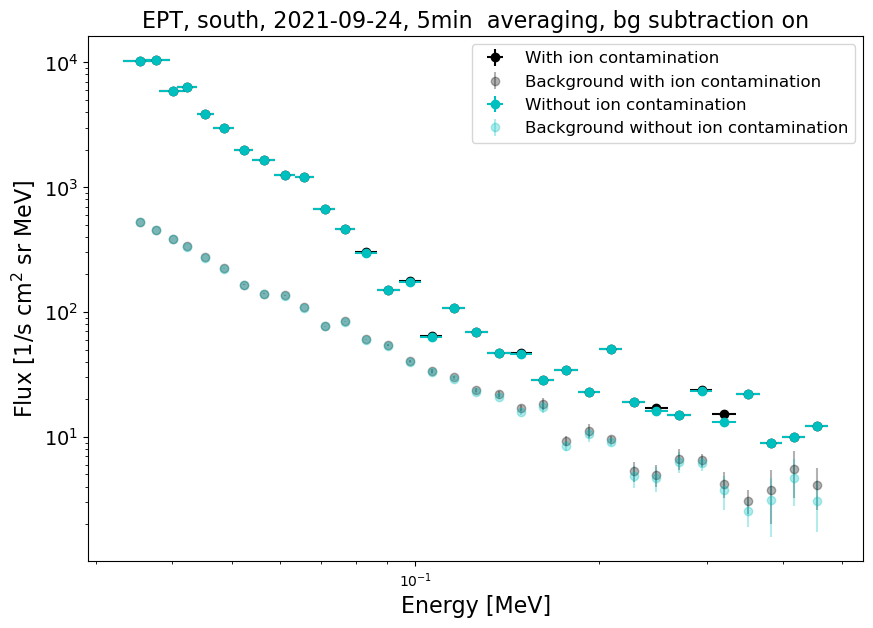

In [22]:
import matplotlib.ticker as ticker

data_ept_no_ion_corr = extract_electron_data(df_electrons_ept, energies_ept, plot_start, plot_end, t_inj, bgstart = bg_start, 
                                     bgend = bg_end, bg_distance_from_window = bg_distance_from_window, bg_period = bg_period, 
                                     travel_distance = travel_distance, travel_distance_second_slope=travel_distance_second_slope, 
                                     fixed_window=fixed_window, instrument = 'ept', data_type = 'l2', averaging=averaging, masking=True, 
                                     ion_conta_corr=False, df_protons = df_protons_ept)

write_to_csv(data_ept_no_ion_corr, date = date_string, path=path_to_folder, direction = direction)

file_path = path + date.strftime('%Y-%m-%d-%H%M') +'/'
os.getcwd()
os.chdir(file_path)
data_no_ion_corr = 'electron_data-'+ date.strftime('%Y-%m-%d') + '-EPT-' + direction + '-L2-' + averaging + '_averaging.csv'
data_ion_corr = 'electron_data-'+ date.strftime('%Y-%m-%d') + '-EPT-' + direction + '-L2-' + averaging+ '_averaging-ion_corr.csv'
df1 = pd.read_csv(data_no_ion_corr, sep=';')  
df2 = pd.read_csv(data_ion_corr, sep=';')

y1 = df1.Flux_peak
y2 = df2.Flux_peak
x = df1.Primary_energy
ratio = y1 / y2

fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1,1/3])

#def color_plot(direction):
color_dict = {'sun': 'crimson', 'asun': 'orange', 'north': 'darkslateblue', 'south': 'c'}
color = color_dict.get(direction.lower(), '')
ax1 = fig.add_subplot(gs[0])
ax1.errorbar(df1.Primary_energy, df1.Flux_peak, df1.Energy_error_low, df1.Energy_error_high, color='k', fmt='o', label='With ion contamination') 
ax1.errorbar(df1.Primary_energy, df1.Background_flux, df1.rel_backsub_peak_err, color='k', fmt='o', alpha = 0.3, label='Background with ion contamination')
ax1.errorbar(df2.Primary_energy, df2.Flux_peak, df2.Energy_error_low, df2.Energy_error_high, color=color, fmt='o', label='Without ion contamination') 
ax1.errorbar(df2.Primary_energy, df2.Background_flux, df2.rel_backsub_peak_err, color=color, fmt='o', alpha = 0.3, label = 'Background without ion contamination')

ax1.set_title('EPT, ' + direction + ', ' + date.strftime('%Y-%m-%d') + ', ' + averaging +  '  averaging, bg subtraction on', fontsize = 16)
ax1.set_ylabel(r'Flux [1/s cm$^{2}$ sr MeV]', fontsize = 16)
ax1.set_xlabel(r'Energy [MeV]', fontsize = 16)

ax1.tick_params(axis='y', which='major', labelsize=14)
ax1.legend(loc=0, fontsize = 12)
ax1.set_yscale('log')
ax1.set_xscale('log') 

plt.savefig(path +date_folder+ '/plots/EPT_ion_corr_spectra_comparison-'+averaging+'.png', dpi=300, bbox_inches='tight')